# ‰∏Ä.ÂØºÂÖ•ÂéüÂßãÊï∞ÊçÆ

## 1.1 Êï∞ÊçÆÂØºÂÖ•ÂíåÊ†ºÂºèÂåñ

In [5]:
import torch
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from torch.nn.parallel import DataParallel
import torch.nn.functional as F
# ËÆæÂÆöÈöèÊú∫ÁßçÂ≠ê‰ª•‰øùËØÅÁªìÊûúÂèØÂ§çÁé∞
torch.manual_seed(0)
np.random.seed(0)

# ËÆæÂÆöËÆæÂ§á
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Êñ∞Êï∞ÊçÆ
# ËØªÂèñÊâÄÊúâÊï∞ÊçÆ
paths = [
    './data/clean/clean_processed_data_1500_1.csv', './data/clean/clean_processed_data_1500_2.csv', './data/clean/clean_processed_data_1500_3.csv',
    './data/clean/clean_processed_data_1500_4.csv', './data/clean/clean_processed_data_1500_5.csv', './data/clean/clean_processed_data_1500_6.csv',
    './data/new1/clean_processed_data_1500_1.csv', './data/new1/clean_processed_data_1500_2.csv', './data/new1/clean_processed_data_1500_3.csv',
    './data/new1/clean_processed_data_1500_4.csv', './data/new1/clean_processed_data_1500_5.csv', './data/new1/clean_processed_data_1500_6.csv',
    './data/new2/clean_processed_data_1500_1.csv', './data/new2/clean_processed_data_1500_2.csv', './data/new2/clean_processed_data_1500_3.csv',
    './data/new2/clean_processed_data_1500_4.csv', './data/new2/clean_processed_data_1500_5.csv', './data/new2/clean_processed_data_1500_6.csv',
    './data/new3/clean_processed_data_1500_1.csv', './data/new3/clean_processed_data_1500_2.csv', './data/new3/clean_processed_data_1500_3.csv',
    './data/new3/clean_processed_data_1500_4.csv', './data/new3/clean_processed_data_1500_5.csv', './data/new3/clean_processed_data_1500_6.csv'   
]

all_data = []
for path in paths:
    data = pd.read_csv(path,header=None)
    data = np.array(data)
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)

# Â§ÑÁêÜÊï∞ÊçÆÁöÑÂáΩÊï∞
def process_data(data):
    pro_data = []
    for record in data:
        # ÊØèÊù°ËÆ∞ÂΩïÊòØ‰∏Ä‰∏™Â≠óÁ¨¶‰∏≤ÔºåÂ∞ÜÂÖ∂ÊåâÂàÜÂè∑ÂàÜÂâ≤
        elements = record[0].split(';')
        processed_data = []
        for element in elements:
            # print(element)
            # ÂéªÈô§Êã¨Âè∑Âπ∂ÊåâÈÄóÂè∑ÂàÜÂâ≤ÊàêÂÖÉÁ¥†ÂíåÊï∞Â≠ó
            mol, count = element.strip('()').split(',')
            processed_data.append((mol, int(count)))
        pro_data.append(np.array(processed_data))
    return pro_data

# Ë∞ÉÁî®ÂáΩÊï∞Â§ÑÁêÜÊï∞ÊçÆ
processed = process_data(all_data) 
processed = np.array(processed, dtype=object)
print(processed.shape)
print(processed[3][:5])

(10632,)
[['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO3' '2']
 ['MoO2' '96']
 ['MoO2S2' '2']]


In [2]:
import numpy as np
processed = np.concatenate(processed)
print('X.shape', processed.shape)  # ËæìÂÖ•ÁöÑÂΩ¢Áä∂

X.shape (1648646, 2)


## 1.2.ÂéüÂßãÊï∞ÊçÆ(processed)ÁªüËÆ°ÂàÜÊûê

#### ÁªüËÆ°ÊâÄÊúâÁâ©ÁßçÁ±ªÂûã

In [3]:
# ÁªüËÆ°ÊâÄÊúâÁâ©ÁßçÁ±ªÂûã
unique_species = set()

for record in processed:
    for element in record:
        # element ÊòØ‰∏Ä‰∏™ÂåÖÂê´ ['Áâ©ÁßçÂêçÁß∞', 'ÂÅúÁïôÊó∂Èó¥'] ÁöÑÊï∞ÁªÑ
        mol = element[0]  # Ëé∑ÂèñÁâ©ÁßçÂêçÁß∞
        unique_species.add(mol)

# ËæìÂá∫ÊâÄÊúâÁâ©ÁßçÁ±ªÂûãÁöÑÂêçÁß∞
print(len(unique_species))
#print(unique_species)

10


#### ÁªüËÆ°ÊØè‰∏™Áâ©ÁßçÁöÑÊÄªÂá∫Áé∞Ê¨°Êï∞‰ª•ÂèäÂÅúÁïôÊó∂Èó¥Â∞è‰∫éÁ≠â‰∫énÁöÑÊ¨°Êï∞

In [4]:
from collections import Counter
import numpy as np
import pandas as pd

def count_species_with_time(processed, n):
    """
    ÁªüËÆ°ÊØè‰∏™Áâ©ÁßçÁöÑÊÄªÂá∫Áé∞Ê¨°Êï∞‰ª•ÂèäÂÅúÁïôÊó∂Èó¥Â∞è‰∫éÁ≠â‰∫énÁöÑÊ¨°Êï∞„ÄÇ

    ÂèÇÊï∞:
    - processed (np.array): Â§ÑÁêÜÂêéÁöÑÊï∞ÊçÆÊï∞ÁªÑÔºåÂÖÉÁ¥†‰∏∫ÊØèÊù°ËÆ∞ÂΩïÁöÑÁâ©ÁßçÂèäÂÅúÁïôÊó∂Èó¥„ÄÇ
    - n (int): ÂÅúÁïôÊó∂Èó¥ÁöÑÈòàÂÄº„ÄÇ

    ËøîÂõû:
    - species_counter (Counter): ÊØè‰∏™Áâ©ÁßçÁöÑÊÄªÂá∫Áé∞Ê¨°Êï∞„ÄÇ
    - species_counter_le_n (Counter): ÊØè‰∏™Áâ©ÁßçÂÅúÁïôÊó∂Èó¥Â∞è‰∫éÁ≠â‰∫énÁöÑÂá∫Áé∞Ê¨°Êï∞„ÄÇ
    """
    species_counter = Counter()
    species_counter_le_n = Counter()
    
    for record in processed:
        for element in record:
            mol = element[0]
            try:
                count = int(element[1])
            except ValueError:
                print(f"Êó†Ê≥ïÂ∞ÜÂÅúÁïôÊó∂Èó¥ËΩ¨Êç¢‰∏∫Êï¥Êï∞: {element[1]}ÔºåË∑≥ËøáËØ•ÂÖÉÁ¥†„ÄÇ")
                continue  # Ë∑≥ËøáÊó†Ê≥ïËΩ¨Êç¢ÁöÑÂÖÉÁ¥†
            
            species_counter[mol] += 1
            if count <= n:
                species_counter_le_n[mol] += 1
    
    return species_counter, species_counter_le_n

def print_species_statistics(species_counts, species_counts_le_n, n):
    """
    ÊâìÂç∞ÊØèÁßçÁâ©ÁßçÁöÑÊÄªÂá∫Áé∞Ê¨°Êï∞„ÄÅÂÅúÁïôÊó∂Èó¥Â∞è‰∫éÁ≠â‰∫énÁöÑÂá∫Áé∞Ê¨°Êï∞‰ª•ÂèäÂÅúÁïôÊó∂Èó¥Â§ß‰∫énÁöÑÂá∫Áé∞Ê¨°Êï∞Ôºå
    ÊåâÊÄªÂá∫Áé∞Ê¨°Êï∞ÈôçÂ∫èÊéíÂàó„ÄÇ

    ÂèÇÊï∞:
    - species_counts (Counter): ÊØè‰∏™Áâ©ÁßçÁöÑÊÄªÂá∫Áé∞Ê¨°Êï∞„ÄÇ
    - species_counts_le_n (Counter): ÊØè‰∏™Áâ©ÁßçÂÅúÁïôÊó∂Èó¥Â∞è‰∫éÁ≠â‰∫énÁöÑÂá∫Áé∞Ê¨°Êï∞„ÄÇ
    - n (int): ÂÅúÁïôÊó∂Èó¥ÁöÑÈòàÂÄº„ÄÇ
    """
    # Ëé∑ÂèñÊåâÊÄªÂá∫Áé∞Ê¨°Êï∞ÈôçÂ∫èÊéíÂàóÁöÑÁâ©ÁßçÂàóË°®
    sorted_species = species_counts.most_common()
    
    # ÊâìÂç∞Ë°®Â§¥
    print(f"\n{'Áâ©ÁßçÁ±ªÂûã':<20} {'ÊÄªÂá∫Áé∞Ê¨°Êï∞':<15} {'ÂÅúÁïôÊó∂Èó¥<= ' + str(n) + ' Ê¨°Êï∞':<20} {'ÂÅúÁïôÊó∂Èó¥> ' + str(n) + ' Ê¨°Êï∞':<20}")
    print("-" * 75)
    
    # ÊâìÂç∞ÊØèÁßçÁâ©ÁßçÁöÑÁªüËÆ°Êï∞ÊçÆ
    for mol, total in sorted_species:
        le_n = species_counts_le_n.get(mol, 0)
        gt_n = total - le_n  # ËÆ°ÁÆóÂÅúÁïôÊó∂Èó¥ > n ÁöÑÊ¨°Êï∞
        print(f"{mol:<20} {total:<15} {le_n:<20} {gt_n:<20}")


# Á§∫‰æãË∞ÉÁî®
if __name__ == "__main__":

    n = 3  # ËÆæÂÆöÈòàÂÄº
    
    # ÁªüËÆ°Áâ©ÁßçÂá∫Áé∞Ê¨°Êï∞ÂíåÂÅúÁïôÊó∂Èó¥Â∞è‰∫éÁ≠â‰∫énÁöÑÂá∫Áé∞Ê¨°Êï∞
    species_counts, species_counts_le_n = count_species_with_time(processed_deleted, n) #########################‰øÆÊîπ
    
    # ÊâìÂç∞ÁªüËÆ°ÁªìÊûúÔºåÊåâÊÄªÂá∫Áé∞Ê¨°Êï∞ÈôçÂ∫èÊéíÂàó
    print_species_statistics(species_counts, species_counts_le_n, n)

NameError: name 'processed_deleted' is not defined

#### ÁªüËÆ°ÊØè‰∏™Áâ©ÁßçÁöÑÊúÄÂ§ß„ÄÅÊúÄÂ∞èÂíåÂπ≥ÂùáÂÅúÁïôÊó∂Èó¥

In [ ]:
from collections import Counter, defaultdict
# -----------------------------------------------
# ÁªüËÆ°ÊØè‰∏™Áâ©ÁßçÁöÑÊúÄÂ§ß„ÄÅÊúÄÂ∞èÂíåÂπ≥ÂùáÂÅúÁïôÊó∂Èó¥
# -----------------------------------------------

# ‰ΩøÁî® defaultdict Â≠òÂÇ®ÊØè‰∏™Áâ©ÁßçÁöÑÊúÄÂ∞è„ÄÅÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ÂèäÊÄªÂÅúÁïôÊó∂Èó¥
species_time_stats = defaultdict(lambda: {'min': None, 'max': None, 'total': 0, 'count': 0})

for record in processed_deleted: ########################filtered_processedÔºåprocessed_deleted
    for element in record:
        mol, count = element[0], int(element[1])
        if species_time_stats[mol]['min'] is None or count < species_time_stats[mol]['min']:
            species_time_stats[mol]['min'] = count
        if species_time_stats[mol]['max'] is None or count > species_time_stats[mol]['max']:
            species_time_stats[mol]['max'] = count
        species_time_stats[mol]['total'] += count
        species_time_stats[mol]['count'] += 1

# ËÆ°ÁÆóÂπ≥ÂùáÂÅúÁïôÊó∂Èó¥Âπ∂ÂáÜÂ§áËæìÂá∫ÂàóË°®
species_time_list = sorted(
    [
        (
            stats['total'] / stats['count'] if stats['count'] > 0 else 0,
            stats['max'],
            stats['min'],
            mol
        )
        for mol, stats in species_time_stats.items()
    ],
    key=lambda x: x[0]
)

# ËæìÂá∫ÁªüËÆ°ÁªìÊûú
print("\nÊØèÁßçÁâ©ÁßçÁ±ªÂûãÁöÑÊúÄÂ§ß„ÄÅÊúÄÂ∞èÂíåÂπ≥ÂùáÂÅúÁïôÊó∂Èó¥Ôºö")
for avg_time, max_time,min_time,mol in species_time_list:
    print(f"{mol}: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = {min_time}, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = {max_time}, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = {avg_time:.2f}")


ÊØèÁßçÁâ©ÁßçÁ±ªÂûãÁöÑÊúÄÂ§ß„ÄÅÊúÄÂ∞èÂíåÂπ≥ÂùáÂÅúÁïôÊó∂Èó¥Ôºö
Mo2O4: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 69, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 4.61
MoO3: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 482, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 7.94
Mo3O9S2: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 68, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 10.72
MoO2S2: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 730, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 13.33
MoO2S: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 604, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 15.14
MoO2S4: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 820, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 21.98
MoOS4: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 1341, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 31.89
MoO2S5: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 1381, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 33.52
MoOS2: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 1325, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 38.79
MoOS3: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 1566, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 39.81
MoO2: ÊúÄÂ∞èÂÅúÁïôÊó∂Èó¥ = 1, ÊúÄÂ§ßÂÅúÁïôÊó∂Èó¥ = 880, Âπ≥ÂùáÂÅúÁïôÊó∂Èó¥ = 46.31
MoS: ÊúÄÂ∞è

## 2.Ê∑±Â∫¶Â§ÑÁêÜÂéüÂßãÊï∞ÊçÆ(processed)

### 2.1.Âà†Èô§ÂÅúÁïôÊó∂Èó¥Â∞è‰∫é min_time ÁöÑÁä∂ÊÄÅ (Â§ÑÁêÜprocessedÔºåÂæóÂà∞new_processed)

In [6]:
import numpy as np

def filter_and_merge_one_record(record, min_time=5):
    """
    ÂØπÂçïÊù°ËÆ∞ÂΩïËøõË°åËøáÊª§ÂíåÂêàÂπ∂Êìç‰ΩúÔºö
    1. Âà†Èô§ÂÅúÁïôÊó∂Èó¥Â∞è‰∫é min_time ÁöÑÁä∂ÊÄÅ„ÄÇ
    2. Â∞ÜÂà†Èô§ÂêéËøûÁª≠‰∏îÁõ∏ÂêåÁâ©ÁßçÁöÑÁä∂ÊÄÅÂêàÂπ∂‰∏∫‰∏Ä‰∏™Áä∂ÊÄÅÔºàÂÅúÁïôÊó∂Èó¥Á¥ØÂä†Ôºâ„ÄÇ
    
    ÂèÇÊï∞Ôºö
    - record: ÂΩ¢Â¶Ç array([['MoO','33'], ['MoS','251'], ['MoS','254'], ...]) ÁöÑÊï∞ÁªÑ
    - min_time: ÂÅúÁïôÊó∂Èó¥ÁöÑÈòàÂÄºÔºåÂà†Èô§ÂÅúÁïôÊó∂Èó¥Â∞è‰∫éËØ•ÂÄºÁöÑÁä∂ÊÄÅ
    
    ËøîÂõûÔºö
    - Â§ÑÁêÜÂêéÁöÑ NumPy Êï∞ÁªÑÔºåÊª°Ë∂≥‰ª•‰∏ä‰∏§Ê≠•Êìç‰Ωú
    """
    # 1) ËøáÊª§ÔºöÂà†Èô§ÂÅúÁïôÊó∂Èó¥ =< min_time ÁöÑÁä∂ÊÄÅ
    filtered = [row for row in record if int(row[1]) > min_time]
    
    # 2) ÂêàÂπ∂ËøûÁª≠Áõ∏ÂêåÁâ©ÁßçÁöÑÁä∂ÊÄÅ
    merged = []
    for mol, time_str in filtered:
        time_val = int(time_str)
        if merged and merged[-1][0] == mol:
            # Ëã•‰∏é‰∏ä‰∏Ä‰∏™Áâ©ÁßçÁõ∏ÂêåÔºåÂàôÂêàÂπ∂ÔºàÁ¥ØÂä†ÂÅúÁïôÊó∂Èó¥Ôºâ
            merged[-1][1] = str(int(merged[-1][1]) + time_val)
        else:
            # Âê¶ÂàôÊ∑ªÂä†Êñ∞ÁöÑÁâ©ÁßçÁä∂ÊÄÅ
            merged.append([mol, str(time_val)])
    
    return np.array(merged)

def filter_and_merge_processed(processed, min_time=5):
    """
    ÂØπÂÆåÊï¥ÁöÑ processed Êï∞ÊçÆËøõË°åËøáÊª§ÂíåÂêàÂπ∂Êìç‰ΩúÔºö
    ÂØπ processed ÊØè‰∏™ÂÖÉÁ¥†ÔºàÂçïÊù°ËÆ∞ÂΩïÔºâË∞ÉÁî® filter_and_merge_one_record
    
    ÂèÇÊï∞Ôºö
    - processed: ÂΩ¢Â¶Ç [record_1, record_2, ...] ÁöÑÂØπË±°Êï∞ÁªÑÔºàdtype=objectÔºâ
    - min_time: ÂÅúÁïôÊó∂Èó¥ÁöÑÈòàÂÄº
    
    ËøîÂõûÔºö
    - Â§ÑÁêÜÂêéÁöÑ NumPy ÂØπË±°Êï∞ÁªÑ
    """
    new_processed = []
    for idx, record in enumerate(processed):
        merged_record = filter_and_merge_one_record(record, min_time=min_time)
        new_processed.append(merged_record)
    
    return np.array(new_processed, dtype=object)

# -------------------- ÊµãËØïÁ§∫‰æã --------------------
if __name__ == "__main__":    
    # ËÆæÂÆöÈòàÂÄºÔºåÊØîÂ¶Ç n=5
    n = 0
    
    # Ë∞ÉÁî®ËøáÊª§ÂíåÂêàÂπ∂ÂáΩÊï∞
    new_processed = filter_and_merge_processed(processed, min_time=n)
    
    # ÊâìÂç∞ËøáÊª§ÂâçÂíåËøáÊª§ÂêéÁöÑÁªìÊûú
    print("ËøáÊª§Ââç (ÂéüÂßãÊï∞ÊçÆ) Ôºö")
    print(processed[4][:30])
    
    print("\nËøáÊª§Âêé (Âà†Èô§ÂÅúÁïôÊó∂Èó¥ < 0 Âπ∂ÂêàÂπ∂Áõ∏ÈÇªÁõ∏ÂêåÁä∂ÊÄÅ) Ôºö")
    print(new_processed[4][:30])

ËøáÊª§Ââç (ÂéüÂßãÊï∞ÊçÆ) Ôºö
[['Mo3O9' '26']
 ['Mo3O9S2' '7']
 ['MoO2' '52']
 ['MoO' '4']
 ['MoO2' '25']
 ['MoO2S2' '1']
 ['MoOS2' '118']
 ['MoS' '5']
 ['MoOS2' '7']
 ['MoS' '2']
 ['MoOS2' '7']
 ['MoS' '292']
 ['MoOS2' '9']
 ['MoS' '240']
 ['MoOS2' '2']
 ['MoS' '3']
 ['MoOS2' '11']
 ['MoOS' '9']
 ['Mo' '22']
 ['MoOS' '247']
 ['MoS' '145']
 ['MoOS2' '13']
 ['MoS' '121']
 ['MoOS2' '2']
 ['MoS' '236']
 ['MoOS2' '19']
 ['MoS' '141']
 ['MoS3' '5']
 ['MoS' '14']
 ['MoS3' '11']]

ËøáÊª§Âêé (Âà†Èô§ÂÅúÁïôÊó∂Èó¥ < 0 Âπ∂ÂêàÂπ∂Áõ∏ÈÇªÁõ∏ÂêåÁä∂ÊÄÅ) Ôºö
[['Mo3O9' '26']
 ['Mo3O9S2' '7']
 ['MoO2' '52']
 ['MoO' '4']
 ['MoO2' '25']
 ['MoO2S2' '1']
 ['MoOS2' '118']
 ['MoS' '5']
 ['MoOS2' '7']
 ['MoS' '2']
 ['MoOS2' '7']
 ['MoS' '292']
 ['MoOS2' '9']
 ['MoS' '240']
 ['MoOS2' '2']
 ['MoS' '3']
 ['MoOS2' '11']
 ['MoOS' '9']
 ['Mo' '22']
 ['MoOS' '247']
 ['MoS' '145']
 ['MoOS2' '13']
 ['MoS' '121']
 ['MoOS2' '2']
 ['MoS' '236']
 ['MoOS2' '19']
 ['MoS' '141']
 ['MoS3' '5']
 ['MoS' '14']
 ['MoS3' '11']]


### 2.3.Êà™Êñ≠ÈïøÂ∫èÂàóÂà∞Áªà‰∫ßÁâ©Ôºànew_processedÔºåÂæóÂà∞filtered_processedÂíårecord_lengthsÔºâ

In [7]:
import numpy as np
from collections import Counter

# ÂÆö‰πâ‰∫ßÁâ©ÂàóË°®
product_list = ['MoS6', 'MoS7']

def filter_by_product_list_with_n(new_processed, product_list, n=0):
    """
    ÂØπÂ∫èÂàóËøõË°åËøáÊª§Ôºö
    ÂΩìÈÅáÂà∞ product_list ‰∏≠ÁöÑÁâ©ÁßçÊó∂Ôºå‰øùÁïôËØ•Áâ©ÁßçÂèäÂÖ∂‰πãÂâçÁöÑÂÜÖÂÆπÔºåÂπ∂È¢ùÂ§ñ‰øùÁïôÂÖ∂ÂêéÁöÑ n ‰∏™Áä∂ÊÄÅ„ÄÇ
    
    ÂèÇÊï∞Ôºö
    - new_processed: ËæìÂÖ•Êï∞ÊçÆÔºåÂΩ¢Â¶Ç [record_1, record_2, ...] ÁöÑÂØπË±°Êï∞ÁªÑÔºàdtype=objectÔºâ
    - product_list: ÈúÄË¶ÅÊ£ÄÊü•ÁöÑ‰∫ßÁâ©ÂàóË°®Ôºå‰æãÂ¶Ç ['MoS6', 'MoS7']
    - n: È¢ùÂ§ñ‰øùÁïôÁöÑÂêéÁª≠Áä∂ÊÄÅÊï∞ÁõÆÔºåÈªòËÆ§‰∏∫ 0
    
    ËøîÂõûÔºö
    - ËøáÊª§ÂêéÁöÑ NumPy ÂØπË±°Êï∞ÁªÑ
    """
    filtered_records = []
    record_lengths = []  # ËÆ∞ÂΩïÊØè‰∏™ËøáÊª§ÂêéËÆ∞ÂΩïÁöÑÈïøÂ∫¶
    
    # ÈÅçÂéÜÊØè‰∏ÄË°åËÆ∞ÂΩï
    for record in new_processed:
        # ÂàùÂßãÂåñÊà™Êñ≠ÂêéÁöÑËÆ∞ÂΩï
        truncated_record = []
        found_product = False
        extra_count = 0
        
        # ÈÅçÂéÜÂΩìÂâçËÆ∞ÂΩï‰∏≠ÁöÑÊØè‰∏ÄÂØπ [Áâ©Áßç, Êó∂Èó¥]
        for i, (mol, time) in enumerate(record):
            if found_product:
                # Â¶ÇÊûúÂ∑≤ÁªèÈÅáÂà∞ product_list ‰∏≠ÁöÑÁâ©ÁßçÔºåÈ¢ùÂ§ñ‰øùÁïô n ‰∏™Áä∂ÊÄÅ
                if extra_count < n:
                    truncated_record.append([mol, time])
                    extra_count += 1
                else:
                    break
            else:
                # Ê∑ªÂä†ÂΩìÂâç [mol, time]
                truncated_record.append([mol, time])
                # Â¶ÇÊûúÂΩìÂâçÁâ©ÁßçÂú® product_list ‰∏≠ÔºåÊ†áËÆ∞ found_product
                if mol in product_list:
                    found_product = True
                    # Â¶ÇÊûú n=0ÔºåÁ´ãÂç≥ÂÅúÊ≠¢
                    if n == 0:
                        break
        
        # Â¶ÇÊûúÊï¥Ë°åÊ≤°ÊúâÈÅáÂà∞ product_list ‰∏≠ÁöÑÁâ©ÁßçÔºå‰øùÁïôÊï¥Ë°å
        if not found_product:
            truncated_record = record
        
        # Â∞ÜÊà™Êñ≠ÂêéÁöÑËÆ∞ÂΩïËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑÂπ∂Ê∑ªÂä†Âà∞ÁªìÊûúÂàóË°®
        filtered_records.append(np.array(truncated_record))
        record_lengths.append(len(truncated_record))  # ËÆ∞ÂΩïÈïøÂ∫¶
    
    # ËΩ¨Êç¢‰∏∫ NumPy ÂØπË±°Êï∞ÁªÑ
    return np.array(filtered_records, dtype=object), record_lengths

# ÂÅáËÆæ processed Â∑≤Áî±‰πãÂâçÁöÑ‰ª£Á†ÅÁîüÊàê
# Ë∞ÉÁî®ÂáΩÊï∞ËøõË°åËøáÊª§Ôºån=0
filtered_processed, record_lengths = filter_by_product_list_with_n(new_processed, product_list, n=0) #######################new_processed

# ÁªüËÆ°ÊØè‰∏™ÈïøÂ∫¶Âá∫Áé∞ÁöÑÊ¨°Êï∞
length_counts = Counter(record_lengths)

# Ëé∑ÂèñÊåâÈïøÂ∫¶ÊéíÂ∫èÁöÑÁªìÊûú
sorted_length_counts = sorted(length_counts.items())

# ËæìÂá∫ÊúÄÂ∞èÈïøÂ∫¶

min_length = sorted_length_counts[0][0]
second_min_length = sorted_length_counts[1][0] if len(sorted_length_counts) > 1 else None
third_min_length = sorted_length_counts[2][0] if len(sorted_length_counts) > 2 else None
forth_min_length = sorted_length_counts[3][0] if len(sorted_length_counts) > 3 else None
fifth_min_length = sorted_length_counts[4][0] if len(sorted_length_counts) > 4 else None

print("\nÊúÄÂ∞èÈïøÂ∫¶:", min_length, "ÊÄªË°åÊï∞:", length_counts[min_length])
if second_min_length is not None:
    print("Á¨¨‰∫åÂ∞èÈïøÂ∫¶:", second_min_length, "ÊÄªË°åÊï∞:", length_counts[second_min_length])
if third_min_length is not None:
    print("Á¨¨‰∏âÂ∞èÈïøÂ∫¶:", third_min_length, "ÊÄªË°åÊï∞:", length_counts[third_min_length])
if forth_min_length is not None:
    print("Á¨¨ÂõõÂ∞èÈïøÂ∫¶:", forth_min_length, "ÊÄªË°åÊï∞:", length_counts[forth_min_length])
if fifth_min_length is not None:
    print("Á¨¨‰∫îÂ∞èÈïøÂ∫¶:", fifth_min_length, "ÊÄªË°åÊï∞:", length_counts[fifth_min_length])    
    
# ÊâìÂç∞Á§∫‰æãÁªìÊûú
print("\nËøáÊª§ÂâçÔºö")
print(new_processed[1][:30])
print("\nËøáÊª§Âêé (Âà†Èô§ product_list ‰∏≠ÁöÑÁâ©ÁßçÂèäÂÖ∂‰πãÂêéÁöÑÂÜÖÂÆπ)Ôºö")
print(filtered_processed[1][:30])


ÊúÄÂ∞èÈïøÂ∫¶: 5 ÊÄªË°åÊï∞: 3
Á¨¨‰∫åÂ∞èÈïøÂ∫¶: 6 ÊÄªË°åÊï∞: 8
Á¨¨‰∏âÂ∞èÈïøÂ∫¶: 7 ÊÄªË°åÊï∞: 32
Á¨¨ÂõõÂ∞èÈïøÂ∫¶: 8 ÊÄªË°åÊï∞: 94
Á¨¨‰∫îÂ∞èÈïøÂ∫¶: 9 ÊÄªË°åÊï∞: 180

ËøáÊª§ÂâçÔºö
[['Mo3O9' '55']
 ['MoO2' '128']
 ['MoOS' '3']
 ['MoOS2' '2']
 ['MoS' '2']
 ['MoOS2' '75']
 ['MoS4' '366']
 ['MoS6' '196']
 ['Mo2S8' '24']
 ['MoS4' '66']
 ['Mo2S7' '6']
 ['MoS4' '90']
 ['MoS6' '90']
 ['MoS8' '6']
 ['MoS6' '13']
 ['MoS8' '2']
 ['MoS6' '6']
 ['MoS8' '2']
 ['MoS6' '838']
 ['MoS8' '20']
 ['MoS6' '283']
 ['Mo2S7' '52']
 ['Mo2S6' '11']
 ['MoS6' '149']
 ['MoS4' '2']
 ['MoS6' '51']
 ['MoS8' '2']
 ['MoS6' '331']
 ['MoS8' '4']
 ['MoS6' '409']]

ËøáÊª§Âêé (Âà†Èô§ product_list ‰∏≠ÁöÑÁâ©ÁßçÂèäÂÖ∂‰πãÂêéÁöÑÂÜÖÂÆπ)Ôºö
[['Mo3O9' '55']
 ['MoO2' '128']
 ['MoOS' '3']
 ['MoOS2' '2']
 ['MoS' '2']
 ['MoOS2' '75']
 ['MoS4' '366']
 ['MoS6' '196']]


Âà†Èô§ÊåáÂÆö

In [8]:
import numpy as np
from collections import Counter

def filter_by_length(filtered_processed, record_lengths, s=None, l=None):
    """
    Âà†Èô§ËøáÊª§ÂêéÊï∞ÊçÆ‰∏≠ÈïøÂ∫¶Â∞è‰∫éÁ≠â‰∫é s ÊàñÂ§ß‰∫éÁ≠â‰∫é l ÁöÑË°å
    
    ÂèÇÊï∞Ôºö
    - filtered_processed: ËøáÊª§ÂêéÁöÑÊï∞ÊçÆÔºåNumPyÂØπË±°Êï∞ÁªÑ
    - record_lengths: ÂêÑË°åÁöÑÈïøÂ∫¶ÂàóË°®
    - s: Âà†Èô§ÈïøÂ∫¶Â∞è‰∫éÁ≠â‰∫é s ÁöÑË°åÔºàÈªòËÆ§‰∏∫ NoneÔºå‰∏çÂêØÁî®Ôºâ
    - l: Âà†Èô§ÈïøÂ∫¶Â§ß‰∫éÁ≠â‰∫é l ÁöÑË°åÔºàÈªòËÆ§‰∏∫ NoneÔºå‰∏çÂêØÁî®Ôºâ
    
    ËøîÂõûÔºö
    - new_filtered: ËøáÊª§ÂêéÁöÑÊñ∞Êï∞ÊçÆÔºàNumPyÂØπË±°Êï∞ÁªÑÔºâ
    - new_lengths: Êñ∞Êï∞ÊçÆÂØπÂ∫îÁöÑÈïøÂ∫¶ÂàóË°®
    """
    # ÂàùÂßãÂåñÊé©Á†Å‰∏∫ TrueÔºà‰øùÁïôÊâÄÊúâË°åÔºâ
    mask = [True] * len(record_lengths)
    
    # Ê†πÊçÆ s Âíå l Êõ¥Êñ∞Êé©Á†Å
    if s is not None:
        mask = [mask[i] and (length > s) for i, length in enumerate(record_lengths)]
    if l is not None:
        mask = [mask[i] and (length < l) for i, length in enumerate(record_lengths)]
    
    # ËøáÊª§Êï∞ÊçÆ
    new_filtered = filtered_processed[mask]
    # ËøáÊª§ÂØπÂ∫îÁöÑÈïøÂ∫¶ÂàóË°®
    new_lengths = [length for length, keep in zip(record_lengths, mask) if keep]
    
    return new_filtered, new_lengths


# Ë∞ÉÁî®Êñ∞ÂáΩÊï∞ÔºåÂà†Èô§ÈïøÂ∫¶ <=6 ÂíåÈïøÂ∫¶ >=100 ÁöÑË°å
s_threshold = 6  # Âà†Èô§ÈïøÂ∫¶ <=6 ÁöÑË°å
l_threshold = 80  # Âà†Èô§ÈïøÂ∫¶ >=100 ÁöÑË°å
new_filtered, new_lengths = filter_by_length(filtered_processed, record_lengths, s=s_threshold, l=l_threshold)

# ÁªüËÆ°Êñ∞Êï∞ÊçÆÁöÑÈïøÂ∫¶ÂàÜÂ∏É
length_counts = Counter(new_lengths)
sorted_length_counts = sorted(length_counts.items())
print("\nËøáÊª§ÂêéÂêÑÈïøÂ∫¶ÁªüËÆ°Ôºà6 < ÈïøÂ∫¶ < 100 ÁöÑË°åÔºâ:")
for length, count in sorted_length_counts:
    print(f"ÈïøÂ∫¶ {length}: {count} Ë°å")


ËøáÊª§ÂêéÂêÑÈïøÂ∫¶ÁªüËÆ°Ôºà6 < ÈïøÂ∫¶ < 100 ÁöÑË°åÔºâ:
ÈïøÂ∫¶ 7: 32 Ë°å
ÈïøÂ∫¶ 8: 94 Ë°å
ÈïøÂ∫¶ 9: 180 Ë°å
ÈïøÂ∫¶ 10: 205 Ë°å
ÈïøÂ∫¶ 11: 246 Ë°å
ÈïøÂ∫¶ 12: 273 Ë°å
ÈïøÂ∫¶ 13: 345 Ë°å
ÈïøÂ∫¶ 14: 366 Ë°å
ÈïøÂ∫¶ 15: 351 Ë°å
ÈïøÂ∫¶ 16: 348 Ë°å
ÈïøÂ∫¶ 17: 347 Ë°å
ÈïøÂ∫¶ 18: 354 Ë°å
ÈïøÂ∫¶ 19: 369 Ë°å
ÈïøÂ∫¶ 20: 396 Ë°å
ÈïøÂ∫¶ 21: 345 Ë°å
ÈïøÂ∫¶ 22: 295 Ë°å
ÈïøÂ∫¶ 23: 343 Ë°å
ÈïøÂ∫¶ 24: 306 Ë°å
ÈïøÂ∫¶ 25: 321 Ë°å
ÈïøÂ∫¶ 26: 304 Ë°å
ÈïøÂ∫¶ 27: 305 Ë°å
ÈïøÂ∫¶ 28: 269 Ë°å
ÈïøÂ∫¶ 29: 249 Ë°å
ÈïøÂ∫¶ 30: 238 Ë°å
ÈïøÂ∫¶ 31: 202 Ë°å
ÈïøÂ∫¶ 32: 227 Ë°å
ÈïøÂ∫¶ 33: 217 Ë°å
ÈïøÂ∫¶ 34: 165 Ë°å
ÈïøÂ∫¶ 35: 165 Ë°å
ÈïøÂ∫¶ 36: 167 Ë°å
ÈïøÂ∫¶ 37: 179 Ë°å
ÈïøÂ∫¶ 38: 166 Ë°å
ÈïøÂ∫¶ 39: 154 Ë°å
ÈïøÂ∫¶ 40: 125 Ë°å
ÈïøÂ∫¶ 41: 165 Ë°å
ÈïøÂ∫¶ 42: 117 Ë°å
ÈïøÂ∫¶ 43: 107 Ë°å
ÈïøÂ∫¶ 44: 92 Ë°å
ÈïøÂ∫¶ 45: 97 Ë°å
ÈïøÂ∫¶ 46: 86 Ë°å
ÈïøÂ∫¶ 47: 78 Ë°å
ÈïøÂ∫¶ 48: 84 Ë°å
ÈïøÂ∫¶ 49: 73 Ë°å
ÈïøÂ∫¶ 50: 79 Ë°å
ÈïøÂ∫¶ 51: 58 Ë°å
ÈïøÂ∫¶ 52: 57 Ë°å
ÈïøÂ∫¶ 53: 53 Ë°å
ÈïøÂ∫¶ 54: 36 Ë°å
ÈïøÂ∫¶ 55: 38 Ë°å
ÈïøÂ∫¶ 56: 52 Ë°å
ÈïøÂ∫¶ 57: 6

ËæìÂá∫ÊåáÂÆöÈïøÂ∫¶Ë°åÁöÑÂÜÖÂÆπ

In [9]:
import numpy as np

def get_rows_by_length(filtered_processed, record_lengths, target_length):
    """
    Ëé∑ÂèñÊåáÂÆöÈïøÂ∫¶ÁöÑË°åÂÜÖÂÆπ
    
    ÂèÇÊï∞Ôºö
    - filtered_processed: ËøáÊª§ÂêéÁöÑÊï∞ÊçÆÔºåNumPyÂØπË±°Êï∞ÁªÑ
    - record_lengths: ÂêÑË°åÁöÑÈïøÂ∫¶ÂàóË°®
    - target_length: ÈúÄË¶ÅËé∑ÂèñÁöÑÊåáÂÆöÈïøÂ∫¶
    
    ËøîÂõûÔºö
    - NumPyÂØπË±°Êï∞ÁªÑÔºåÂåÖÂê´ÊâÄÊúâÈïøÂ∫¶Á≠â‰∫étarget_lengthÁöÑË°å
    """
    # ‰ΩøÁî®ÂàóË°®Êé®ÂØºÂºèÁ≠õÈÄâÂá∫Á¨¶ÂêàÈïøÂ∫¶ÁöÑË°å
    selected = [record for record, length in zip(filtered_processed, record_lengths) if length == target_length]
    
    # ËΩ¨Êç¢‰∏∫‰∏éÂéüÊï∞ÊçÆ‰∏ÄËá¥ÁöÑNumPyÂØπË±°Êï∞ÁªÑÊ†ºÂºè
    return np.array(selected, dtype=object)



# Ëé∑ÂèñÊâÄÊúâÈïøÂ∫¶‰∏∫100ÁöÑË°å
target_len = 587
matching_rows = get_rows_by_length(filtered_processed, record_lengths, target_len)

# ÊâìÂç∞ÁªìÊûúÔºàÂ∏¶ÁªüËÆ°‰ø°ÊÅØÔºâ
print(f"\nÊâæÂà∞ {len(matching_rows)} Ë°åÈïøÂ∫¶‰∏∫ {target_len} ÁöÑËÆ∞ÂΩïÔºö")
# for i, row in enumerate(matching_rows, 1):
#     print(f"\nÁ¨¨ {i} Ë°åÊï∞ÊçÆÔºàÊÄªÈïøÂ∫¶ {len(row)}Ôºâ:")
#     for record in row:
#         print(record)


ÊâæÂà∞ 0 Ë°åÈïøÂ∫¶‰∏∫ 587 ÁöÑËÆ∞ÂΩïÔºö


### 2.3.Âà†Èô§Âá∫Áé∞Áâ©ÁßçÊï∞ÈáèÂæàÂ∞ëÁöÑÁâ©Áßç(Â§ÑÁêÜfiltered_processedÔºåÂæóÂà∞processed_deleted)

In [10]:
# ÂæÖÂà†Èô§ÁöÑÁõÆÊ†áÁâ©ÁßçÂàóË°®
target_deleted_species_list = ['MoO4','MoO2S6','Mo2O3','MoS9','Mo2S3','Mo2OS8','Mo2O2','Mo2OS','Mo2O4','Mo3S10','Mo2S11','MoS8','Mo2S4']
#target_deleted_species_list = ['MoO2S3','MoOS7', 'Mo2S4', 'Mo2O3', 'MoS8', 'Mo2S11', 'Mo2O2','Mo3S10','Mo2OS','Mo2OS8','Mo2S3','MoS9','MoO4','MoO2S6','Mo','Mo2S5','Mo2S6','Mo2S7','Mo2S8','Mo2S9','Mo2S10']

def merge_states(record, target_deleted_species_list):
    """
    ÂØπÂçïÊù°ËÆ∞ÂΩïËøõË°åÂ§ÑÁêÜÔºö
    1. Âà†Èô§ÁõÆÊ†áÁâ©Áßç„ÄÇ
    2. ÂêàÂπ∂ËøûÁª≠Áõ∏ÂêåÁâ©ÁßçÁöÑÁä∂ÊÄÅÔºåÁ¥ØÂä†ÂÅúÁïôÊó∂Èó¥„ÄÇ
    
    ÂèÇÊï∞Ôºö
    - record: numpyÊï∞ÁªÑÔºåÂΩ¢Â¶Ç [['Áâ©Áßç' 'Êó∂Èó¥'], ...]
    - target_deleted_species_list: ÈúÄË¶ÅÂà†Èô§ÁöÑÁâ©ÁßçÂàóË°®
    
    ËøîÂõûÔºö
    - ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑ numpyÊï∞ÁªÑÔºåÁâ©ÁßçÂêçÁß∞ÂíåÁ¥ØÂä†ÂêéÁöÑÂÅúÁïôÊó∂Èó¥Ôºà‰ª•Â≠óÁ¨¶‰∏≤ÂΩ¢ÂºèÔºâ„ÄÇ
    """
    # ËøáÊª§ÊéâÈúÄË¶ÅÂà†Èô§ÁöÑÁâ©ÁßçÔºåÂêåÊó∂Â∞ÜÊó∂Èó¥ËΩ¨‰∏∫Êï¥Êï∞ÔºàÊñπ‰æøÁ¥ØÂä†Ôºâ
    filtered = []
    for species, time_str in record:
        if species not in target_deleted_species_list:
            filtered.append((species, int(time_str)))
    
    # Â¶ÇÊûúËøáÊª§Âêé‰∏∫Á©∫ÔºåÂàôËøîÂõûÁ©∫Êï∞ÁªÑ
    if not filtered:
        return np.array([])
    
    # ÂêàÂπ∂ËøûÁª≠Áõ∏ÂêåÁâ©ÁßçÁöÑÁä∂ÊÄÅ
    merged = [filtered[0]]
    for species, time_val in filtered[1:]:
        if species == merged[-1][0]:
            # Â¶ÇÊûúÂΩìÂâçÁâ©Áßç‰∏éÂâç‰∏Ä‰∏™Áõ∏ÂêåÔºåÂàôÁ¥ØÂä†ÂÅúÁïôÊó∂Èó¥
            merged[-1] = (species, merged[-1][1] + time_val)
        else:
            merged.append((species, time_val))
    
    # Â¶ÇÊûúÈúÄË¶Å‰øùÊåÅ‰∏éÂéüÊï∞ÊçÆ‰∏ÄËá¥ÁöÑÂ≠óÁ¨¶‰∏≤Ê†ºÂºèÔºåÂ∞ÜÂÅúÁïôÊó∂Èó¥ËΩ¨Êç¢‰∏∫Â≠óÁ¨¶‰∏≤
    merged_str = [(sp, str(t)) for sp, t in merged]
    return np.array(merged_str)

# ÂØπÊâÄÊúâËÆ∞ÂΩïÂ∫îÁî® merge_states ÂáΩÊï∞ÔºåÂæóÂà∞Â§ÑÁêÜÂêéÁöÑÊï∞ÊçÆ
processed_deleted = [merge_states(record, target_deleted_species_list) for record in filtered_processed] ##########filtered_processed

# Á§∫‰æãÔºöÊâìÂç∞Á¨¨4Êù°ËÆ∞ÂΩïÂéüÂßãÂíåÂ§ÑÁêÜÂêéÁöÑÂâçÂá†‰∏™Áä∂ÊÄÅ
print("ÂéüÂßãÊï∞ÊçÆÁ§∫‰æã:")
print(filtered_processed[2][:30])
print("Â§ÑÁêÜÂêéÊï∞ÊçÆÁ§∫‰æã:")
print(processed_deleted[2][:30])


ÂéüÂßãÊï∞ÊçÆÁ§∫‰æã:
[['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO2' '97']
 ['MoO2S2' '9']
 ['MoOS' '2']
 ['MoOS3' '9']
 ['MoS2' '6']
 ['MoS3' '2']
 ['MoS' '18']
 ['MoO' '33']
 ['MoOS2' '5']
 ['MoS' '251']
 ['MoOS2' '2']
 ['MoS' '254']
 ['MoS3' '465']
 ['MoS5' '32']
 ['MoS4' '23']
 ['MoOS5' '6']
 ['MoS4' '412']
 ['MoS6' '387']]
Â§ÑÁêÜÂêéÊï∞ÊçÆÁ§∫‰æã:
[['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO2' '97']
 ['MoO2S2' '9']
 ['MoOS' '2']
 ['MoOS3' '9']
 ['MoS2' '6']
 ['MoS3' '2']
 ['MoS' '18']
 ['MoO' '33']
 ['MoOS2' '5']
 ['MoS' '251']
 ['MoOS2' '2']
 ['MoS' '254']
 ['MoS3' '465']
 ['MoS5' '32']
 ['MoS4' '23']
 ['MoOS5' '6']
 ['MoS4' '412']
 ['MoS6' '387']]


### 2.4Âà†Èô§ÊåáÂÆöÈïøÂ∫¶ÁöÑË°å (Â§ÑÁêÜprocessed_deletedÔºåÂæóÂà∞new_filteredÂíånew_lengths)

In [11]:
import numpy as np
from collections import Counter

def filter_by_length(filtered_processed, record_lengths, s=None, l=None):
    """
    Âà†Èô§ËøáÊª§ÂêéÊï∞ÊçÆ‰∏≠ÈïøÂ∫¶Â∞è‰∫éÁ≠â‰∫é s ÊàñÂ§ß‰∫éÁ≠â‰∫é l ÁöÑË°å
    
    ÂèÇÊï∞Ôºö
    - filtered_processed: ËøáÊª§ÂêéÁöÑÊï∞ÊçÆÔºåNumPyÂØπË±°Êï∞ÁªÑ
    - record_lengths: ÂêÑË°åÁöÑÈïøÂ∫¶ÂàóË°®
    - s: Âà†Èô§ÈïøÂ∫¶Â∞è‰∫éÁ≠â‰∫é s ÁöÑË°åÔºàÈªòËÆ§‰∏∫ NoneÔºå‰∏çÂêØÁî®Ôºâ
    - l: Âà†Èô§ÈïøÂ∫¶Â§ß‰∫éÁ≠â‰∫é l ÁöÑË°åÔºàÈªòËÆ§‰∏∫ NoneÔºå‰∏çÂêØÁî®Ôºâ
    
    ËøîÂõûÔºö
    - new_filtered: ËøáÊª§ÂêéÁöÑÊñ∞Êï∞ÊçÆÔºàNumPyÂØπË±°Êï∞ÁªÑÔºâ
    - new_lengths: Êñ∞Êï∞ÊçÆÂØπÂ∫îÁöÑÈïøÂ∫¶ÂàóË°®
    """
    # ÂàùÂßãÂåñÊé©Á†Å‰∏∫ TrueÔºà‰øùÁïôÊâÄÊúâË°åÔºâ
    mask = [True] * len(record_lengths)
    
    # Ê†πÊçÆ s Âíå l Êõ¥Êñ∞Êé©Á†Å
    if s is not None:
        mask = [mask[i] and (length > s) for i, length in enumerate(record_lengths)]
    if l is not None:
        mask = [mask[i] and (length < l) for i, length in enumerate(record_lengths)]
    
    # ËøáÊª§Êï∞ÊçÆ
    new_filtered = filtered_processed[mask]
    # ËøáÊª§ÂØπÂ∫îÁöÑÈïøÂ∫¶ÂàóË°®
    new_lengths = [length for length, keep in zip(record_lengths, mask) if keep]
    
    return new_filtered, new_lengths



#ÁªüËÆ°processed_deletedÁöÑÈïøÂ∫¶ÂíåË°åÊï∞
processed_deleted_new, processed_deleted_lengths = filter_by_product_list_with_n(processed_deleted, product_list, n=0)
# ÊâìÂç∞Á§∫‰æãÁªìÊûú
# print("\nÊà™Êñ≠ÂâçÔºö")
# print(processed_deleted[1][:30])
# print("\nÊà™Êñ≠Âêé (Âà†Èô§ product_list ‰∏≠ÁöÑÁâ©ÁßçÂèäÂÖ∂‰πãÂêéÁöÑÂÜÖÂÆπ)Ôºö")
# print(processed_deleted_new[1][:30])


# Ë∞ÉÁî®Êñ∞ÂáΩÊï∞ÔºåÂà†Èô§ÈïøÂ∫¶ <=6 ÂíåÈïøÂ∫¶ >=100 ÁöÑË°å
s_threshold = 10 # Âà†Èô§ÈïøÂ∫¶ <=6 ÁöÑË°å
l_threshold = 100 # Âà†Èô§ÈïøÂ∫¶ >=100 ÁöÑË°å

new_filtered, new_lengths = filter_by_length(processed_deleted_new, processed_deleted_lengths, s=s_threshold, l=l_threshold)

# ÁªüËÆ°Êñ∞Êï∞ÊçÆÁöÑÈïøÂ∫¶ÂàÜÂ∏É
length_counts = Counter(new_lengths)
sorted_length_counts = sorted(length_counts.items())
print("\nËøáÊª§ÂêéÂêÑÈïøÂ∫¶ÁªüËÆ°Ôºà10 < ÈïøÂ∫¶ < 100 ÁöÑË°åÔºâ:")
for length, count in sorted_length_counts:
    print(f"ÈïøÂ∫¶ {length}: {count} Ë°å")


ËøáÊª§ÂêéÂêÑÈïøÂ∫¶ÁªüËÆ°Ôºà10 < ÈïøÂ∫¶ < 100 ÁöÑË°åÔºâ:
ÈïøÂ∫¶ 11: 244 Ë°å
ÈïøÂ∫¶ 12: 301 Ë°å
ÈïøÂ∫¶ 13: 354 Ë°å
ÈïøÂ∫¶ 14: 383 Ë°å
ÈïøÂ∫¶ 15: 348 Ë°å
ÈïøÂ∫¶ 16: 339 Ë°å
ÈïøÂ∫¶ 17: 361 Ë°å
ÈïøÂ∫¶ 18: 374 Ë°å
ÈïøÂ∫¶ 19: 373 Ë°å
ÈïøÂ∫¶ 20: 384 Ë°å
ÈïøÂ∫¶ 21: 341 Ë°å
ÈïøÂ∫¶ 22: 310 Ë°å
ÈïøÂ∫¶ 23: 350 Ë°å
ÈïøÂ∫¶ 24: 303 Ë°å
ÈïøÂ∫¶ 25: 311 Ë°å
ÈïøÂ∫¶ 26: 292 Ë°å
ÈïøÂ∫¶ 27: 310 Ë°å
ÈïøÂ∫¶ 28: 232 Ë°å
ÈïøÂ∫¶ 29: 254 Ë°å
ÈïøÂ∫¶ 30: 252 Ë°å
ÈïøÂ∫¶ 31: 180 Ë°å
ÈïøÂ∫¶ 32: 230 Ë°å
ÈïøÂ∫¶ 33: 214 Ë°å
ÈïøÂ∫¶ 34: 167 Ë°å
ÈïøÂ∫¶ 35: 155 Ë°å
ÈïøÂ∫¶ 36: 178 Ë°å
ÈïøÂ∫¶ 37: 165 Ë°å
ÈïøÂ∫¶ 38: 154 Ë°å
ÈïøÂ∫¶ 39: 168 Ë°å
ÈïøÂ∫¶ 40: 136 Ë°å
ÈïøÂ∫¶ 41: 137 Ë°å
ÈïøÂ∫¶ 42: 113 Ë°å
ÈïøÂ∫¶ 43: 118 Ë°å
ÈïøÂ∫¶ 44: 83 Ë°å
ÈïøÂ∫¶ 45: 98 Ë°å
ÈïøÂ∫¶ 46: 76 Ë°å
ÈïøÂ∫¶ 47: 79 Ë°å
ÈïøÂ∫¶ 48: 80 Ë°å
ÈïøÂ∫¶ 49: 73 Ë°å
ÈïøÂ∫¶ 50: 75 Ë°å
ÈïøÂ∫¶ 51: 65 Ë°å
ÈïøÂ∫¶ 52: 53 Ë°å
ÈïøÂ∫¶ 53: 44 Ë°å
ÈïøÂ∫¶ 54: 36 Ë°å
ÈïøÂ∫¶ 55: 37 Ë°å
ÈïøÂ∫¶ 56: 59 Ë°å
ÈïøÂ∫¶ 57: 47 Ë°å
ÈïøÂ∫¶ 58: 41 Ë°å
ÈïøÂ∫¶ 59: 30 Ë°å
ÈïøÂ∫¶ 60: 20 Ë°å
ÈïøÂ∫¶ 61:

## dataset

### Â§ÑÁêÜÊàêprompt

In [ ]:
new_filtered.shape, new_filtered[0]

((9020,),
 array([['Mo3O9', '26'],
        ['Mo3O9S2', '11'],
        ['MoO2', '97'],
        ['MoO2S2', '9'],
        ['MoOS', '2'],
        ['MoOS3', '9'],
        ['MoS2', '6'],
        ['MoS3', '2'],
        ['MoS', '18'],
        ['MoO', '33'],
        ['MoOS2', '5'],
        ['MoS', '251'],
        ['MoOS2', '2'],
        ['MoS', '254'],
        ['MoS3', '465'],
        ['MoS5', '32'],
        ['MoS4', '23'],
        ['MoOS5', '6'],
        ['MoS4', '412'],
        ['MoS6', '387']], dtype='<U7'))

In [12]:
import numpy as np
from tqdm import tqdm

# ÊûÑÂª∫Êï∞ÊçÆÈõÜ
def create_dataset(data, sequence_length):
    """
    Â∞ÜËæìÂÖ•Êï∞ÊçÆÂàÜÂâ≤‰∏∫ÈïøÂ∫¶‰∏∫ sequence_length ÁöÑÂ∫èÂàó„ÄÇ
    """
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return sequences

# ÂèÇÊï∞
sequence_length = 3
n_predict_steps = 3  # È¢ÑÊµãÊú™Êù•2Ê≠•

sequences = []
X = []
y = []

for row in new_filtered:
    # Á°Æ‰øùÂ∫èÂàóÈïøÂ∫¶Ë∂≥Â§üËøõË°åÂ§öÊ≠•È¢ÑÊµã
    if len(row) < sequence_length + n_predict_steps:
        continue
        
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    
    # ÊûÑÂª∫ËæìÂÖ•X: Èô§ÂéªÊúÄÂêén_predict_steps‰∏™Â∫èÂàó
    X.append(sequence[:-n_predict_steps])
    
    # ÊûÑÂª∫ËæìÂá∫y: ÂØπ‰∫éÊØè‰∏™ËæìÂÖ•Â∫èÂàóÔºåÈ¢ÑÊµãÊé•‰∏ãÊù•ÁöÑn_predict_steps‰∏™ÂÖÉÁ¥†
    current_y = []
    for i in range(len(sequence) - n_predict_steps):
        # ‰ªéÂéüÂßãÊï∞ÊçÆ‰∏≠Ëé∑ÂèñÊé•‰∏ãÊù•ÁöÑn_predict_steps‰∏™ÂÖÉÁ¥†
        start_idx = i + sequence_length  # ÂΩìÂâçÂ∫èÂàóÁªìÊùü‰ΩçÁΩÆ
        end_idx = start_idx + n_predict_steps  # È¢ÑÊµãÊ≠•Êï∞ÁöÑÁªìÊùü‰ΩçÁΩÆ
        future_steps = row[start_idx:end_idx]
        current_y.append(future_steps)
    
    y.append(np.array(current_y, dtype=object))

sequences = np.array(sequences, dtype=object)
X = np.array(X, dtype=object)
y = np.array(y, dtype=object)

# Ê£ÄÊü•ÁîüÊàêÁöÑÂ∫èÂàóÂΩ¢Áä∂
print('sequences.shape', sequences.shape)
print('X.shape', X.shape)  # ËæìÂÖ•ÁöÑÂΩ¢Áä∂
print('y.shape', y.shape)  # ËæìÂá∫ÁöÑÂΩ¢Áä∂

# ÊâìÂç∞Á§∫‰æãÊü•ÁúãÊï∞ÊçÆÁªìÊûÑ
if len(X) > 0 and len(X[0]) > 0:
    print('\nÁ§∫‰æã:')
    print('X[0][0] (Á¨¨‰∏Ä‰∏™Ê†∑Êú¨ÁöÑÁ¨¨‰∏Ä‰∏™ËæìÂÖ•Â∫èÂàó):', X[0][0])
    print('y[0][0] (ÂØπÂ∫îÁöÑÈ¢ÑÊµãÁõÆÊ†á):', y[0][0])
    print('X[0][0]ÁöÑÂΩ¢Áä∂:', X[0][0].shape)
    print('y[0][0]ÁöÑÂΩ¢Áä∂:', y[0][0].shape)


sequences.shape (9960,)
X.shape (9960,)
y.shape (9960,)

Á§∫‰æã:
X[0][0] (Á¨¨‰∏Ä‰∏™Ê†∑Êú¨ÁöÑÁ¨¨‰∏Ä‰∏™ËæìÂÖ•Â∫èÂàó): [['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO2' '97']]
y[0][0] (ÂØπÂ∫îÁöÑÈ¢ÑÊµãÁõÆÊ†á): [['MoO2S2' '9']
 ['MoOS' '2']
 ['MoOS3' '9']]
X[0][0]ÁöÑÂΩ¢Áä∂: (3, 2)
y[0][0]ÁöÑÂΩ¢Áä∂: (3, 2)


In [ ]:
# import numpy as np
# from tqdm import tqdm

# # ÊûÑÂª∫Êï∞ÊçÆÈõÜ
# def create_dataset(data, sequence_length):
#     """
#     Â∞ÜËæìÂÖ•Êï∞ÊçÆÂàÜÂâ≤‰∏∫ÈïøÂ∫¶‰∏∫ sequence_length ÁöÑÂ∫èÂàó„ÄÇ
#     """
#     sequences = []
#     for i in range(len(data) - sequence_length + 1): #Á™óÂè£ÊòØ‰∏Ä‰∏™‰∏Ä‰∏™Êé®Âêé,ÊâÄ‰ª•Â¶ÇÊûú‰∏ÄË°åÂéüÊú¨Êúâ110ÁªÑÊï∞ÊçÆ,ÈÇ£‰πàÂ∞±‰ºö‰∫ßÁîü110-sequence_length+1‰∏™ Á™óÊ†º
#         # ÊûÑÂª∫Â∫èÂàó
#         sequences.append(data[i:i + sequence_length])
#     return sequences

# # ÂèÇÊï∞
# sequence_length = 3

# sequences = []
# X = []
# y = []
# for row in new_filtered:
#     sequence = create_dataset(row, sequence_length)
#     sequence = np.array(sequence)
#     sequences.append(sequence)
#     X.append(sequence[:-1])  # Èô§ÂéªÊúÄÂêé‰∏Ä‰∏™Â∫èÂàó
#     y.append(sequence[1:, -1])  # Ê≤°ÊúâÈóÆÈ¢òÔºåÂõ†‰∏∫ËøûÁª≠ÁöÑsequence‰πãÈó¥‰∏≠Èó¥ÊÆµÊú¨Êù•Â∞±Áõ∏Âêå

# sequences = np.array(sequences,dtype=object)
# X = np.array(X,dtype=object)
# y = np.array(y,dtype=object)
# # Ê£ÄÊü•ÁîüÊàêÁöÑÂ∫èÂàóÂΩ¢Áä∂
# print('sequences.shape', sequences.shape)

# # ÊûÑÂª∫ËæìÂÖ• X ÂíåËæìÂá∫ y

# print('X.shape', X.shape)  # ËæìÂÖ•ÁöÑÂΩ¢Áä∂
# print('y.shape', y.shape)  # ËæìÂá∫ÁöÑÂΩ¢Áä∂


sequences.shape (9960,)
X.shape (9960,)
y.shape (9960,)


In [13]:
X = np.concatenate(X)
y = np.concatenate(y)
print('X.shape', X.shape)  # ËæìÂÖ•ÁöÑÂΩ¢Áä∂
print('y.shape', y.shape)  # ËæìÂá∫ÁöÑÂΩ¢Áä∂

X.shape (237673, 3, 2)
y.shape (237673, 3, 2)


In [ ]:
new_filtered[0][-3:], X[0][-3:], y[0][-3:]

(array([['MoOS5', '6'],
        ['MoS4', '412'],
        ['MoS6', '387']], dtype='<U7'),
 array([[['MoS3', '465'],
         ['MoS5', '32'],
         ['MoS4', '23']],
 
        [['MoS5', '32'],
         ['MoS4', '23'],
         ['MoOS5', '6']],
 
        [['MoS4', '23'],
         ['MoOS5', '6'],
         ['MoS4', '412']]], dtype='<U7'),
 array([['MoOS5', '6'],
        ['MoS4', '412'],
        ['MoS6', '387']], dtype='<U7'))

In [14]:
# ÂÖàÂ∞ÜÁ¨¨‰∫åÂàóÔºàÂ≠óÁ¨¶‰∏≤ÔºâËΩ¨Êç¢‰∏∫Êï¥Êï∞
y_one = y[:, -1, :]  # Áâ©ÁßçÂêç
# ÂéªÊéây one ÁöÑÁ¨¨‰∫å‰∏™Áª¥Â∫¶
y_one = y_one.reshape(y_one.shape[0], -1)  # Á°Æ‰øù y_one ÊòØ‰∫åÁª¥ÁöÑ
# y_one.shape
y_values = np.array([int(row[1]) for row in y_one])

# # Á≠õÈÄâÁ¨¨‰∫å‰∏™ÁâπÂæÅÂú® 10 Âà∞ 500 ‰πãÈó¥ÁöÑÁ¥¢Âºï
mask = (y_values >= 10) & (y_values <= 500)

# Á≠õÈÄâÂêéÁöÑ y Âíå X
filtered_y = y[mask]
filtered_X = X[mask]

# ÊâìÂç∞Á≠õÈÄâÂêéÁöÑÂΩ¢Áä∂
print('Á≠õÈÄâÂêéÁöÑ y.shape:', filtered_y.shape)
print('Á≠õÈÄâÂêéÁöÑ X.shape:', filtered_X.shape)

Á≠õÈÄâÂêéÁöÑ y.shape: (130900, 3, 2)
Á≠õÈÄâÂêéÁöÑ X.shape: (130900, 3, 2)


In [15]:
# ‰ΩøÁî®Á§∫‰æã
important_test_species = ['MoS7','MoS6','MoS5','MoS4','MoS3','MoS2','MoS',
                         'MoO','MoO2','MoOS','MoOS2','MoOS3','MoOS4','MoOS5',
                         'MoOS6','MoO2S','MoO2S2','MoO2S4','MoO3']

In [ ]:
filtered_y[0]

array([['MoS', '18'],
       ['MoO', '33']], dtype=object)

In [ ]:
# import numpy as np

# def create_balanced_test_set(X, y, important_species, samples_per_species=300, feature_index=1):
#     """
#     ‰∏∫ÊåáÂÆöÁâ©ÁßçÂàõÂª∫ÊµãËØïÈõÜÔºåÂ∞ΩÂèØËÉΩÂπ≥Ë°° y ÁöÑÊüê‰∏™ÁâπÂÆöÁâπÂæÅÔºà‰æãÂ¶Ç y[:, 1]ÔºâÁöÑÂàÜÂ∏É„ÄÇ

#     ÂèÇÊï∞:
#     X: ÁâπÂæÅÊï∞ÁªÑÔºåÂΩ¢Áä∂ (n_samples, ...)„ÄÇÊ≠§ÂáΩÊï∞‰∏≠ X ‰∏ªË¶ÅÁî®‰∫éÂàÜÂâ≤Ôºå‰∏çÁõ¥Êé•Áî®‰∫éÁâ©ÁßçÊàñÁâπÂæÅËØÜÂà´„ÄÇ
#     y: Ê†áÁ≠æÊï∞ÁªÑÔºåÂΩ¢Áä∂ (n_samples, num_y_features)„ÄÇ
#        ÂÅáËÆæ y[:, 0] ÊòØÁâ©ÁßçÂêç (Â≠óÁ¨¶‰∏≤)Ôºåy[:, feature_index] ÊòØË¶ÅÂπ≥Ë°°ÁöÑÊï∞ÂÄº (Â≠óÁ¨¶‰∏≤ÊàñÂèØËΩ¨Êç¢‰∏∫Êï∞ÂÄºÁöÑÁ±ªÂûã)„ÄÇ
#     important_species: Ë¶ÅÊäΩÊ†∑ÁöÑÁâ©ÁßçÂêçÂàóË°® (Â≠óÁ¨¶‰∏≤)„ÄÇ
#     samples_per_species: ÊØè‰∏™Áâ©ÁßçÊäΩÂèñÁöÑÁõÆÊ†áÊ†∑Êú¨Êï∞Èáè„ÄÇ
#     feature_index: y ‰∏≠Ë¶ÅÂπ≥Ë°°ÁöÑÁâπÂæÅÁöÑÂàóÁ¥¢Âºï (ÈªòËÆ§‰∏∫Á¨¨2ÂàóÔºåÂç≥Á¥¢Âºï1)„ÄÇ

#     ËøîÂõû:
#     X_train, X_test, y_train, y_test
#     """
#     if y.ndim < 2 or y.shape[1] <= feature_index:
#         raise ValueError(
#             f"y ÁöÑÂΩ¢Áä∂‰∏çÁ¨¶ÂêàÈ¢ÑÊúü„ÄÇÊúüÊúõÂΩ¢Áä∂‰∏∫ (n_samples, num_features_in_y)Ôºå"
#             f"‰∏î num_features_in_y Ëá≥Â∞ë‰∏∫ {feature_index + 1}„ÄÇ"
#         )

#     test_indices = np.zeros(len(y), dtype=bool)
#     sample_counts = {}

#     # Iterate through each important species to sample
#     for species in important_species:
#         # Find all samples for the current species based on y[:, 0]
#         species_mask = (y[:, 0] == species)
#         species_indices = np.where(species_mask)[0]

#         if len(species_indices) == 0:
#             print(f"‚ö†Ô∏è Ë≠¶Âëä: Êú™ÊâæÂà∞Áâ©Áßç {species} ÁöÑÊ†∑Êú¨„ÄÇ")
#             sample_counts[species] = 0
#             continue

#         # Extract feature values to balance from y[:, feature_index]
#         # Ensure it's converted to a numeric type (int, float) for numerical operations
#         try:
#             feature_values = y[species_indices, feature_index].astype(int)
#         except ValueError:
#             raise ValueError(
#                 f"y ÁöÑÁ¨¨ {feature_index} ÂàóÊó†Ê≥ïËΩ¨Êç¢‰∏∫Êï¥Êï∞„ÄÇËØ∑Á°Æ‰øùËØ•ÂàóÂåÖÂê´Êï∞ÂÄºÂ≠óÁ¨¶‰∏≤„ÄÇ"
#             )

#         unique_vals, counts = np.unique(feature_values, return_counts=True)

#         n_classes = len(unique_vals)
#         samples_per_class = max(1, samples_per_species // n_classes) # Ensure at least 1 sample per class

#         selected_species_indices = []

#         for val in unique_vals:
#             val_indices = species_indices[feature_values == val]
#             if len(val_indices) <= samples_per_class:
#                 selected_val_indices = val_indices
#             else:
#                 # Randomly select samples_per_class samples for this value
#                 np.random.shuffle(val_indices)
#                 selected_val_indices = val_indices[:samples_per_class]
#             selected_species_indices.extend(selected_val_indices)

#         selected_species_indices = list(set(selected_species_indices)) # Remove duplicates
        
#         # If more samples are still needed, randomly pick from the remaining pool
#         remaining = list(set(species_indices) - set(selected_species_indices))
#         needed = samples_per_species - len(selected_species_indices)
        
#         if needed > 0 and len(remaining) > 0:
#             extra = min(needed, len(remaining))
#             selected_species_indices.extend(np.random.choice(remaining, size=extra, replace=False))

#         # Update test set indices
#         test_indices[selected_species_indices] = True
#         sample_counts[species] = len(selected_species_indices)

#     # Split the dataset
#     X_test = X[test_indices]
#     y_test = y[test_indices]
#     X_train = X[~test_indices]
#     y_train = y[~test_indices]

#     print(f"‚úÖ ÊµãËØïÈõÜÂÖ±ÂåÖÂê´ {sum(sample_counts.values())} ‰∏™Ê†∑Êú¨„ÄÇ")
#     print("ÊØè‰∏™Áâ©ÁßçÁöÑÊ†∑Êú¨Êï∞ÈáèÂ¶Ç‰∏ãÔºö")
#     for species, count in sample_counts.items():
#         print(f"{species}: {count}")

#     return X_train, X_test, y_train, y_test



# # Call the function
# X_train, X_test, y_train, y_test = create_balanced_test_set(
#     filtered_X, filtered_y, important_test_species, samples_per_species=5, feature_index=1
# )

# # Print dataset sizes
# print(f"\nËÆ≠ÁªÉÈõÜÂ§ßÂ∞è: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"ÊµãËØïÈõÜÂ§ßÂ∞è: X_test: {X_test.shape}, y_test: {y_test.shape}")

‚ö†Ô∏è Ë≠¶Âëä: Êú™ÊâæÂà∞Áâ©Áßç MoS7 ÁöÑÊ†∑Êú¨„ÄÇ
‚ö†Ô∏è Ë≠¶Âëä: Êú™ÊâæÂà∞Áâ©Áßç MoS6 ÁöÑÊ†∑Êú¨„ÄÇ


ValueError: y ÁöÑÁ¨¨ 1 ÂàóÊó†Ê≥ïËΩ¨Êç¢‰∏∫Êï¥Êï∞„ÄÇËØ∑Á°Æ‰øùËØ•ÂàóÂåÖÂê´Êï∞ÂÄºÂ≠óÁ¨¶‰∏≤„ÄÇ

In [ ]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# def create_test_set(X, y, important_species, samples_per_species=300):
#     """
#     ‰ªéÊï∞ÊçÆÈõÜ‰∏≠‰∏∫ÊåáÂÆöÁöÑÁâ©ÁßçÈöèÊú∫ÊäΩÂèñÊ†∑Êú¨ÁªÑÊàêÊµãËØïÈõÜ
    
#     ÂèÇÊï∞:
#     X: ÁâπÂæÅÊï∞ÊçÆ, ÂΩ¢Áä∂‰∏∫ (n_samples, sequence_length, 4)
#     y: Ê†áÁ≠æÊï∞ÊçÆ, ÂΩ¢Áä∂‰∏∫ (n_samples, 3)
#     important_species: ÈúÄË¶ÅÊäΩÊ†∑ÁöÑÈáçË¶ÅÁâ©ÁßçÂàóË°®
#     samples_per_species: ÊØè‰∏™Áâ©ÁßçÊäΩÂèñÁöÑÊ†∑Êú¨Êï∞, ÈªòËÆ§‰∏∫300
    
#     ËøîÂõû:
#     X_train, X_test, y_train, y_test: ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÁöÑÁâπÂæÅÂíåÊ†áÁ≠æ
#     """
#     # ÊääyËΩ¨Êç¢ÂõûÁâ©ÁßçÂêçÁß∞‰ª•‰æøÂåπÈÖç
#     # species_names = []
#     # for sample in y[:, :3]:
#     #     mo, o, s = sample
#     #     species_name = 'Mo'
#     #     if o > 0:
#     #         species_name += 'O'
#     #         if o > 1:
#     #             species_name += str(int(o))
#     #     if s > 0:
#     #         species_name += 'S'
#     #         if s > 1:
#     #             species_name += str(int(s))
#     #     species_names.append(species_name)
    
#     # ËΩ¨Êç¢‰∏∫numpyÊï∞ÁªÑ
#     species_names = y # np.array(species_names)
    
#     # ÂàõÂª∫Êé©Á†ÅË∑üË∏™ÊµãËØïÈõÜÁöÑÁ¥¢Âºï
#     test_indices = np.zeros(len(y), dtype=bool)
    
#     # ÁªüËÆ°ÊäΩÊ†∑ÁªìÊûú
#     sample_counts = {}
    
#     # ÂØπÊØè‰∏™ÈáçË¶ÅÁâ©ÁßçËøõË°åÊäΩÊ†∑
#     for species in important_species:
#         # ÊâæÂà∞Ëøô‰∏™Áâ©ÁßçÁöÑÊâÄÊúâÊ†∑Êú¨
#         species_indices = np.where(species_names == species)[0]
        
#         if len(species_indices) == 0:
#             print(f"Ë≠¶Âëä: Êú™ÊâæÂà∞Áâ©Áßç {species} ÁöÑÊï∞ÊçÆ")
#             sample_counts[species] = 0
#             continue
        
#         # Â¶ÇÊûúÊ†∑Êú¨Êï∞‰∏çË∂≥300ÔºåÂàôÂÖ®ÈÉ®ÈááÁî®
#         if len(species_indices) <= samples_per_species:
#             selected_indices = species_indices
#             print(f"Ë≠¶Âëä: Áâ©Áßç {species} Âè™Êúâ {len(species_indices)} ‰∏™Ê†∑Êú¨ÔºåÂÖ®ÈÉ®Áî®‰∫éÊµãËØïÈõÜ")
#         else:
#             # ÈöèÊú∫ÈÄâÊã©300‰∏™Ê†∑Êú¨
#             np.random.shuffle(species_indices)
#             selected_indices = species_indices[:samples_per_species]
        
#         # Êõ¥Êñ∞ÊµãËØïÈõÜÁ¥¢Âºï
#         test_indices[selected_indices] = True
        
#         # ËÆ∞ÂΩïÊäΩÊ†∑Êï∞Èáè
#         sample_counts[species] = len(selected_indices)
    
#     # ÂàÜÂâ≤Êï∞ÊçÆÈõÜ
#     X_test = X[test_indices]
#     y_test = y[test_indices]
#     X_train = X[~test_indices]
#     y_train = y[~test_indices]
    
#     # ÊâìÂç∞ÁªüËÆ°‰ø°ÊÅØ
#     total_test_samples = sum(sample_counts.values())
#     print(f"ÊµãËØïÈõÜ‰∏≠ÂÖ±Êúâ {total_test_samples} ‰∏™Ê†∑Êú¨")
#     print("ÊØè‰∏™Áâ©ÁßçÁöÑÊ†∑Êú¨Êï∞Èáè:")
#     for species, count in sample_counts.items():
#         print(f"{species}: {count}")
    
#     return X_train, X_test, y_train, y_test

# # ‰ΩøÁî®Á§∫‰æã
# important_test_species = ['MoS7','MoS6','MoS5','MoS4','MoS3','MoS2','MoS',
#                          'MoO','MoO2','MoOS','MoOS2','MoOS3','MoOS4','MoOS5',
#                          'MoOS6','MoO2S','MoO2S2','MoO2S4','MoO3']

# # ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê‰ª•Á°Æ‰øùÁªìÊûúÂèØÈáçÁé∞
# np.random.seed(42)

# # Ë∞ÉÁî®ÂáΩÊï∞ÂàõÂª∫ÊµãËØïÈõÜ
# X_train, X_test, y_train, y_test = create_test_set(X_sampled, y_sampled, important_test_species)

# # ÊâìÂç∞Êï∞ÊçÆÈõÜÂ§ßÂ∞è
# print(f"\nËÆ≠ÁªÉÈõÜÂ§ßÂ∞è: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"ÊµãËØïÈõÜÂ§ßÂ∞è: X_test: {X_test.shape}, y_test: {y_test.shape}")

Ë≠¶Âëä: Áâ©Áßç MoO3 Âè™Êúâ 244 ‰∏™Ê†∑Êú¨ÔºåÂÖ®ÈÉ®Áî®‰∫éÊµãËØïÈõÜ
ÊµãËØïÈõÜ‰∏≠ÂÖ±Êúâ 5644 ‰∏™Ê†∑Êú¨
ÊØè‰∏™Áâ©ÁßçÁöÑÊ†∑Êú¨Êï∞Èáè:
MoS7: 300
MoS6: 300
MoS5: 300
MoS4: 300
MoS3: 300
MoS2: 300
MoS: 300
MoO: 300
MoO2: 300
MoOS: 300
MoOS2: 300
MoOS3: 300
MoOS4: 300
MoOS5: 300
MoOS6: 300
MoO2S: 300
MoO2S2: 300
MoO2S4: 300
MoO3: 244

ËÆ≠ÁªÉÈõÜÂ§ßÂ∞è: X_train: (11470, 3, 2), y_train: (11470, 2)
ÊµãËØïÈõÜÂ§ßÂ∞è: X_test: (5644, 3, 2), y_test: (5644, 2)


In [16]:
import numpy as np

def create_balanced_test_set(X, y, important_species, samples_per_species=300, feature_index=1):
    """
    ‰∏∫ÊåáÂÆöÁâ©ÁßçÂàõÂª∫ÊµãËØïÈõÜÔºåÂ∞ΩÂèØËÉΩÂπ≥Ë°° y ÁöÑÁ¨¨‰∫å‰∏™ÁâπÂæÅÁöÑÂàÜÂ∏É„ÄÇ

    ÂèÇÊï∞:
    X: ÁâπÂæÅÊï∞ÁªÑÔºåÂΩ¢Áä∂ (n_samples, ...)
    y: Ê†áÁ≠æÊï∞ÁªÑÔºåÂΩ¢Áä∂ (n_samples, 3)ÔºåÂÖ∂‰∏≠ y[:, 0] ÊòØÁâ©ÁßçÂêçÔºåy[:, 1] ÊòØÊï¥Êï∞ÔºàÂ≠óÁ¨¶‰∏≤Ê†ºÂºèÔºâ
    important_species: Ë¶ÅÊäΩÊ†∑ÁöÑÁâ©ÁßçÂêçÂàóË°®
    samples_per_species: ÊØè‰∏™Áâ©ÁßçÊäΩÂèñÁöÑÁõÆÊ†áÊ†∑Êú¨Êï∞Èáè
    feature_index: Ë¶ÅÂπ≥Ë°°ÁöÑ y ‰∏≠ÁöÑÂàóÁ¥¢ÂºïÔºàÈªòËÆ§‰∏∫Á¨¨2ÂàóÔºâ

    ËøîÂõû:
    X_train, X_test, y_train, y_test
    """
    y_one = y[:, -1, :]  # Áâ©ÁßçÂêç
    # ÂéªÊéây one ÁöÑÁ¨¨‰∫å‰∏™Áª¥Â∫¶
    y_one = y_one.reshape(y_one.shape[0], -1)  # Á°Æ‰øù y_one ÊòØ‰∫åÁª¥ÁöÑ
    test_indices = np.zeros(len(y_one), dtype=bool)
    sample_counts = {}

    for species in important_species:
        species_mask = (y_one[:, 0] == species)
        species_indices = np.where(species_mask)[0]

        if len(species_indices) == 0:
            print(f"‚ö†Ô∏è Ë≠¶Âëä: Êú™ÊâæÂà∞Áâ©Áßç {species} ÁöÑÊ†∑Êú¨")
            sample_counts[species] = 0
            continue

        feature_values = y_one[species_indices, feature_index].astype(int)
        unique_vals, counts = np.unique(feature_values, return_counts=True)

        n_classes = len(unique_vals)
        samples_per_class = max(1, samples_per_species // n_classes)

        selected_species_indices = []

        for val in unique_vals:
            val_indices = species_indices[feature_values == val]
            if len(val_indices) <= samples_per_class:
                selected_val_indices = val_indices
            else:
                selected_val_indices = np.random.choice(val_indices, size=samples_per_class, replace=False)
            selected_species_indices.extend(selected_val_indices)

        selected_species_indices = list(set(selected_species_indices))  # ÂéªÈáç
        remaining = list(set(species_indices) - set(selected_species_indices))
        needed = samples_per_species - len(selected_species_indices)
        if needed > 0 and len(remaining) > 0:
            extra = min(needed, len(remaining))
            selected_species_indices += list(np.random.choice(remaining, size=extra, replace=False))

        test_indices[selected_species_indices] = True
        sample_counts[species] = len(selected_species_indices)

    X_test = X[test_indices]
    y_test = y[test_indices]
    X_train = X[~test_indices]
    y_train = y[~test_indices]

    print(f"‚úÖ ÊµãËØïÈõÜÂÖ±ÂåÖÂê´ {sum(sample_counts.values())} ‰∏™Ê†∑Êú¨")
    print("ÊØè‰∏™Áâ©ÁßçÁöÑÊ†∑Êú¨Êï∞ÈáèÂ¶Ç‰∏ãÔºö")
    for species, count in sample_counts.items():
        print(f"{species}: {count}")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_balanced_test_set(filtered_X, filtered_y, important_test_species)

‚úÖ ÊµãËØïÈõÜÂÖ±ÂåÖÂê´ 7015 ‰∏™Ê†∑Êú¨
ÊØè‰∏™Áâ©ÁßçÁöÑÊ†∑Êú¨Êï∞ÈáèÂ¶Ç‰∏ãÔºö
MoS7: 300
MoS6: 440
MoS5: 475
MoS4: 478
MoS3: 477
MoS2: 451
MoS: 428
MoO: 400
MoO2: 300
MoOS: 427
MoOS2: 405
MoOS3: 394
MoOS4: 324
MoOS5: 355
MoOS6: 300
MoO2S: 300
MoO2S2: 300
MoO2S4: 300
MoO3: 161


In [ ]:
# import numpy as np

# def create_balanced_test_set(X, y, important_species, samples_per_species=300, feature_index=1):
#     """
#     ‰∏∫ÊåáÂÆöÁâ©ÁßçÂàõÂª∫ÊµãËØïÈõÜÔºåÂ∞ΩÂèØËÉΩÂπ≥Ë°° y ÁöÑÊåáÂÆöÁâπÂæÅÔºàÂ¶ÇÁ¨¨2ÂàóÔºâÁöÑÂàÜÂ∏É„ÄÇ
#     Ëã•Êüê‰∏ÄÁ±ªÊ†∑Êú¨‰∏çÂ§üÔºåÂàôÂè™ÂèñÁé∞ÊúâÊï∞ÈáèÔºå‰∏çËøõË°åË°•ÂÖÖ„ÄÇ

#     ÂèÇÊï∞:
#     X: ÁâπÂæÅÊï∞ÁªÑÔºåÂΩ¢Áä∂ (n_samples, ...)
#     y: Ê†áÁ≠æÊï∞ÁªÑÔºåÂΩ¢Áä∂ (n_samples, 3)ÔºåÂÖ∂‰∏≠ y[:, 0] ÊòØÁâ©ÁßçÂêçÔºåy[:, 1] ÊòØÊï¥Êï∞ÔºàÂ≠óÁ¨¶‰∏≤Ê†ºÂºèÔºâ
#     important_species: Ë¶ÅÊäΩÊ†∑ÁöÑÁâ©ÁßçÂêçÂàóË°®
#     samples_per_species: ÊØè‰∏™Áâ©ÁßçÊäΩÂèñÁöÑÁõÆÊ†áÊ†∑Êú¨Êï∞Èáè
#     feature_index: Ë¶ÅÂπ≥Ë°°ÁöÑ y ‰∏≠ÁöÑÂàóÁ¥¢ÂºïÔºàÈªòËÆ§‰∏∫Á¨¨2ÂàóÔºâ

#     ËøîÂõû:
#     X_train, X_test, y_train, y_test
#     """
#     test_indices = np.zeros(len(y), dtype=bool)
#     sample_counts = {}

#     for species in important_species:
#         species_mask = (y[:, 0] == species)
#         species_indices = np.where(species_mask)[0]

#         if len(species_indices) == 0:
#             print(f"‚ö†Ô∏è Ë≠¶Âëä: Êú™ÊâæÂà∞Áâ©Áßç {species} ÁöÑÊ†∑Êú¨")
#             sample_counts[species] = 0
#             continue

#         feature_values = y[species_indices, feature_index].astype(int)
#         unique_vals, counts = np.unique(feature_values, return_counts=True)

#         n_classes = len(unique_vals)
#         samples_per_class = max(1, samples_per_species // n_classes)

#         selected_species_indices = []

#         for val in unique_vals:
#             val_indices = species_indices[feature_values == val]
#             selected_val_indices = (
#                 val_indices if len(val_indices) <= samples_per_class
#                 else np.random.choice(val_indices, size=samples_per_class, replace=False)
#             )
#             selected_species_indices.extend(selected_val_indices)

#         # ‰∏çÂÜçË°•Ë∂≥ÔºåÂè™‰ΩøÁî®Â∑≤ÈááÊ†∑Âà∞ÁöÑÁ¥¢Âºï
#         selected_species_indices = list(set(selected_species_indices))  # ÂéªÈáç
#         test_indices[selected_species_indices] = True
#         sample_counts[species] = len(selected_species_indices)

#     X_test = X[test_indices]
#     y_test = y[test_indices]
#     X_train = X[~test_indices]
#     y_train = y[~test_indices]

#     print(f"‚úÖ ÊµãËØïÈõÜÂÖ±ÂåÖÂê´ {sum(sample_counts.values())} ‰∏™Ê†∑Êú¨")
#     print("ÊØè‰∏™Áâ©ÁßçÁöÑÊ†∑Êú¨Êï∞ÈáèÂ¶Ç‰∏ãÔºö")
#     for species, count in sample_counts.items():
#         print(f"{species}: {count}")

#     return X_train, X_test, y_train, y_test
# X_train, X_test, y_train, y_test = create_balanced_test_set(filtered_X, filtered_y, important_test_species)

‚úÖ ÊµãËØïÈõÜÂÖ±ÂåÖÂê´ 6649 ‰∏™Ê†∑Êú¨
ÊØè‰∏™Áâ©ÁßçÁöÑÊ†∑Êú¨Êï∞ÈáèÂ¶Ç‰∏ãÔºö
MoS7: 244
MoS6: 440
MoS5: 475
MoS4: 478
MoS3: 477
MoS2: 452
MoS: 430
MoO: 427
MoO2: 296
MoOS: 443
MoOS2: 408
MoOS3: 394
MoOS4: 324
MoOS5: 355
MoOS6: 286
MoO2S: 156
MoO2S2: 220
MoO2S4: 195
MoO3: 149


In [17]:
# ÂàíÂàÜËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_test, y_test, test_size=0.1, random_state=42)
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((6313, 3, 2), (702, 3, 2), (6313, 3, 2), (702, 3, 2))

In [ ]:
y_test[:, -1, 0]

array(['MoS', 'MoS6', 'MoS', ..., 'MoS', 'MoS5', 'MoO2S'], dtype=object)

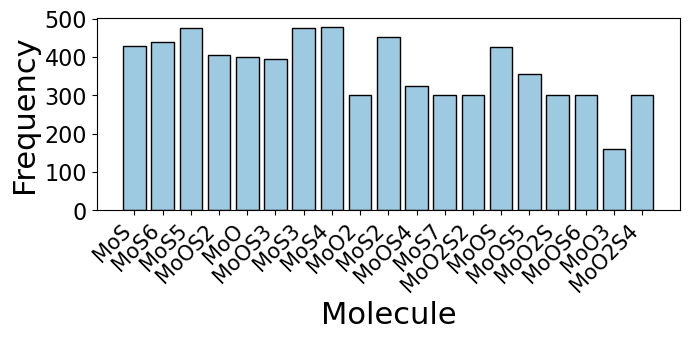

In [18]:
from tkinter import font
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ÂÅáËÆæsecond_feature_intÊòØÂåÖÂê´Ê†áÁ≠æÁöÑÊï∞ÁªÑ
# ‰æãÂ¶Ç: second_feature_int = np.array([1, 2, 2, 3, 3, 3, 1, ...])
molecule = np.array([val for val in y_test[:,-1, 0]])
# ÁªüËÆ°ÊØè‰∏™Ê†áÁ≠æÁöÑÈ¢ëÁéá
label_counts = Counter(molecule )

# ÊèêÂèñÊ†áÁ≠æÂíåÂØπÂ∫îÁöÑÈ¢ëÁéá
labels = list(label_counts.keys())
counts = list(label_counts.values())

# ÁªòÂà∂Êù°ÂΩ¢Âõæ
plt.figure(figsize=(7, 3.5))
plt.bar(labels, counts, color='#9ECAE1', edgecolor='black')

# ËÆæÁΩÆxËΩ¥Ê†áÁ≠æÂÄæÊñú45Â∫¶
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=16)
# Ê∑ªÂä†Ê†áÈ¢òÂíåËΩ¥Ê†áÁ≠æ
# plt.title('Frequency of Each Label')
plt.xlabel('Molecule',fontsize=22)
plt.ylabel('Frequency',fontsize=22)

# ÊòæÁ§∫ÁΩëÊ†º
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # Ëá™Âä®Ë∞ÉÊï¥Â∏ÉÂ±ÄÔºåÈÅøÂÖçÊ†áÁ≠æË¢´Êà™Êñ≠
plt.show()

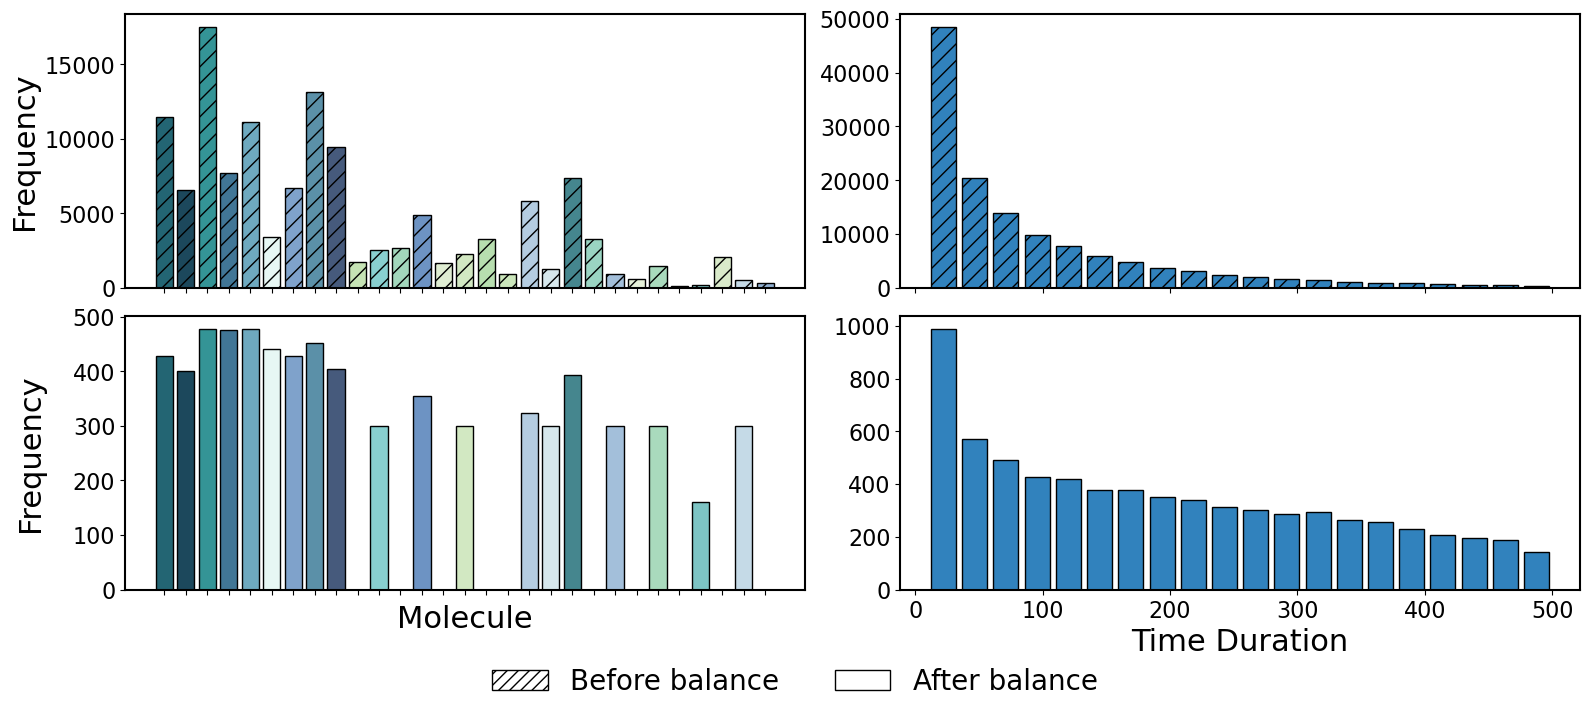

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches
import seaborn as sns

color1 = '#8DD66B'
color2 = '#3182BD'#'#9ECAE1'

import matplotlib.colors as mcolors

# ÂéüÂßã color_dict
color_dict_hy = {
    "MoO": "#0077b6",        # Ê∑±Êµ∑Ëìù
    "MoOS2": "#00b4d8",      # ÈùíËìù
    "MoS": "#48cae4",        # ÊµÖËìù
    "MoS3": "#90e0ef",       # ÈõæËìù
    "MoS5": "#ade8f4",       # ÂÜ∞Ëìù
    "MoO5": "#caf0f8",       # Ê∑°Ê∞¥Ëìù
    "MoOS3": "#007f5f",      # Ê∑±Áªø
    "MoS2": "#2b9348",       # Êµ∑ËçâÁªø
    "MoS4": "#55a630",       # ÈùíÁªø
    "Mo3O9S2": "#80b918",    # ÈùíÈªÑ
    "MoO3": "#ff7b00",       # ÁèäÁëöÊ©ô
    "MoO2": "#ffb703",       # Èò≥ÂÖâÊ©ô
    "Mo3O9": "#023e8a",      # ÂÆùËìù
    "Mo2S7": "#007f7f",      # ÈùíËìùÁÅ∞
    "Mo2S8": "#0096c7",      # Â§©Ëìù
    "MoO2S": "#00b4d8",      # ÂÜçÊµÖËìù
    "Mo2S2": "#48cae4",      # Ê∑°Ëìù
    "Mo2S6": "#90e0ef",      # ÈõæËìù
    "MoO5S": "#ade8f4",      # ÂÜ∞Ëìù
    "Mo": "#023047",         # Ê∑±Êµ∑Ëìù
    "Mo2S10": "#219ebc",     # ÂÆùÁü≥Ëìù
    "MoOS6": "#8ecae6",      # ÊµÖÊµ∑Ëìù
    "Mo2S5": "#0077b6",      # Êµ∑Ëìù
    "Mo2S9": "#00b4d8",      # ÈùíËìù
    "MoO2S5": "#48cae4",     # ÊµÖËìù
    "Mo2S4": "#90e0ef",      # ÈõæËìù
    "MoO2S7": "#ade8f4",     # ÂÜ∞Ëìù
    "Mo2S3": "#00b4d8",      # ÈùíËìù
    "MoS6": "#48cae4",       # ÊµÖËìù
    "MoS7": "#90e0ef",       # ÈõæËìù
    "MoO2S4": "#caf0f8",     # Ê∑°Ê∞¥Ëìù
    "MoOS4": "#007f5f",      # Ê∑±Áªø
    "MoO2S2": "#2b9348",     # Êµ∑ËçâÁªø
    "MoO2S3": "#55a630",     # ÈùíÁªø
    "MoOS": "#80b918",       # ÈùíÈªÑ
    "MoOS5": "#ff7b00",      # ÁèäÁëöÊ©ô
    "MoOS7": "#ffb703"       # Èò≥ÂÖâÊ©ô
}

color_dict = {
    "MoO":     "#003f5c", "MoOS2":   "#2f4b7c", "MoS":     "#005f73",
    "MoS3":    "#0a9396", "MoS5":    "#1d6996", "MoO5":    "#2a9d8f",
    "MoOS3":   "#26828e", "MoS2":    "#3a86a8", "MoS4":    "#4b9fbf",
    "Mo3O9S2": "#57a7b3", "MoO3":    "#5ec4c4", "MoO2":    "#6acfcf",
    "Mo3O9":   "#76d1c4", "Mo2S7":   "#81d4bb", "Mo2S8":   "#8bd7b1",
    "MoO2S":   "#94dab1", "Mo2S2":   "#9bdba4", "Mo2S6":   "#a6de9b",
    "MoO5S":   "#b1e197", "Mo":      "#b8e3a0", "Mo2S10":  "#c0e6a8",
    "MoOS6":   "#c9e8b1", "Mo2S5":   "#d2eabc", "Mo2S9":   "#d9edc6",
    "MoO2S5":  "#e0f0ce", "Mo2S4":   "#e6f2d7", "MoO2S7":  "#ebf4de",
    "Mo2S3":   "#f0f6e4", "MoS6":    "#e0f7f3", "MoS7":    "#cce5ec",
    "MoO2S4":  "#b7d4e7", "MoOS4":   "#a1c3e0", "MoO2S2":  "#8cb3da",
    "MoO2S3":  "#75a1d2", "MoOS":    "#5e90cb", "MoOS5":   "#487fc3",
    "MoOS7":   "#316ebb"
}

color_dict2 = {
    # ËìùÁ≥ªÔºàÊ∑±‚ÜíÊµÖÔºâ
    "MoO":     "#2F5D8C",
    "Mo2S10":  "#3C6FA3",
    "Mo2S3":   "#4C7FB5",
    "Mo3O9":   "#5E8FC7",
    "MoO2S":   "#7FA6CF",
    "MoS6":    "#94B8D9",
    "MoO2S2":  "#A7C6E0",

    # ÁªøÁ≥ªÔºàÊ∑±‚ÜíÊµÖÔºâ
    "MoOS2":   "#2F6F4E",
    "Mo2S7":   "#3E855E",
    "Mo2S6":   "#4E9C6E",
    "MoO5":    "#5FAE7D",
    "Mo2S4":   "#7FBF8F",
    "MoS7":    "#94CDA0",
    "MoO2S3":  "#A8D9B3",

    # ÈªÑÁ≥ªÔºàÊ∑±‚ÜíÊµÖÔºâ
    "MoS":     "#A0741A",
    "MoO3":    "#B6892C",
    "Mo2S8":   "#CFA63D",
    "MoO2S7":  "#DAB757",
    "MoO2S4":  "#E3C87A",
    "MoO5S":   "#ECD89B",
    "MoOS":    "#F1E1B3",

    # Á¥´Á≥ªÔºàÊ∑±‚ÜíÊµÖÔºâ
    "MoS3":    "#603B8B",
    "Mo2S2":   "#724E9B",
    "MoOS3":   "#8A6FAD",
    "Mo2S9":   "#9A84B8",
    "MoOS5":   "#B09BC8",
    "MoOS7":   "#C3AFD4",
    "MoS4":    "#D2C1DE",

    # È¢ùÂ§ñÂàÜÂ≠êÂàÜÈÖçÂâ©‰ΩôÂ±ÇÊ¨°Ôºà‰øùÊåÅËâ≤Á≥ªÂùáË°°Ôºâ
    "MoS5":    "#5687B0",
    "Mo3O9S2": "#65A07C",
    "MoO2":    "#D0B05B",
    "Mo":      "#A687C2",
    "MoOS6":   "#7FB58A",
    "Mo2S5":   "#BE9F43",
    "MoO2S5":  "#C6A64D",
    "MoOS4":   "#B8A0CC"
}

color_dict2 = {
    "MoO":     "#4C8CBF",  # Ê∑±Ëìù
    "MoOS2":   "#5FA8A8",  # ÈùíËìù
    "MoS":     "#7FA9C4",  # ÊµÖËìù
    "MoS3":    "#9AAFCF",  # ÁÅ∞Ëìù
    "MoS5":    "#6F9FBF",  # ËìùÁÅ∞
    "MoO5":    "#A1B8C4",  # ÊµÖÁÅ∞Ëìù
    "MoOS3":   "#8CA2B8",  # ÈùíÁÅ∞
    "MoS2":    "#B0B0B0",  # ‰∏≠ÁÅ∞
    "MoS4":    "#7F8FB3",  # ÁÅ∞Á¥´
    "Mo3O9S2": "#5C92A5",  # Ê∑±Èùí
    "MoO3":    "#9EB0C2",
    "MoO2":    "#7AA6B5",
    "Mo3O9":   "#6B95A8",
    "Mo2S7":   "#8A9EC0",
    "Mo2S8":   "#6B8FB0",
    "MoO2S":   "#A4BAC4",
    "Mo2S2":   "#7D8FB7",
    "Mo2S6":   "#A9A9A9",
    "MoO5S":   "#7FA7B2",
    "Mo":      "#5F87A2",
    "Mo2S10":  "#6C94AC",
    "MoOS6":   "#93ACBC",
    "Mo2S5":   "#7B8CB0",
    "Mo2S9":   "#6F95A7",
    "MoO2S5":  "#8EA7B7",
    "Mo2S4":   "#5E8DA8",
    "MoO2S7":  "#7C96AB",
    "Mo2S3":   "#4F88C4",
    "MoS6":    "#7E90B8",
    "MoS7":    "#6D9BA8",
    "MoO2S4":  "#90A6B8",
    "MoOS4":   "#8090AA",
    "MoO2S2":  "#9CC0C0",
    "MoO2S3":  "#6C9FB0",
    "MoOS":    "#A0B2B8",
    "MoOS5":   "#8FA1B0",
    "MoOS7":   "#9BA8BA"
}

color_dict0 = {
    "MoO":     "#8DD3C7",
    "MoOS2":   "#FDB462",
    "MoS":     "#B3DE69",
    "MoS3":    "#FB8072",
    "MoS5":    "#80B1D3",
    "MoO5":    "#FFFFB3",
    "MoOS3":   "#FCCDE5",
    "MoS2":    "#D9D9D9",
    "MoS4":    "#BC80BD",
    "Mo3O9S2": "#CCEBC5",
    "MoO3":    "#FFD700",
    "MoO2":    "#FFA07A",
    "Mo3O9":   "#98FB98",
    "Mo2S7":   "#FF69B4",
    "Mo2S8":   "#87CEFA",
    "MoO2S":   "#FFE4B5",
    "Mo2S2":   "#9370DB",
    "Mo2S6":   "#C0C0C0",
    "MoO5S":   "#ADFF2F",
    "Mo":      "#FF6347",
    "Mo2S10":  "#4682B4",
    "MoOS6":   "#FFDAB9",
    "Mo2S5":   "#BA55D3",
    "Mo2S9":   "#9ACD32",
    "MoO2S5":  "#FFA500",
    "Mo2S4":   "#7FFFD4",
    "MoO2S7":  "#FF4500",
    "Mo2S3":   "#1E90FF",
    "MoS6":    "#DA70D6",
    "MoS7":    "#32CD32",
    "MoO2S4":  "#FFB347",
    "MoOS4":   "#FF6961",
    "MoO2S2":  "#77DD77",
    "MoO2S3":  "#AEC6CF",
    "MoOS":    "#FFD1DC",
    "MoOS5":   "#CBAACB",
    "MoOS7":   "#F49AC2"
}
color_dict0 = {
    "MoO":     "#5DA5A4",
    "MoOS2":   "#E0A458",
    "MoS":     "#91B86C",
    "MoS3":    "#D97A7A",
    "MoS5":    "#6C9ACF",
    "MoO5":    "#E6E29B",
    "MoOS3":   "#D8A8C2",
    "MoS2":    "#B7B7B7",
    "MoS4":    "#9D7FB3",
    "Mo3O9S2": "#A5C7B1",
    "MoO3":    "#D5B556",
    "MoO2":    "#E3A88A",
    "Mo3O9":   "#9FCB9F",
    "Mo2S7":   "#DB88B4",
    "Mo2S8":   "#8AB6D6",
    "MoO2S":   "#E2C28C",
    "Mo2S2":   "#8D85C6",
    "Mo2S6":   "#BFBFBF",
    "MoO5S":   "#A7CF78",
    "Mo":      "#D9826A",
    "Mo2S10":  "#5F87A2",
    "MoOS6":   "#E6C5A3",
    "Mo2S5":   "#A882C9",
    "Mo2S9":   "#92B562",
    "MoO2S5":  "#D2A158",
    "Mo2S4":   "#7FBFB5",
    "MoO2S7":  "#D0714F",
    "Mo2S3":   "#4F88C4",
    "MoS6":    "#B58BCB",
    "MoS7":    "#7FB379",
    "MoO2S4":  "#DDA86F",
    "MoOS4":   "#D67F82",
    "MoO2S2":  "#9CCF9C",
    "MoO2S3":  "#94B6C6",
    "MoOS":    "#E4B7C0",
    "MoOS5":   "#B6A3B6",
    "MoOS7":   "#D6A4BE"
}
def desaturate_hex(hex_color, factor=0.5):
    """Èôç‰ΩéÈ•±ÂíåÂ∫¶ factor (0~1)"""
    rgb = mcolors.hex2color(hex_color)
    hsv = mcolors.rgb_to_hsv(rgb)
    hsv[1] *= factor  # Èôç‰ΩéÈ•±ÂíåÂ∫¶
    rgb_new = mcolors.hsv_to_rgb(hsv)
    return mcolors.to_hex(rgb_new)

# ÁîüÊàê‰ΩéÈ•±Âíå color_dict
color_dict = {mol: desaturate_hex(c, factor=0.7) for mol, c in color_dict.items()}




# --------------------------
# 1. ÂáÜÂ§áÂàÜÂ≠êÈ¢ëÁéáÊï∞ÊçÆ
# --------------------------
molecule1 = np.array([val for val in filtered_y[:, -1, 0]])
label_counts1 = Counter(molecule1)
labels1 = list(label_counts1.keys())
counts1 = list(label_counts1.values())

molecule2 = np.array([val for val in y_test[:, -1, 0]])
label_counts2 = Counter(molecule2)
labels2 = list(label_counts2.keys())
counts2 = list(label_counts2.values())

# --------------------------
# 2. ÂáÜÂ§áÊó∂Èó¥ÊåÅÁª≠Êï∞ÊçÆ
# --------------------------
time1 = np.array([int(val) for val in filtered_y[:, -1, 1]])
time2 = np.array([int(val) for val in y_test[:, -1, 1]])

# --------------------------
# 3. ÂàõÂª∫ÁªÑÂêàÂõæË°®
# --------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 7))

# ÂÆö‰πâËâ≤ÂùóÊ†áÁ≠æÔºàÂè™Âä†Ëâ≤ÂùóËæπÊ°ÜÔºâ
filtered_patch = mpatches.Patch(
    facecolor=color1, edgecolor="black", linewidth=1, label='Origin Data'
)
test_patch = mpatches.Patch(
    facecolor=color2, edgecolor="black", linewidth=1, label='Processed Data'
)

# ÂÅáËÆæ labels1 Âíå labels2 ÊòØ‰Ω†ÁöÑÂàÜÂ≠êÂàóË°®
colors1 = [color_dict.get(mol, "#D3D3D3") for mol in labels1]  # Â¶ÇÊûúÁº∫Â§±ÔºåÈªòËÆ§ÁÅ∞Ëâ≤
colors2 = [color_dict.get(mol, "#D3D3D3") for mol in labels2]

# --------------------------
# 4. ÁªòÂà∂ÂàÜÂ≠êÈ¢ëÁéáÊù°ÂΩ¢ÂõæÔºà‰∏äÊéíÔºâ
# --------------------------
axes[0, 0].bar(labels1, counts1, color=colors1, hatch='//', edgecolor='black')
# axes[0, 0].set_xlabel('Molecule', fontsize=22)
axes[0, 0].set_ylabel('Frequency', fontsize=22)
# axes[0, 0].tick_params(axis='x', rotation=45, labelsize=13)
axes[0, 0].set_xticklabels([])
axes[0, 0].tick_params(axis='y', labelsize=16)

# axes[1, 0].bar(labels2, counts2, color=colors2, edgecolor='black')
# # axes[1, 0].set_xlabel('Molecule', fontsize=22)
# # axes[1, 0].tick_params(axis='x', rotation=45, labelsize=13)
# axes[1, 0].set_xticklabels([])
# axes[1, 0].tick_params(axis='y', labelsize=16)
# axes[1, 0].set_ylabel('Frequency', fontsize=22)
# ‰ª•Â∑¶‰∏äËßí labels1 ‰∏∫Âü∫ÂáÜ
base_labels = labels1  # Â∑¶‰∏äËßíÁöÑÂàÜÂ≠êÈ°∫Â∫è

# 1Ô∏è‚É£ ÁîüÊàê‰∏é base_labels È°∫Â∫èÂåπÈÖçÁöÑ‰∏ãÂõæÊï∞ÊçÆ
aligned_counts2 = []
aligned_colors2 = []
for lab in base_labels:
    if lab in label_counts2:                 # ‰∏ãÂõæÊúâËøô‰∏™ÂàÜÂ≠ê
        aligned_counts2.append(label_counts2[lab])
        aligned_colors2.append(color_dict.get(lab, "#D3D3D3"))
    else:                                    # Ê≤°ÊúâÊï∞ÊçÆÂàôË°•0ÂíåÈªòËÆ§ÁÅ∞Ëâ≤
        aligned_counts2.append(0)
        aligned_colors2.append("#D3D3D3")

# 2Ô∏è‚É£ ÈáçÊñ∞ÁªòÂà∂Â∑¶‰∏ãËßíÊù°ÂΩ¢Âõæ
axes[1, 0].cla()  # Ê∏ÖÁ©∫ÂéüÂõæ
axes[1, 0].bar(base_labels, aligned_counts2,
               color=aligned_colors2, edgecolor='black', label='origin data')
axes[1, 0].set_xlabel('Molecule', fontsize=22)
axes[1, 0].set_ylabel('Frequency', fontsize=22, labelpad=20)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=13)
axes[1, 0].tick_params(axis='y', labelsize=16)
axes[1, 0].set_xticklabels([])
# --------------------------
# 5. ÁªòÂà∂Êó∂Èó¥ÊåÅÁª≠Áõ¥ÊñπÂõæÔºà‰∏ãÊéíÔºâ
# --------------------------
axes[0, 1].hist(time1, bins=20, color=color2, hatch='//', edgecolor='black', rwidth=0.8)
# axes[0, 1].set_xlabel('Time Duration', fontsize=22)
axes[0, 1].tick_params(axis='x', labelsize=16)
axes[0, 1].tick_params(axis='y', labelsize=16)
axes[0, 1].set_xticklabels([])
axes[1, 1].hist(time2, bins=20, color=color2, edgecolor='black', rwidth=0.8)
axes[1, 1].set_xlabel('Time Duration', fontsize=22)
axes[1, 1].tick_params(axis='x', labelsize=16)
axes[1, 1].tick_params(axis='y', labelsize=16)

# --------------------------
# 6. Ê∑ªÂä†Ëâ≤ÂùóÊ†áÁ≠æÔºàÂè™‰øùÁïôËâ≤ÂùóËæπÊ°ÜÔºâ
# --------------------------
# fig.legend(
#     handles=[filtered_patch, test_patch],
#     loc='lower center',
#     ncol=2, fontsize=20,
#     bbox_to_anchor=(0.5, -0.07),
#     frameon=False  # ÂéªÊéâÊï¥‰∏™ legend Â§ñÊ°Ü
# )
for ax in axes.flat:  # ÈÅçÂéÜÊâÄÊúâÂ≠êÂõæ
    for spine in ax.spines.values():  # spines ÂåÖÊã¨ 'top','bottom','left','right'
        spine.set_linewidth(1.5)     # ËÆæÁΩÆËæπÊ°ÜÁ≤óÁªÜ
# ----------- Áªü‰∏ÄÊ∑ªÂä†Âõæ‰æã -----------
origin_patch    = mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Before balance')
processed_patch = mpatches.Patch(facecolor='white', edgecolor='black',  label='After balance')

# Âè™ÈúÄË¶Å‰∏Ä‰∏™ÊÄªÂõæ‰æãÂç≥ÂèØÔºåÊîæÂú®Êï¥Âº†ÂõæÂ§ñÊàñÁ©∫ÁôΩÂ§Ñ
fig.legend(handles=[origin_patch, processed_patch],
           loc='lower center', bbox_to_anchor=(0.5, -0.07),
           ncol=2, fontsize=20, frameon=False)
# --------------------------
# 7. Â∏ÉÂ±Ä‰ºòÂåñ
# --------------------------
plt.tight_layout()
plt.subplots_adjust(top=0.94)

plt.show()


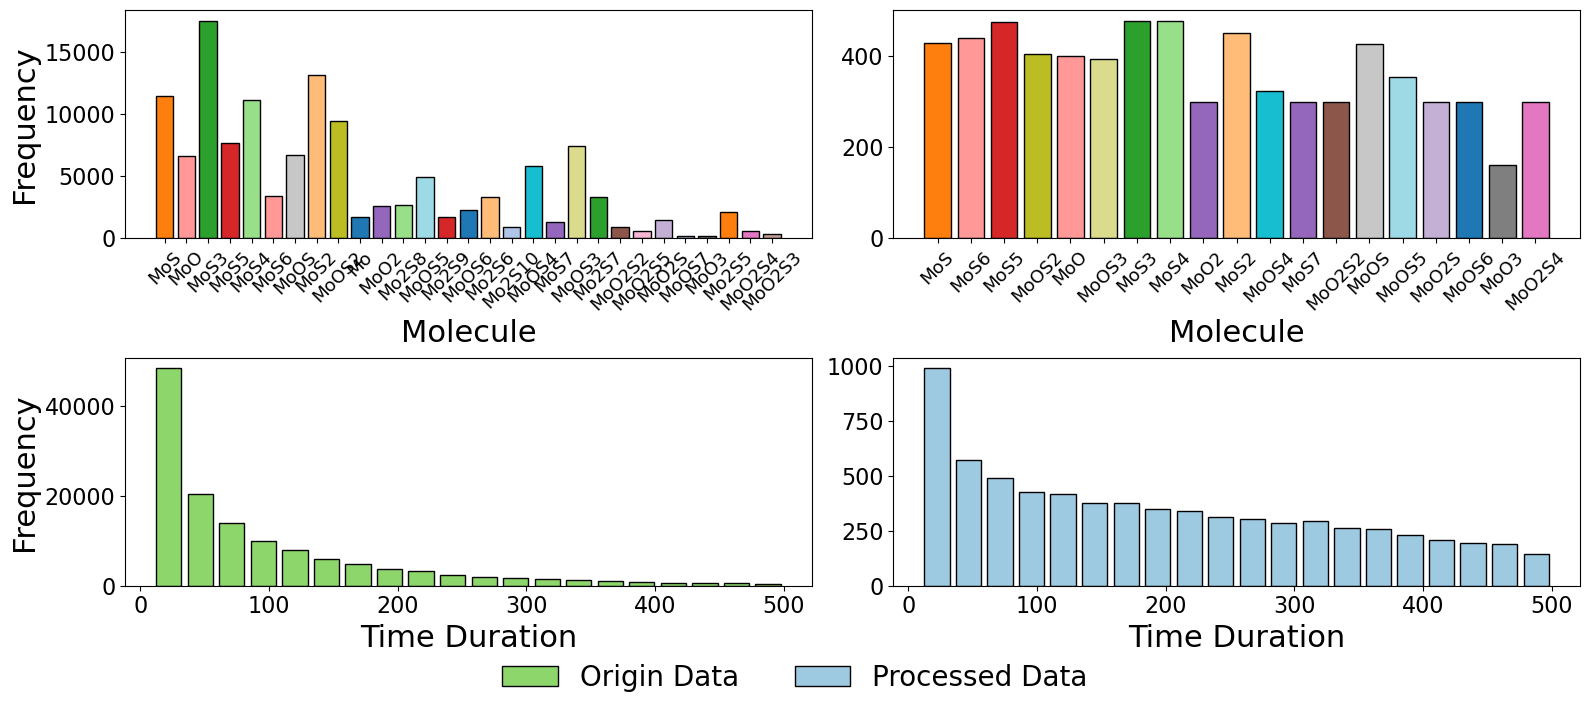

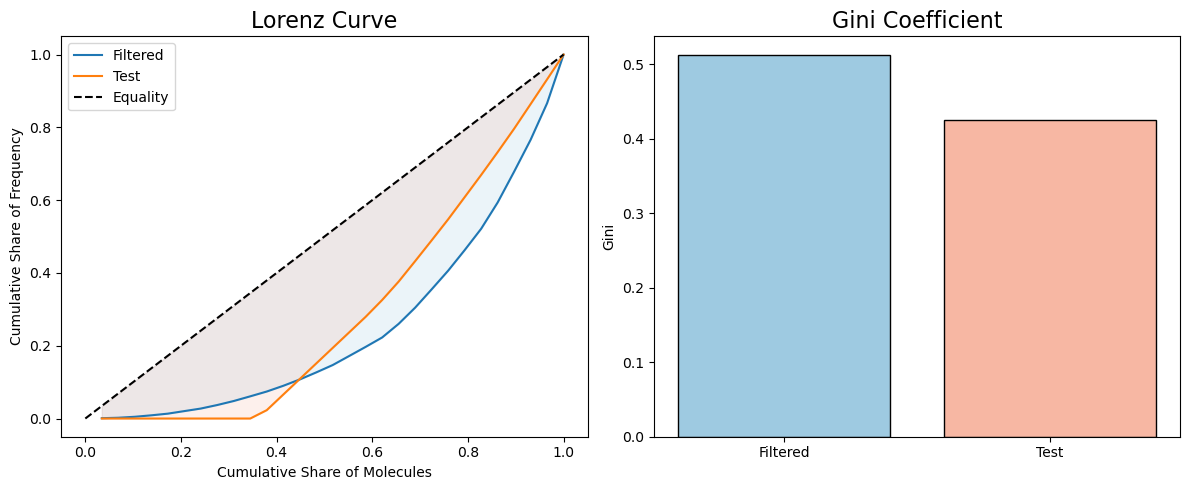

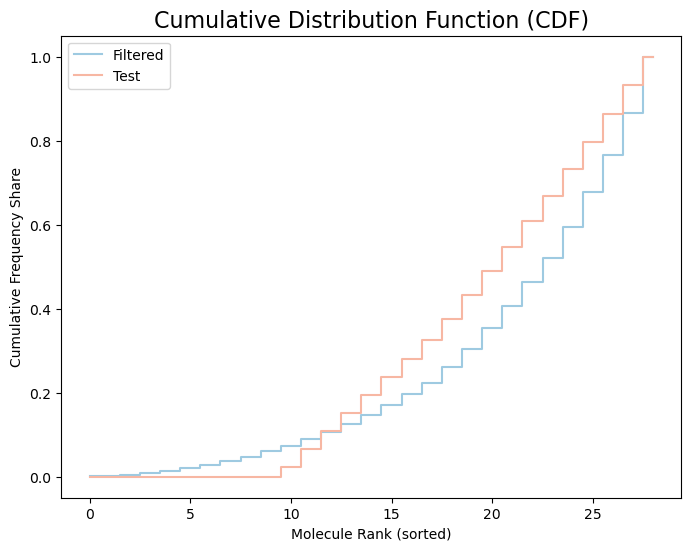

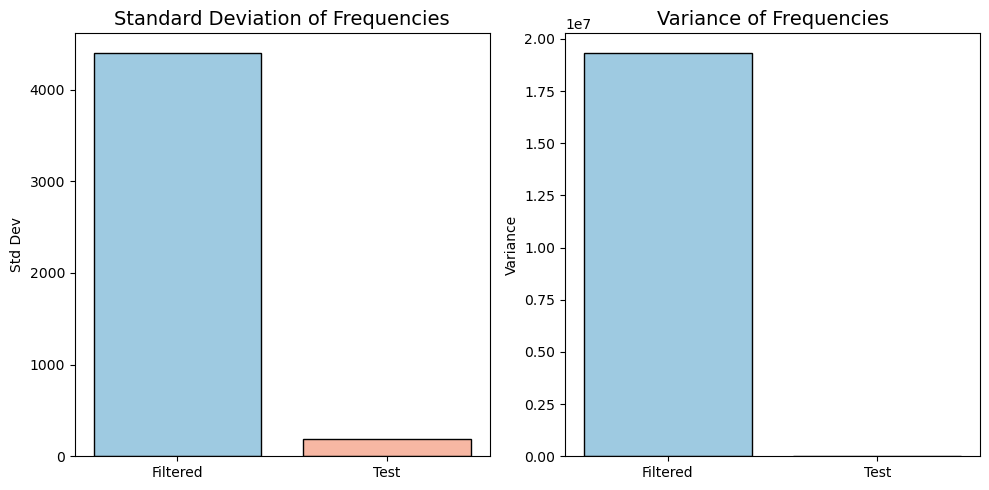

C:\Users\dfgje\AppData\Local\Temp\ipykernel_18052\4122774795.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Filtered", "Test"])


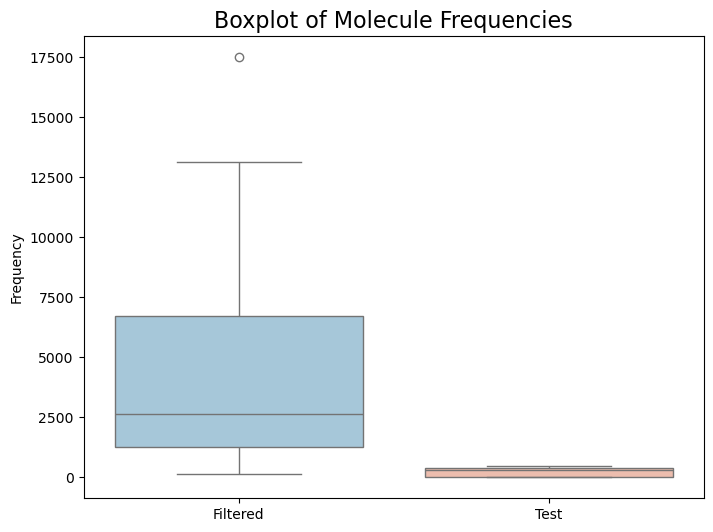

KL(P||Q) = inf
KL(Q||P) = 0.4148
JS Divergence = 0.0966


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.stats import entropy
import seaborn as sns

# --------------------------
# 1. ÂáÜÂ§áÂàÜÂ≠êÈ¢ëÁéáÊï∞ÊçÆ
# --------------------------
# ‰ªéfiltered_yÊèêÂèñÂàÜÂ≠êÊ†áÁ≠æÂπ∂ÁªüËÆ°È¢ëÁéá
molecule1 = np.array([val for val in filtered_y[:, -1, 0]])
label_counts1 = Counter(molecule1)
labels1 = list(label_counts1.keys())
counts1 = np.array(list(label_counts1.values()))

# ‰ªéy_testÊèêÂèñÂàÜÂ≠êÊ†áÁ≠æÂπ∂ÁªüËÆ°È¢ëÁéá
molecule2 = np.array([val for val in y_test[:, -1, 0]])
label_counts2 = Counter(molecule2)
labels2 = list(label_counts2.keys())
counts2 = np.array(list(label_counts2.values()))

# Á°Æ‰øùÈ°∫Â∫è‰∏ÄËá¥ÔºàÊåâÂàÜÂ≠êÂêçÁß∞ÊéíÂ∫èÔºâ
labels = sorted(set(labels1) | set(labels2))
counts1 = np.array([label_counts1.get(l, 0) for l in labels])
counts2 = np.array([label_counts2.get(l, 0) for l in labels])

# --------------------------
# 2. Gini Á≥ªÊï∞ & Lorenz Êõ≤Á∫ø
# --------------------------
def gini_coefficient(x):
    """ËÆ°ÁÆó Gini Á≥ªÊï∞"""
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    return gini

gini1 = gini_coefficient(counts1)
gini2 = gini_coefficient(counts2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for counts, color, name in [(counts1, "#9ECAE1", "Filtered"), (counts2, "#F7B7A3", "Test")]:
    sorted_counts = np.sort(counts)
    cum_counts = np.cumsum(sorted_counts) / np.sum(sorted_counts)
    cum_pop = np.arange(1, len(counts) + 1) / len(counts)
    ax[0].plot(cum_pop, cum_counts, label=f"{name}")
    ax[0].fill_between(cum_pop, cum_counts, cum_pop, alpha=0.2, color=color)
ax[0].plot([0, 1], [0, 1], 'k--', label="Equality")
ax[0].set_title("Lorenz Curve", fontsize=16)
ax[0].set_xlabel("Cumulative Share of Molecules")
ax[0].set_ylabel("Cumulative Share of Frequency")
ax[0].legend()

ax[1].bar(["Filtered", "Test"], [gini1, gini2], color=["#9ECAE1", "#F7B7A3"], edgecolor="black")
ax[1].set_title("Gini Coefficient", fontsize=16)
ax[1].set_ylabel("Gini")

plt.tight_layout()
plt.show()

# --------------------------
# 3. Á¥ØÁßØÂàÜÂ∏ÉÂáΩÊï∞ (CDF)
# --------------------------
fig, ax = plt.subplots(figsize=(8, 6))
for counts, color, name in [(counts1, "#9ECAE1", "Filtered"), (counts2, "#F7B7A3", "Test")]:
    sorted_counts = np.sort(counts)
    cdf = np.cumsum(sorted_counts) / np.sum(sorted_counts)
    ax.step(range(len(sorted_counts)), cdf, where="mid", label=name, color=color)
ax.set_title("Cumulative Distribution Function (CDF)", fontsize=16)
ax.set_xlabel("Molecule Rank (sorted)")
ax.set_ylabel("Cumulative Frequency Share")
ax.legend()
plt.show()

# --------------------------
# 4. ÊñπÂ∑Æ/Ê†áÂáÜÂ∑ÆÂØπÊØî
# --------------------------
std1, std2 = np.std(counts1), np.std(counts2)
var1, var2 = np.var(counts1), np.var(counts2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(["Filtered", "Test"], [std1, std2], color=["#9ECAE1", "#F7B7A3"], edgecolor="black")
ax[0].set_title("Standard Deviation of Frequencies", fontsize=14)
ax[0].set_ylabel("Std Dev")

ax[1].bar(["Filtered", "Test"], [var1, var2], color=["#9ECAE1", "#F7B7A3"], edgecolor="black")
ax[1].set_title("Variance of Frequencies", fontsize=14)
ax[1].set_ylabel("Variance")

plt.tight_layout()
plt.show()

# --------------------------
# 5. ÁÆ±Á∫øÂõæ (Boxplot)
# --------------------------
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=[counts1, counts2], palette=["#9ECAE1", "#F7B7A3"])
ax.set_xticklabels(["Filtered", "Test"])
ax.set_title("Boxplot of Molecule Frequencies", fontsize=16)
ax.set_ylabel("Frequency")
plt.show()

# --------------------------
# 6. KL Êï£Â∫¶ / JS Êï£Â∫¶
# --------------------------
# ËΩ¨Êç¢‰∏∫Ê¶ÇÁéáÂàÜÂ∏É
p = counts1 / counts1.sum()
q = counts2 / counts2.sum()

kl_pq = entropy(p, q)  # KL(P||Q)
kl_qp = entropy(q, p)  # KL(Q||P)
js = 0.5 * (entropy(p, (p+q)/2) + entropy(q, (p+q)/2))

print(f"KL(P||Q) = {kl_pq:.4f}")
print(f"KL(Q||P) = {kl_qp:.4f}")
print(f"JS Divergence = {js:.4f}")


C:\Users\dfgje\AppData\Local\Temp\ipykernel_18052\1061740225.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\dfgje\AppData\Local\Temp\ipykernel_18052\1061740225.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


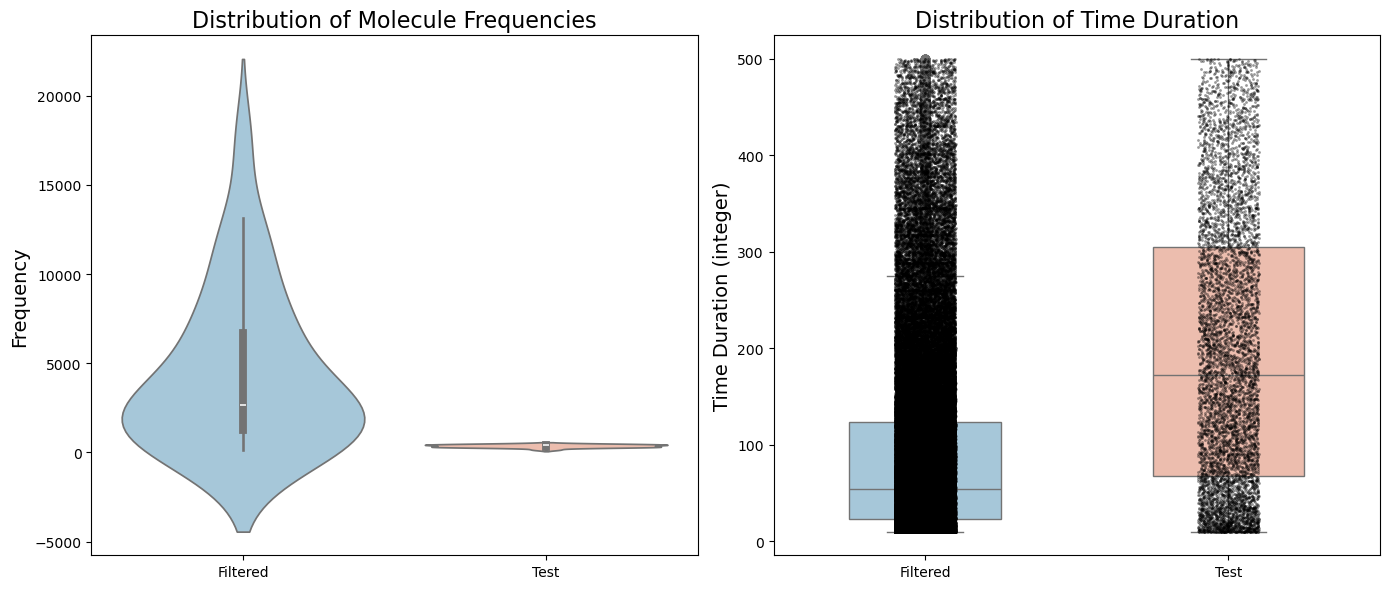

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --------------------------
# 1. Molecule Frequency Êï∞ÊçÆ
# --------------------------
df_freq1 = pd.DataFrame({"Value": counts1, "Dataset": "Filtered"})
df_freq2 = pd.DataFrame({"Value": counts2, "Dataset": "Test"})
df_freq = pd.concat([df_freq1, df_freq2])
df_freq["Type"] = "Molecule Frequency"

# --------------------------
# 2. Time Duration Êï∞ÊçÆÔºàÊï¥Êï∞Ôºâ
# --------------------------
df_time1 = pd.DataFrame({"Value": time1, "Dataset": "Filtered"})
df_time2 = pd.DataFrame({"Value": time2, "Dataset": "Test"})
df_time = pd.concat([df_time1, df_time2])
df_time["Type"] = "Time Duration"

# --------------------------
# 3. ÁªòÂà∂Â≠êÂõæÔºöÂ∑¶Ëæπ MoleculeÔºåÂè≥Ëæπ Time
# --------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)

# Molecule FrequencyÔºöÁî® Violin + Boxplot
sns.violinplot(
    x="Dataset", y="Value", data=df_freq,
    palette=["#9ECAE1", "#F7B7A3"], inner="box", ax=axes[0]
)
axes[0].set_title("Distribution of Molecule Frequencies", fontsize=16)
axes[0].set_xlabel("")
axes[0].set_ylabel("Frequency", fontsize=14)

# Time DurationÔºöÁî® Boxplot + stripplot
sns.boxplot(
    x="Dataset", y="Value", data=df_time,
    palette=["#9ECAE1", "#F7B7A3"], width=0.5, ax=axes[1]
)
sns.stripplot(
    x="Dataset", y="Value", data=df_time,
    color="black", alpha=0.4, size=2, jitter=True, ax=axes[1]
)
axes[1].set_title("Distribution of Time Duration", fontsize=16)
axes[1].set_xlabel("")
axes[1].set_ylabel("Time Duration (integer)", fontsize=14)

# Ë∞ÉÊï¥Â∏ÉÂ±Ä
plt.tight_layout()
plt.show()


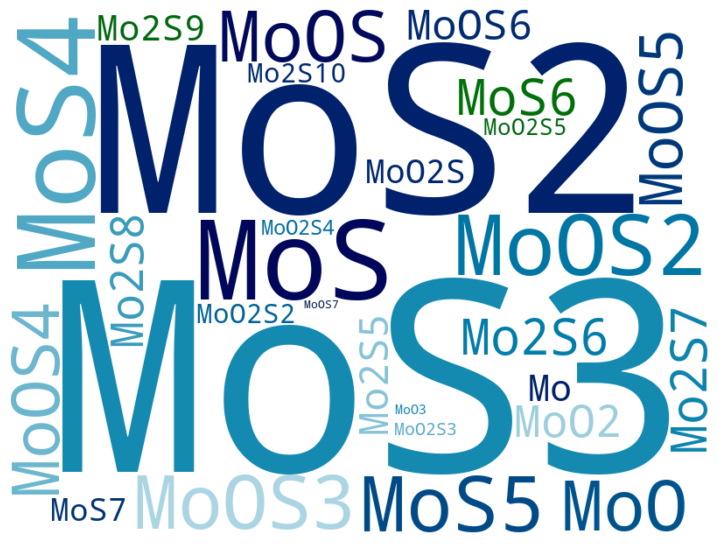

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ÂÅáËÆæsecond_feature_intÊòØÂåÖÂê´Êï¥Êï∞Ê†áÁ≠æÁöÑÊï∞ÁªÑ
# Â∞ÜÊï¥Êï∞Ê†áÁ≠æËΩ¨Êç¢‰∏∫Â≠óÁ¨¶‰∏≤
# str_labels = [str(label) for label in second_feature_int]

# ÁªüËÆ°ÊØè‰∏™Ê†áÁ≠æÁöÑÈ¢ëÁéá
label_counts = Counter(molecule1)

# ËΩ¨Êç¢‰∏∫ËØç‰∫ëÊâÄÈúÄÁöÑÂ≠óÂÖ∏Ê†ºÂºè {Ê†áÁ≠æ: È¢ëÁéá}
word_freq = dict(label_counts)

# ÂàõÂª∫ËØç‰∫ëÂØπË±°ÔºåËÆæÁΩÆÂèÇÊï∞
wordcloud = WordCloud(
    width=800,            # ÂÆΩÂ∫¶
    height=600,           # È´òÂ∫¶
    background_color='white',  # ËÉåÊôØËâ≤
    colormap='ocean',     # È¢úËâ≤ÊñπÊ°à
    max_words=50,         # ÊúÄÂ§ßÊòæÁ§∫ËØçÊï∞
    contour_width=1,      # ËΩÆÂªìÂÆΩÂ∫¶
    contour_color='steelblue'  # ËΩÆÂªìÈ¢úËâ≤
).generate_from_frequencies(word_freq)

# ÁªòÂà∂ËØç‰∫ëÂõæ
plt.figure(figsize=(7, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # ÂÖ≥Èó≠ÂùêÊ†áËΩ¥
# plt.title('Frequency of Molecules', fontsize=20)
plt.tight_layout(pad=0)  # Ë∞ÉÊï¥Â∏ÉÂ±Ä
plt.show()

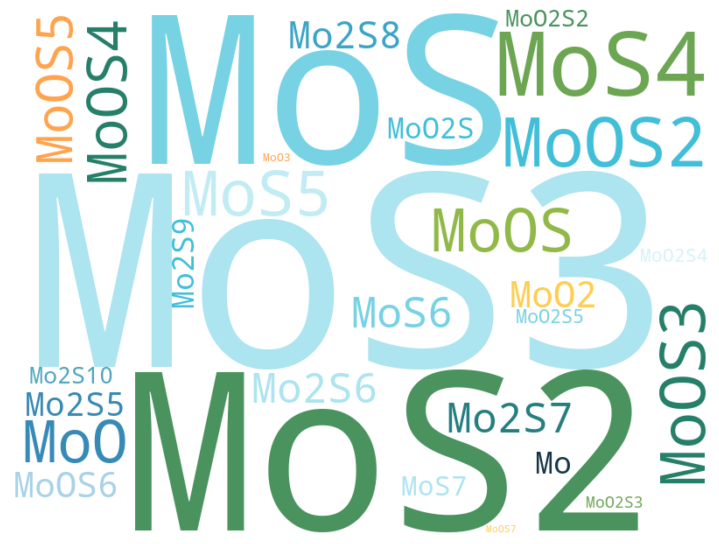

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# ÂÅáËÆæ molecule1 ÊòØ‰Ω†ÁöÑÂàÜÂ≠êÊ†áÁ≠æÂàóË°®
label_counts = Counter(molecule1)
word_freq = dict(label_counts)

# Ëá™ÂÆö‰πâ color_func
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # Â¶ÇÊûúÂ≠óÂÖ∏ÈáåÊ≤°ÊúâËØ•ÂàÜÂ≠êÔºåÈªòËÆ§ÈªëËâ≤
    return color_dict.get(word, "#000000")  

# ÂàõÂª∫ËØç‰∫ëÂØπË±°
wordcloud = WordCloud(
    width=800,
    height=600,
    background_color='white',
    max_words=50,
    contour_width=1,
    contour_color='steelblue'
).generate_from_frequencies(word_freq)

# Â∞ÜËá™ÂÆö‰πâÈ¢úËâ≤Â∫îÁî®Âà∞ËØç‰∫ë
wordcloud.recolor(color_func=color_func)

# ÁªòÂà∂ËØç‰∫ë
plt.figure(figsize=(7, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def balanced_sampling_for_y(X, y, bins=10, samples_per_formula=300, seed=42):
    """
    ÂàÜÂà´ÂØπ y ÁöÑ‰∏§‰∏™Áª¥Â∫¶Áã¨Á´ãÂπ≥Ë°°Ôºö
    - y[:, 0]ÔºöÂ≠óÁ¨¶‰∏≤Ê†áÁ≠æÔºàÂ¶ÇÂàÜÂ≠êÂºèÔºâÁ≠âÈáèÈááÊ†∑
    - y[:, 1]ÔºöÊï¥Êï∞ÔºàÊåÅÁª≠Êó∂Èó¥ÔºâÊ†áÁ≠æÂàÜÁÆ±ÂêéÂπ≥Ë°°

    ÂèÇÊï∞Ôºö
    - X: numpy array, shape (n_samples, 3, 2)
    - y: numpy array, shape (n_samples, 2)
    - bins: int, Áî®‰∫éÊåÅÁª≠Êó∂Èó¥ÁöÑÂàÜÁÆ±Êï∞Èáè
    - samples_per_formula: intÔºåÊØèÁßçÂåñÂ≠¶ÂºèÊúÄÂ§öÈááÊ†∑Êï∞Èáè
    - seed: int, ÈöèÊú∫ÁßçÂ≠ê

    ËøîÂõûÔºö
    - X_sampled, y_sampled
    """
    np.random.seed(seed)

    # Â∞Ü y ËΩ¨Êç¢‰∏∫ DataFrame
    formula = y[:, 0]
    durations = y[:, 1].astype(int)
    df = pd.DataFrame({
        "formula": formula,
        "duration": durations
    })

    # ===== 1. Âπ≥Ë°° durationÔºöÊåâ bins ÂàÜÁÆ±ÂêéÊØèÁªÑÂèñÊúÄÂ∞èÊ†∑Êú¨Êï∞ =====
    df['duration_bin'] = pd.cut(df['duration'], bins=bins, labels=False)
    min_count_duration = df['duration_bin'].value_counts().min()
    duration_sampled_idx = pd.concat([
        group.sample(min_count_duration, random_state=seed)
        for _, group in df.groupby('duration_bin')
    ]).index

    # ===== 2. Âπ≥Ë°° formulaÔºöÊØèÁ±ªÂèñ samples_per_formula ‰∏™ =====
    formula_sampled_idx = []
    for _, group in df.groupby("formula"):
        if len(group) <= samples_per_formula:
            sampled = group.index.tolist()
        else:
            sampled = group.sample(samples_per_formula, random_state=seed).index.tolist()
        formula_sampled_idx.extend(sampled)

    # ===== 3. ÂêàÂπ∂Á¥¢ÂºïÔºàÂèñÂπ∂ÈõÜÔºâ=====
    combined_indices = sorted(set(duration_sampled_idx).union(set(formula_sampled_idx)))

    # ===== 4. Ëé∑ÂèñÈááÊ†∑ÂêéÁöÑ X Âíå y =====
    X_sampled = X[combined_indices]
    y_sampled = y[combined_indices]

    # ===== 5. ÊâìÂç∞ÈááÊ†∑ÂêéÂàÜÂ∏É =====
    print(f"\nÊúÄÁªàÊ†∑Êú¨Êï∞: {len(y_sampled)}")
    print("\nüìä ÊåÅÁª≠Êó∂Èó¥ÔºàÂàÜÁÆ±ÂêéÔºâÂàÜÂ∏É:")
    print(pd.cut(df.loc[combined_indices, 'duration'], bins=bins, labels=False).value_counts().sort_index())
    print("\nüî¨ ÂåñÂ≠¶ÂºèÂàÜÂ∏É:")
    print(df.loc[combined_indices, 'formula'].value_counts())

    return X_sampled, y_sampled

# ===== Á§∫‰æãË∞ÉÁî® =====
X_sampled, y_sampled = balanced_sampling_for_y(
    filtered_X, filtered_y,
    bins=10,
    samples_per_formula=300,
    seed=42
)


ValueError: invalid literal for int() with base 10: 'MoS3'

In [ ]:
import numpy as np
import pandas as pd

# Â§ÑÁêÜ X Êï∞ÊçÆÔºåÊØè‰∏ÄË°åËΩ¨Êç¢‰∏∫ÊåáÂÆöÊ†ºÂºè
X_str = [";".join([f"({item[0]},{item[1]})" for item in row]) for row in X_test]
# X_str = [";".join([f"{str(item[0])}, {str(item[1])}, {str(item[2])}" for item in row]) for row in X]
# Â§ÑÁêÜ y Êï∞ÊçÆÔºåÊØè‰∏ÄË°åËΩ¨Êç¢‰∏∫ÊåáÂÆöÊ†ºÂºè
# y_str = [f"({str(row[0])},{str(row[1])})" for row in y]
y_str = [";".join([f"({item[0]},{item[1]})" for item in row]) for row in y_test]
# y_str = [f"({item[0]},{item[1]})" for item in y_test] 
# ÂàõÂª∫ DataFrame
# X_str = np.concatenate(X_str)
# y_str = np.concatenate(y_str)
# # y_str = np.concatenate(y_str)
df = pd.DataFrame({"X": X_str, "y": y_str})
print(len(X_str), len(y_str))
# # ÂØºÂá∫ CSV

df.to_csv("average_data_s3.csv", index=False)

print("CSV Êñá‰ª∂Â∑≤ÂØºÂá∫")


7015 7015
CSV Êñá‰ª∂Â∑≤ÂØºÂá∫


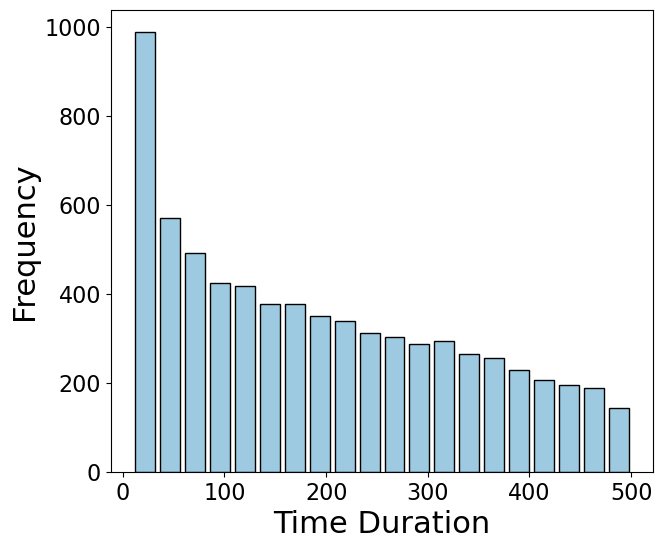

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# second_feature_int = np.array([int(val) for val in y[:, 1]])
second_feature_int = np.array([int(val) for val in y_test[:,-1, 1]])
# ‰ΩøÁî®MatplotlibÁªòÂà∂Áõ¥ÊñπÂõæ
plt.figure(figsize=(7, 6))
plt.hist(second_feature_int, bins=20, color='#9ECAE1', edgecolor='black', rwidth=0.8)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('Histogram of y_train')
plt.xlabel('Time Duration', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
# plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# ËΩ¨Êç¢Êàê DataFrame Êñπ‰æøÂ§ÑÁêÜ
y_df = pd.DataFrame(filtered_y, columns=['formula', 'label'])  # 'label' ÊòØ y ÁöÑÁ¨¨‰∫åÂàó
y_df['label'] = y_df['label'].astype(int)  # Á°Æ‰øùÊòØÊï¥Êï∞

# Êü•ÁúãÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨Êï∞
label_counts = y_df['label'].value_counts()
print("ÂéüÂßãÂêÑÁ±ªÂà´Ê†∑Êú¨Êï∞Ôºö")
print(label_counts)

# Á°ÆÂÆöÂèØ‰ª•ÊäΩÊ†∑ÁöÑÊúÄÂ§ßÊ†∑Êú¨Êï∞Ôºà‰æãÂ¶ÇÊØè‰∏™ label Ëá≥Â∞ëÊúâ 500 ‰∏™ÔºåÊàë‰ª¨Â∞±ËÉΩ‰ªéÊØè‰∏™ÈáåÊäΩ 500 ‰∏™Ôºâ
min_count = label_counts.min()
print(f"\nÂ∞Ü‰ªéÊØèÁ±ª‰∏≠ÊäΩÂèñ {min_count} ‰∏™Ê†∑Êú¨‰ΩøÂàÜÂ∏ÉÂ∞ΩÈáèÂπ≥Ë°°")

# Êî∂ÈõÜÊäΩÊ†∑ÁöÑÁ¥¢Âºï
sampled_indices = []

for label_value in label_counts.index:
    indices = y_df[y_df['label'] == label_value].index
    sampled = np.random.choice(indices, min_count, replace=False)
    sampled_indices.extend(sampled)

# ÂæóÂà∞Âπ≥Ë°°ÂêéÁöÑÊ†∑Êú¨
X_balanced = filtered_X[sampled_indices]
y_balanced = filtered_y[sampled_indices]


ÂéüÂßãÂêÑÁ±ªÂà´Ê†∑Êú¨Êï∞Ôºö
label
10     3086
11     3027
12     2630
13     2531
14     2208
       ... 
486       8
485       8
491       8
429       8
479       2
Name: count, Length: 491, dtype: int64

Â∞Ü‰ªéÊØèÁ±ª‰∏≠ÊäΩÂèñ 2 ‰∏™Ê†∑Êú¨‰ΩøÂàÜÂ∏ÉÂ∞ΩÈáèÂπ≥Ë°°


In [ ]:
y_balanced.shape

(982, 2)

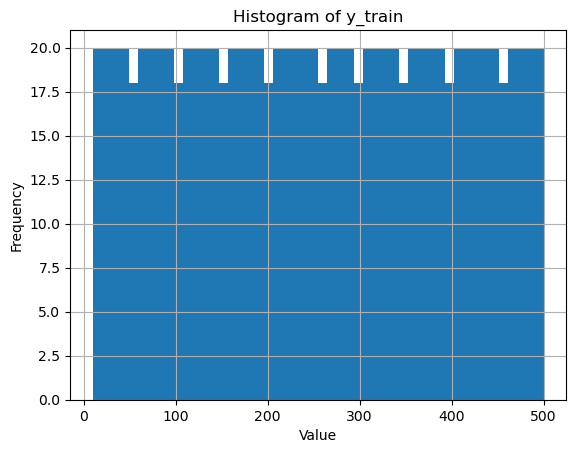

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
second_feature_int = np.array([int(val) for val in y_balanced[:, 1]])
# ‰ΩøÁî®MatplotlibÁªòÂà∂Áõ¥ÊñπÂõæ
plt.hist(second_feature_int, bins=50)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

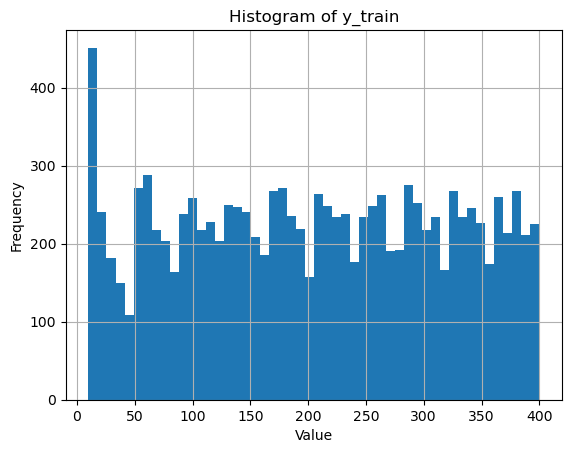

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
second_feature_int = np.array([int(val) for val in y_sampled[:, 1]])
# ‰ΩøÁî®MatplotlibÁªòÂà∂Áõ¥ÊñπÂõæ
plt.hist(second_feature_int, bins=50)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# ÊûÑÂª∫ DataFrame
y_df = pd.DataFrame(filtered_y, columns=['formula', 'label'])
y_df['label'] = y_df['label'].astype(int)  # Á°Æ‰øùÊòØÊï¥Êï∞

# ‰ΩøÁî® pd.cut ÂàÜÊàê 10 ÁªÑ
y_df['group'] = pd.cut(y_df['label'], bins=10, labels=False)
# y_df['group'] = pd.qcut(y_df['label'], q=10, labels=False, duplicates='drop')
# Êü•ÁúãÊØèÁªÑÁöÑÊ†∑Êú¨Êï∞Èáè
group_counts = y_df['group'].value_counts().sort_index()
print("ÊØèÁªÑÂéüÂßãÊ†∑Êú¨Êï∞ÈáèÔºö")
print(group_counts)

# ÂÜ≥ÂÆöÊØèÁªÑÂèØ‰ª•ÊäΩÂèñÁöÑÊúÄÂ∞èÊï∞Èáè
min_count = group_counts.min()
print(f"\nÊØèÁªÑÂ∞ÜÊäΩÂèñ {min_count} ‰∏™Ê†∑Êú¨")

# ÊäΩÊ†∑
sampled_indices = []

for group_id in range(10):
    indices = y_df[y_df['group'] == group_id].index
    sampled = np.random.choice(indices, min_count, replace=False)
    sampled_indices.extend(sampled)

# ÂæóÂà∞ÂùáÂåÄÊäΩÊ†∑ÂêéÁöÑÊï∞ÊçÆ
X_sampled = filtered_X[sampled_indices]
y_sampled = filtered_y[sampled_indices]

# Ê£ÄÊü•Âπ≥Ë°°ÊÉÖÂÜµ
print("\nÂπ≥Ë°°ÂêéÊØèÁªÑÊ†∑Êú¨Êï∞Ôºö")
print(pd.DataFrame(y_sampled, columns=['formula', 'label']).assign(
    group=pd.cut(pd.to_numeric(y_sampled[:, 1]), bins=10, labels=False)
)['group'].value_counts().sort_index())


ÊØèÁªÑÂéüÂßãÊ†∑Êú¨Êï∞ÈáèÔºö
group
0    52861
1    19704
2    12310
3     8201
4     5562
5     4035
6     2750
7     2126
8     1601
9     1146
Name: count, dtype: int64

ÊØèÁªÑÂ∞ÜÊäΩÂèñ 1146 ‰∏™Ê†∑Êú¨

Âπ≥Ë°°ÂêéÊØèÁªÑÊ†∑Êú¨Êï∞Ôºö
group
0    1146
1    1146
2    1146
3    1146
4    1146
5    1146
6    1146
7    1146
8    1146
9    1146
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd

# ÊûÑÂª∫ DataFrame
y_df = pd.DataFrame(y_test, columns=['formula', 'label'])
y_df['label'] = y_df['label'].astype(int)

# ÂàÜÊàêÊúÄÂ§ö 10 ÁªÑÔºåÈÅøÂÖçÈáçÂ§çËæπÁïåÊä•Èîô
y_df['group'] = pd.qcut(y_df['label'], q=10, labels=False, duplicates='drop')

# ÁªüËÆ°ÊØèÁªÑÊ†∑Êú¨Êï∞
group_counts = y_df['group'].value_counts().sort_index()
print("ÊØèÁªÑÂéüÂßãÊ†∑Êú¨Êï∞ÈáèÔºö")
print(group_counts)

# ÂèñÊúÄÂ∞èÁªÑ‰Ωú‰∏∫Âü∫ÂáÜÊäΩÊ†∑Êï∞
min_count = group_counts.min()
print(f"\nÊØèÁªÑÂ∞ÜÊäΩÂèñ {min_count} ‰∏™Ê†∑Êú¨")

# ÊäΩÊ†∑
sampled_indices = []

for group_id in group_counts.index:
    indices = y_df[y_df['group'] == group_id].index
    sampled = np.random.choice(indices, min_count, replace=False)
    sampled_indices.extend(sampled)

# ÂæóÂà∞ÂùáÂåÄÊäΩÊ†∑ÂêéÁöÑÊï∞ÊçÆ
X_sampled = X_test[sampled_indices]
y_sampled = y_test[sampled_indices]


ÊØèÁªÑÂéüÂßãÊ†∑Êú¨Êï∞ÈáèÔºö
group
0    1322
1     408
2     732
3     407
4     600
5     528
6     573
7     564
8     566
Name: count, dtype: int64

ÊØèÁªÑÂ∞ÜÊäΩÂèñ 407 ‰∏™Ê†∑Êú¨


In [ ]:
# ÂæóÂà∞ÂàÜÁªÑÊ†áÁ≠æÂíåÂå∫Èó¥ËæπÁïå
group_labels, bin_edges = pd.qcut(y_df['label'], q=10, labels=False, duplicates='drop', retbins=True)

# ÊõøÊç¢ group Âàó
y_df['group'] = group_labels

# ÊâìÂç∞Âå∫Èó¥ËæπÁïå
print("ÊØèÁªÑÁöÑÊï∞ÂÄºÂå∫Èó¥ÔºàÈó≠Âå∫Èó¥Â∑¶ÂºÄÂè≥Èó≠Ôºâ:")
for i in range(len(bin_edges)-1):
    print(f"ÁªÑ {i}: ({bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]")


ÊØèÁªÑÁöÑÊï∞ÂÄºÂå∫Èó¥ÔºàÈó≠Âå∫Èó¥Â∑¶ÂºÄÂè≥Èó≠Ôºâ:
ÁªÑ 0: (1.00, 2.00]
ÁªÑ 1: (2.00, 3.00]
ÁªÑ 2: (3.00, 6.00]
ÁªÑ 3: (6.00, 9.00]
ÁªÑ 4: (9.00, 17.00]
ÁªÑ 5: (17.00, 31.00]
ÁªÑ 6: (31.00, 67.00]
ÁªÑ 7: (67.00, 139.00]
ÁªÑ 8: (139.00, 2082.00]


In [ ]:
X_test.shape

(6138, 3, 2)

In [ ]:
import numpy as np
import pandas as pd

# Â§ÑÁêÜ X Êï∞ÊçÆÔºåÊØè‰∏ÄË°åËΩ¨Êç¢‰∏∫ÊåáÂÆöÊ†ºÂºè
X_str = [";".join([f"{item[0]}" for item in row]) for row in X_test]
# X_str = [";".join([f"{str(item[0])}, {str(item[1])}, {str(item[2])}" for item in row]) for row in X_test]
# Â§ÑÁêÜ y Êï∞ÊçÆÔºåÊØè‰∏ÄË°åËΩ¨Êç¢‰∏∫ÊåáÂÆöÊ†ºÂºè
# y_str = [f"({str(row[0])},{str(row[1])})" for row in y_test]
# y_str = [f"{item[0]}" for item in y_test] 
y_str = [";".join([f"{item[0]}" for item in row]) for row in y_test]
# ÂàõÂª∫ DataFrame
# X_str = np.concatenate(X_str)
# y_str = np.concatenate(y_str)
# # y_str = np.concatenate(y_str)
df = pd.DataFrame({"X": X_str, "y": y_str})
print(len(X_str), len(y_str))
# # ÂØºÂá∫ CSV

df.to_csv("average_data_s2.csv", index=False)

print("CSV Êñá‰ª∂Â∑≤ÂØºÂá∫")


6407 6407
CSV Êñá‰ª∂Â∑≤ÂØºÂá∫


In [ ]:
import numpy as np
import pandas as pd

# Á§∫‰æãÊï∞ÊçÆ
# X = np.array([
#     [["Mo3O9", "26"], ["Mo3O9S2", "11"], ["MoO2", "97"]],
#     [["Mo3O9S2", "11"], ["MoO2", "97"], ["MoO2S2", "9"]],
#     [["MoO2", "97"], ["MoO2S2", "9"], ["MoOS", "2"]]
# ])

# y = np.array([
#     ["MoO2S2", "9"],
#     ["MoOS", "2"],
#     ["MoOS3", "9"]
# ])

# Â§ÑÁêÜ X Êï∞ÊçÆÔºåÊØè‰∏ÄË°åËΩ¨Êç¢‰∏∫ÊåáÂÆöÊ†ºÂºè
X_str = [[";".join([f"({item[0]}, {item[1]})" for item in items]) for items in row] for row in X]
# X_str = [";".join([f"{str(item[0])}, {str(item[1])}, {str(item[2])}" for item in row]) for row in X]
# Â§ÑÁêÜ y Êï∞ÊçÆÔºåÊØè‰∏ÄË°åËΩ¨Êç¢‰∏∫ÊåáÂÆöÊ†ºÂºè
# y_str = [f"({str(row[0])},{str(row[1])})" for row in y]
y_str = [[f"({item[0]}, {item[1]})" for item in row] for row in y]
# ÂàõÂª∫ DataFrame
X_str = np.concatenate(X_str)
y_str = np.concatenate(y_str)
# y_str = np.concatenate(y_str)
df = pd.DataFrame({"X": X_str, "y": y_str})

# ÂØºÂá∫ CSV

df.to_csv("train_data.csv", index=False)

print("CSV Êñá‰ª∂Â∑≤ÂØºÂá∫Ôºö train_data.csv")


IndexError: string index out of range

#### Êü•ÁúãÊåáÂÆöÈïøÂ∫¶Ë°åÁöÑÂÜÖÂÆπ

In [ ]:
import numpy as np

def get_rows_by_length(filtered_processed, record_lengths, target_length):
    """
    Ëé∑ÂèñÊåáÂÆöÈïøÂ∫¶ÁöÑË°åÂÜÖÂÆπ
    
    ÂèÇÊï∞Ôºö
    - filtered_processed: ËøáÊª§ÂêéÁöÑÊï∞ÊçÆÔºåNumPyÂØπË±°Êï∞ÁªÑ
    - record_lengths: ÂêÑË°åÁöÑÈïøÂ∫¶ÂàóË°®
    - target_length: ÈúÄË¶ÅËé∑ÂèñÁöÑÊåáÂÆöÈïøÂ∫¶
    
    ËøîÂõûÔºö
    - NumPyÂØπË±°Êï∞ÁªÑÔºåÂåÖÂê´ÊâÄÊúâÈïøÂ∫¶Á≠â‰∫étarget_lengthÁöÑË°å
    """
    # ‰ΩøÁî®ÂàóË°®Êé®ÂØºÂºèÁ≠õÈÄâÂá∫Á¨¶ÂêàÈïøÂ∫¶ÁöÑË°å
    selected = [record for record, length in zip(filtered_processed, record_lengths) if length == target_length]
    
    # ËΩ¨Êç¢‰∏∫‰∏éÂéüÊï∞ÊçÆ‰∏ÄËá¥ÁöÑNumPyÂØπË±°Êï∞ÁªÑÊ†ºÂºè
    return np.array(selected, dtype=object)

# Ëé∑ÂèñÊâÄÊúâÈïøÂ∫¶‰∏∫100ÁöÑË°å
target_len = 11
matching_rows = get_rows_by_length(new_filtered, new_lengths, target_len)

# ÊâìÂç∞ÁªìÊûúÔºàÂ∏¶ÁªüËÆ°‰ø°ÊÅØÔºâ
print(f"\nÊâæÂà∞ {len(matching_rows)} Ë°åÈïøÂ∫¶‰∏∫ {target_len} ÁöÑËÆ∞ÂΩïÔºö")
for i, row in enumerate(matching_rows, 1):
    print(f"\nÁ¨¨ {i} Ë°åÊï∞ÊçÆÔºàÊÄªÈïøÂ∫¶ {len(row)}Ôºâ:")
    for record in row:
        print(record)


ÊâæÂà∞ 244 Ë°åÈïøÂ∫¶‰∏∫ 11 ÁöÑËÆ∞ÂΩïÔºö

Á¨¨ 1 Ë°åÊï∞ÊçÆÔºàÊÄªÈïøÂ∫¶ 11Ôºâ:
['Mo3O9' '154']
['MoO2' '1']
['MoO3' '4']
['MoO' '1']
['MoOS2' '6']
['MoS' '24']
['MoS3' '70']
['MoS5' '2']
['MoS3' '8']
['MoS4' '78']
['MoS6' '91']

Á¨¨ 2 Ë°åÊï∞ÊçÆÔºàÊÄªÈïøÂ∫¶ 11Ôºâ:
['Mo3O9' '47']
['MoO2' '36']
['MoO' '2']
['MoO2' '12']
['MoO' '4']
['MoO2' '4']
['MoOS' '101']
['MoOS3' '2']
['MoS2' '9']
['MoS4' '10']
['MoS6' '2']

Á¨¨ 3 Ë°åÊï∞ÊçÆÔºàÊÄªÈïøÂ∫¶ 11Ôºâ:
['Mo3O9' '106']
['MoO3' '10']
['MoO2' '2']
['MoO2S2' '1']
['MoOS' '126']
['MoOS3' '2']
['MoS2' '7']
['MoS4' '2']
['MoS2' '20']
['MoS4' '19']
['MoS6' '3']

Á¨¨ 4 Ë°åÊï∞ÊçÆÔºàÊÄªÈïøÂ∫¶ 11Ôºâ:
['Mo3O9' '243']
['MoO2' '59']
['MoO' '1']
['MoO2S2' '1']
['MoOS2' '19']
['MoS2' '7']
['MoS4' '10']
['MoS2' '27']
['MoS4' '21']
['MoS2' '36']
['MoS6' '1']

Á¨¨ 5 Ë°åÊï∞ÊçÆÔºàÊÄªÈïøÂ∫¶ 11Ôºâ:
['Mo3O9' '31']
['Mo3O9S2' '28']
['MoO2' '8']
['MoO' '126']
['MoOS2' '5']
['MoS' '43']
['MoS3' '2']
['MoS' '97']
['MoS2' '114']
['MoS4' '160']
['MoS6' '10']

Á¨¨ 6 Ë°åÊï∞ÊçÆÔ

### 3.(ÂèØÈÄâÊã©ÊâßË°å)Áâ©ÁßçËΩ¨Âèò---ÂõæÂΩ¢Âåñ

#### 3.1.ÁªüËÆ°ÊâÄÊúâÂü∫ÂÖÉÂèçÂ∫îÂíåÁõ∏Â∫îÁöÑËΩ¨ÂèòÊ¨°Êï∞

In [ ]:
from collections import defaultdict
import pandas as pd

def build_reaction_network(processed_data):
    """
    ÊûÑÂª∫ÂèçÂ∫îÁΩëÁªúÂõæÂπ∂ÁªüËÆ°ÂèçÂ∫îÊ¨°Êï∞
    Args:
        processed_data: Â§ÑÁêÜÂêéÁöÑÂèçÂ∫îË∑ØÂæÑÊï∞ÊçÆÔºåÂΩ¢Áä∂‰∏∫(N,)ÁöÑÊï∞ÁªÑÔºåÊØè‰∏™ÂÖÉÁ¥†ÊòØ[ [Áâ©Áßç1, Êó∂Èó¥1], [Áâ©Áßç2, Êó∂Èó¥2], ... ]
    Returns:
        nodes: ÊâÄÊúâÁâ©ÁßçËäÇÁÇπÂàóË°®
        edges: Â≠óÂÖ∏ÔºåÈîÆ‰∏∫ÂÖÉÁªÑ (source, target)ÔºåÂÄº‰∏∫ÂèçÂ∫îÊ¨°Êï∞
    """
    # ‰ΩøÁî®defaultdictËá™Âä®ÂàùÂßãÂåñÊú™Âá∫Áé∞ÁöÑÈîÆÂÄº‰∏∫0
    reaction_counter = defaultdict(int)
    
    # ÈÅçÂéÜÊâÄÊúâÂèçÂ∫îË∑ØÂæÑ
    for path in processed_data:
        # ÈÅçÂéÜË∑ØÂæÑ‰∏≠ÁöÑÊØè‰∏™Áä∂ÊÄÅËΩ¨Êç¢ (Ë∑≥ËøáÊúÄÂêé‰∏Ä‰∏™Áä∂ÊÄÅ)
        for i in range(len(path) - 1):
            current_species = path[i][0]  # ÂΩìÂâçÁâ©ÁßçÂêçÁß∞
            next_species = path[i+1][0]   # ‰∏ã‰∏Ä‰∏™Áâ©ÁßçÂêçÁß∞
            
            # ÂøΩÁï•Âêå‰∏ÄÁâ©ÁßçÁöÑËøûÁª≠ÈáçÂ§çÂá∫Áé∞ÔºàÊó†ÂÆûÈôÖÂèçÂ∫îÔºâ
            if current_species != next_species:
                # ËÆ∞ÂΩïÂèçÂ∫îÔºöcurrent -> next
                reaction = (current_species, next_species)
                reaction_counter[reaction] += 1
                
    # ÊèêÂèñÊâÄÊúâÂîØ‰∏ÄËäÇÁÇπ
    nodes = set()
    for reaction in reaction_counter.keys():
        nodes.add(reaction[0])
        nodes.add(reaction[1])
    nodes = sorted(nodes)  # ÊéíÂ∫è‰ª•‰æøÂêéÁª≠Â§ÑÁêÜ
    
    return nodes, reaction_counter

def save_network_to_csv(nodes, edges, node_file="nodes.csv", edge_file="edges.csv"):
    """
    Â∞ÜÁΩëÁªú‰øùÂ≠ò‰∏∫CSVÊñá‰ª∂
    Args:
        nodes: ËäÇÁÇπÂàóË°®
        edges: ËæπÂ≠óÂÖ∏ÔºåÊ†ºÂºè {(source, target): count}
        node_file: ËäÇÁÇπ‰øùÂ≠òË∑ØÂæÑ
        edge_file: Ëæπ‰øùÂ≠òË∑ØÂæÑ
    """
    # ‰øùÂ≠òËäÇÁÇπ‰ø°ÊÅØ
    #pd.DataFrame({"Node": nodes}).to_csv(node_file, index=False)
    
    # ‰øùÂ≠òËæπ‰ø°ÊÅØ
    edge_list = [ {"Source": s, "Target": t, "Weight": w} 
                 for (s, t), w in edges.items() ]
    #pd.DataFrame(edge_list).to_csv(edge_file, index=False)

# Á§∫‰æã‰ΩøÁî®
if __name__ == "__main__":
    # ÂÅáËÆæprocessedÊòØÂ∑≤Âä†ËΩΩÁöÑÊï∞ÊçÆ
    # Ë∞ÉÁî®ÂáΩÊï∞ÊûÑÂª∫ÁΩëÁªú
    species_nodes, reaction_edges = build_reaction_network(processed_deleted)
    
    # ÊâìÂç∞ÁªüËÆ°ÁªìÊûúÁ§∫‰æã
    print(f"ÂèëÁé∞ {len(species_nodes)} ‰∏™ÂîØ‰∏ÄÁâ©ÁßçËäÇÁÇπ")
    
    # ÊåâÂèçÂ∫îÊ¨°Êï∞ÈôçÂ∫èÊéíÂ∫è
    sorted_reactions = sorted(reaction_edges.items(), key=lambda x: -x[1])
    
    print("\nÂèëÁîüÊ¨°Êï∞ÊúÄÂ§öÁöÑÂâç5‰∏™Âü∫ÂÖÉÂèçÂ∫îÔºö")
    for (s, t), cnt in sorted_reactions[:6]:
        print(f"{s} -> {t}: {cnt}Ê¨°")
    
    # ‰øùÂ≠ò‰∏∫CSVÊñá‰ª∂
    save_network_to_csv(species_nodes, reaction_edges)

ÂèëÁé∞ 28 ‰∏™ÂîØ‰∏ÄÁâ©ÁßçËäÇÁÇπ

ÂèëÁîüÊ¨°Êï∞ÊúÄÂ§öÁöÑÂâç5‰∏™Âü∫ÂÖÉÂèçÂ∫îÔºö
MoOS2 -> MoS: 12262Ê¨°
MoO2 -> MoO: 11329Ê¨°
MoOS3 -> MoS2: 8913Ê¨°
MoS3 -> MoS5: 7825Ê¨°
MoOS4 -> MoS3: 7673Ê¨°
MoS -> MoS3: 7462Ê¨°


#### 3.2.ÁªüËÆ°ÊâÄÊúâÁöÑÂü∫ÂÖÉÂèçÂ∫îÂíåÂèçÂ∫îÊ¨°Êï∞Âπ∂ÂΩíÁ±ª

In [ ]:
from collections import defaultdict
import pandas as pd

def build_reaction_network(processed_data):
    """
    ÊûÑÂª∫ÂèçÂ∫îÁΩëÁªúÂõæÂπ∂ÁªüËÆ°ÂèçÂ∫îÊ¨°Êï∞
    Args:
        processed_data: Â§ÑÁêÜÂêéÁöÑÂèçÂ∫îË∑ØÂæÑÊï∞ÊçÆÔºåÂΩ¢Áä∂‰∏∫(N,)ÁöÑÊï∞ÁªÑÔºåÊØè‰∏™ÂÖÉÁ¥†ÊòØ[ [Áâ©Áßç1, Êó∂Èó¥1], [Áâ©Áßç2, Êó∂Èó¥2], ... ]
    Returns:
        nodes: ÊâÄÊúâÁâ©ÁßçËäÇÁÇπÂàóË°®
        edges: Â≠óÂÖ∏ÔºåÈîÆ‰∏∫ÂÖÉÁªÑ (source, target)ÔºåÂÄº‰∏∫ÂèçÂ∫îÊ¨°Êï∞
        grouped_edges: ÊåâÊ∫êÁâ©ÁßçÂàÜÁªÑÁöÑÂèçÂ∫îÂ≠óÂÖ∏
    """
    reaction_counter = defaultdict(int)
    grouped_edges = defaultdict(lambda: defaultdict(int))  # Êñ∞Â¢ûÂàÜÁªÑÂ≠óÂÖ∏
    
    for path in processed_data:
        for i in range(len(path) - 1):
            current_species = path[i][0]
            next_species = path[i+1][0]
            if current_species != next_species:
                reaction = (current_species, next_species)
                reaction_counter[reaction] += 1
                # Êñ∞Â¢ûÂàÜÁªÑÁªüËÆ°
                grouped_edges[current_species][next_species] += 1
                
    # ÊèêÂèñÊâÄÊúâÂîØ‰∏ÄËäÇÁÇπÔºàÂêàÂπ∂ÂàÜÁªÑÂ≠óÂÖ∏ÁöÑkeysÔºâ
    nodes = set()
    for src, targets in grouped_edges.items():
        nodes.add(src)
        nodes.update(targets.keys())
    nodes = sorted(nodes)
    
    return nodes, reaction_counter, grouped_edges  # ËøîÂõûÊñ∞Â¢ûÂàÜÁªÑÁªìÊûú

def print_grouped_reactions(grouped_edges, top_n=5):
    """
    ÊåâÁâ©ÁßçÂàÜÁªÑÊâìÂç∞ÂèçÂ∫î‰ø°ÊÅØ
    Args:
        grouped_edges: ÊåâÊ∫êÁâ©ÁßçÂàÜÁªÑÁöÑÂèçÂ∫îÂ≠óÂÖ∏
        top_n: ÊòæÁ§∫ÊØè‰∏™Áâ©ÁßçÁöÑÂâçn‰∏™‰∏ªË¶ÅÂèçÂ∫î
    """
    print("\nÂêÑÁâ©ÁßçÁöÑËΩ¨ÂèòÂèçÂ∫îÊ±áÊÄªÔºö")
    for src in sorted(grouped_edges.keys()):
        targets = grouped_edges[src]
        total = sum(targets.values())
        # ÊåâÂèçÂ∫îÊ¨°Êï∞ÈôçÂ∫èÊéíÂ∫è
        sorted_targets = sorted(targets.items(), key=lambda x: -x[1])
        
        print(f"\n{src} (ÊÄªËΩ¨ÂèòÊ¨°Êï∞: {total})")
        for tgt, cnt in sorted_targets[:top_n]:
            print(f"  ‚îî‚Üí {tgt}: {cnt}Ê¨° ({cnt/total:.1%})")
        if len(sorted_targets) > top_n:
            print(f"  ...ÂèäÂÖ∂‰ªñ{len(sorted_targets)-top_n}ÁßçËΩ¨Âèò")

# ‰øÆÊîπÂêéÁöÑ‰∏ªÁ®ãÂ∫è
if __name__ == "__main__":
    species_nodes, reaction_edges, grouped_edges = build_reaction_network(processed_deleted)
    

    # ÊâìÂç∞Âü∫Á°Ä‰ø°ÊÅØ
    print(f"ÂèëÁé∞ {len(species_nodes)} ‰∏™ÂîØ‰∏ÄÁâ©ÁßçËäÇÁÇπ")
    
    # ÊâìÂç∞ÂàÜÁªÑÁªìÊûú
    print_grouped_reactions(grouped_edges, top_n=5)
    
    # ‰øùÂ≠òÂéüÂßãÊï∞ÊçÆÔºà‰øùÊåÅÂéüÊúâÂáΩÊï∞‰∏çÂèòÔºâ
    #save_network_to_csv(species_nodes, reaction_edges)

ÂèëÁé∞ 23 ‰∏™ÂîØ‰∏ÄÁâ©ÁßçËäÇÁÇπ

ÂêÑÁâ©ÁßçÁöÑËΩ¨ÂèòÂèçÂ∫îÊ±áÊÄªÔºö

Mo2O4 (ÊÄªËΩ¨ÂèòÊ¨°Êï∞: 1675)
  ‚îî‚Üí MoO2: 977Ê¨° (58.3%)
  ‚îî‚Üí MoO: 354Ê¨° (21.1%)
  ‚îî‚Üí MoO3: 306Ê¨° (18.3%)
  ‚îî‚Üí MoOS2: 11Ê¨° (0.7%)
  ‚îî‚Üí MoOS: 10Ê¨° (0.6%)
  ...ÂèäÂÖ∂‰ªñ4ÁßçËΩ¨Âèò

Mo3O9 (ÊÄªËΩ¨ÂèòÊ¨°Êï∞: 10679)
  ‚îî‚Üí Mo3O9S2: 3882Ê¨° (36.4%)
  ‚îî‚Üí MoO3: 3397Ê¨° (31.8%)
  ‚îî‚Üí MoO2: 2411Ê¨° (22.6%)
  ‚îî‚Üí Mo2O4: 509Ê¨° (4.8%)
  ‚îî‚Üí MoO: 446Ê¨° (4.2%)
  ...ÂèäÂÖ∂‰ªñ5ÁßçËΩ¨Âèò

Mo3O9S2 (ÊÄªËΩ¨ÂèòÊ¨°Êï∞: 4034)
  ‚îî‚Üí MoO2: 1645Ê¨° (40.8%)
  ‚îî‚Üí MoO3: 1085Ê¨° (26.9%)
  ‚îî‚Üí Mo2O4: 488Ê¨° (12.1%)
  ‚îî‚Üí MoO: 470Ê¨° (11.7%)
  ‚îî‚Üí Mo3O9: 164Ê¨° (4.1%)
  ...ÂèäÂÖ∂‰ªñ6ÁßçËΩ¨Âèò

MoO (ÊÄªËΩ¨ÂèòÊ¨°Êï∞: 20432)
  ‚îî‚Üí MoOS2: 7264Ê¨° (35.6%)
  ‚îî‚Üí MoO2: 6144Ê¨° (30.1%)
  ‚îî‚Üí MoO2S: 2500Ê¨° (12.2%)
  ‚îî‚Üí MoOS: 1592Ê¨° (7.8%)
  ‚îî‚Üí MoS: 1175Ê¨° (5.8%)
  ...ÂèäÂÖ∂‰ªñ14ÁßçËΩ¨Âèò

MoO2 (ÊÄªËΩ¨ÂèòÊ¨°Êï∞: 17345)
  ‚îî‚Üí MoO: 11331Ê¨° (65.3%)
  ‚îî‚Üí MoOS: 1948Ê¨° (11.2%)
  ‚îî‚Ü

#### 3.3.ÁªòÂà∂Reaction network

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

def visualize_chemical_network(species_nodes, reaction_edges, output_path="reaction_network.png"):
    """
    ÁªòÂà∂ÂåñÂ≠¶ÂèçÂ∫îÁΩëÁªúÂõæÔºàÈùôÊÄÅÈ´òÂàÜËæ®ÁéáÂõæÔºâ
    
    ÂèÇÊï∞:
        species_nodes: Áâ©ÁßçÂàóË°®
        reaction_edges: {(source, target): count} ÂèçÂ∫îËæπÁöÑÊ¨°Êï∞Â≠óÂÖ∏
        output_path: ËæìÂá∫ÂõæÁâáË∑ØÂæÑ
    """
    plt.figure(figsize=(30, 25), dpi=300)
    plt.rcParams['font.family'] = 'SimHei'  # ËÆæÁΩÆ‰∏≠ÊñáÂ≠ó‰Ωì
    
    # ÂàõÂª∫ÊúâÂêëÂõæ
    G = nx.DiGraph()
    G.add_nodes_from(species_nodes)
    
    # Ê∑ªÂä†Â∏¶ÊùÉÈáçÁöÑËæπ
    edge_weights = [reaction_edges[e] for e in reaction_edges]
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)
    
    for (s, t), w in reaction_edges.items():
        G.add_edge(s, t, weight=w)
    
    # ËÆ°ÁÆóÂ∏ÉÂ±ÄÂíåËäÇÁÇπÂ±ûÊÄß
    pos = nx.kamada_kawai_layout(G)  # ‰ΩøÁî®Êõ¥ÈÄÇÂêàÂåñÂ≠¶ÁªìÊûÑÁöÑÂ∏ÉÂ±Ä
    degrees = dict(G.degree())
    node_sizes = [300 + 5000 * degrees[n]/max(degrees.values()) for n in G.nodes()]
    
    # ËæπÂèØËßÜÂåñÂèÇÊï∞
    edge_widths = [0.5 + 5 * (w - min_weight)/(max_weight - min_weight) 
                   for w in edge_weights]
    edge_colors = [cm.plasma(0.2 + 0.8*(w - min_weight)/(max_weight - min_weight))
                   for w in edge_weights]
    
    # ÁªòÂà∂ËäÇÁÇπ
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color='#2b8cbe',
        alpha=0.9,
        edgecolors='k',
        linewidths=2
    )
    
    # ÁªòÂà∂Ëæπ
    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.7,
        arrows=True,
        arrowsize=30,
        connectionstyle='arc3,rad=0.1'  # ÈÅøÂÖçËæπÈáçÂè†
    )
    
    # ÁªòÂà∂Ê†áÁ≠æ
    labels = {n: f"{n}\n({degrees[n]})" for n in G.nodes()}
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=12,
        font_weight='bold',
        verticalalignment='center'
    )
    
    # Ê∑ªÂä†Âõæ‰æãÂíåÈ¢úËâ≤Êù°
    sm = plt.cm.ScalarMappable(cmap=cm.plasma, 
                             norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
    cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.3)
    cbar.set_label('reaction times', fontsize=16)
    
    #plt.title("ÈíºÂü∫Á°´Ê∞ßÂåñÂèçÂ∫îÁΩëÁªúÊãìÊâëÂõæ", fontsize=24, pad=20)
    plt.axis('off')
    
    # ‰øùÂ≠òÈ´òË¥®ÈáèÂõæÁâá
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.5)
    plt.close()
    print(f"Â∑≤‰øùÂ≠òÂèØËßÜÂåñÁªìÊûúËá≥ {output_path}")

# ‰∏ªÁ®ãÂ∫èË∞ÉÁî®Á§∫‰æã
if __name__ == "__main__":
    
    # ÂèØËßÜÂåñ
    visualize_chemical_network(species_nodes, reaction_edges)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27900\3819798242.py:51: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


Â∑≤‰øùÂ≠òÂèØËßÜÂåñÁªìÊûúËá≥ reaction_network.png


#### 3.4.ÁªòÂà∂ÂèçÂ∫îÁΩëÁªúÁöÑÊ°ëÂü∫Âõæ

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import plot
import matplotlib.pyplot as plt
import numpy as np

def plot_sankey(reaction_edges, output_file="sankey.html", min_count=5):
    """
    Ê†πÊçÆÂèçÂ∫îËæπÊï∞ÊçÆÁªòÂà∂‰∫§‰∫íÂºèÊ°ëÂü∫Âõæ
    Args:
        reaction_edges: {(source, target): count} ÂèçÂ∫îÊ¨°Êï∞Â≠óÂÖ∏
        output_file: ËæìÂá∫HTMLÊñá‰ª∂Ë∑ØÂæÑ
        min_count: ‰ªÖÊòæÁ§∫Ê¨°Êï∞Ë∂ÖËøáËØ•ÂÄºÁöÑÂèçÂ∫î
    """
    # Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ
    edges = [ (s, t, c) for (s,t),c in reaction_edges.items() if c >= min_count ]
    
    # ÁîüÊàêÂîØ‰∏ÄËäÇÁÇπÂàóË°®
    unique_nodes = sorted({s for s, t in reaction_edges.keys()} | {t for s, t in reaction_edges.keys()})
    node_indices = {node: i for i, node in enumerate(unique_nodes)}
    
    # ËΩ¨Êç¢ËæπÊï∞ÊçÆ
    sources = [node_indices[s] for s, t, _ in edges]
    targets = [node_indices[t] for s, t, _ in edges]
    values = [c for _, _, c in edges]
    
    # ËÆ°ÁÆóÈ¢úËâ≤Êò†Â∞Ñ
    max_value = max(values)
    colorscale = plt.cm.plasma(np.linspace(0.2, 0.8, 256))
    link_colors = [f'rgba({r*255:.0f},{g*255:.0f},{b*255:.0f},{0.7})' 
                   for r,g,b,a in colorscale[np.interp(values, [min(values), max_value], [0, 255]).astype(int)]]

    # ÂàõÂª∫Ê°ëÂü∫Âõæ
    fig = go.Figure(data=[go.Sankey(
        arrangement="freeform",
        node=dict(
            pad=30,
            thickness=20,
            line=dict(color="black", width=1.5),
            label=unique_nodes,
            color="#4B8BBE",  # ËäÇÁÇπÁªü‰∏ÄÈ¢úËâ≤
            hovertemplate='%{label}<extra></extra>'
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            hovertemplate="%{source.label} ‚Üí %{target.label}<br>Count: %{value}<extra></extra>"
        ),
        textfont=dict(size=14)
    )])
    
    # ËÆæÁΩÆÂ∏ÉÂ±Ä
    fig.update_layout(
        title_text="ÈíºÂü∫ÂèçÂ∫îË∑ØÂæÑÊ°ëÂü∫ÂõæÔºàÊ¨°Êï∞‚â•{}Ôºâ".format(min_count),
        font_size=14,
        height=1000,
        width=1400,
        margin=dict(t=80, l=50, r=50, b=20)
    )
    
    # ‰øùÂ≠ò‰∫§‰∫íÂºèHTML
    plot(fig, filename=output_file, auto_open=False)
    print(f"Ê°ëÂü∫ÂõæÂ∑≤‰øùÂ≠òËá≥ {output_file}")

# ‰ΩøÁî®Á§∫‰æã
if __name__ == "__main__":
    # ÂÅáËÆæÂ∑≤ÈÄöËøábuild_reaction_networkËé∑ÂèñÊï∞ÊçÆ
    species_nodes, reaction_edges, grouped_edges = build_reaction_network(processed_deleted)
    
    # ÁªòÂà∂Ê°ëÂü∫ÂõæÔºàÊòæÁ§∫Ê¨°Êï∞‚â•10ÁöÑÂèçÂ∫îÔºâ
    plot_sankey(reaction_edges, min_count=50)

Ê°ëÂü∫ÂõæÂ∑≤‰øùÂ≠òËá≥ sankey.html


#### 3.5.Êü•ËØ¢ÊüêÂèçÂ∫îËΩ¨ÂèòÂá∫Áé∞ÁöÑÊ¨°Êï∞ (ÈÄöËøáÊµãËØïÊù°‰ª∂Ê¶ÇÁéáÔºåÊù•Âà§Êñ≠ËΩ¨ÂèòËøáÁ®ãÊòØ‰∏çÊòØÈ©¨Â∞îÂèØÂ§´ÁöÑ,Âç≥ÊüêËΩ¨ÂèòÂèó‰πãÂâçËΩ¨ÂèòÁöÑÂΩ±Âìç)

In [ ]:
from tqdm import tqdm  # Áî®‰∫éÊòæÁ§∫ËøõÂ∫¶Êù°

def count_path_occurrences(target_path, processed_data):
    """
    ÁªüËÆ°ÁõÆÊ†áË∑ØÂæÑÂú®Êï¥‰∏™Êï∞ÊçÆ‰∏≠Âá∫Áé∞ÁöÑÊ¨°Êï∞ÔºàËøûÁª≠ÂåπÈÖçÔºâ
    
    ÂèÇÊï∞:
        target_path: ÁõÆÊ†áÂàÜÂ≠êÂ∫èÂàóÔºåÂ¶Ç ["Mo3O9", "MoO2", "MoS3"]
        processed_data: È¢ÑÂ§ÑÁêÜÂêéÁöÑÂèçÂ∫îË∑ØÂæÑÊï∞ÊçÆ
        
    ËøîÂõû:
        ÂåπÈÖçÊ¨°Êï∞ÔºàÁ≤æÁ°ÆËøûÁª≠ÂåπÈÖçÔºâ
    """
    # Â∞ÜÁõÆÊ†áË∑ØÂæÑËΩ¨Êç¢‰∏∫ÂàÜÂ≠êÂêçÁß∞ÂàóË°®
    target_mols = [item.strip() for item in target_path]
    n = len(target_mols)
    
    # Â¶ÇÊûúÁõÆÊ†áË∑ØÂæÑÈïøÂ∫¶‰∏çË∂≥
    if n < 1:
        return 0
    
    count = 0
    
    # ÈÅçÂéÜÊØèÊù°ÂèçÂ∫îË∑ØÂæÑ
    for path in tqdm(processed_data, desc="Êâ´ÊèèÂèçÂ∫îË∑ØÂæÑ"):
        # ÊèêÂèñÂΩìÂâçË∑ØÂæÑÁöÑÂàÜÂ≠êÂ∫èÂàóÔºàÂøΩÁï•ÂÅúÁïôÊó∂Èó¥Ôºâ
        current_mols = [step[0].strip() for step in path]
        
        # Ê£ÄÊü•ÊâÄÊúâÂèØËÉΩÁöÑËµ∑Âßã‰ΩçÁΩÆ
        for i in range(len(current_mols) - n + 1):
            # ÂàáÁâáÊØîËæÉÂΩìÂâçÁ™óÂè£ÂíåÁõÆÊ†áË∑ØÂæÑ
            if current_mols[i:i+n] == target_mols:
                count += 1

    return count

# Á§∫‰æã‰ΩøÁî®
if __name__ == "__main__":
    # Áî®Êà∑ËæìÂÖ•ÁöÑÁõÆÊ†áË∑ØÂæÑÔºàÁ§∫‰æãÔºâ
    user_input = [ "MoO","MoO2", "MoO"]
    
    # ‰ªéÊï∞ÊçÆ‰∏≠ÁªüËÆ°Âá∫Áé∞Ê¨°Êï∞
    occurrences = count_path_occurrences(user_input, processed_deleted)
    
    # ÊâìÂç∞ÁªìÊûú
    print(f"\nÁõÆÊ†áË∑ØÂæÑ: {' ‚Üí '.join(user_input)}")
    print(f"Âú®ÂÖ®ÈÉ®Êï∞ÊçÆ‰∏≠ÂÖ±Âá∫Áé∞ {occurrences} Ê¨°")
    

Êâ´ÊèèÂèçÂ∫îË∑ØÂæÑ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10632/10632 [00:00<00:00, 68528.73it/s]


ÁõÆÊ†áË∑ØÂæÑ: MoO ‚Üí MoO2 ‚Üí MoO
Âú®ÂÖ®ÈÉ®Êï∞ÊçÆ‰∏≠ÂÖ±Âá∫Áé∞ 5180 Ê¨°


# ‰∫å.Êï∞ÊçÆÁºñÁ†Å

## ÁºñÁ†ÅÊñπÂºè1 - [ 3, 9, 0, 55],ÂæóÂà∞cy_data

In [22]:
# ÁºñÁ†ÅÔºåËΩ¨Êç¢ÊàêÂêëÈáè
def incode(molecule):
    vec = np.zeros(3)
    length = len(molecule)
    Mo = molecule.find('Mo')
    O = molecule.find('O')
    S = molecule.find('S')
    # print(Mo, O, S)
    moi = oi = si = 0
    moi = 1
    if O==-1 and S==-1 and length>2:
        moi = molecule[Mo+2:]
    elif O != -1:
        if O > Mo + 2:
            moi = int(molecule[Mo+2:O])
        else:
            moi = 1
        if S == O + 1 or O+1==length:
            oi = 1
        elif S==-1:
            oi = int(molecule[O+1:])
        else:
            oi = int(molecule[O+1:S])
    elif S != -1:
        if S > Mo + 2:
            moi = int(molecule[Mo+2:S])
        else:
            moi = 1
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    if S!=-1:
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    vec = np.array([moi, oi, si])
    return vec
incode('MoOS13')

array([ 1,  1, 13])

ÂØπprocessed_deletedËøõË°åÁºñÁ†Å

In [23]:
# ‰ΩøÁî®ÂàóË°®Êé®ÂØºÂºèÈÅçÂéÜ‰∫åÁª¥Êï∞ÁªÑÂπ∂Ë∞ÉÁî®ÂáΩÊï∞ËøõË°åÁºñÁ†ÅÔºåÂ∞ÜËøîÂõûÂÄºÂ≠òÂÇ®Âú®Êñ∞ÁöÑ‰∫åÁª¥Êï∞ÁªÑ‰∏≠
cy_data = new_filtered #filtered_processed ,new_filtered
cy_data = [[np.append(incode(value[0]), int(value[1])) for value in row] for row in cy_data]
cy_data = np.array(cy_data,dtype=object)
print(cy_data.shape)
cy_data[2][:]

(9020,)


[array([ 3,  9,  0, 26]),
 array([3, 9, 2, 7]),
 array([ 1,  2,  0, 52]),
 array([1, 1, 0, 4]),
 array([ 1,  2,  0, 25]),
 array([1, 2, 2, 1]),
 array([  1,   1,   2, 118]),
 array([1, 0, 1, 5]),
 array([1, 1, 2, 7]),
 array([1, 0, 1, 2]),
 array([1, 1, 2, 7]),
 array([  1,   0,   1, 292]),
 array([1, 1, 2, 9]),
 array([  1,   0,   1, 240]),
 array([1, 1, 2, 2]),
 array([1, 0, 1, 3]),
 array([ 1,  1,  2, 11]),
 array([1, 1, 1, 9]),
 array([ 1,  0,  0, 22]),
 array([  1,   1,   1, 247]),
 array([  1,   0,   1, 145]),
 array([ 1,  1,  2, 13]),
 array([  1,   0,   1, 121]),
 array([1, 1, 2, 2]),
 array([  1,   0,   1, 236]),
 array([ 1,  1,  2, 19]),
 array([  1,   0,   1, 141]),
 array([1, 0, 3, 5]),
 array([ 1,  0,  1, 14]),
 array([ 1,  0,  3, 11]),
 array([  1,   0,   1, 138]),
 array([ 1,  1,  2, 13]),
 array([1, 0, 1, 3]),
 array([ 1,  1,  2, 93]),
 array([ 1,  0,  1, 23]),
 array([1, 0, 3, 5]),
 array([2, 0, 7, 1]),
 array([  1,   0,   4, 170]),
 array([1, 0, 6, 8])]

## ÁºñÁ†ÅÊñπÂºè2 - [37 55] [Á±ªÂà´ÁºñÂè∑,Êó∂Èó¥],ÂæóÂà∞cy_data_encoded --Â§áÊ≥®:ÂÖàÊâßË°åÁºñÁ†ÅÊñπÂºè1

In [8]:
# Âú®Áé∞Êúâ‰ª£Á†ÅÂü∫Á°Ä‰∏äÊ∑ªÂä†‰ª•‰∏ãÈÉ®ÂàÜ
from sklearn.preprocessing import LabelEncoder
import joblib  # Áî®‰∫é‰øùÂ≠òÁºñÁ†ÅÂô®

# ====== Êñ∞Â¢ûÂáΩÊï∞ÔºöÂ∞ÜMo/O/SÁªÑÂêàÁºñÁ†Å‰∏∫ÂîØ‰∏ÄÁ±ªÂà´ ======
def encode_mo_os_combinations(cy_data):
    """Â∞ÜÊØè‰∏™[Mo, O, S]ÁªÑÂêàÁºñÁ†Å‰∏∫ÂîØ‰∏ÄÊï¥Êï∞Á±ªÂà´"""
    # ÊèêÂèñÊâÄÊúâMo/O/SÁªÑÂêà
    all_combinations = []
    for row in cy_data:
        for state in row:
            mo_os = tuple(state[:3])  # Ââç‰∏â‰∏™ÂÖÉÁ¥†‰∏∫Mo/O/SÂéüÂ≠êÊï∞
            all_combinations.append(mo_os)
    
    # ËÆ≠ÁªÉÁºñÁ†ÅÂô®
    encoder = LabelEncoder()
    # Â∞ÜÁªÑÂêàËΩ¨Êç¢‰∏∫Â≠óÁ¨¶‰∏≤Ôºà‰æãÂ¶Ç (3,9,0) -> "3_9_0"Ôºâ
    str_combinations = ["_".join(map(str, comb)) for comb in all_combinations]
    encoder.fit(str_combinations)
    
    # ÊõøÊç¢ÂéüÂßãÊï∞ÊçÆ‰∏≠ÁöÑÂâç3Âàó‰∏∫ÁºñÁ†ÅÂêéÁöÑÁ±ªÂà´
    encoded_cy_data = []
    for row in cy_data:
        encoded_row = []
        for state in row:
            mo_os_str = "_".join(map(str, state[:3]))
            encoded_label = encoder.transform([mo_os_str])[0]
            # Êñ∞Êï∞ÊçÆÊ†ºÂºèÔºö[encoded_label, time]
            encoded_row.append([encoded_label, state[3]])
        encoded_cy_data.append(np.array(encoded_row))
    
    return np.array(encoded_cy_data, dtype=object), encoder

# ÊâßË°åÁºñÁ†Å
cy_data_encoded, state_encoder = encode_mo_os_combinations(cy_data)

# ‰øùÂ≠òÁºñÁ†ÅÂô®ÔºàÁî®‰∫éÂêéÁª≠Êé®ÁêÜÔºâ
joblib.dump(state_encoder, 'state_encoder.pkl')

# Ê£ÄÊü•ÁºñÁ†ÅÂêéÊï∞ÊçÆÊ†ºÂºè
print(cy_data_encoded.shape)
print("ÁºñÁ†ÅÂêéÊï∞ÊçÆÁ§∫‰æãÔºö")
print(cy_data_encoded[1][:50])  # Â∫îËæìÂá∫Á±ª‰ºº [5, 50]ÔºàÁ±ªÂà´Á¥¢Âºï, Êó∂Èó¥Ôºâ

(9693,)
ÁºñÁ†ÅÂêéÊï∞ÊçÆÁ§∫‰æãÔºö
[[ 29  26]
 [ 30  11]
 [ 16  96]
 [  9 102]
 [ 11   8]
 [  2  96]
 [  1 227]
 [  2  80]
 [  4  14]
 [  5  18]
 [  3 266]
 [  4 322]
 [  6   8]]


In [9]:
# ËæìÂá∫Á±ªÂà´ÂêçÁß∞ÂèäÂÖ∂ÂØπÂ∫îÁöÑÁ¥¢Âºï
print("Á±ªÂà´Á¥¢ÂºïÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö")
for idx, cls in enumerate(state_encoder.classes_):
    print(f"Á±ªÂà´ {idx}: {cls}")

Á±ªÂà´Á¥¢ÂºïÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö
Á±ªÂà´ 0: 1_0_0
Á±ªÂà´ 1: 1_0_1
Á±ªÂà´ 2: 1_0_2
Á±ªÂà´ 3: 1_0_3
Á±ªÂà´ 4: 1_0_4
Á±ªÂà´ 5: 1_0_5
Á±ªÂà´ 6: 1_0_6
Á±ªÂà´ 7: 1_0_7
Á±ªÂà´ 8: 1_1_0
Á±ªÂà´ 9: 1_1_1
Á±ªÂà´ 10: 1_1_2
Á±ªÂà´ 11: 1_1_3
Á±ªÂà´ 12: 1_1_4
Á±ªÂà´ 13: 1_1_5
Á±ªÂà´ 14: 1_1_6
Á±ªÂà´ 15: 1_1_7
Á±ªÂà´ 16: 1_2_0
Á±ªÂà´ 17: 1_2_1
Á±ªÂà´ 18: 1_2_2
Á±ªÂà´ 19: 1_2_3
Á±ªÂà´ 20: 1_2_4
Á±ªÂà´ 21: 1_2_5
Á±ªÂà´ 22: 1_3_0
Á±ªÂà´ 23: 2_0_10
Á±ªÂà´ 24: 2_0_5
Á±ªÂà´ 25: 2_0_6
Á±ªÂà´ 26: 2_0_7
Á±ªÂà´ 27: 2_0_8
Á±ªÂà´ 28: 2_0_9
Á±ªÂà´ 29: 3_9_0
Á±ªÂà´ 30: 3_9_2


-----------------------------------------------------------------------------------------------(ÂàÜÂâ≤Á∫øÔºåÂâçÈù¢ÁöÑ‰∏çÈúÄË¶ÅÂèçÂ§çË∑ë)----------------------------------------------------------------------------------------------------

# ‰∏â.ÊûÑÂª∫Êï∞ÊçÆÈõÜ

## 3.1.ËÆæËÆ°XÂíåy & ÂàíÂàÜÊï∞ÊçÆÈõÜ(ÂØπcy_dataÂíåcy_data_encodedËøõË°åÂ§ÑÁêÜ)

### 1.1. ÈíàÂØπÂçïËæìÂá∫ÂõûÂΩí‰ªªÂä°ËÆæËÆ°xÂíåy ,‰∏îx,yÁöÑÁâπÂæÅÂùá‰∏∫4(ÈíàÂØπcy_dataËøõË°åËÆæËÆ°)

In [24]:
import numpy as np
from tqdm import tqdm

# ÊûÑÂª∫Êï∞ÊçÆÈõÜ
def create_dataset(data, sequence_length):
    """
    Â∞ÜËæìÂÖ•Êï∞ÊçÆÂàÜÂâ≤‰∏∫ÈïøÂ∫¶‰∏∫ sequence_length ÁöÑÂ∫èÂàó„ÄÇ
    """
    sequences = []
    for i in range(len(data) - sequence_length): #Á™óÂè£ÊòØ‰∏Ä‰∏™‰∏Ä‰∏™Êé®Âêé,ÊâÄ‰ª•Â¶ÇÊûú‰∏ÄË°åÂéüÊú¨Êúâ110ÁªÑÊï∞ÊçÆ,ÈÇ£‰πàÂ∞±‰ºö‰∫ßÁîü110-sequence_length+1‰∏™ Á™óÊ†º
        # ÊûÑÂª∫Â∫èÂàó
        sequences.append(data[i:i + sequence_length])
    return sequences

# ÂèÇÊï∞
sequence_length = 3

sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # Èô§ÂéªÊúÄÂêé‰∏Ä‰∏™Â∫èÂàó
    y.append(sequence[1:, -1])  # Ê≤°ÊúâÈóÆÈ¢òÔºåÂõ†‰∏∫ËøûÁª≠ÁöÑsequence‰πãÈó¥‰∏≠Èó¥ÊÆµÊú¨Êù•Â∞±Áõ∏Âêå

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)
# Ê£ÄÊü•ÁîüÊàêÁöÑÂ∫èÂàóÂΩ¢Áä∂
print('sequences.shape', sequences.shape)

# ÊûÑÂª∫ËæìÂÖ• X ÂíåËæìÂá∫ y

print('X.shape', X.shape)  # ËæìÂÖ•ÁöÑÂΩ¢Áä∂
print('y.shape', y.shape)  # ËæìÂá∫ÁöÑÂΩ¢Áä∂
print(X[0][:3])
print(y[0][:2])

sequences.shape (9020,)
X.shape (9020,)
y.shape (9020,)
[[[ 3  9  0 26]
  [ 3  9  2 11]
  [ 1  2  0 97]]

 [[ 3  9  2 11]
  [ 1  2  0 97]
  [ 1  2  2  9]]

 [[ 1  2  0 97]
  [ 1  2  2  9]
  [ 1  1  1  2]]]
[[1 2 2 9]
 [1 1 1 2]]


In [25]:
X = np.concatenate(X)
y= np.concatenate(y)

In [ ]:
# Â∞ÜÊï∞ÊçÆÂàíÂàÜ‰∏∫ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÔºåÂèØ‰ª•ÊåáÂÆöÊµãËØïÈõÜÁöÑÂ§ßÂ∞èÂíåÈöèÊú∫ÁßçÂ≠ê
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape', X_train.shape,'X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape,'y_test.shape', y_test.shape)
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
print('X_train.shape', X_train.shape,'X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape,'y_test.shape', y_test.shape)

### 1.2.ÈíàÂØπÂçïËæìÂá∫ÂõûÂΩí‰ªªÂä°ËÆæËÆ°xÂíåy ,‰∏îx,yÁöÑÁâπÂæÅÂàÜÂà´‰∏∫4Âíå1(Êó∂Èó¥)(ÈíàÂØπcy_dataËøõË°åËÆæËÆ°)

In [12]:
import numpy as np
from tqdm import tqdm

# ÊûÑÂª∫Êï∞ÊçÆÈõÜ
def create_dataset(data, sequence_length):
    """
    Â∞ÜËæìÂÖ•Êï∞ÊçÆÂàÜÂâ≤‰∏∫ÈïøÂ∫¶‰∏∫ sequence_length ÁöÑÂ∫èÂàó„ÄÇ
    """
    sequences = []
    for i in range(len(data) - sequence_length): #Á™óÂè£ÊòØ‰∏Ä‰∏™‰∏Ä‰∏™Êé®Âêé,ÊâÄ‰ª•Â¶ÇÊûú‰∏ÄË°åÂéüÊú¨Êúâ110ÁªÑÊï∞ÊçÆ,ÈÇ£‰πàÂ∞±‰ºö‰∫ßÁîü110-sequence_length+1‰∏™ Á™óÊ†º
        # ÊûÑÂª∫Â∫èÂàó
        sequences.append(data[i:i + sequence_length])
    return sequences

# ÂèÇÊï∞
sequence_length = 3

sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # Èô§ÂéªÊúÄÂêé‰∏Ä‰∏™Â∫èÂàó
    y.append(sequence[1:, -1])  # Ê≤°ÊúâÈóÆÈ¢òÔºåÂõ†‰∏∫ËøûÁª≠ÁöÑsequence‰πãÈó¥‰∏≠Èó¥ÊÆµÊú¨Êù•Â∞±Áõ∏Âêå

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)



# Â∞ÜÊï∞ÊçÆÂàíÂàÜ‰∏∫ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÔºåÂèØ‰ª•ÊåáÂÆöÊµãËØïÈõÜÁöÑÂ§ßÂ∞èÂíåÈöèÊú∫ÁßçÂ≠ê
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)


# Â∞Üx_trainÂíåy_trainÊé•Ëµ∑Êù•####################ÊääyÂéüÊú¨ÁöÑÁâπÂæÅÊé•Âà∞‰∫ÜX‰∏ä,ÊØîsequenceÂ§ö‰∏Ä‰∏™Áª¥Â∫¶.
y_train_expanded = np.expand_dims(y_train, axis=1)  # Â∞Ü y_train ‰ªé (n, 4) ËΩ¨Êç¢‰∏∫ (n, 1, 4)
train_data = np.concatenate((X_train, y_train_expanded), axis=1)

# Â∞Üx_testÂíåy_testÊé•Ëµ∑Êù•
y_test_expanded = np.expand_dims(y_test, axis=1)  # Â∞Ü y_test ‰ªé (n, 4) ËΩ¨Êç¢‰∏∫ (n, 1, 4)
test_data = np.concatenate((X_test, y_test_expanded), axis=1)


train_data[:, -1, -1] = 0 #Â∞ÜËÆ≠ÁªÉÊï∞ÊçÆ‰∏≠ÁöÑyÂÄº‰∏≠ÁöÑÊó∂Èó¥ÈÉ®ÂàÜËΩ¨Âèò‰∏∫0
test_data[:, -1, -1] = 0

X_train = train_data  #ËæìÂÖ•ÂèòÊàê‰∫Ü11Áª¥,Âπ∂‰∏îÂº∫Ë°åÂ∞ÜÊúÄÂêé‰∏ÄÁª¥Â∫¶ÁöÑÊó∂Èó¥Âèò‰∏∫0
X_test = test_data
print(X_train.shape)
print(X_test.shape)

y_train = y_train[:, 3]#nË°åÔºå1ÂàóÔºåÂèä‰∏Ä‰∏™XÁü©ÈòµÈ¢ÑÊµã‰∏Ä‰∏™ÂÄº
y_test = y_test[:, 3]
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_train.shape)
print(y_test.shape)

NameError: name 'cy_data' is not defined

### 1.3 ÈíàÂØπÂçïËæìÂá∫ÂàÜÁ±ª‰ªªÂä°ËÆæËÆ°xÂíåy,Âπ∂‰∏îxÂíåyÂè™ÂåÖÂê´Áâ©ÁßçÁ±ªÂà´‰∏Ä‰∏™ÁâπÂæÅ (ÈíàÂØπcy_data_encodedËøõË°åËÆæËÆ°)¬∂

ËÆæËÆ°XÂíåy

ÂéüÂßãÊï∞ÊçÆÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨ÂàÜÂ∏É:
Á±ªÂà´ 0: 4570 Ê¨°
Á±ªÂà´ 1: 22834 Ê¨°
Á±ªÂà´ 2: 23586 Ê¨°
Á±ªÂà´ 3: 27964 Ê¨°
Á±ªÂà´ 4: 22885 Ê¨°
Á±ªÂà´ 5: 18079 Ê¨°
Á±ªÂà´ 6: 7364 Ê¨°
Á±ªÂà´ 7: 3268 Ê¨°
Á±ªÂà´ 8: 209 Ê¨°
Á±ªÂà´ 9: 49 Ê¨°
Á±ªÂà´ 10: 18331 Ê¨°
Á±ªÂà´ 11: 13683 Ê¨°
Á±ªÂà´ 12: 21744 Ê¨°
Á±ªÂà´ 13: 15681 Ê¨°
Á±ªÂà´ 14: 12540 Ê¨°
Á±ªÂà´ 15: 9025 Ê¨°
Á±ªÂà´ 16: 4978 Ê¨°
Á±ªÂà´ 17: 522 Ê¨°
Á±ªÂà´ 18: 10411 Ê¨°
Á±ªÂà´ 19: 5461 Ê¨°
Á±ªÂà´ 20: 4004 Ê¨°
Á±ªÂà´ 21: 871 Ê¨°
Á±ªÂà´ 22: 1986 Ê¨°
Á±ªÂà´ 23: 3562 Ê¨°
Á±ªÂà´ 24: 28 Ê¨°
Á±ªÂà´ 25: 1706 Ê¨°
Á±ªÂà´ 26: 22 Ê¨°
Á±ªÂà´ 27: 1960 Ê¨°
Á±ªÂà´ 28: 205 Ê¨°
Á±ªÂà´ 29: 66 Ê¨°
Á±ªÂà´ 30: 494 Ê¨°
Á±ªÂà´ 31: 3129 Ê¨°
Á±ªÂà´ 32: 4775 Ê¨°
Á±ªÂà´ 33: 4987 Ê¨°
Á±ªÂà´ 34: 4337 Ê¨°
Á±ªÂà´ 35: 3037 Ê¨°
Á±ªÂà´ 36: 96 Ê¨°
Á±ªÂà´ 37: 77 Ê¨°
Á±ªÂà´ 38: 145 Ê¨°
Á±ªÂà´ 39: 157 Ê¨°
Á±ªÂà´ 40: 469 Ê¨°
Á±ªÂà´ 41: 98 Ê¨°
Á±ªÂà´ 42: 8 Ê¨°
Á±ªÂà´ 43: 27 Ê¨°


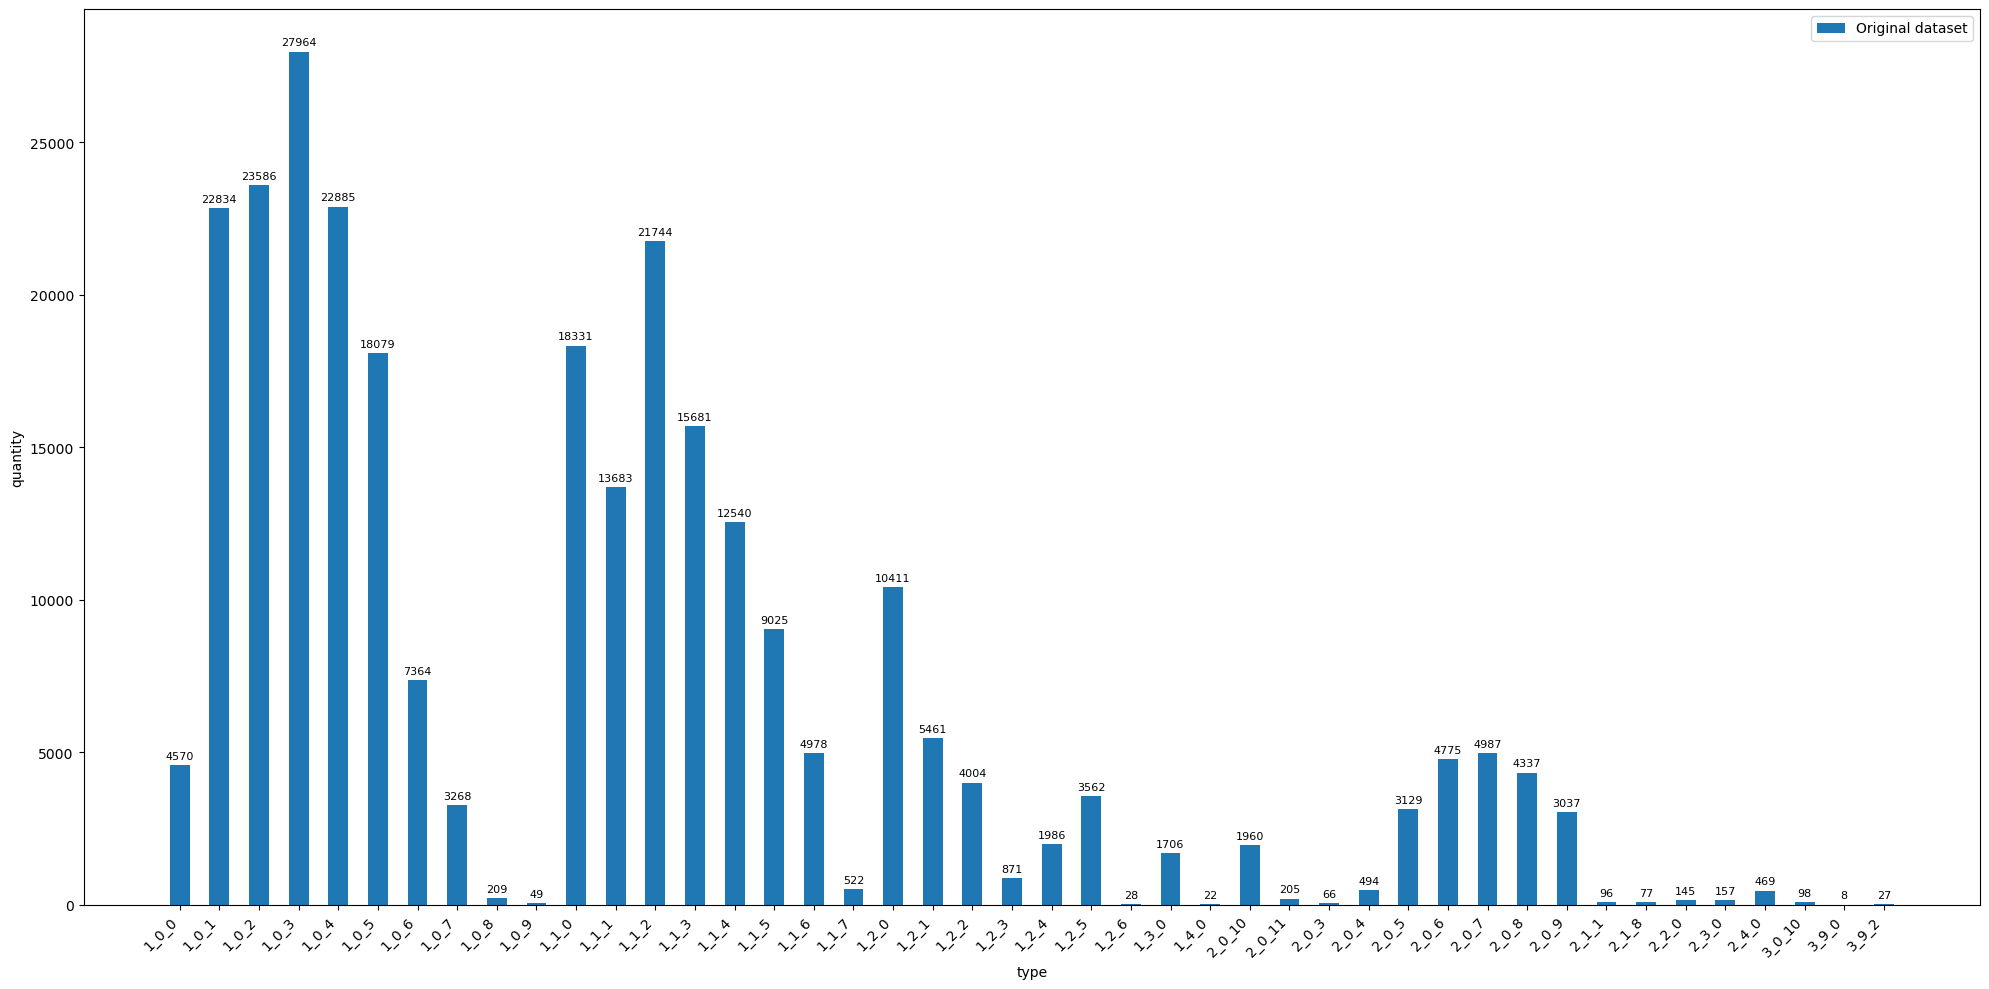

X[0] ÂΩ¢Áä∂: (6, 3, 1)
y ÂΩ¢Áä∂: (10632,)


In [58]:
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

# ÂÅáËÆæ cy_data_encoded Âíå state_encoder Â∑≤ÂÆö‰πâ
# cy_data_encoded = ...
# state_encoder = ...

# ÊûÑÂª∫Êï∞ÊçÆÈõÜ
def create_dataset(data, sequence_length):
    """
    Â∞ÜËæìÂÖ•Êï∞ÊçÆÂàÜÂâ≤‰∏∫ÈïøÂ∫¶‰∏∫ sequence_length ÁöÑÂ∫èÂàó„ÄÇ
    """
    sequences = []
    for i in range(len(data) - sequence_length + 1): 
        # ÊûÑÂª∫Â∫èÂàó
        sequences.append(data[i:i + sequence_length])
    return sequences

# ÂèÇÊï∞
sequence_length = 3

sequences = []
X = []
y = []

for row in cy_data_encoded:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1,:, 0].reshape(-1, sequence_length, 1))  # Èô§ÂéªÊúÄÂêé‰∏Ä‰∏™Â∫èÂàó,Âπ∂‰∏îÂè™ÂèñÁä∂ÊÄÅ
    y.append(sequence[1:, -1, 0].reshape(-1, 1))   # Èô§ÂéªÁ¨¨‰∏Ä‰∏™Â∫èÂàó,Âπ∂‰∏îÂè™ÂèñÁä∂ÊÄÅ

sequences = np.array(sequences, dtype=object)
X = np.array(X, dtype=object)
y = np.array(y, dtype=object)

# Â∞ÜÊâÄÊúâ y Êï∞ÊçÆÂêàÂπ∂‰∏∫‰∏Ä‰∏™‰∏ÄÁª¥Êï∞ÁªÑ
y_original = np.concatenate(y).flatten()
X_original = np.concatenate(X, axis=0)

# ÁªüËÆ°ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨Êï∞
original_class_counts = Counter(y_original)

# Ëé∑ÂèñÊÄªÁöÑÁ±ªÂà´ËåÉÂõ¥ÔºàÈÄöËøá state_encoder ÁöÑÁ±ªÂà´ÊÄªÊï∞Ôºâ
total_classes = np.arange(len(state_encoder.classes_))

# ËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑÔºåÊåâÁ±ªÂà´È°∫Â∫èÊéíÂàó
original_class_distribution = np.zeros(len(total_classes), dtype=int)

for cls in total_classes:
    original_class_distribution[cls] = original_class_counts.get(cls, 0)

# ËæìÂá∫ÁªìÊûú
print("ÂéüÂßãÊï∞ÊçÆÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨ÂàÜÂ∏É:")
for cls in total_classes:
    print(f"Á±ªÂà´ {cls}: {original_class_distribution[cls]} Ê¨°")

# ÁªòÂà∂Áõ¥ÊñπÂõæ
x = np.arange(len(total_classes))  # Á±ªÂà´Á¥¢Âºï
width = 0.5  # Áõ¥ÊñπÂõæÂÆΩÂ∫¶

fig, ax = plt.subplots(figsize=(20, 10))
rects = ax.bar(x, original_class_distribution, width, label='Original dataset')

# Ê∑ªÂä†Ê†áÁ≠æ„ÄÅÊ†áÈ¢òÂíåÂõæ‰æã
ax.set_xlabel('type')
ax.set_ylabel('quantity')
ax.set_xticks(x)
ax.set_xticklabels([f"{cls}" for cls in state_encoder.classes_], rotation=45, ha='right')  # ‰ΩøÁî® state_encoder.classes_ ‰∏≠ÁöÑÁ±ªÂà´ÂêçÁß∞
ax.legend()

# Âú®Êü±Áä∂Âõæ‰∏äÊñπÊòæÁ§∫ÂÖ∑‰ΩìÊï∞ÂÄº
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects)

# ÊòæÁ§∫ÂõæÂΩ¢
plt.tight_layout()
plt.show()

# ÊâìÂç∞ X Âíå y ÁöÑÂΩ¢Áä∂‰ª•‰æõË∞ÉËØï
print("X[0] ÂΩ¢Áä∂:", X[0].shape)
print("y ÂΩ¢Áä∂:", y.shape)

ÁªüËÆ°ÊØèÁßçXÂØπÂ∫îÂ§öÂ∞ëÁßçy‰ª•ÂèäÂÖ∑‰ΩìÁöÑÊØî‰æã

In [59]:
import numpy as np
from collections import defaultdict, Counter

def analyze_y_for_each_x(X, y):
    """
    ÁªüËÆ°ÔºöÂØπÁªôÂÆöÁöÑ X, y (ÈïøÂ∫¶Áõ∏Âêå)ÔºåÂÖ∂‰∏≠ X[i] ÂΩ¢Â¶Ç (m_i, 2, 1)Ôºåy[i] ÂΩ¢Â¶Ç (m_i, 1)Ôºå
         Êî∂ÈõÜÊØè‰∏™Â≠êÂ∫èÂàó x_seq ÂØπÂ∫îÂá∫Áé∞‰∫ÜÂì™‰∫õ yÔºåÂπ∂‰∏î y Âá∫Áé∞‰∫ÜÂ§öÂ∞ëÊ¨°„ÄÇ

    ËøîÂõûÔºö
        x2y_distribution: dict,
            key = x_seq (‰æãÂ¶Ç (42, 43) ÁöÑ tuple),
            value = Counter({y_val: freq})ÔºåÁªüËÆ°ËØ• x_seq ÂØπÂ∫îÁöÑ y_val ÂèäÂÖ∂Âá∫Áé∞Ê¨°Êï∞
    """
    x2y_distribution = defaultdict(Counter)

    # ÈÅçÂéÜÊâÄÊúâÂ§ñÂ±ÇÊï∞ÊçÆ
    for i in range(len(X)):
        xi = X[i]  # ÂΩ¢Â¶Ç (m_i, 2, 1)
        yi = y[i]  # ÂΩ¢Â¶Ç (m_i, 1)
        # ÈÅçÂéÜËØ•Êù°Êï∞ÊçÆÈáåÁöÑÊâÄÊúâÂ≠êÂ∫èÂàó
        for j in range(xi.shape[0]):
            # x_seq ÂΩ¢Â¶Ç (2,) ÁöÑ‰∏ÄÁª¥Êï∞ÊçÆÔºõËΩ¨‰∏∫ tuple ‰ª•‰æøÂÅöÂ≠óÂÖ∏ÈîÆ
            seq_tuple = tuple(xi[j, :, 0])
            # y_val ÊòØ‰∏Ä‰∏™Êï¥Êï∞
            y_val = yi[j, 0]
            # Á¥ØÂä†ÁªüËÆ°
            x2y_distribution[seq_tuple][y_val] += 1
    
    return x2y_distribution


def print_y_distribution_for_x(x2y_distribution, top_k=10):
    """
    ÂØπ‰∫é x2y_distribution (Áî±‰∏äÈù¢ÂáΩÊï∞ËøîÂõû)ÔºåÊâìÂç∞Ôºö
      - ÊØè‰∏™ x_seq ÁöÑÊÄªÂá∫Áé∞Ê¨°Êï∞
      - ËØ• x_seq ÂØπÂ∫îÁöÑ‰∏çÂêå y ÁöÑÁßçÁ±ªÊï∞
      - ‰∏çÂêå y ÁöÑÂá∫Áé∞Ê¨°Êï∞ÂèäÊâÄÂç†ÊØî‰æã

    ÂèÇÊï∞Ôºö
    - x2y_distribution: dict,
        key = x_seq, value = Counter({y_val: freq})
    - top_k: Âè™ÊâìÂç∞ÊúÄÂ∏∏Âá∫Áé∞ÁöÑÂâç top_k ‰∏™ x_seqÔºå‰ª•Èò≤Ê≠¢ËæìÂá∫ËøáÂ§ö„ÄÇ
             Ëã•‰∏∫ None ÂàôÊâìÂç∞ÊâÄÊúâ x_seq„ÄÇ
    """
    # Â∞ÜÊâÄÊúâ x_seq ÊéíÂ∫èÔºà‰æãÂ¶ÇÔºåÊåâÊÄªÂá∫Áé∞Ê¨°Êï∞‰ªéÂ§ßÂà∞Â∞èÔºâ„ÄÇ
    # ‰Ω†‰πüÂèØ‰ª•ÊîπÊàêÊåâ x_seq ÁöÑÂ≠óÂÖ∏È°∫Â∫èÊàñÂà´ÁöÑÊéíÂ∫èËßÑÂàô„ÄÇ
    x_freq_list = []
    for x_seq, counter_for_x in x2y_distribution.items():
        total_count = sum(counter_for_x.values())
        x_freq_list.append((x_seq, total_count))
    
    # ÊåâÂá∫Áé∞ÊÄªÊï∞‰ªéÂ§ßÂà∞Â∞èÊéíÂ∫è
    x_freq_list.sort(key=lambda x: x[1], reverse=True)

    if top_k is not None:
        x_freq_list = x_freq_list[:top_k]
    
    # ‰æùÊ¨°ÊâìÂç∞
    print(f"‰∏ÄÂÖ±Êúâ {len(x2y_distribution)} Áßç‰∏çÂêåÁöÑ X Â∫èÂàó„ÄÇ")
    for x_seq, freq_sum in x_freq_list:
        counter_for_x = x2y_distribution[x_seq]
        distinct_y_count = len(counter_for_x)
        
        print("=" * 50)
        print(f"X={x_seq}, ÊÄªÂá∫Áé∞Ê¨°Êï∞ {freq_sum}, ÂØπÂ∫î {distinct_y_count} Áßç‰∏çÂêå y")
        
        # ÂèñÂæóÂêÑ y ÁöÑÂá∫Áé∞Ê¨°Êï∞Ôºå‰ªéÂ§ßÂà∞Â∞è
        y_most_common = counter_for_x.most_common()
        
        for y_val, freq in y_most_common:
            proportion = freq / freq_sum
            print(f"  y={y_val} Âá∫Áé∞ {freq} Ê¨°ÔºåÂç†ÊØî {proportion:.2%}")


# =====================
# ‰ΩøÁî®Á§∫‰æã
# =====================
# 1) ÂÅáËÆæ‰Ω†Â∑≤Êúâ X, y (ÈïøÂ∫¶ÈÉΩÊòØ 10632)
#   - X[i].shape = (m_i, 2, 1)
#   - y[i].shape = (m_i, 1)
# 2) Êî∂ÈõÜ x->y ÁöÑÂàÜÂ∏É
x2y_dist = analyze_y_for_each_x(X, y)

# 3) ÊâìÂç∞ÁªüËÆ°‰ø°ÊÅØ
#    top_k=10 Ë°®Á§∫Âè™ÊâìÂç∞Âá∫Áé∞ÊÄªÊ¨°Êï∞ÊúÄÂ§öÁöÑÂâç10Áßç X Â∫èÂàó
#    Â¶ÇÊûú‰Ω†ÊÉ≥ÊâìÂç∞ÂÖ®ÈÉ®ÔºåÂèØ‰ª•ËÆæÁΩÆ top_k=None
print_y_distribution_for_x(x2y_dist, top_k=4)


‰∏ÄÂÖ±Êúâ 6573 Áßç‰∏çÂêåÁöÑ X Â∫èÂàó„ÄÇ
X=(12, 1, 12), ÊÄªÂá∫Áé∞Ê¨°Êï∞ 5605, ÂØπÂ∫î 26 Áßç‰∏çÂêå y
  y=1 Âá∫Áé∞ 3853 Ê¨°ÔºåÂç†ÊØî 68.74%
  y=14 Âá∫Áé∞ 556 Ê¨°ÔºåÂç†ÊØî 9.92%
  y=11 Âá∫Áé∞ 232 Ê¨°ÔºåÂç†ÊØî 4.14%
  y=3 Âá∫Áé∞ 223 Ê¨°ÔºåÂç†ÊØî 3.98%
  y=2 Âá∫Áé∞ 186 Ê¨°ÔºåÂç†ÊØî 3.32%
  y=10 Âá∫Áé∞ 153 Ê¨°ÔºåÂç†ÊØî 2.73%
  y=13 Âá∫Áé∞ 132 Ê¨°ÔºåÂç†ÊØî 2.36%
  y=19 Âá∫Áé∞ 67 Ê¨°ÔºåÂç†ÊØî 1.20%
  y=21 Âá∫Áé∞ 32 Ê¨°ÔºåÂç†ÊØî 0.57%
  y=15 Âá∫Áé∞ 30 Ê¨°ÔºåÂç†ÊØî 0.54%
  y=31 Âá∫Áé∞ 26 Ê¨°ÔºåÂç†ÊØî 0.46%
  y=20 Âá∫Áé∞ 21 Ê¨°ÔºåÂç†ÊØî 0.37%
  y=32 Âá∫Áé∞ 19 Ê¨°ÔºåÂç†ÊØî 0.34%
  y=4 Âá∫Áé∞ 18 Ê¨°ÔºåÂç†ÊØî 0.32%
  y=33 Âá∫Áé∞ 12 Ê¨°ÔºåÂç†ÊØî 0.21%
  y=0 Âá∫Áé∞ 8 Ê¨°ÔºåÂç†ÊØî 0.14%
  y=30 Âá∫Áé∞ 8 Ê¨°ÔºåÂç†ÊØî 0.14%
  y=18 Âá∫Áé∞ 8 Ê¨°ÔºåÂç†ÊØî 0.14%
  y=23 Âá∫Áé∞ 6 Ê¨°ÔºåÂç†ÊØî 0.11%
  y=16 Âá∫Áé∞ 5 Ê¨°ÔºåÂç†ÊØî 0.09%
  y=34 Âá∫Áé∞ 3 Ê¨°ÔºåÂç†ÊØî 0.05%
  y=22 Âá∫Áé∞ 2 Ê¨°ÔºåÂç†ÊØî 0.04%
  y=5 Âá∫Áé∞ 2 Ê¨°ÔºåÂç†ÊØî 0.04%
  y=35 Âá∫Áé∞ 1 Ê¨°ÔºåÂç†ÊØî 0.02%
  y=17 Âá∫Áé∞ 1 Ê¨°ÔºåÂç†ÊØî 0.02%
  y=37 Â

#### Âà†Èô§ÊåáÂÆöÁöÑÂô™Â£∞Á±ªÂà´

In [9]:
# ÂÆö‰πâÈúÄË¶ÅÊü•ËØ¢ÁöÑÁ±ªÂà´Á¥¢Âºï
target_indices = [8,9,17,24,26,28,29,30,36,37,38,39,41,42,43]

# Ëé∑Âèñ state_encoder.classes_ ÁöÑÂÜÖÂÆπ
classes = state_encoder.classes_
print(len(classes))
# ËæìÂá∫ÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞
print("Á±ªÂà´Á¥¢ÂºïÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö")
for idx in target_indices:
    if idx < len(classes):  # Á°Æ‰øùÁ¥¢ÂºïÂú®ËåÉÂõ¥ÂÜÖ
        print(f"Á±ªÂà´ {idx}: {classes[idx]}")
    else:
        print(f"Á±ªÂà´ {idx} Ë∂ÖÂá∫‰∫ÜËåÉÂõ¥ÔºåÊó†Ê≥ïÊâæÂà∞ÂØπÂ∫îÁâ©Áßç„ÄÇ")
        

# ÂàõÂª∫Â∏ÉÂ∞îÊé©Á†ÅÔºåÊ†áËÆ∞ÈúÄË¶Å‰øùÁïôÁöÑÊï∞ÊçÆ
mask = np.isin(y_original, target_indices, invert=True)
# ËøáÊª§ÊéâÁõÆÊ†áÁ±ªÂà´
filtered_y = y_original[mask]
filtered_X = X_original[mask]
# ËæìÂá∫ËøáÊª§ÂâçÂêéÁöÑÊï∞ÊçÆÈáè
print(f"ÂéüÂßãÊï∞ÊçÆÈõÜ‰∏≠ y ÁöÑÊ†∑Êú¨Êï∞Èáè: {len(y_original)}")
print(f"ËøáÊª§ÂêéÁöÑÊï∞ÊçÆÈõÜ‰∏≠ y ÁöÑÊ†∑Êú¨Êï∞Èáè: {len(filtered_y)}")

# ÈáçÊûÑÊï∞ÊçÆÔºå‰ΩøÂÖ∂‰∏éÂéüÂßãÊ†ºÂºè‰∏ÄËá¥
def restore_dataset_shape(filtered_X, filtered_y, mask, X, y):
    """
    Ê†πÊçÆÂéüÊù•ÁöÑ X„ÄÅy ÁöÑÂΩ¢Áä∂ÔºåÂ∞Ü‚ÄúÈì∫Âπ≥‚ÄùÂπ∂ÁªèËøáËøáÊª§ÁöÑ filtered_X„ÄÅfiltered_y
    ÊÅ¢Â§çÂà∞‰∏é X„ÄÅy ÂØπÂ∫îÁöÑÂàÜÂùóÁªìÊûÑ„ÄÇ
    
    ÂèÇÊï∞Ôºö
    --------
    filtered_X : np.ndarray
        ËøáÊª§ÂêéÁöÑ XÔºåÂΩ¢Áä∂ (M, sequence_length, 1)
    filtered_y : np.ndarray
        ËøáÊª§ÂêéÁöÑ yÔºåÂΩ¢Áä∂ (M,)
    mask : np.ndarray (bool)
        ‰∏é X_original / y_original ÂêåÈïøÂ∫¶ÁöÑÂ∏ÉÂ∞îÊé©Á†ÅÔºåÁî®‰∫éÊåáÁ§∫Âì™‰∫õÂ≠êÂ∫èÂàó‰øùÁïô
    X : np.ndarray(dtype=object)
        ÂéüÊù•ÁöÑ XÔºåX.shape==(n_rows,)ÔºåÂÖ∂‰∏≠ X[i] ÁöÑÂΩ¢Áä∂ÊòØ (num_subseq_i, sequence_length, 1)
    y : np.ndarray(dtype=object)
        ÂéüÊù•ÁöÑ yÔºåy.shape==(n_rows,)ÔºåÂÖ∂‰∏≠ y[i] ÁöÑÂΩ¢Áä∂ÊòØ (num_subseq_i, 1)

    ËøîÂõûÔºö
    --------
    newX : np.ndarray (dtype=object)
        ÊÅ¢Â§çÂàÜÂùóÂêéÁöÑ XÔºåÁªìÊûÑÂêå XÔºå‰ΩÜÂè™‰øùÁïô‰∫ÜË¢´ËøáÊª§ÂêéÁöÑÂ≠êÂ∫èÂàó
    newY : np.ndarray (dtype=object)
        ÊÅ¢Â§çÂàÜÂùóÂêéÁöÑ yÔºåÁªìÊûÑÂêå yÔºå‰ΩÜÂè™‰øùÁïô‰∫ÜË¢´ËøáÊª§ÂêéÁöÑÂ≠êÂ∫èÂàó
    """
    n_rows = len(X)
    # ÈúÄË¶ÅÊääÊØèË°åÁöÑÁªìÊûúÂÜç‰ª• dtype=object Ë£ÖËµ∑Êù•
    newX = np.empty(n_rows, dtype=object)
    newY = np.empty(n_rows, dtype=object)
    
    # Ëøô‰∏§‰∏™ÊåáÈíàÈùûÂ∏∏ÈáçË¶Å
    # start_idx Áî®‰∫éÂú®ÂéüÂßãmaskÈáå‚ÄúÊâæÂì™‰∏ÄÊÆµÂØπÂ∫îÊú¨Ë°å‚Äù 
    # filtered_count Áî®‰∫éÂú®‚ÄúËøáÊª§ÂêéÊï∞ÁªÑ‚ÄùÈáå‚Äú‰ªéÂì™ÂºÄÂßãÊãøÊï∞ÊçÆ‚Äù
    start_idx = 0
    filtered_count = 0

    for i in range(n_rows):
        # ÂéüÂßãÁ¨¨ i Ë°åÁöÑÂ≠êÂ∫èÂàóÊï∞Èáè
        num_subseq_i = X[i].shape[0]

        # Âú® mask ÈáåÔºåÈíàÂØπÊú¨Ë°åÁöÑÈÇ£‰∏ÄÊÆµÂàáÁâá
        row_mask = mask[start_idx : start_idx + num_subseq_i]
        # Ëøô‰∏ÄË°åÈáå‰øùÁïô‰∏ãÊù•ÁöÑÂ≠êÂ∫èÂàóÊï∞
        row_true_count = np.sum(row_mask)
        
        # ‰ªéËøáÊª§ÂêéÊï∞ÁªÑÈáåÊãø row_true_count Êù°Â≠êÂ∫èÂàó
        # Áõ∏ÊØî‰πãÂâçÈîôËØØÂú∞ÂØπ filtered_X[start_idx : ...] Á¥¢ÂºïÔºåËøôÈáåÊîπÁî® filtered_count
        row_filtered_X = filtered_X[filtered_count : filtered_count + row_true_count]
        row_filtered_y = filtered_y[filtered_count : filtered_count + row_true_count]
        # Ê≥®ÊÑè y ÁöÑÂéüÂΩ¢Áä∂ÊòØ (num_subseq_i, 1)ÔºåÊâÄ‰ª•Ë¶ÅÂÅö reshape
        row_filtered_y = row_filtered_y.reshape(-1, 1)

        # Â°´Âõû newX, newY
        newX[i] = row_filtered_X
        newY[i] = row_filtered_y

        # Êõ¥Êñ∞‰∏§‰∏™ÊåáÈíà
        start_idx += num_subseq_i
        filtered_count += row_true_count

    return newX, newY



# Â∑≤ÁªèÂæóÂà∞ filtered_X, filtered_y, mask, ‰ª•ÂèäÂéüÊù•ÁöÑ X, y
newX, newY = restore_dataset_shape(filtered_X, filtered_y, mask, X, y)

# Áé∞Âú® newX, newY Â∞±ÊòØÂ∏¶ÊúâÂàÜÂùóÁªìÊûÑÁöÑ np.ndarray(dtype=object),
# ÂÖ∂‰∏≠ newX[i] Âíå newY[i] ÂàÜÂà´ÂåÖÂê´Á¨¨ i Ë°åËøáÊª§Âêé‰øùÁïô‰∏ãÊù•ÁöÑÊâÄÊúâÂ≠êÂ∫èÂàó„ÄÇ


# ËæìÂá∫ÈáçÊûÑÂêéÁöÑÊï∞ÊçÆÂΩ¢Áä∂
print("ÈáçÊûÑÂêéÁöÑ X ÂΩ¢Áä∂:", newX.shape)
print("ÈáçÊûÑÂêéÁöÑ y ÂΩ¢Áä∂:", newY.shape)

44
Á±ªÂà´Á¥¢ÂºïÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö
Á±ªÂà´ 8: 1_0_8
Á±ªÂà´ 9: 1_0_9
Á±ªÂà´ 17: 1_1_7
Á±ªÂà´ 24: 1_2_6
Á±ªÂà´ 26: 1_4_0
Á±ªÂà´ 28: 2_0_11
Á±ªÂà´ 29: 2_0_3
Á±ªÂà´ 30: 2_0_4
Á±ªÂà´ 36: 2_1_1
Á±ªÂà´ 37: 2_1_8
Á±ªÂà´ 38: 2_2_0
Á±ªÂà´ 39: 2_3_0
Á±ªÂà´ 41: 3_0_10
Á±ªÂà´ 42: 3_9_0
Á±ªÂà´ 43: 3_9_2
ÂéüÂßãÊï∞ÊçÆÈõÜ‰∏≠ y ÁöÑÊ†∑Êú¨Êï∞Èáè: 290062
ËøáÊª§ÂêéÁöÑÊï∞ÊçÆÈõÜ‰∏≠ y ÁöÑÊ†∑Êú¨Êï∞Èáè: 287557
ÈáçÊûÑÂêéÁöÑ X ÂΩ¢Áä∂: (10632,)
ÈáçÊûÑÂêéÁöÑ y ÂΩ¢Áä∂: (10632,)


#### ÂØπnewXÂíånewYËøõË°åÁ±ªÂà´ÈáçÊñ∞Êò†Â∞Ñ

In [10]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def fast_decode_and_reencode(newX, newY, old_state_encoder):
    """
    ‰∏ÄÊ¨°ÊÄßÂØπ newX„ÄÅnewY ËøõË°åËß£Á†ÅÔºåÂàõÂª∫Êñ∞ÁöÑ encoderÔºåÂπ∂ÊääÂÆÉ‰ª¨ÈáçÊñ∞ÁºñÁ†ÅÂõûÊù•„ÄÇ

    ÂèÇÊï∞
    -------
    newX : np.ndarray(dtype=object)
        ËøáÊª§ÂêéÁöÑ XÔºåÂΩ¢Áä∂ (n_rows,)
        ÊØè‰∏™ newX[i] ÂΩ¢Â¶Ç (num_subseq_i, sequence_length, 1)
    newY : np.ndarray(dtype=object)
        ËøáÊª§ÂêéÁöÑ YÔºåÂΩ¢Áä∂ (n_rows,)
        ÊØè‰∏™ newY[i] ÂΩ¢Â¶Ç (num_subseq_i, 1)
    old_state_encoder : LabelEncoder
        ÂéüÂÖàËÆ≠ÁªÉÂ•ΩÁöÑ state_encoderÔºåÁî®‰∫é inverse_transform()

    ËøîÂõû
    -------
    newX_reencoded : ‰∏é newX Áõ∏Âêå shapeÔºå‰ΩÜÂÜÖÂÆπÊòØ„ÄåÊñ∞ÁöÑÊï¥Êï∞Á¥¢Âºï„Äç
    newY_reencoded : ‰∏é newY Áõ∏Âêå shape
    filtered_state_encoder : Êñ∞ÁöÑ LabelEncoderÔºå‰ªÖÂåÖÂê´Âú®ËøáÊª§ÂêéÊï∞ÊçÆ‰∏≠ÂÆûÈôÖÂá∫Áé∞ÁöÑ (Mo, O, S) ÁªÑÂêà
    """

    # -------------------------
    # (1) Â∞Ü newX„ÄÅnewY ÊâÅÂπ≥Âåñ(flatten)Âà∞‰∏ÄÁª¥
    # -------------------------
    flattened_x = []
    for i in range(len(newX)):
        # newX[i] ÁöÑÂΩ¢Áä∂ (num_subseq_i, seq_len, 1)ÔºåÂèØËÉΩÊúâÁ©∫Ë°å
        if newX[i].size > 0:
            flattened_x.append(newX[i].flatten())  # ‰∏ÄÁª¥
        else:
            # Á©∫Ë°åÂàô append Á©∫ÂàóË°®Âç≥ÂèØ
            flattened_x.append([])

    # Â∞ÜÊâÄÊúâË°åÊãºÊé•‰∏∫‰∏Ä‰∏™‰∏ÄÁª¥Êï∞ÁªÑ
    flattened_x = (
        np.concatenate(flattened_x, axis=0) if flattened_x else np.array([], dtype=int)
    )

    flattened_y = []
    for i in range(len(newY)):
        # newY[i] ÁöÑÂΩ¢Áä∂ (num_subseq_i, 1)
        if newY[i].size > 0:
            flattened_y.append(newY[i].flatten())
        else:
            flattened_y.append([])

    flattened_y = (
        np.concatenate(flattened_y, axis=0) if flattened_y else np.array([], dtype=int)
    )

    # all_labels Âç≥ÊâÄÊúâÂá∫Áé∞ËøáÁöÑÊï¥Êï∞Áä∂ÊÄÅÔºåÂÖàÊãºÂà∞‰∏ÄËµ∑
    all_labels = np.concatenate([flattened_x, flattened_y], axis=0).astype(int)

    # -------------------------
    # (2) ‰∏ÄÊ¨°ÊÄß‰ΩøÁî® old_state_encoder Ëß£Á†Å
    # -------------------------
    # ÂæóÂà∞ËØ∏Â¶Ç ['3_9_0', '2_8_1', ...] ÁöÑÂ≠óÁ¨¶‰∏≤Êï∞ÁªÑ
    str_labels = old_state_encoder.inverse_transform(all_labels)
    # Â∞Ü '3_9_0' => (3, 9, 0) tuple
    splitted = [tuple(map(int, s.split('_'))) for s in str_labels]

    # -------------------------
    # (3) ÂàõÂª∫Êñ∞ÁöÑÁºñÁ†ÅÂô®ÔºöÂè™ÂåÖÂê´ËøáÊª§ÂêéÂÆûÈôÖÂá∫Áé∞ËøáÁöÑÁ±ªÂà´
    # -------------------------
    # ÂéªÈáçÔºå‰ª• tuple(Mo,O,S) ÂΩ¢Âºè‰øùÁïô
    unique_tuples = sorted(set(splitted))  
    # ÂÜçËΩ¨‰∏∫Â≠óÁ¨¶‰∏≤‰ª• fit Âà∞ LabelEncoder
    tuple_strings = [f"{t[0]}_{t[1]}_{t[2]}" for t in unique_tuples]

    filtered_state_encoder = LabelEncoder()
    filtered_state_encoder.fit(tuple_strings)

    # -------------------------
    # (4) ÊûÑÂª∫„Äå(Mo,O,S)->Êñ∞Á¥¢Âºï„ÄçÁöÑÂ≠óÂÖ∏ÔºåÂπ∂Â∞ÜÊâÄÊúâ splitted ÊâπÈáèËΩ¨Êç¢
    # -------------------------
    splitted_to_new = {}
    for t in unique_tuples:
        t_str = f"{t[0]}_{t[1]}_{t[2]}"
        new_label = filtered_state_encoder.transform([t_str])[0]
        splitted_to_new[t] = new_label

    # Â∞Ü splitted ‰∏≠ÊØè‰∏™ÂÖÉÁ¥† (Mo,O,S) ËΩ¨‰∏∫Êñ∞ÁöÑÊï¥Êï∞Á¥¢Âºï
    reencoded_all = np.array([splitted_to_new[t] for t in splitted], dtype=int)

    # Áî±‰∫éÂâçÈù¢ merged x,y (flattened)ÔºåÁé∞ÈúÄÊãÜÂàÜËøòÂéü
    x_size = flattened_x.shape[0]
    y_size = flattened_y.shape[0]
    reencoded_x = reencoded_all[:x_size]
    reencoded_y = reencoded_all[x_size:]

    # -------------------------
    # (5) ËøòÂéüÂõû‰∏é newX„ÄÅnewY Áõ∏ÂêåÂΩ¢Áä∂
    # -------------------------
    newX_reencoded = np.empty_like(newX)
    idx = 0
    for i in range(len(newX)):
        shape_i = newX[i].shape  # (num_subseq_i, seq_len, 1)
        size_i = shape_i[0] * shape_i[1] * shape_i[2] if shape_i[0] > 0 else 0
        newX_reencoded[i] = reencoded_x[idx : idx + size_i].reshape(shape_i)
        idx += size_i

    newY_reencoded = np.empty_like(newY)
    idx = 0
    for i in range(len(newY)):
        shape_i = newY[i].shape  # (num_subseq_i, 1)
        size_i = shape_i[0] * shape_i[1] if shape_i[0] > 0 else 0
        newY_reencoded[i] = reencoded_y[idx : idx + size_i].reshape(shape_i)
        idx += size_i

    return newX_reencoded, newY_reencoded, filtered_state_encoder


# =======================
# ‰ΩøÁî®Á§∫‰æã
# =======================

# ÂÅáËÆæÂ∑≤ÁªèÂæóÂà∞:
#   newX, newY    (ËøáÊª§ÂêéÔºåÂíåÂéü X, Y ÂêåÁªìÊûÑ)
#   state_encoder (ÊóßÁöÑ LabelEncoder)
# Áé∞Âú®ÊâßË°å:
newX_reencoded, newY_reencoded, filtered_state_encoder = fast_decode_and_reencode(newX, newY, state_encoder)



#### Â∞ÜÂà†Èô§Âô™Â£∞ÂêéÁöÑÊï∞ÊçÆÂàÜ‰∏∫ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ

(7442,) (3190,)
(7442,) (3190,)
(195864, 3, 1) (83566, 3, 1)
(195864, 1) (83566, 1)
ËÆ≠ÁªÉÈõÜ‰∏≠ÂåÖÂê´ÁöÑÁ±ªÂà´Êï∞Èáè: 44
ÊµãËØïÈõÜ‰∏≠ÂåÖÂê´ÁöÑÁ±ªÂà´Êï∞Èáè: 44
ÊÄªÁ±ªÂà´Êï∞Èáè: 44
ËÆ≠ÁªÉÈõÜ‰∏≠Ê≤°ÊúâÁº∫Â§±‰ªª‰ΩïÁ±ªÂà´„ÄÇ
ÊµãËØïÈõÜ‰∏≠Ê≤°ÊúâÁº∫Â§±‰ªª‰ΩïÁ±ªÂà´„ÄÇ
Á±ªÂà´Á¥¢ÂºïÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö
Á±ªÂà´ 8: 1_0_8
Á±ªÂà´ 9: 1_0_9
Á±ªÂà´ 17: 1_1_7
Á±ªÂà´ 24: 1_2_6
Á±ªÂà´ 26: 1_4_0
Á±ªÂà´ 28: 2_0_11
Á±ªÂà´ 29: 2_0_3
Á±ªÂà´ 30: 2_0_4
Á±ªÂà´ 36: 2_1_1
Á±ªÂà´ 37: 2_1_8
Á±ªÂà´ 38: 2_2_0
Á±ªÂà´ 39: 2_3_0
Á±ªÂà´ 41: 3_0_10
Á±ªÂà´ 42: 3_9_0
Á±ªÂà´ 43: 3_9_2


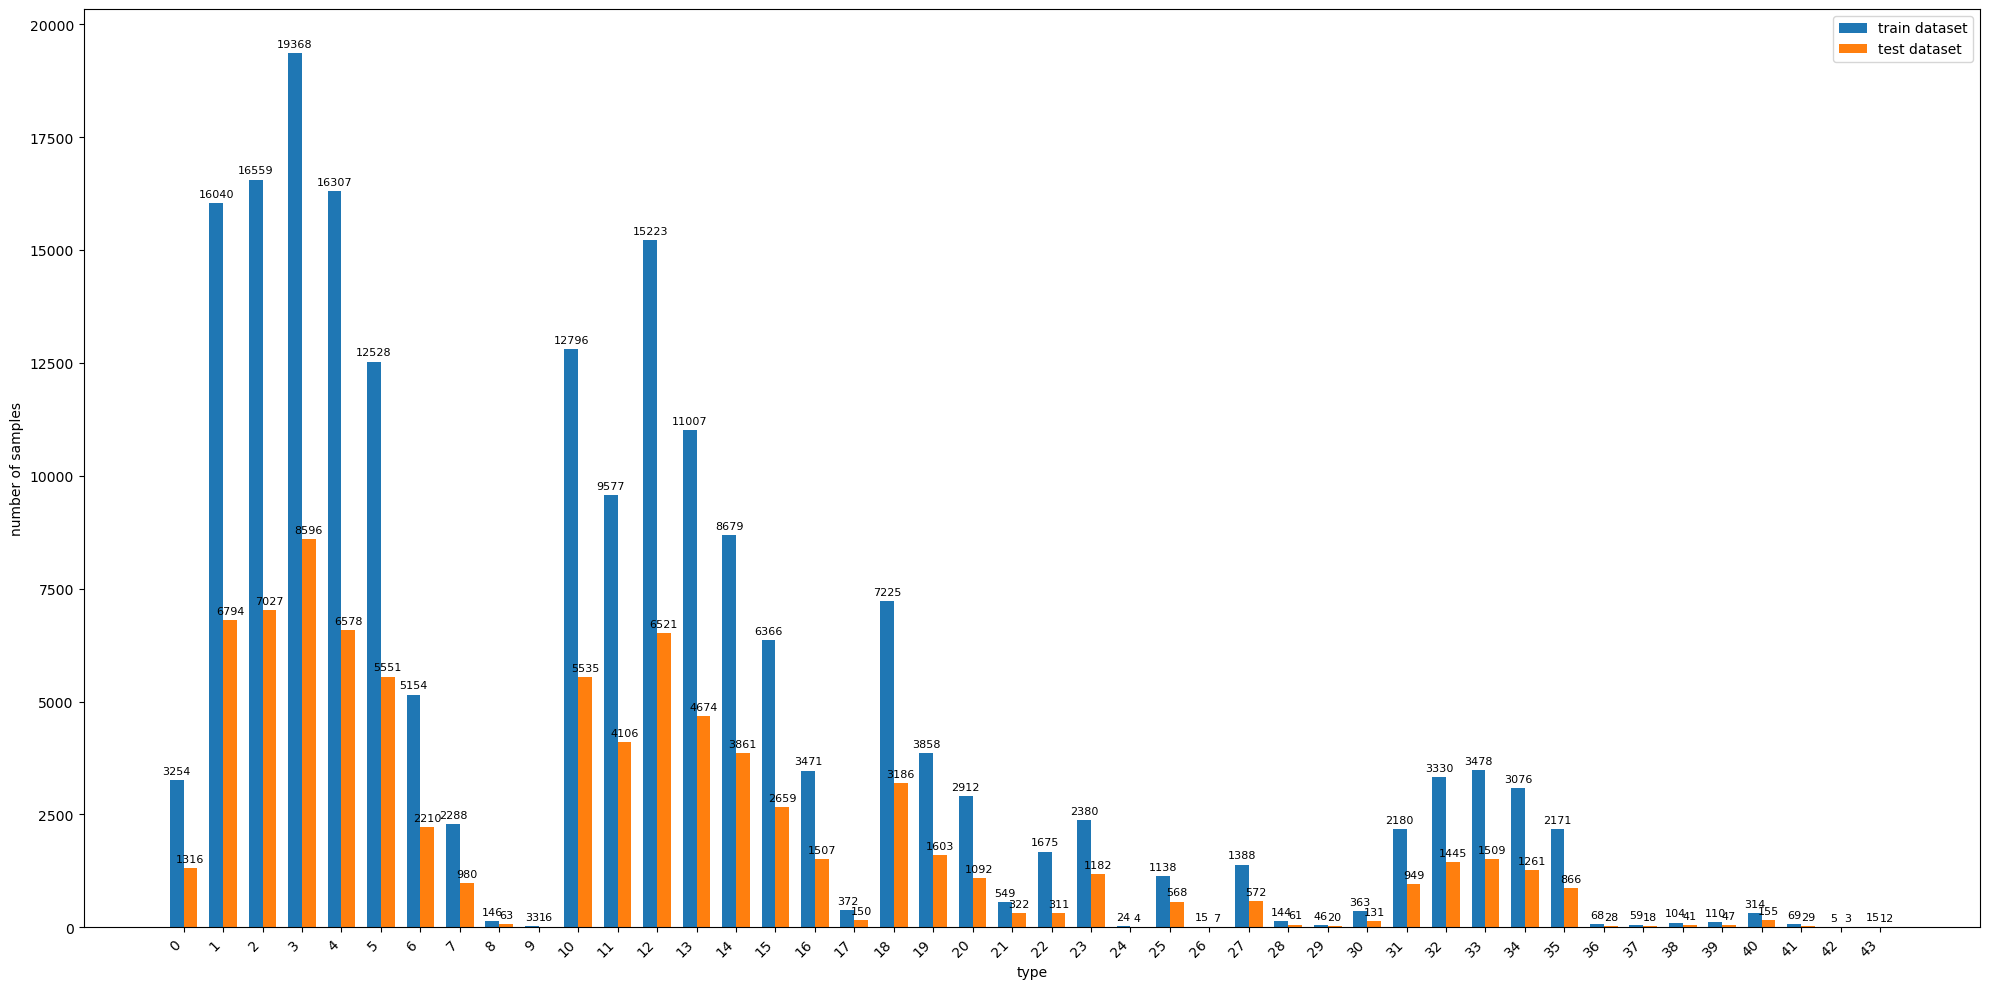

In [55]:
# Â∞ÜÊï∞ÊçÆÂàíÂàÜ‰∏∫ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÔºåÂèØ‰ª•ÊåáÂÆöÊµãËØïÈõÜÁöÑÂ§ßÂ∞èÂíåÈöèÊú∫ÁßçÂ≠ê
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


# Ëé∑ÂèñËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ‰∏≠ÁöÑÂîØ‰∏ÄÁ±ªÂà´
unique_train_classes = np.unique(y_train)
unique_test_classes = np.unique(y_test)

# Ëé∑ÂèñÊÄªÁöÑÁ±ªÂà´ËåÉÂõ¥ÔºàÈÄöËøá state_encoder ÁöÑÁ±ªÂà´ÊÄªÊï∞Ôºâ
total_classes = np.arange(len(state_encoder.classes_))

# ÁªüËÆ°ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ‰∏≠ÁöÑÁ±ªÂà´Êï∞Èáè
num_train_classes = len(unique_train_classes)
num_test_classes = len(unique_test_classes)


# Ê£ÄÊü•ËÆ≠ÁªÉÈõÜ‰∏≠ÊòØÂê¶Áº∫Â∞ëÊüê‰∫õÁ±ªÂà´
missing_classes_in_train = set(total_classes) - set(unique_train_classes)
# Ê£ÄÊü•ÊµãËØïÈõÜ‰∏≠ÊòØÂê¶Áº∫Â∞ëÊüê‰∫õÁ±ªÂà´
missing_classes_in_test = set(total_classes) - set(unique_test_classes)



# ËæìÂá∫ÁªìÊûú
print(f"ËÆ≠ÁªÉÈõÜ‰∏≠ÂåÖÂê´ÁöÑÁ±ªÂà´Êï∞Èáè: {num_train_classes}")
print(f"ÊµãËØïÈõÜ‰∏≠ÂåÖÂê´ÁöÑÁ±ªÂà´Êï∞Èáè: {num_test_classes}")
print(f"ÊÄªÁ±ªÂà´Êï∞Èáè: {len(total_classes)}")

if missing_classes_in_train:
    print(f"ËÆ≠ÁªÉÈõÜ‰∏≠Áº∫Â§±ÁöÑÁ±ªÂà´: {missing_classes_in_train}")
else:
    print("ËÆ≠ÁªÉÈõÜ‰∏≠Ê≤°ÊúâÁº∫Â§±‰ªª‰ΩïÁ±ªÂà´„ÄÇ")


if missing_classes_in_test:
    print(f"ÊµãËØïÈõÜ‰∏≠Áº∫Â§±ÁöÑÁ±ªÂà´: {missing_classes_in_test}")
else:
    print("ÊµãËØïÈõÜ‰∏≠Ê≤°ÊúâÁº∫Â§±‰ªª‰ΩïÁ±ªÂà´„ÄÇ")
    
    
# Ëé∑Âèñ state_encoder.classes_ ÁöÑÂÜÖÂÆπ
classes = state_encoder.classes_

# ÂÆö‰πâÈúÄË¶ÅÊü•ËØ¢ÁöÑÁ±ªÂà´Á¥¢Âºï
target_indices = [8,9,17,24,26,28,29,30,36,37,38,39,41,42,43]

# ËæìÂá∫ÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞
print("Á±ªÂà´Á¥¢ÂºïÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö")
for idx in target_indices:
    if idx < len(classes):  # Á°Æ‰øùÁ¥¢ÂºïÂú®ËåÉÂõ¥ÂÜÖ
        print(f"Á±ªÂà´ {idx}: {classes[idx]}")
    else:
        print(f"Á±ªÂà´ {idx} Ë∂ÖÂá∫‰∫ÜËåÉÂõ¥ÔºåÊó†Ê≥ïÊâæÂà∞ÂØπÂ∫îÁâ©Áßç„ÄÇ")
        
        
# Ëé∑ÂèñÊÄªÁöÑÁ±ªÂà´ËåÉÂõ¥ÔºàÈÄöËøá state_encoder ÁöÑÁ±ªÂà´ÊÄªÊï∞Ôºâ
total_classes = np.arange(len(state_encoder.classes_))

# ÁªüËÆ°ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨Âá∫Áé∞Ê¨°Êï∞
train_class_counts = Counter(y_train.flatten())  # ÁªüËÆ°ËÆ≠ÁªÉÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÂá∫Áé∞Ê¨°Êï∞
test_class_counts = Counter(y_test.flatten())    # ÁªüËÆ°ÊµãËØïÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÂá∫Áé∞Ê¨°Êï∞

# ËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑÔºåÊåâÁ±ªÂà´È°∫Â∫èÊéíÂàó
train_class_distribution = np.zeros(len(total_classes), dtype=int)
test_class_distribution = np.zeros(len(total_classes), dtype=int)

for cls in total_classes:
    train_class_distribution[cls] = train_class_counts.get(cls, 0)
    test_class_distribution[cls] = test_class_counts.get(cls, 0)
    
# # ËæìÂá∫ÁªìÊûú
# print("ËÆ≠ÁªÉÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨ÂàÜÂ∏É:")
# for cls in total_classes:
#     print(f"Á±ªÂà´ {cls}: {train_class_distribution[cls]} Ê¨°")

# print("\nÊµãËØïÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨ÂàÜÂ∏É:")
# for cls in total_classes:
#     print(f"Á±ªÂà´ {cls}: {test_class_distribution[cls]} Ê¨°")    
    
# ÁªòÂà∂Áõ¥ÊñπÂõæ
x = np.arange(len(total_classes))  # Á±ªÂà´Á¥¢Âºï
width = 0.35  # Áõ¥ÊñπÂõæÂÆΩÂ∫¶

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, train_class_distribution, width, label='train dataset')
rects2 = ax.bar(x + width/2, test_class_distribution, width, label='test dataset')

# Ê∑ªÂä†Ê†áÁ≠æ„ÄÅÊ†áÈ¢òÂíåÂõæ‰æã
ax.set_xlabel('type')
ax.set_ylabel('number of samples')
ax.set_xticks(x)
ax.set_xticklabels([f"{cls}" for cls in total_classes], rotation=45, ha='right')
ax.legend()

# Âú®Êü±Áä∂Âõæ‰∏äÊñπÊòæÁ§∫ÂÖ∑‰ΩìÊï∞ÂÄº
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=8)

autolabel(rects1)
autolabel(rects2)

# ÊòæÁ§∫ÂõæÂΩ¢
plt.tight_layout()
plt.show()

#### 1.3Êú™Âà†Èô§Âô™Â£∞ÂàÜÂ≠êÁöÑÂéüÂßã‰ª£Á†ÅÔºàÂ§áÁî®Ôºâ

(7442,) (3190,)
(7442,) (3190,)
(203306, 2, 1) (86756, 2, 1)
(203306, 1) (86756, 1)
ËÆ≠ÁªÉÈõÜ‰∏≠ÂåÖÂê´ÁöÑÁ±ªÂà´Êï∞Èáè: 44
ÊµãËØïÈõÜ‰∏≠ÂåÖÂê´ÁöÑÁ±ªÂà´Êï∞Èáè: 44
ÊÄªÁ±ªÂà´Êï∞Èáè: 44
ËÆ≠ÁªÉÈõÜ‰∏≠Ê≤°ÊúâÁº∫Â§±‰ªª‰ΩïÁ±ªÂà´„ÄÇ
ÊµãËØïÈõÜ‰∏≠Ê≤°ÊúâÁº∫Â§±‰ªª‰ΩïÁ±ªÂà´„ÄÇ
Á±ªÂà´Á¥¢ÂºïÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö
Á±ªÂà´ 8: 1_0_8
Á±ªÂà´ 9: 1_0_9
Á±ªÂà´ 17: 1_1_7
Á±ªÂà´ 24: 1_2_6
Á±ªÂà´ 26: 1_4_0
Á±ªÂà´ 28: 2_0_11
Á±ªÂà´ 29: 2_0_3
Á±ªÂà´ 30: 2_0_4
Á±ªÂà´ 36: 2_1_1
Á±ªÂà´ 37: 2_1_8
Á±ªÂà´ 38: 2_2_0
Á±ªÂà´ 39: 2_3_0
Á±ªÂà´ 41: 3_0_10
Á±ªÂà´ 42: 3_9_0
Á±ªÂà´ 43: 3_9_2


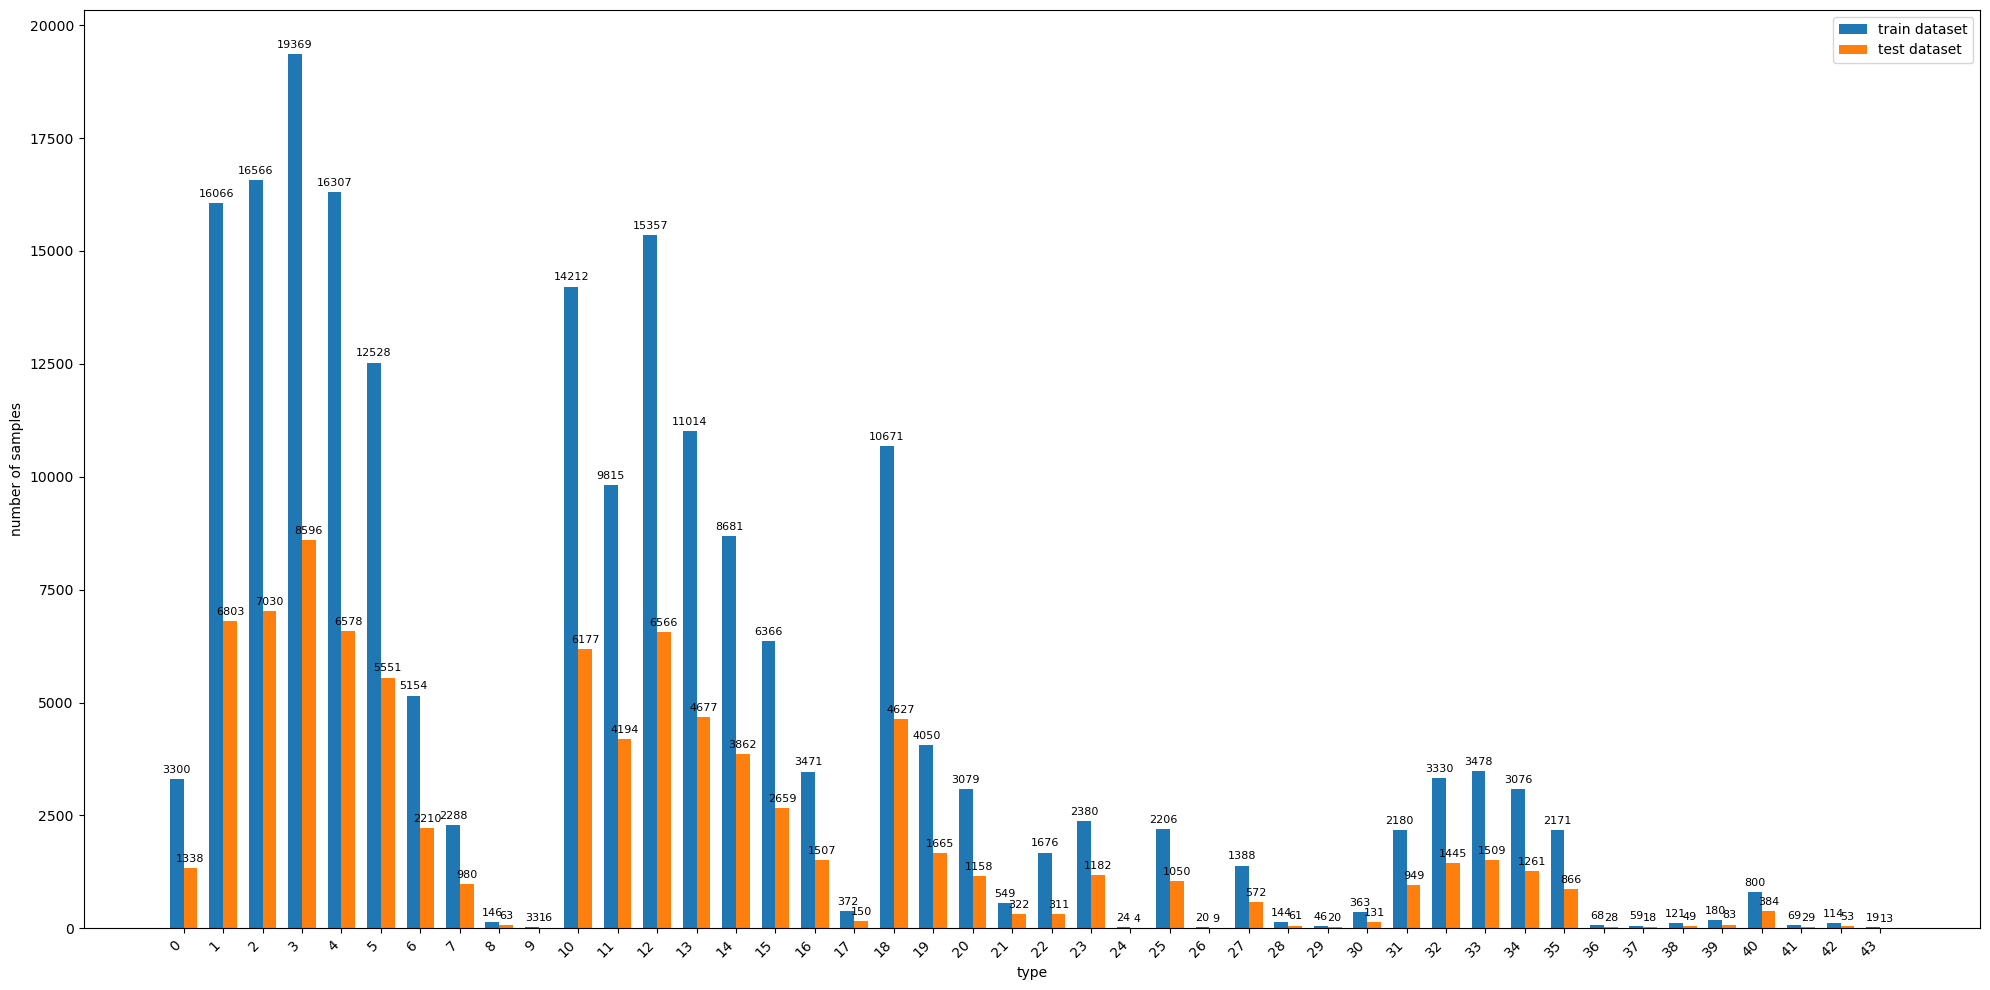

In [30]:
import numpy as np
from tqdm import tqdm
from collections import Counter
# ÊûÑÂª∫Êï∞ÊçÆÈõÜ
def create_dataset(data, sequence_length):
    """
    Â∞ÜËæìÂÖ•Êï∞ÊçÆÂàÜÂâ≤‰∏∫ÈïøÂ∫¶‰∏∫ sequence_length ÁöÑÂ∫èÂàó„ÄÇ
    """
    sequences = []
    for i in range(len(data) - sequence_length +1): #Á™óÂè£ÊòØ‰∏Ä‰∏™‰∏Ä‰∏™Êé®Âêé,ÊâÄ‰ª•Â¶ÇÊûú‰∏ÄË°åÂéüÊú¨Êúâ110ÁªÑÊï∞ÊçÆ,ÈÇ£‰πàÂ∞±‰ºö‰∫ßÁîü110-sequence_length+1‰∏™ Á™óÊ†º
        # ÊûÑÂª∫Â∫èÂàó
        sequences.append(data[i:i + sequence_length])
    return sequences

# ÂèÇÊï∞
sequence_length = 2

sequences = []
X = []
y = []
for row in cy_data_encoded:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1,:, 0].reshape(-1,sequence_length,1))  # Èô§ÂéªÊúÄÂêé‰∏Ä‰∏™Â∫èÂàó,Âπ∂‰∏îÂè™ÂèñÁä∂ÊÄÅ
    y.append(sequence[1:, -1,0].reshape(-1,1))   # Èô§ÂéªÁ¨¨‰∏Ä‰∏™Â∫èÂàó,Âπ∂‰∏îÂè™ÂèñÁä∂ÊÄÅ

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)

# Â∞ÜÊï∞ÊçÆÂàíÂàÜ‰∏∫ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÔºåÂèØ‰ª•ÊåáÂÆöÊµãËØïÈõÜÁöÑÂ§ßÂ∞èÂíåÈöèÊú∫ÁßçÂ≠ê
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)




# Ëé∑ÂèñËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ‰∏≠ÁöÑÂîØ‰∏ÄÁ±ªÂà´
unique_train_classes = np.unique(y_train)
unique_test_classes = np.unique(y_test)

# Ëé∑ÂèñÊÄªÁöÑÁ±ªÂà´ËåÉÂõ¥ÔºàÈÄöËøá state_encoder ÁöÑÁ±ªÂà´ÊÄªÊï∞Ôºâ
total_classes = np.arange(len(state_encoder.classes_))

# ÁªüËÆ°ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ‰∏≠ÁöÑÁ±ªÂà´Êï∞Èáè
num_train_classes = len(unique_train_classes)
num_test_classes = len(unique_test_classes)


# Ê£ÄÊü•ËÆ≠ÁªÉÈõÜ‰∏≠ÊòØÂê¶Áº∫Â∞ëÊüê‰∫õÁ±ªÂà´
missing_classes_in_train = set(total_classes) - set(unique_train_classes)
# Ê£ÄÊü•ÊµãËØïÈõÜ‰∏≠ÊòØÂê¶Áº∫Â∞ëÊüê‰∫õÁ±ªÂà´
missing_classes_in_test = set(total_classes) - set(unique_test_classes)



# ËæìÂá∫ÁªìÊûú
print(f"ËÆ≠ÁªÉÈõÜ‰∏≠ÂåÖÂê´ÁöÑÁ±ªÂà´Êï∞Èáè: {num_train_classes}")
print(f"ÊµãËØïÈõÜ‰∏≠ÂåÖÂê´ÁöÑÁ±ªÂà´Êï∞Èáè: {num_test_classes}")
print(f"ÊÄªÁ±ªÂà´Êï∞Èáè: {len(total_classes)}")

if missing_classes_in_train:
    print(f"ËÆ≠ÁªÉÈõÜ‰∏≠Áº∫Â§±ÁöÑÁ±ªÂà´: {missing_classes_in_train}")
else:
    print("ËÆ≠ÁªÉÈõÜ‰∏≠Ê≤°ÊúâÁº∫Â§±‰ªª‰ΩïÁ±ªÂà´„ÄÇ")


if missing_classes_in_test:
    print(f"ÊµãËØïÈõÜ‰∏≠Áº∫Â§±ÁöÑÁ±ªÂà´: {missing_classes_in_test}")
else:
    print("ÊµãËØïÈõÜ‰∏≠Ê≤°ÊúâÁº∫Â§±‰ªª‰ΩïÁ±ªÂà´„ÄÇ")
    
    
# Ëé∑Âèñ state_encoder.classes_ ÁöÑÂÜÖÂÆπ
classes = state_encoder.classes_

# ÂÆö‰πâÈúÄË¶ÅÊü•ËØ¢ÁöÑÁ±ªÂà´Á¥¢Âºï
target_indices = [8,9,17,24,26,28,29,30,36,37,38,39,41,42,43]

# ËæìÂá∫ÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞
print("Á±ªÂà´Á¥¢ÂºïÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö")
for idx in target_indices:
    if idx < len(classes):  # Á°Æ‰øùÁ¥¢ÂºïÂú®ËåÉÂõ¥ÂÜÖ
        print(f"Á±ªÂà´ {idx}: {classes[idx]}")
    else:
        print(f"Á±ªÂà´ {idx} Ë∂ÖÂá∫‰∫ÜËåÉÂõ¥ÔºåÊó†Ê≥ïÊâæÂà∞ÂØπÂ∫îÁâ©Áßç„ÄÇ")
        
        
# Ëé∑ÂèñÊÄªÁöÑÁ±ªÂà´ËåÉÂõ¥ÔºàÈÄöËøá state_encoder ÁöÑÁ±ªÂà´ÊÄªÊï∞Ôºâ
total_classes = np.arange(len(state_encoder.classes_))

# ÁªüËÆ°ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨Âá∫Áé∞Ê¨°Êï∞
train_class_counts = Counter(y_train.flatten())  # ÁªüËÆ°ËÆ≠ÁªÉÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÂá∫Áé∞Ê¨°Êï∞
test_class_counts = Counter(y_test.flatten())    # ÁªüËÆ°ÊµãËØïÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÂá∫Áé∞Ê¨°Êï∞

# ËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑÔºåÊåâÁ±ªÂà´È°∫Â∫èÊéíÂàó
train_class_distribution = np.zeros(len(total_classes), dtype=int)
test_class_distribution = np.zeros(len(total_classes), dtype=int)

for cls in total_classes:
    train_class_distribution[cls] = train_class_counts.get(cls, 0)
    test_class_distribution[cls] = test_class_counts.get(cls, 0)
    
# # ËæìÂá∫ÁªìÊûú
# print("ËÆ≠ÁªÉÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨ÂàÜÂ∏É:")
# for cls in total_classes:
#     print(f"Á±ªÂà´ {cls}: {train_class_distribution[cls]} Ê¨°")

# print("\nÊµãËØïÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨ÂàÜÂ∏É:")
# for cls in total_classes:
#     print(f"Á±ªÂà´ {cls}: {test_class_distribution[cls]} Ê¨°")    
    
# ÁªòÂà∂Áõ¥ÊñπÂõæ
x = np.arange(len(total_classes))  # Á±ªÂà´Á¥¢Âºï
width = 0.35  # Áõ¥ÊñπÂõæÂÆΩÂ∫¶

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, train_class_distribution, width, label='train dataset')
rects2 = ax.bar(x + width/2, test_class_distribution, width, label='test dataset')

# Ê∑ªÂä†Ê†áÁ≠æ„ÄÅÊ†áÈ¢òÂíåÂõæ‰æã
ax.set_xlabel('type')
ax.set_ylabel('number of samples')
ax.set_xticks(x)
ax.set_xticklabels([f"{cls}" for cls in total_classes], rotation=45, ha='right')
ax.legend()

# Âú®Êü±Áä∂Âõæ‰∏äÊñπÊòæÁ§∫ÂÖ∑‰ΩìÊï∞ÂÄº
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=8)

autolabel(rects1)
autolabel(rects2)

# ÊòæÁ§∫ÂõæÂΩ¢
plt.tight_layout()
plt.show()

In [7]:
print("ÊâÄÊúâÁâ©ÁßçÁ±ªÂûãÁöÑÊï∞ÈáèÔºö",len(state_encoder.classes_))
#state_encoder.classes_

# Ëé∑Âèñ state_encoder.classes_ ÁöÑÂÜÖÂÆπ
classes = state_encoder.classes_

# ËæìÂá∫ÊØè‰∏™Áâ©ÁßçÁöÑÁºñÂè∑ÂèäÂÖ∂ÂØπÂ∫îÁöÑÂêçÁß∞
print("Áâ©ÁßçÁºñÂè∑ÂèäÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö")
for idx, class_name in enumerate(classes):
    print(f"Á±ªÂà´ {idx}: {class_name}")

ÊâÄÊúâÁâ©ÁßçÁ±ªÂûãÁöÑÊï∞ÈáèÔºö 39
Áâ©ÁßçÁºñÂè∑ÂèäÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö
Á±ªÂà´ 0: 1_0_0
Á±ªÂà´ 1: 1_0_1
Á±ªÂà´ 2: 1_0_2
Á±ªÂà´ 3: 1_0_3
Á±ªÂà´ 4: 1_0_4
Á±ªÂà´ 5: 1_0_5
Á±ªÂà´ 6: 1_0_6
Á±ªÂà´ 7: 1_0_7
Á±ªÂà´ 8: 1_0_8
Á±ªÂà´ 9: 1_0_9
Á±ªÂà´ 10: 1_1_0
Á±ªÂà´ 11: 1_1_1
Á±ªÂà´ 12: 1_1_2
Á±ªÂà´ 13: 1_1_3
Á±ªÂà´ 14: 1_1_4
Á±ªÂà´ 15: 1_1_5
Á±ªÂà´ 16: 1_1_6
Á±ªÂà´ 17: 1_1_7
Á±ªÂà´ 18: 1_2_0
Á±ªÂà´ 19: 1_2_1
Á±ªÂà´ 20: 1_2_2
Á±ªÂà´ 21: 1_2_3
Á±ªÂà´ 22: 1_2_4
Á±ªÂà´ 23: 1_2_5
Á±ªÂà´ 24: 1_2_6
Á±ªÂà´ 25: 1_3_0
Á±ªÂà´ 26: 2_0_10
Á±ªÂà´ 27: 2_0_4
Á±ªÂà´ 28: 2_0_5
Á±ªÂà´ 29: 2_0_6
Á±ªÂà´ 30: 2_0_7
Á±ªÂà´ 31: 2_0_8
Á±ªÂà´ 32: 2_0_9
Á±ªÂà´ 33: 2_1_1
Á±ªÂà´ 34: 2_2_0
Á±ªÂà´ 35: 2_3_0
Á±ªÂà´ 36: 2_4_0
Á±ªÂà´ 37: 3_9_0
Á±ªÂà´ 38: 3_9_2


### 1.4ÂçïËæìÂá∫ÂõûÂΩí‰ªªÂä°:X4Áª¥ÔºàÁâ©Áßç+Êó∂Èó¥ÔºâÔºåy3Áª¥ÔºàÁâ©ÁßçÔºâ

ËÆæËÆ°XÂíåy

In [10]:
import numpy as np
from tqdm import tqdm

# ÊûÑÂª∫Êï∞ÊçÆÈõÜ
def create_dataset(data, sequence_length):
    """
    Â∞ÜËæìÂÖ•Êï∞ÊçÆÂàÜÂâ≤‰∏∫ÈïøÂ∫¶‰∏∫ sequence_length ÁöÑÂ∫èÂàó„ÄÇ
    """
    sequences = []
    for i in range(len(data) - sequence_length+1): #Á™óÂè£ÊòØ‰∏Ä‰∏™‰∏Ä‰∏™Êé®Âêé,ÊâÄ‰ª•Â¶ÇÊûú‰∏ÄË°åÂéüÊú¨Êúâ110ÁªÑÊï∞ÊçÆ,ÈÇ£‰πàÂ∞±‰ºö‰∫ßÁîü110-sequence_length+1‰∏™ Á™óÊ†º
        # ÊûÑÂª∫Â∫èÂàó
        sequences.append(data[i:i + sequence_length])
    return sequences

# ÂèÇÊï∞
sequence_length = 3

sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # Èô§ÂéªÊúÄÂêé‰∏Ä‰∏™Â∫èÂàó
    y.append(sequence[1:, -1][:,:-1])  # Ê≤°ÊúâÈóÆÈ¢òÔºåÂõ†‰∏∫ËøûÁª≠ÁöÑsequence‰πãÈó¥‰∏≠Èó¥ÊÆµÊú¨Êù•Â∞±Áõ∏Âêå

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)
print('sequences')
print(sequences[1].shape,sequences[1])
print('shape of X')
print(X[1].shape,X[1])
print('shape of y')
print(y[2].shape,y[2])

sequences
(3, 3, 4) [[[  3   9   0  55]
  [  1   2   0 128]
  [  1   1   2  75]]

 [[  1   2   0 128]
  [  1   1   2  75]
  [  1   0   4 366]]

 [[  1   1   2  75]
  [  1   0   4 366]
  [  1   0   6 196]]]
shape of X
(2, 3, 4) [[[  3   9   0  55]
  [  1   2   0 128]
  [  1   1   2  75]]

 [[  1   2   0 128]
  [  1   1   2  75]
  [  1   0   4 366]]]
shape of y
(12, 3) [[1 2 2]
 [1 1 3]
 [1 0 2]
 [1 0 1]
 [1 1 0]
 [1 0 1]
 [1 0 3]
 [1 0 5]
 [1 0 4]
 [1 1 5]
 [1 0 4]
 [1 0 6]]


ÁªüËÆ°ÂàíÂàÜX,yÂêéÁöÑÊ†∑Êú¨Êï∞ÈáèÂàÜÂ∏É

ÊÄªÂÖ±ÊúâÁâ©ÁßçÁßçÁ±ªÔºö 43
ÂêÑÁâ©ÁßçÁ±ªÂûãÂèäÂÖ∂Êï∞ÈáèÔºö
(1, 0, 3) 18420
(1, 1, 4) 6023
(1, 0, 5) 12194
(1, 0, 7) 3066
(1, 0, 4) 15390
(1, 0, 6) 7564
(1, 2, 2) 1051
(1, 1, 3) 7794
(1, 0, 2) 13947
(1, 0, 1) 12090
(1, 1, 0) 6567
(1, 1, 5) 4304
(1, 1, 1) 6998
(1, 1, 2) 9936
(1, 0, 0) 1959
(1, 2, 0) 1964
(2, 0, 8) 4031
(2, 0, 9) 2775
(1, 1, 6) 1963
(2, 0, 6) 4130
(2, 0, 10) 1770
(1, 2, 1) 1703
(2, 0, 7) 4570
(1, 2, 5) 970
(1, 1, 7) 355
(1, 3, 0) 177
(2, 2, 0) 51
(1, 0, 8) 65
(2, 0, 5) 2668
(1, 2, 4) 679
(2, 3, 0) 15
(3, 9, 0) 2
(1, 0, 9) 11
(2, 0, 4) 380
(2, 1, 1) 34
(1, 2, 6) 20
(2, 4, 0) 22
(1, 2, 3) 255
(2, 0, 3) 46
(2, 0, 11) 196
(1, 4, 0) 2
(3, 0, 10) 89
(2, 1, 8) 63


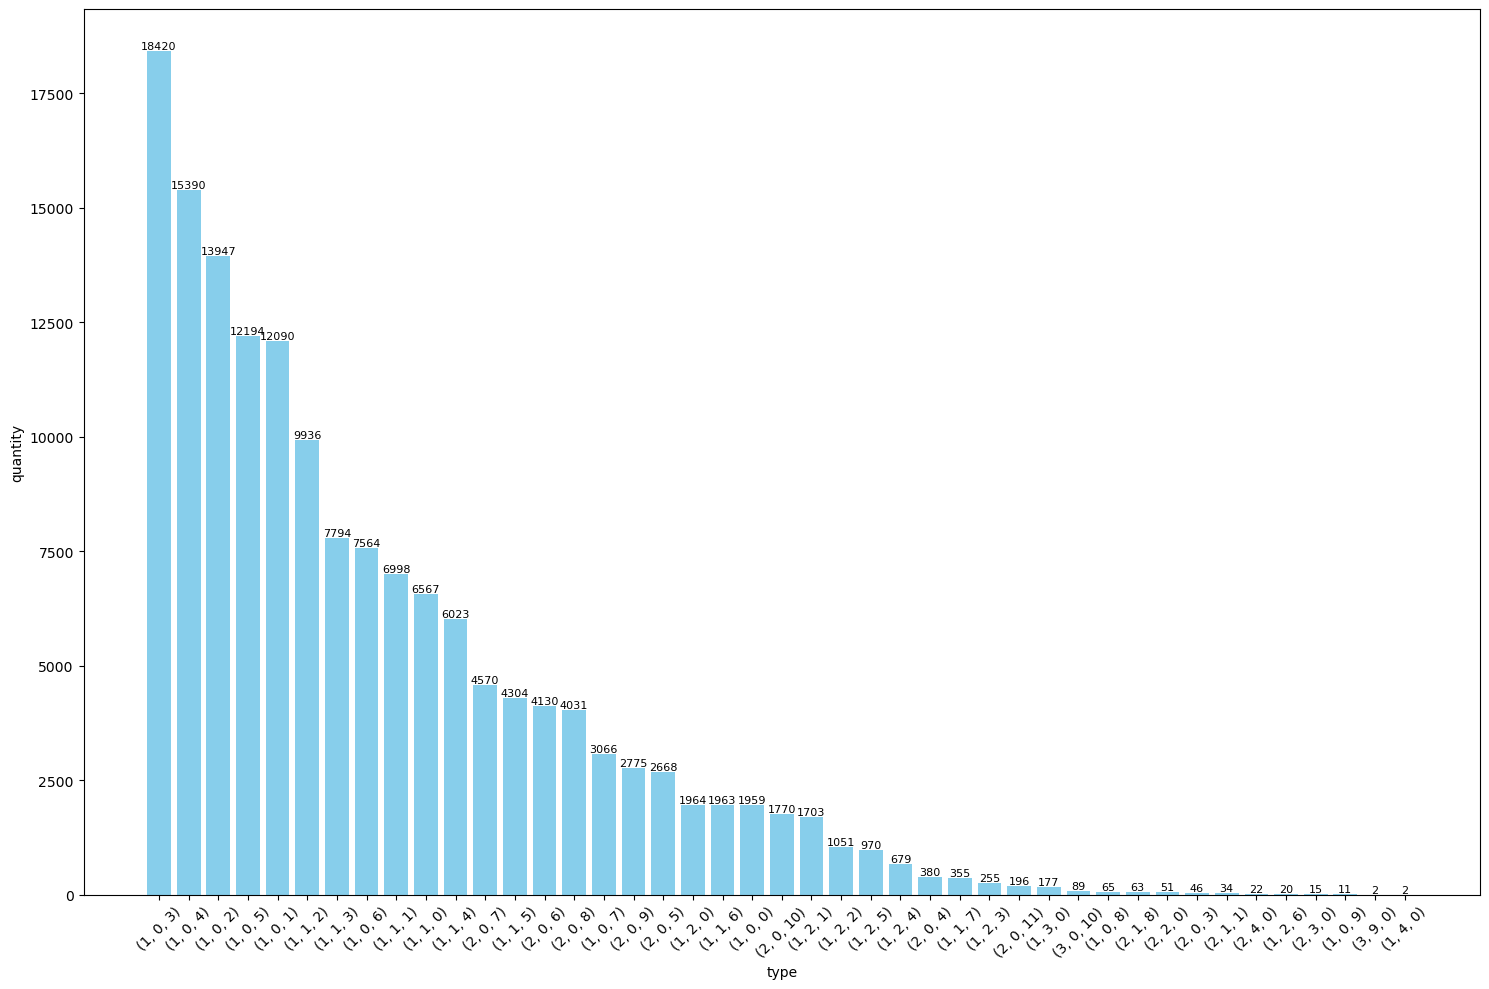

In [11]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# ÂÅáËÆæ y ÊòØ dtype=objectÔºåÊØè‰∏™ÂÖÉÁ¥†‰∏∫‰∏Ä‰∏™ numpy Êï∞ÁªÑÔºåÂΩ¢Áä∂ÂèØËÉΩ‰∏∫ (n, 3)
# ‰æãÂ¶ÇÔºö
# y = np.array([
#         np.array([[1, 1, 2],
#                   [1, 0, 4]]),
#         np.array([[1, 1, 2],
#                   [1, 0, 6],
#                   [1, 0, 4]])
#     ], dtype=object)

# ÈÅçÂéÜ y ‰∏≠ÁöÑÊØè‰∏™Êï∞ÁªÑÔºåÂ∞ÜÊØè‰∏™Âü∫Êú¨Áâ©ÁßçËΩ¨Êç¢‰∏∫ tuple ÂêéÊî∂ÈõÜÂà∞ÂàóË°®‰∏≠
species_list = []
for arr in y:
    for sp in arr:
        species_list.append(tuple(sp))  # ËΩ¨‰∏∫ tuple ‰æø‰∫éËÆ°Êï∞

# ‰ΩøÁî® Counter ÁªüËÆ°ÊØèÁßçÁâ©ÁßçÂá∫Áé∞ÁöÑÊ¨°Êï∞
species_counter = Counter(species_list)
print("ÊÄªÂÖ±ÊúâÁâ©ÁßçÁßçÁ±ªÔºö", len(species_counter))
print("ÂêÑÁâ©ÁßçÁ±ªÂûãÂèäÂÖ∂Êï∞ÈáèÔºö")
for species, count in species_counter.items():
    print(species, count)

# ÂØπËÆ°Êï∞ÁªìÊûúËøõË°åÈôçÂ∫èÊéíÂ∫è
sorted_species = sorted(species_counter.items(), key=lambda x: x[1], reverse=True)
labels = [str(item[0]) for item in sorted_species]
counts = [item[1] for item in sorted_species]

# ÁªòÂà∂Êù°ÂΩ¢Âõæ
plt.figure(figsize=(15, 10))
bars = plt.bar(labels, counts, color='skyblue')
plt.xlabel("type")
plt.ylabel("quantity")
plt.xticks(rotation=45)

# Âú®ÊØè‰∏™Êù°ÂΩ¢Âõæ‰∏äÊ†áÂá∫Êï∞Èáè
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom',fontsize = 8)

plt.tight_layout()
plt.show()


ÂàíÂàÜËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ

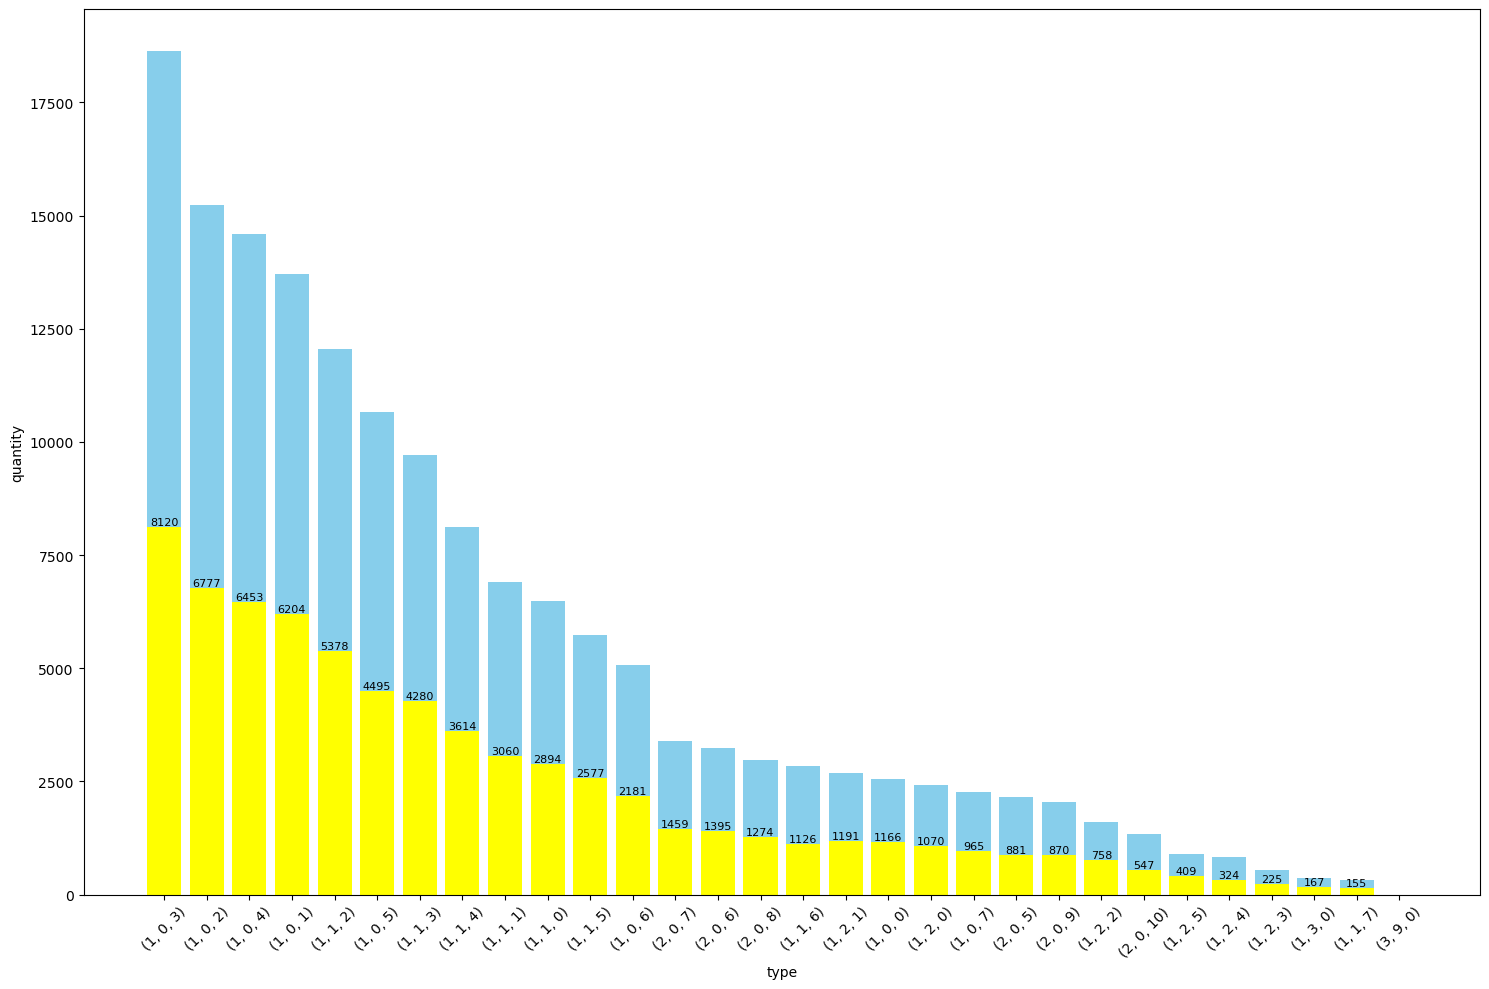

(159379, 6, 4)
(70015, 6, 4)
(159379, 3)
(70015, 3)


In [14]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Â∞ÜÊï∞ÊçÆÂàíÂàÜ‰∏∫ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÔºåÂèØ‰ª•ÊåáÂÆöÊµãËØïÈõÜÁöÑÂ§ßÂ∞èÂíåÈöèÊú∫ÁßçÂ≠ê
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ÈÅçÂéÜ y ‰∏≠ÁöÑÊØè‰∏™Êï∞ÁªÑÔºåÂ∞ÜÊØè‰∏™Âü∫Êú¨Áâ©ÁßçËΩ¨Êç¢‰∏∫ tuple ÂêéÊî∂ÈõÜÂà∞ÂàóË°®‰∏≠
species_list_train = []
for arr in y_train:
    for sp in arr:
        species_list_train.append(tuple(sp))  # ËΩ¨‰∏∫ tuple ‰æø‰∫éËÆ°Êï∞
        
species_list_test = []
for arr in y_test:
    for sp in arr:
        species_list_test.append(tuple(sp))  # ËΩ¨‰∏∫ tuple ‰æø‰∫éËÆ°Êï∞

# ‰ΩøÁî® Counter ÁªüËÆ°ÊØèÁßçÁâ©ÁßçÂá∫Áé∞ÁöÑÊ¨°Êï∞
species_counter_train = Counter(species_list_train)
species_counter_test = Counter(species_list_test)

# ÂØπËÆ°Êï∞ÁªìÊûúËøõË°åÈôçÂ∫èÊéíÂ∫è
sorted_species_train = sorted(species_counter_train.items(), key=lambda x: x[1], reverse=True)
labels_train = [str(item[0]) for item in sorted_species_train]
counts_train = [item[1] for item in sorted_species_train]

sorted_species_test = sorted(species_counter_test.items(), key=lambda x: x[1], reverse=True)
labels_test = [str(item[0]) for item in sorted_species_test]
counts_test = [item[1] for item in sorted_species_test]

# ÁªòÂà∂Êù°ÂΩ¢Âõæ
plt.figure(figsize=(15, 10))
bars = plt.bar(labels_train, counts_train, color='skyblue')
bars = plt.bar(labels_test, counts_test, color='yellow')
plt.xlabel("type")
plt.ylabel("quantity")
plt.xticks(rotation=45)

# Âú®ÊØè‰∏™Êù°ÂΩ¢Âõæ‰∏äÊ†áÂá∫Êï∞Èáè
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom',fontsize = 8)

plt.tight_layout()
plt.show()



X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape)
print(X_test.shape)


print(y_train.shape)
print(y_test.shape)

### 1.5ÔºàÈ¢ÑÊµã‰∫ßÁâ©Á±ªÂûãÔºöMoS6ËøòÊòØMoS7Ôºâ

ËÆæËÆ°XÂíåy

In [51]:
# import numpy as np
from tqdm import tqdm

# ÂèÇÊï∞
sequence_length = 9

#============================ÂÄíÂ∫èÁªüËÆ°ÁöÑ‰ª£Á†Å=======================================
X = []
y = []
for row in cy_data:
    X.append(row[len(row)-sequence_length-1:-1])
    y.append(row[-1][:-1])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)



#==========================Ê≠£Â∫èÁªüËÆ°ÁöÑ‰ª£Á†Å==========================================






# Âè™‰øùÁïô X ‰∏≠ÊØè‰∏™ÂêëÈáèÁöÑÂâç‰∏â‰∏™Áª¥Â∫¶(ÂèØÈÄâ)
# X = X[:, :, :3]

# X = np.array(X,dtype=object)
# y = np.array(y,dtype=object)    
print('shape of X',X.shape)

print(X[7])
print('shape of y',y.shape)
print(y[7])


shape of X (13531, 9, 4)
[[  1.   2.   2.   5.]
 [  1.   1.   1.  54.]
 [  1.   1.   3.  20.]
 [  1.   0.   2. 421.]
 [  1.   0.   4.  21.]
 [  1.   0.   2. 148.]
 [  1.   1.   3.  58.]
 [  1.   1.   5.   1.]
 [  1.   0.   4.  92.]]
shape of y (13531, 3)
[1. 0. 6.]


ÁªüËÆ°Ê†∑Êú¨Êï∞Èáè

ÊÄªÂÖ±ÊúâÁâ©ÁßçÁßçÁ±ªÔºö 2
ÂêÑÁâ©ÁßçÁ±ªÂûãÂèäÂÖ∂Êï∞ÈáèÔºö
(1.0, 0.0, 6.0) 9316
(1.0, 0.0, 7.0) 4215


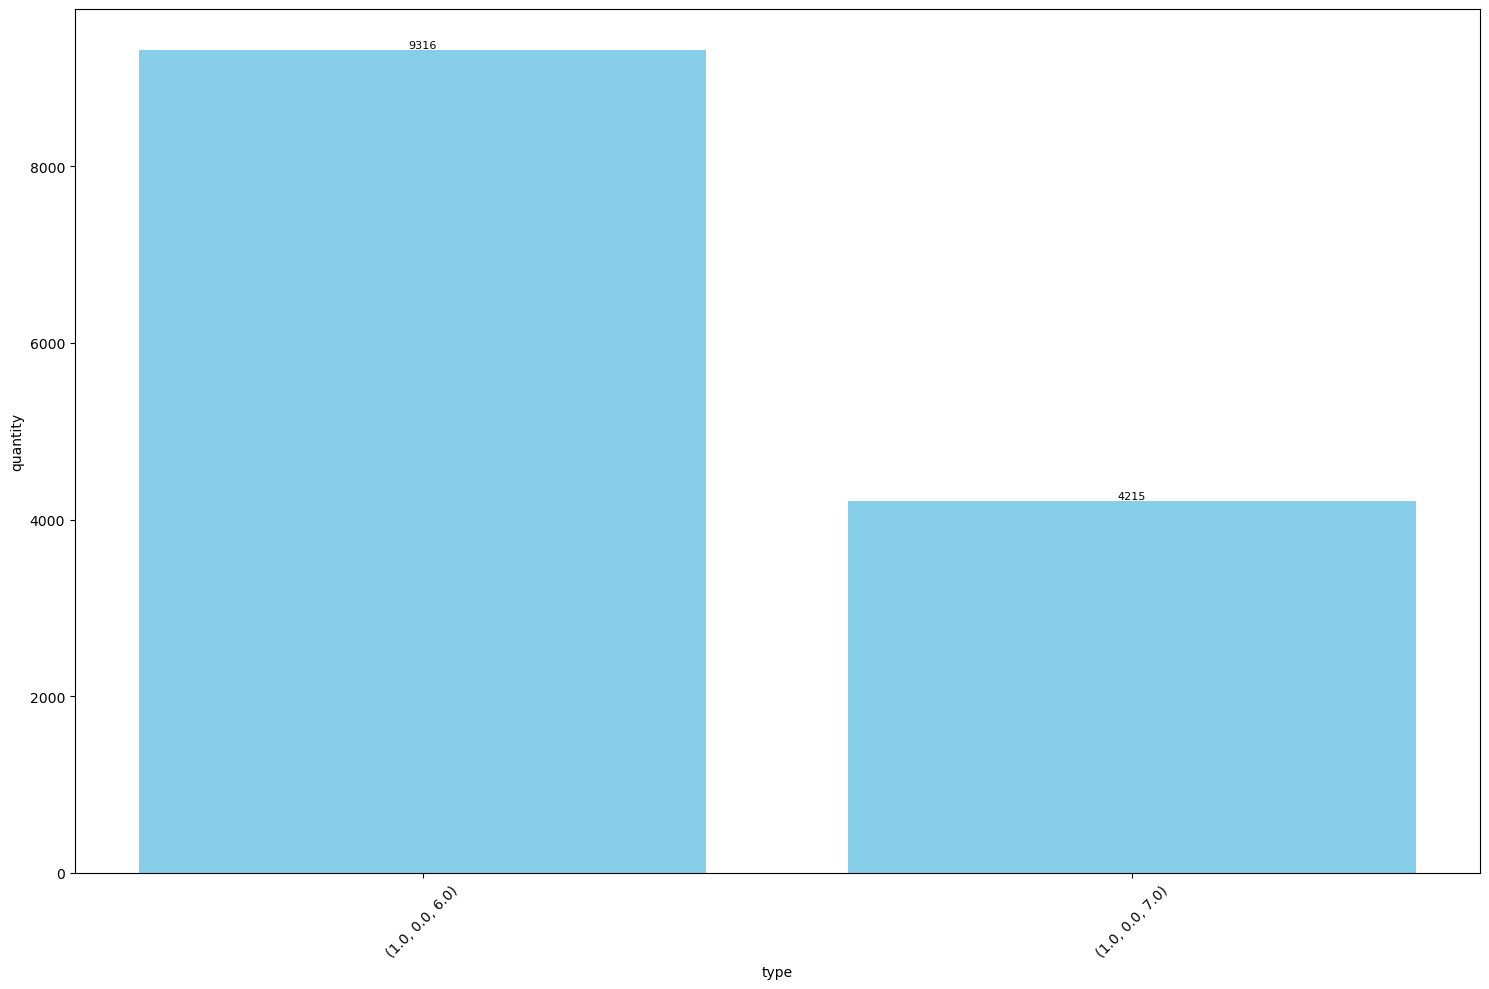

In [52]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# ÂÅáËÆæ y ÊòØ dtype=objectÔºåÊØè‰∏™ÂÖÉÁ¥†‰∏∫‰∏Ä‰∏™ numpy Êï∞ÁªÑÔºåÂΩ¢Áä∂ÂèØËÉΩ‰∏∫ (n, 3)
# ‰æãÂ¶ÇÔºö
# y = np.array([
#         np.array([[1, 1, 2],
#                   [1, 0, 4]]),
#         np.array([[1, 1, 2],
#                   [1, 0, 6],
#                   [1, 0, 4]])
#     ], dtype=object)

# ÈÅçÂéÜ y ‰∏≠ÁöÑÊØè‰∏™Êï∞ÁªÑÔºåÂ∞ÜÊØè‰∏™Âü∫Êú¨Áâ©ÁßçËΩ¨Êç¢‰∏∫ tuple ÂêéÊî∂ÈõÜÂà∞ÂàóË°®‰∏≠
species_list = []
for arr in y:
    species_list.append(tuple(arr))  # ËΩ¨‰∏∫ tuple ‰æø‰∫éËÆ°Êï∞

# ‰ΩøÁî® Counter ÁªüËÆ°ÊØèÁßçÁâ©ÁßçÂá∫Áé∞ÁöÑÊ¨°Êï∞
species_counter = Counter(species_list)
print("ÊÄªÂÖ±ÊúâÁâ©ÁßçÁßçÁ±ªÔºö", len(species_counter))
print("ÂêÑÁâ©ÁßçÁ±ªÂûãÂèäÂÖ∂Êï∞ÈáèÔºö")
for species, count in species_counter.items():
    print(species, count)

# ÂØπËÆ°Êï∞ÁªìÊûúËøõË°åÈôçÂ∫èÊéíÂ∫è
sorted_species = sorted(species_counter.items(), key=lambda x: x[1], reverse=True)
labels = [str(item[0]) for item in sorted_species]
counts = [item[1] for item in sorted_species]

# ÁªòÂà∂Êù°ÂΩ¢Âõæ
plt.figure(figsize=(15, 10))
bars = plt.bar(labels, counts, color='skyblue')
plt.xlabel("type")
plt.ylabel("quantity")
plt.xticks(rotation=45)

# Âú®ÊØè‰∏™Êù°ÂΩ¢Âõæ‰∏äÊ†áÂá∫Êï∞Èáè
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom',fontsize = 8)

plt.tight_layout()
plt.show()


Âπ≥Ë°°Ê†∑Êú¨Êï∞Èáè

In [53]:
import numpy as np
from collections import defaultdict

# ÁªüËÆ°ÊØè‰∏™Áâ©ÁßçÂØπÂ∫îÁöÑÊ†∑Êú¨Á¥¢ÂºïÔºàÂ∞ÜÊØè‰∏™ y ËΩ¨Êç¢‰∏∫ tuple ‰Ωú‰∏∫ÈîÆÔºâ
species_to_indices = defaultdict(list)
for idx, arr in enumerate(y):
    species = tuple(arr)
    species_to_indices[species].append(idx)

# ËÆæÂÆöÁõÆÊ†áÊ†∑Êú¨Êï∞Èáè
desired_count = 4215

balanced_indices = []
for species, indices in species_to_indices.items():
    if len(indices) > desired_count:
        # Êï∞ÈáèÂ§ö‰∫éÁõÆÊ†áÊó∂ÔºåÈöèÊú∫ÊäΩÊ†∑ desired_count ‰∏™Á¥¢Âºï
        sampled_indices = np.random.choice(indices, desired_count, replace=False)
    else:
        # Êï∞Èáè‰∏çË∂≥Êó∂ÔºåÂÖ®ÈÉ®‰øùÁïô
        sampled_indices = indices
    balanced_indices.extend(sampled_indices)

# ËΩ¨Êç¢‰∏∫ numpy Êï∞ÁªÑÔºåÂπ∂ÈöèÊú∫Êâì‰π±Á¥¢ÂºïÈ°∫Â∫è
balanced_indices = np.array(balanced_indices)
np.random.shuffle(balanced_indices)

# Âà©Áî®ÊäΩÊ†∑ÂêéÁöÑÁ¥¢ÂºïÊûÑÈÄ†Êñ∞ÁöÑ X Âíå y
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

print("Âπ≥Ë°°ÂêéÁöÑ X shape:", X_balanced.shape)
print("Âπ≥Ë°°ÂêéÁöÑ y shape:", y_balanced.shape)


Âπ≥Ë°°ÂêéÁöÑ X shape: (8430, 9, 4)
Âπ≥Ë°°ÂêéÁöÑ y shape: (8430, 3)


ÂàíÂàÜËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ

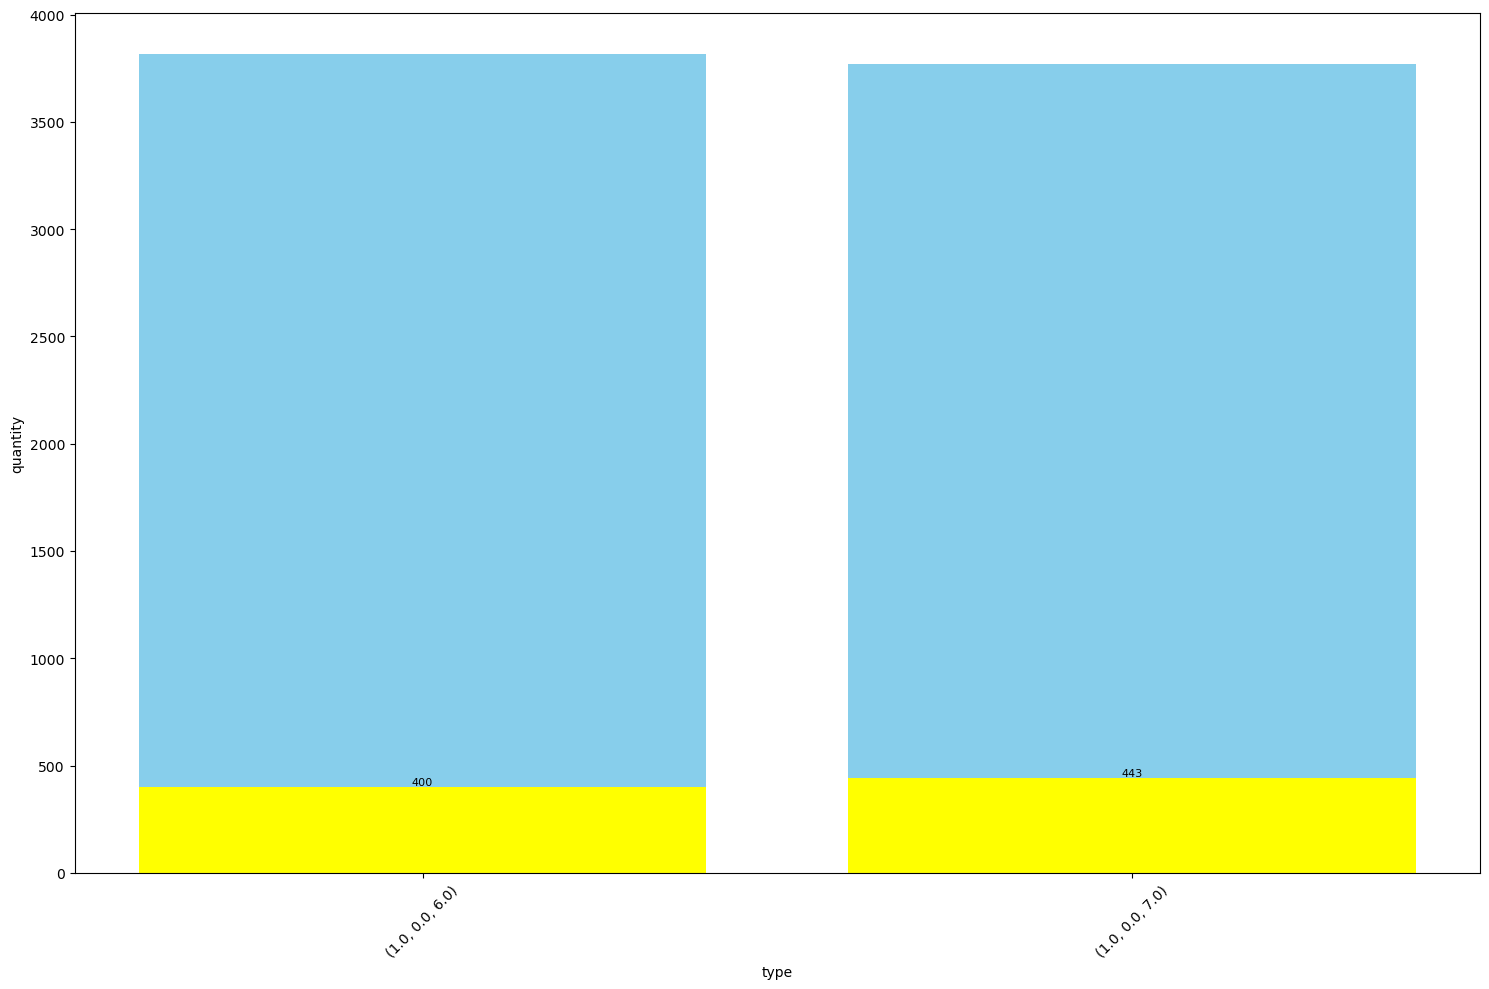

(7587, 9, 4)
(843, 9, 4)
(7587, 3)
(843, 3)


In [54]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Â∞ÜÊï∞ÊçÆÂàíÂàÜ‰∏∫ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÔºåÂèØ‰ª•ÊåáÂÆöÊµãËØïÈõÜÁöÑÂ§ßÂ∞èÂíåÈöèÊú∫ÁßçÂ≠ê
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.1, random_state=42)

# ÈÅçÂéÜ y ‰∏≠ÁöÑÊØè‰∏™Êï∞ÁªÑÔºåÂ∞ÜÊØè‰∏™Âü∫Êú¨Áâ©ÁßçËΩ¨Êç¢‰∏∫ tuple ÂêéÊî∂ÈõÜÂà∞ÂàóË°®‰∏≠
species_list_train = []
for arr in y_train:
    species_list_train.append(tuple(arr))  # ËΩ¨‰∏∫ tuple ‰æø‰∫éËÆ°Êï∞
        
species_list_test = []
for arr in y_test:
    species_list_test.append(tuple(arr))  # ËΩ¨‰∏∫ tuple ‰æø‰∫éËÆ°Êï∞

# ‰ΩøÁî® Counter ÁªüËÆ°ÊØèÁßçÁâ©ÁßçÂá∫Áé∞ÁöÑÊ¨°Êï∞
species_counter_train = Counter(species_list_train)
species_counter_test = Counter(species_list_test)

# ÂØπËÆ°Êï∞ÁªìÊûúËøõË°åÈôçÂ∫èÊéíÂ∫è
sorted_species_train = sorted(species_counter_train.items(), key=lambda x: x[1], reverse=True)
labels_train = [str(item[0]) for item in sorted_species_train]
counts_train = [item[1] for item in sorted_species_train]

sorted_species_test = sorted(species_counter_test.items(), key=lambda x: x[1], reverse=True)
labels_test = [str(item[0]) for item in sorted_species_test]
counts_test = [item[1] for item in sorted_species_test]

# ÁªòÂà∂Êù°ÂΩ¢Âõæ
plt.figure(figsize=(15, 10))
bars = plt.bar(labels_train, counts_train, color='skyblue')
bars = plt.bar(labels_test, counts_test, color='yellow')
plt.xlabel("type")
plt.ylabel("quantity")
plt.xticks(rotation=45)

# Âú®ÊØè‰∏™Êù°ÂΩ¢Âõæ‰∏äÊ†áÂá∫Êï∞Èáè
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom',fontsize = 8)

plt.tight_layout()
plt.show()



print(X_train.shape)
print(X_test.shape)


print(y_train.shape)
print(y_test.shape)

### 2.ÈíàÂØπÂ§öËæìÂá∫(ÂàÜÁ±ª+ÂõûÂΩí)‰ªªÂä°,ËÆæËÆ°XÂíåy1,y2 (ÈíàÂØπcy_data_encodedËøõË°åËÆæËÆ°)

ËÆæËÆ°XÂíåy

In [21]:
# ÊûÑÂª∫Êï∞ÊçÆÈõÜ
def create_dataset(data, sequence_length):
    """
    Â∞ÜËæìÂÖ•Êï∞ÊçÆÂàÜÂâ≤‰∏∫ÈïøÂ∫¶‰∏∫ sequence_length ÁöÑÂ∫èÂàó„ÄÇ
    """
    sequences = []
    for i in range(len(data) - sequence_length+1): #Á™óÂè£ÊòØ‰∏Ä‰∏™‰∏Ä‰∏™Êé®Âêé,ÊâÄ‰ª•Â¶ÇÊûú‰∏ÄË°åÂéüÊú¨Êúâ110ÁªÑÊï∞ÊçÆ,ÈÇ£‰πàÂ∞±‰ºö‰∫ßÁîü110-sequence_length+1‰∏™ Á™óÊ†º
        # ÊûÑÂª∫Â∫èÂàó
        sequences.append(data[i:i + sequence_length])
    return sequences

# ÂèÇÊï∞
sequence_length = 3

sequences = []
# ÊûÑÂª∫ËæìÂÖ• X ÂíåËæìÂá∫ y
X = []       # ËæìÂÖ•Â∫èÂàóÔºöÂΩ¢Áä∂ (n_samples, sequence_length, 2)
y_state = [] # ÁõÆÊ†áÁä∂ÊÄÅÁ±ªÂà´ÔºöÂΩ¢Áä∂ (n_samples,)
y_time = []  # ÁõÆÊ†áÊó∂Èó¥ÔºöÂΩ¢Áä∂ (n_samples,)
for row in cy_data_encoded:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    
    sequences.append(sequence)
    X.append(sequence[:-1])  # Èô§ÂéªÊúÄÂêé‰∏Ä‰∏™Â∫èÂàó
    y_state.append(sequence[1:, -1][:,0])  # Ê≤°ÊúâÈóÆÈ¢òÔºåÂõ†‰∏∫ËøûÁª≠ÁöÑsequence‰πãÈó¥‰∏≠Èó¥ÊÆµÊú¨Êù•Â∞±Áõ∏Âêå
    y_time.append(sequence[1:, -1][:,1])  
    
sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y_state = np.array(y_state,dtype=object)    
y_time = np.array(y_time,dtype=object)    

# Ê£ÄÊü•ÁîüÊàêÁöÑÂ∫èÂàóÂΩ¢Áä∂
print('sequences.shape', cy_data_encoded[0])
print('X.shape', X.shape)  # ËæìÂÖ•ÁöÑÂΩ¢Áä∂
print('y_state', y_state.shape)  # ËæìÂá∫ÁöÑÂΩ¢Áä∂
print('y_time', y_time.shape)  # ËæìÂá∫ÁöÑÂΩ¢Áä∂
print(X[0][:])
print(y_state[0][0]) 
print(y_time[0][0])

sequences.shape [[ 26  55]
 [ 14  18]
 [  0  10]
 [  2 159]
 [ 11  20]
 [  2   5]
 [  4 498]
 [  6 463]]
X.shape (10632,)
y_state (10632,)
y_time (10632,)
[[[ 26  55]
  [ 14  18]
  [  0  10]]

 [[ 14  18]
  [  0  10]
  [  2 159]]

 [[  0  10]
  [  2 159]
  [ 11  20]]

 [[  2 159]
  [ 11  20]
  [  2   5]]

 [[ 11  20]
  [  2   5]
  [  4 498]]]
2
159


(ÁªüËÆ°y_stateÁöÑÊï∞ÈáèÂàÜÂ∏É)

ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨ÂàÜÂ∏É:
Á±ªÂà´ 0: 12784 Ê¨°
Á±ªÂà´ 1: 14544 Ê¨°
Á±ªÂà´ 2: 19151 Ê¨°
Á±ªÂà´ 3: 15808 Ê¨°
Á±ªÂà´ 4: 12533 Ê¨°
Á±ªÂà´ 5: 7542 Ê¨°
Á±ªÂà´ 6: 3088 Ê¨°
Á±ªÂà´ 7: 7463 Ê¨°
Á±ªÂà´ 8: 7419 Ê¨°
Á±ªÂà´ 9: 10809 Ê¨°
Á±ªÂà´ 10: 8483 Ê¨°
Á±ªÂà´ 11: 6473 Ê¨°
Á±ªÂà´ 12: 4333 Ê¨°
Á±ªÂà´ 13: 2050 Ê¨°
Á±ªÂà´ 14: 2447 Ê¨°
Á±ªÂà´ 15: 2047 Ê¨°
Á±ªÂà´ 16: 1258 Ê¨°
Á±ªÂà´ 17: 788 Ê¨°
Á±ªÂà´ 18: 1166 Ê¨°
Á±ªÂà´ 19: 273 Ê¨°
Á±ªÂà´ 20: 2729 Ê¨°
Á±ªÂà´ 21: 4170 Ê¨°
Á±ªÂà´ 22: 4578 Ê¨°
Á±ªÂà´ 23: 3921 Ê¨°
Á±ªÂà´ 24: 2752 Ê¨°
Á±ªÂà´ 25: 36 Ê¨°
Á±ªÂà´ 26: 4 Ê¨°
Á±ªÂà´ 27: 0 Ê¨°


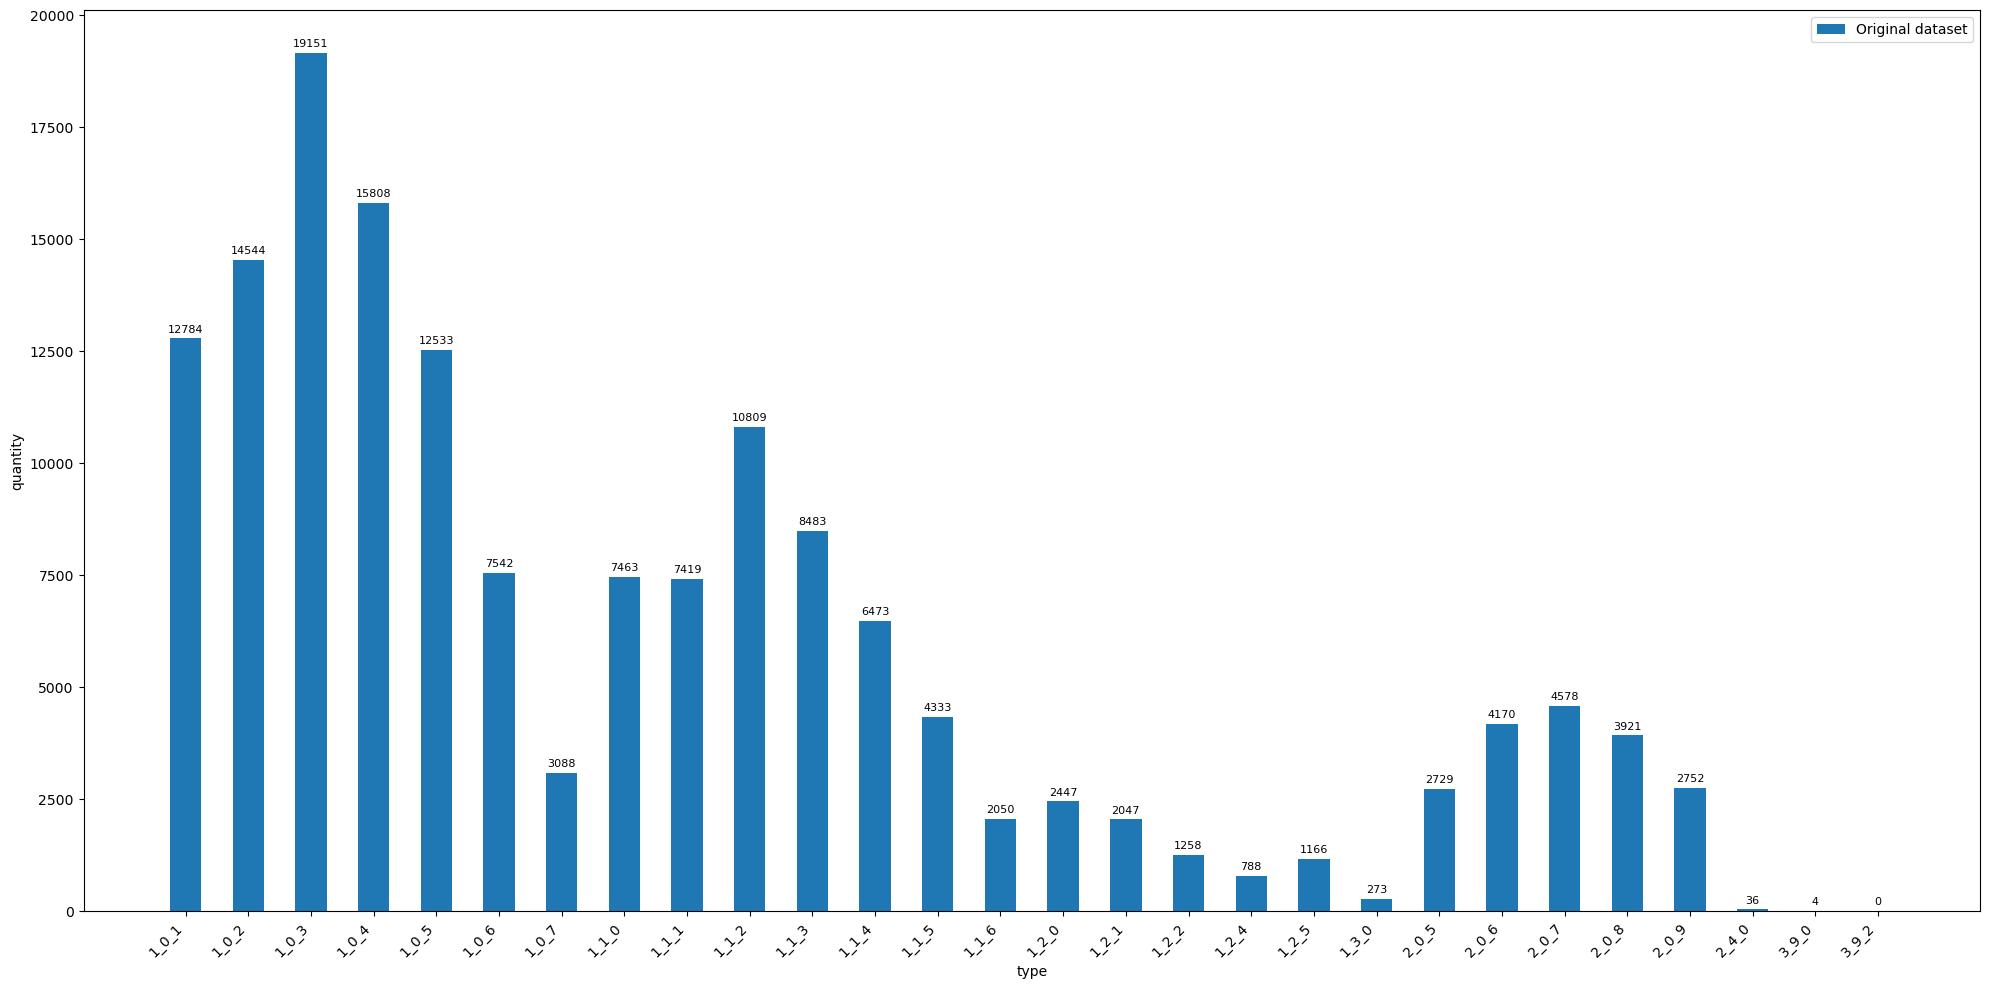

In [22]:
# Â∞ÜÊâÄÊúâ y_state Êï∞ÊçÆÂêàÂπ∂‰∏∫‰∏Ä‰∏™‰∏ÄÁª¥Êï∞ÁªÑ
y_original = np.concatenate(y_state).flatten()
X_original = np.concatenate(X, axis=0)

# ÁªüËÆ°ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨Êï∞
original_class_counts = Counter(y_original)

# Ëé∑ÂèñÊÄªÁöÑÁ±ªÂà´ËåÉÂõ¥ÔºàÈÄöËøá state_encoder ÁöÑÁ±ªÂà´ÊÄªÊï∞Ôºâ
total_classes = np.arange(len(state_encoder.classes_))
# ËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑÔºåÊåâÁ±ªÂà´È°∫Â∫èÊéíÂàó
original_class_distribution = np.zeros(len(total_classes), dtype=int)
for cls in total_classes:
    original_class_distribution[cls] = original_class_counts.get(cls, 0)
    
# ËæìÂá∫ÁªìÊûú
print("ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨ÂàÜÂ∏É:")
for cls in total_classes:
    print(f"Á±ªÂà´ {cls}: {original_class_distribution[cls]} Ê¨°")
    
# ÁªòÂà∂Áõ¥ÊñπÂõæ
x = np.arange(len(total_classes))  # Á±ªÂà´Á¥¢Âºï
width = 0.5  # Áõ¥ÊñπÂõæÂÆΩÂ∫¶

fig, ax = plt.subplots(figsize=(20, 10))
rects = ax.bar(x, original_class_distribution, width, label='Original dataset')

# Ê∑ªÂä†Ê†áÁ≠æ„ÄÅÊ†áÈ¢òÂíåÂõæ‰æã
ax.set_xlabel('type')
ax.set_ylabel('quantity')
ax.set_xticks(x)
ax.set_xticklabels([f"{cls}" for cls in state_encoder.classes_], rotation=45, ha='right')  # ‰ΩøÁî® state_encoder.classes_ ‰∏≠ÁöÑÁ±ªÂà´ÂêçÁß∞
ax.legend()

# Âú®Êü±Áä∂Âõæ‰∏äÊñπÊòæÁ§∫ÂÖ∑‰ΩìÊï∞ÂÄº
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects)

# ÊòæÁ§∫ÂõæÂΩ¢
plt.tight_layout()
plt.show()

ÔºàÁªüËÆ°y_timeÁöÑÊï∞ÈáèÂàÜÂ∏ÉÔºâ

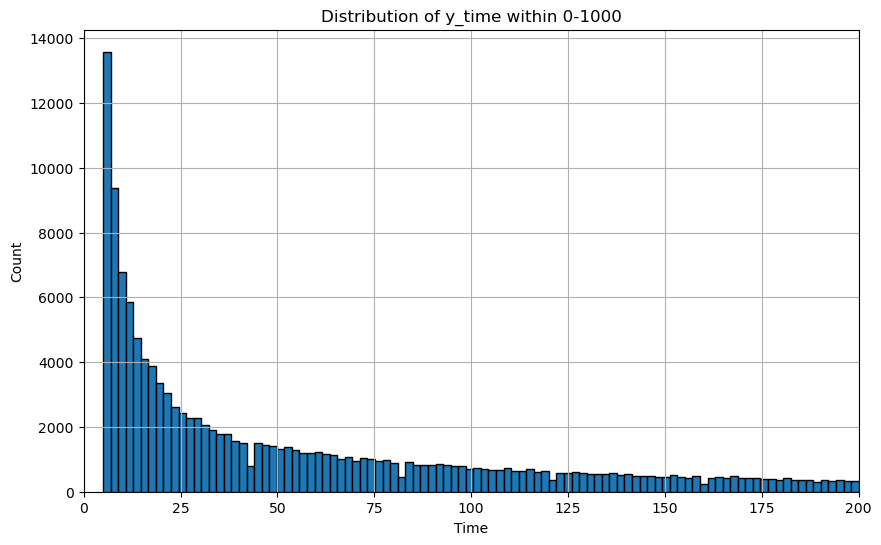

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# ÂÅáËÆæ y_time Â∑≤ÁªèË¢´ÂÆö‰πâÔºåÂπ∂‰∏îÊòØ‰∏Ä‰∏™ÂåÖÂê´Â§ö‰∏™Êï∞ÁªÑÁöÑÂàóË°®ÊàñÁ±ª‰ººÁöÑÁªìÊûÑ„ÄÇ
# Á§∫‰æãÔºöÂ¶ÇÊûúÈúÄË¶ÅÊµãËØïÔºåËØ∑ÂèñÊ∂àÊ≥®Èáä‰ª•‰∏ãË°åÂπ∂Ë∞ÉÊï¥Â∞∫ÂØ∏‰ª•ÂåπÈÖçÂÆûÈôÖÊÉÖÂÜµ
# y_time = [np.random.randint(0, 1500, size=10) for _ in range(5)]  # Á§∫‰æãÊï∞ÊçÆ

# Â∞ÜÊâÄÊúâ y_time Êï∞ÁªÑÂ±ïÂπ≥Êàê‰∏ÄÁª¥Êï∞ÁªÑÔºåÂπ∂Á≠õÈÄâÂá∫ 0-1000 ËåÉÂõ¥ÁöÑÊï∞ÊçÆ
all_y_time = np.concatenate(y_time)
filtered_y_time = all_y_time[(all_y_time >= 0) & (all_y_time <= 200)]

# ÁªòÂà∂Áõ¥ÊñπÂõæ
plt.figure(figsize=(10, 6))
# Â¢ûÂä† bins ÁöÑÊï∞Èáè‰ª•ÁªÜÂåñÊ®™ÂùêÊ†á
plt.hist(filtered_y_time, bins=100, edgecolor='black')  # ËøôÈáåÂ∞Ü bins ËÆæÁΩÆ‰∏∫ 50
plt.xlim(0, 200)  # ËÆæÁΩÆ x ËΩ¥ËåÉÂõ¥‰∏∫ 0 Âà∞ 1000
plt.title('Distribution of y_time within 0-1000')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.show()

ÔºàÁªüËÆ°ÊØèÁßçXÂØπÂ∫îÂ§öÂ∞ëÁßçy‰ª•ÂèäÂÖ∑‰ΩìÁöÑÊØî‰æãÔºâ

In [24]:
import numpy as np
from collections import defaultdict, Counter

def analyze_y_for_each_x(X, y):
    """
    ÁªüËÆ°ÔºöÂØπÁªôÂÆöÁöÑ X, y (ÈïøÂ∫¶Áõ∏Âêå)ÔºåÂÖ∂‰∏≠ X[i].shape = (m_i, 2, 2)Ôºå y[i].shape = (m_i, 1)Ôºå
         Êî∂ÈõÜÊØè‰∏™Â≠êÂ∫èÂàó x_seq ÂØπÂ∫îÂá∫Áé∞‰∫ÜÂì™‰∫õ yÔºåÂπ∂‰∏î y Âá∫Áé∞‰∫ÜÂ§öÂ∞ëÊ¨°„ÄÇ

    ËøîÂõûÔºö
        x2y_distribution: dict,
            key = x_seq_tuple (‰æãÂ¶Ç (1.0, 2.0, 3.0, 4.0) ÁöÑ tuple, Âç≥Â∞Ü (2,2) flatten ÂêéÁöÑÁªìÊûú),
            value = Counter({y_val: freq})ÔºåÁªüËÆ°ËØ• x_seq ÂØπÂ∫îÁöÑ y_val ÂèäÂÖ∂Âá∫Áé∞Ê¨°Êï∞
    """
    x2y_distribution = defaultdict(Counter)

    # ÈÅçÂéÜÊâÄÊúâÂ§ñÂ±ÇÊï∞ÊçÆ
    for i in range(len(X)):
        xi = X[i]  # ÂΩ¢Â¶Ç (m_i, 2, 2)
        yi = y[i]  # ÂΩ¢Â¶Ç (m_i, 1)

        # ÈÅçÂéÜËØ•Êù°Êï∞ÊçÆÈáåÁöÑÊâÄÊúâÂ≠êÂ∫èÂàó
        for j in range(xi.shape[0]):
            # xi[j] ÂΩ¢Â¶Ç (2,2)
            # Â∞ÜÂÖ∂Â±ïÂπ≥Êàê 1D Êï∞ÁªÑÂêéÔºåÂÜçËΩ¨‰∏∫ tuple ‰ª•‰æøÂÅöÂ≠óÂÖ∏ÈîÆ
            seq_tuple = tuple(xi[j].flatten())  
            # y_val ÊòØ‰∏Ä‰∏™Êï¥Êï∞
            y_val = yi[j]
            # Á¥ØÂä†ÁªüËÆ°
            x2y_distribution[seq_tuple][y_val] += 1
    
    return x2y_distribution


def print_y_distribution_for_x(x2y_distribution, top_k=10):
    """
    ÂØπ‰∫é x2y_distribution (Áî±‰∏äÈù¢ÂáΩÊï∞ËøîÂõû)ÔºåÊâìÂç∞Ôºö
      - ÊØè‰∏™ x_seq_tuple ÁöÑÊÄªÂá∫Áé∞Ê¨°Êï∞
      - ËØ• x_seq_tuple ÂØπÂ∫îÁöÑ‰∏çÂêå y ÁöÑÁßçÁ±ªÊï∞
      - ‰∏çÂêå y ÁöÑÂá∫Áé∞Ê¨°Êï∞ÂèäÊâÄÂç†ÊØî‰æã

    ÂèÇÊï∞Ôºö
    - x2y_distribution: dict,
        key = x_seq_tuple, value = Counter({y_val: freq})
    - top_k: Âè™ÊâìÂç∞Âá∫Áé∞ÊÄªÊ¨°Êï∞ÊúÄÂ§öÁöÑÂâç top_k ‰∏™ x_seqÔºå‰ª•Èò≤Ê≠¢ËæìÂá∫ËøáÂ§ö„ÄÇ
             Ëã•‰∏∫ None ÂàôÊâìÂç∞ÊâÄÊúâ x_seq„ÄÇ
    """
    # Â∞ÜÊâÄÊúâ x_seq ÊéíÂ∫èÔºà‰æãÂ¶ÇÔºåÊåâÊÄªÂá∫Áé∞Ê¨°Êï∞‰ªéÂ§ßÂà∞Â∞èÔºâ„ÄÇ
    x_freq_list = []
    for x_seq, counter_for_x in x2y_distribution.items():
        total_count = sum(counter_for_x.values())
        x_freq_list.append((x_seq, total_count))
    
    # ÊåâÂá∫Áé∞ÊÄªÊï∞‰ªéÂ§ßÂà∞Â∞èÊéíÂ∫è
    x_freq_list.sort(key=lambda x: x[1], reverse=True)

    if top_k is not None:
        x_freq_list = x_freq_list[:top_k]
    
    # ‰æùÊ¨°ÊâìÂç∞
    print(f"‰∏ÄÂÖ±Êúâ {len(x2y_distribution)} Áßç‰∏çÂêåÁöÑ X Â∫èÂàó(Â±ïÂπ≥Âêé‰Ωú‰∏∫ÂÖÉÁªÑ)„ÄÇ")
    for x_seq, freq_sum in x_freq_list:
        counter_for_x = x2y_distribution[x_seq]
        distinct_y_count = len(counter_for_x)
        
        print("=" * 50)
        print(f"X(flatten)={x_seq}, ÊÄªÂá∫Áé∞Ê¨°Êï∞ {freq_sum}, ÂØπÂ∫î {distinct_y_count} Áßç‰∏çÂêå y")
        
        # ÂèñÂæóÂêÑ y ÁöÑÂá∫Áé∞Ê¨°Êï∞Ôºå‰ªéÂ§ßÂà∞Â∞è
        y_most_common = counter_for_x.most_common()
        
        for y_val, freq in y_most_common:
            proportion = freq / freq_sum
            print(f"  y={y_val} Âá∫Áé∞ {freq} Ê¨°ÔºåÂç†ÊØî {proportion:.2%}")


# =====================
# ‰ΩøÁî®Á§∫‰æã
# =====================
# 1) ÂÅáËÆæ‰Ω†Â∑≤Êúâ X, y (ÈïøÂ∫¶ÈÉΩÊòØ 10632)
#   - X[i].shape = (m_i, 2, 2)
#   - y[i].shape = (m_i, 1)
# 2) Êî∂ÈõÜ x->y ÁöÑÂàÜÂ∏É
x2y_dist = analyze_y_for_each_x(X, y_state)

# 3) ÊâìÂç∞ÁªüËÆ°‰ø°ÊÅØ
#    top_k=10 Ë°®Á§∫Âè™ÊâìÂç∞Âá∫Áé∞ÊÄªÊ¨°Êï∞ÊúÄÂ§öÁöÑÂâç10Áßç X Â∫èÂàó
#    Â¶ÇÊûú‰Ω†ÊÉ≥ÊâìÂç∞ÂÖ®ÈÉ®ÔºåÂèØ‰ª•ËÆæÁΩÆ top_k=None
print_y_distribution_for_x(x2y_dist, top_k=10)


‰∏ÄÂÖ±Êúâ 118056 Áßç‰∏çÂêåÁöÑ X Â∫èÂàó(Â±ïÂπ≥Âêé‰Ωú‰∏∫ÂÖÉÁªÑ)„ÄÇ
X(flatten)=(22, 61, 23, 5, 24, 50), ÊÄªÂá∫Áé∞Ê¨°Êï∞ 4, ÂØπÂ∫î 2 Áßç‰∏çÂêå y
  y=22 Âá∫Áé∞ 2 Ê¨°ÔºåÂç†ÊØî 50.00%
  y=3 Âá∫Áé∞ 2 Ê¨°ÔºåÂç†ÊØî 50.00%
X(flatten)=(0, 5, 15, 28, 0, 6), ÊÄªÂá∫Áé∞Ê¨°Êï∞ 4, ÂØπÂ∫î 1 Áßç‰∏çÂêå y
  y=15 Âá∫Áé∞ 4 Ê¨°ÔºåÂç†ÊØî 100.00%
X(flatten)=(24, 23, 22, 32, 24, 210), ÊÄªÂá∫Áé∞Ê¨°Êï∞ 4, ÂØπÂ∫î 1 Áßç‰∏çÂêå y
  y=4 Âá∫Áé∞ 4 Ê¨°ÔºåÂç†ÊØî 100.00%
X(flatten)=(24, 8, 22, 78, 21, 11), ÊÄªÂá∫Áé∞Ê¨°Êï∞ 4, ÂØπÂ∫î 2 Áßç‰∏çÂêå y
  y=3 Âá∫Áé∞ 2 Ê¨°ÔºåÂç†ÊØî 50.00%
  y=23 Âá∫Áé∞ 2 Ê¨°ÔºåÂç†ÊØî 50.00%
X(flatten)=(21, 236, 23, 67, 24, 34), ÊÄªÂá∫Áé∞Ê¨°Êï∞ 4, ÂØπÂ∫î 2 Áßç‰∏çÂêå y
  y=4 Âá∫Áé∞ 2 Ê¨°ÔºåÂç†ÊØî 50.00%
  y=3 Âá∫Áé∞ 2 Ê¨°ÔºåÂç†ÊØî 50.00%
X(flatten)=(21, 453, 23, 41, 22, 123), ÊÄªÂá∫Áé∞Ê¨°Êï∞ 4, ÂØπÂ∫î 2 Áßç‰∏çÂêå y
  y=4 Âá∫Áé∞ 2 Ê¨°ÔºåÂç†ÊØî 50.00%
  y=11 Âá∫Áé∞ 2 Ê¨°ÔºåÂç†ÊØî 50.00%
X(flatten)=(23, 7, 21, 481, 23, 436), ÊÄªÂá∫Áé∞Ê¨°Êï∞ 4, ÂØπÂ∫î 1 Áßç‰∏çÂêå y
  y=5 Âá∫Áé∞ 4 Ê¨°ÔºåÂç†ÊØî 100.00%
X(fla

ÂàÜÂâ≤Êï∞ÊçÆÈõÜ

In [25]:
# Â∞ÜÊï∞ÊçÆÂàíÂàÜ‰∏∫ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÔºåÂèØ‰ª•ÊåáÂÆöÊµãËØïÈõÜÁöÑÂ§ßÂ∞èÂíåÈöèÊú∫ÁßçÂ≠ê
# ÂêåÊó∂‰øùÊåÅ‰∏â‰∏™ÈÉ®ÂàÜÁöÑÂØπÂ∫îÂÖ≥Á≥ª
X_train, X_test, y_state_train, y_state_test, y_time_train, y_time_test = train_test_split(
    X, y_state, y_time, 
    test_size=0.3, 
    random_state=42
)
print(X_train.shape,y_state_train.shape, y_time_train.shape)
print(X_test.shape,y_state_test.shape, y_time_test.shape)

X_train = np.concatenate(X_train)
y_state_train = np.concatenate(y_state_train)
y_time_train = np.concatenate(y_time_train)

X_test = np.concatenate(X_test)
y_state_test = np.concatenate(y_state_test)
y_time_test = np.concatenate(y_time_test)
print('X_train.shape', X_train.shape,'X_test.shape', X_test.shape)
print('y_state_train.shape', y_state_train.shape,'y_state_test.shape',y_state_test.shape)
print('y_time_train.shape', y_time_train.shape,'y_time_test.shape',y_time_test.shape)

(7442,) (7442,) (7442,)
(3190,) (3190,) (3190,)
X_train.shape (110912, 3, 2) X_test.shape (47737, 3, 2)
y_state_train.shape (110912,) y_state_test.shape (47737,)
y_time_train.shape (110912,) y_time_test.shape (47737,)


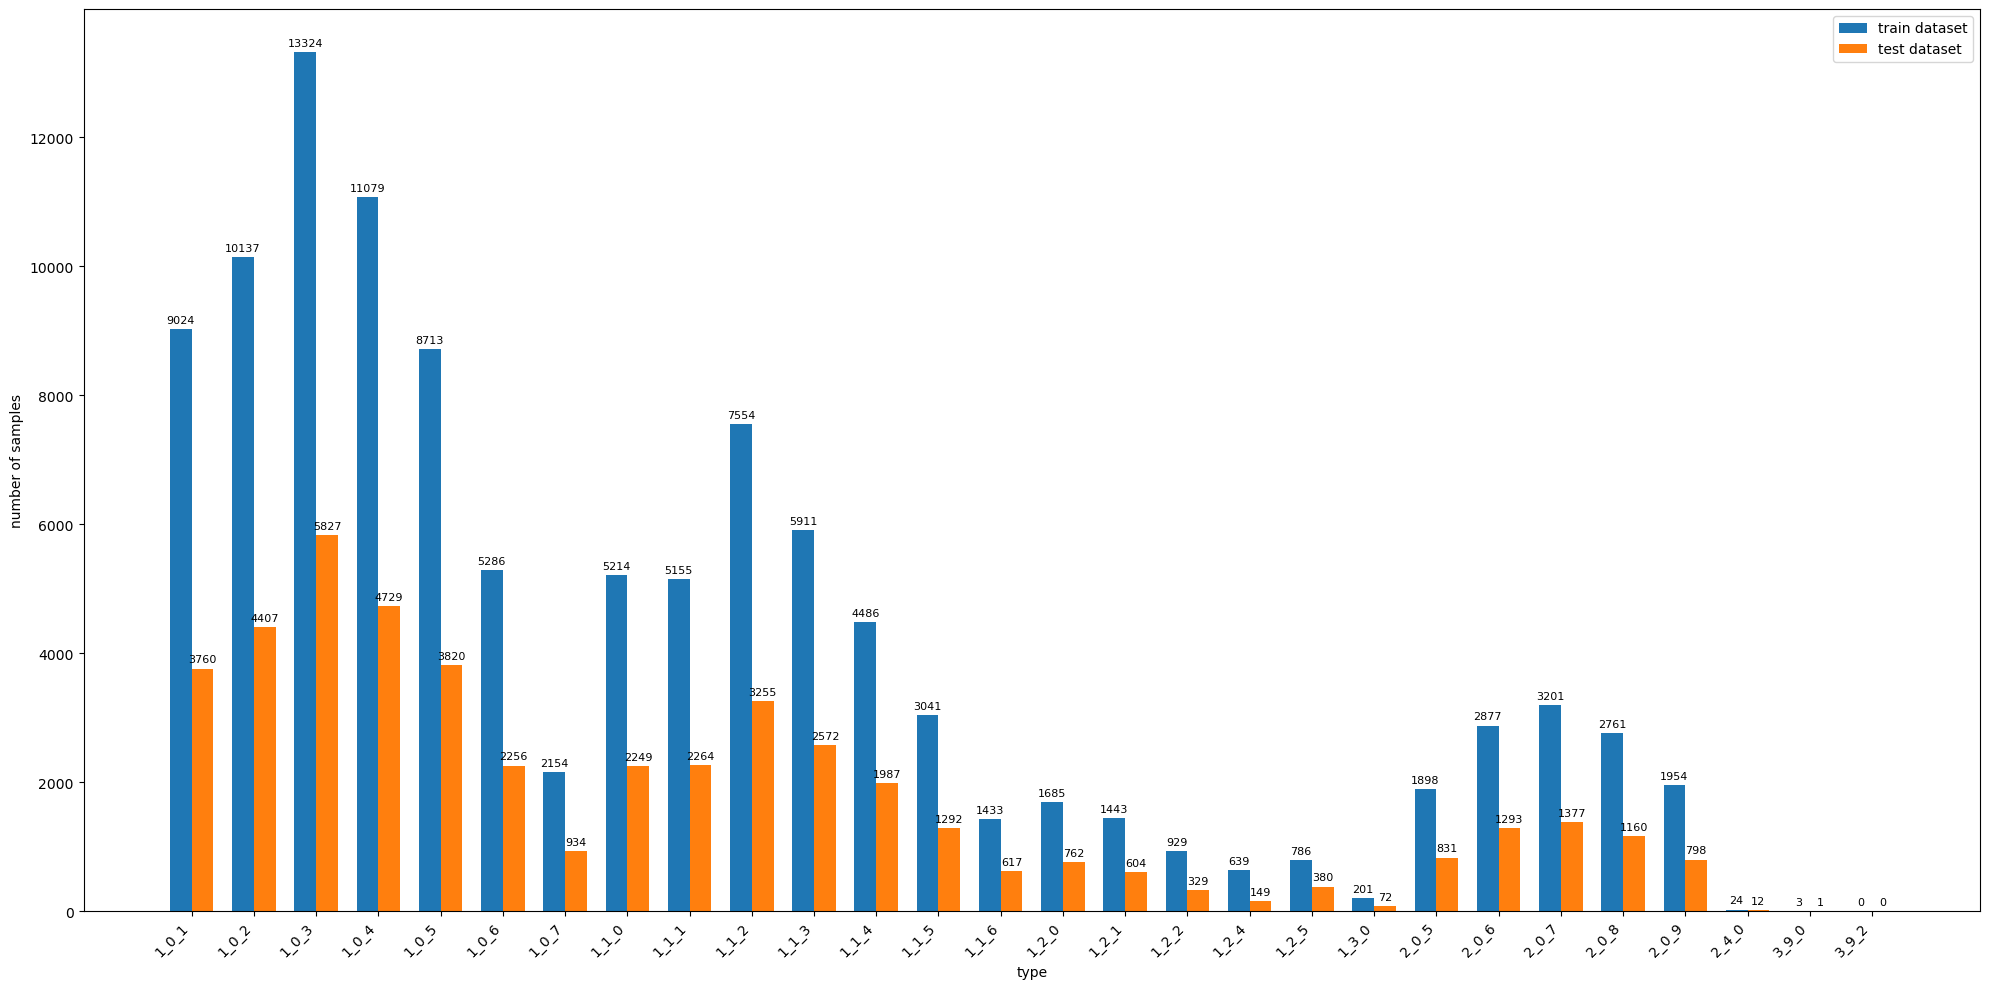

In [26]:
# Ëé∑ÂèñÊÄªÁöÑÁ±ªÂà´ËåÉÂõ¥ÔºàÈÄöËøá state_encoder ÁöÑÁ±ªÂà´ÊÄªÊï∞Ôºâ
total_classes = np.arange(len(state_encoder.classes_))

# ÁªüËÆ°ËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨Âá∫Áé∞Ê¨°Êï∞
train_class_counts = Counter(y_state_train.flatten())  # ÁªüËÆ°ËÆ≠ÁªÉÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÂá∫Áé∞Ê¨°Êï∞
test_class_counts = Counter(y_state_test.flatten())    # ÁªüËÆ°ÊµãËØïÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÂá∫Áé∞Ê¨°Êï∞

# ËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑÔºåÊåâÁ±ªÂà´È°∫Â∫èÊéíÂàó
train_class_distribution = np.zeros(len(total_classes), dtype=int)
test_class_distribution = np.zeros(len(total_classes), dtype=int)

for cls in total_classes:
    train_class_distribution[cls] = train_class_counts.get(cls, 0)
    test_class_distribution[cls] = test_class_counts.get(cls, 0)
    
# # ËæìÂá∫ÁªìÊûú
# print("ËÆ≠ÁªÉÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨ÂàÜÂ∏É:")
# for cls in total_classes:
#     print(f"Á±ªÂà´ {cls}: {train_class_distribution[cls]} Ê¨°")

# print("\nÊµãËØïÈõÜ‰∏≠ÊØè‰∏™Á±ªÂà´ÁöÑÊ†∑Êú¨ÂàÜÂ∏É:")
# for cls in total_classes:
#     print(f"Á±ªÂà´ {cls}: {test_class_distribution[cls]} Ê¨°")    
    
# ÁªòÂà∂Áõ¥ÊñπÂõæ
x = np.arange(len(total_classes))  # Á±ªÂà´Á¥¢Âºï
width = 0.35  # Áõ¥ÊñπÂõæÂÆΩÂ∫¶

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, train_class_distribution, width, label='train dataset')
rects2 = ax.bar(x + width/2, test_class_distribution, width, label='test dataset')

# Ê∑ªÂä†Ê†áÁ≠æ„ÄÅÊ†áÈ¢òÂíåÂõæ‰æã
ax.set_xlabel('type')
ax.set_ylabel('number of samples')
ax.set_xticks(x)
ax.set_xticklabels([f"{cls}" for cls in state_encoder.classes_], rotation=45, ha='right')  # ‰ΩøÁî® state_encoder.classes_ ‰∏≠ÁöÑÁ±ªÂà´ÂêçÁß∞
ax.legend()

# Âú®Êü±Áä∂Âõæ‰∏äÊñπÊòæÁ§∫ÂÖ∑‰ΩìÊï∞ÂÄº
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=8)

autolabel(rects1)
autolabel(rects2)

# ÊòæÁ§∫ÂõæÂΩ¢
plt.tight_layout()
plt.show()

## 3.2 ÂØπÊï∞ÊçÆÈõÜËøõË°åÁâπÂæÅÂ§ÑÁêÜ

### 1.1. ÈíàÂØπÂçïËæìÂá∫‰ªªÂä°,x,yÁöÑÁâπÂæÅÂùá‰∏∫4ÁöÑÊï∞ÊçÆÈõÜËøõË°åÁâπÂæÅÂ§ÑÁêÜ

#### a.ÂØπÂâç‰∏âÁª¥ÁâπÂæÅËøõË°åÊ†áÂáÜÂåñÂ§ÑÁêÜ,ÂØπÁ¨¨4Áª¥ÁâπÂæÅËøõË°åÂèñÂØπÊï∞Â§ÑÁêÜ

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ÂÅáËÆæ‰Ω†ÁöÑËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÊòØ X_train Âíå X_test
# X_train Âíå X_test ÂΩ¢Áä∂‰∏∫ (n_samples, 10, 4)

# ÊèêÂèñÂâç‰∏â‰∏™ÁâπÂæÅÔºàÂâç3ÂàóÔºâ
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# ÊèêÂèñÁ¨¨Âõõ‰∏™ÁâπÂæÅÔºàÁ¨¨4ÂàóÔºâ
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# Ê†áÂáÜÂåñÂâç‰∏â‰∏™ÁâπÂæÅÔºåÊ†áÂáÜÂåñÁâπÂæÅÂèØ‰ª•‰ΩøÂæóÊï∞ÊçÆ‰∏ç‰ºöÂèóÂà∞Êüê‰∏™ÁâπÂæÅÁî±‰∫éÊï∞ÂÄºËåÉÂõ¥‰∏éÂÖ∂ÂÆÉÁâπÂæÅÁöÑÊï∞ÂÄºËåÉÂõ¥Â∑ÆÂà´ËæÉÂ§ßËÄåÂØºËá¥ÂØπ‰∫éÊ®°ÂûãÂØπ‰∫éÁâπÂæÅÊïèÊÑüÂ∫¶ÁöÑÂΩ±Âìç
X_scaler = StandardScaler()
X_train_features_3 = X_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = X_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)
# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂèñÂØπÊï∞ÔºàÁ°Æ‰øùÊï∞ÂÄºÂ§ß‰∫é0Ôºâ
X_train_feature_4 = np.log(X_train_feature_4) 
X_test_feature_4 = np.log(X_test_feature_4)

# ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑÁâπÂæÅ
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)





# ÊèêÂèñÂâç‰∏â‰∏™ÁâπÂæÅÔºàÂâç3ÂàóÔºâ
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# ÊèêÂèñÁ¨¨Âõõ‰∏™ÁâπÂæÅÔºàÁ¨¨4ÂàóÔºâ
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# Ê†áÂáÜÂåñÂâç‰∏â‰∏™ÁâπÂæÅÔºåÊ†áÂáÜÂåñÁâπÂæÅÂèØ‰ª•‰ΩøÂæóÊï∞ÊçÆ‰∏ç‰ºöÂèóÂà∞Êüê‰∏™ÁâπÂæÅÁî±‰∫éÊï∞ÂÄºËåÉÂõ¥‰∏éÂÖ∂ÂÆÉÁâπÂæÅÁöÑÊï∞ÂÄºËåÉÂõ¥Â∑ÆÂà´ËæÉÂ§ßËÄåÂØºËá¥ÂØπ‰∫éÊ®°ÂûãÂØπ‰∫éÁâπÂæÅÊïèÊÑüÂ∫¶ÁöÑÂΩ±Âìç
y_scaler = StandardScaler()
y_train_features_3 = y_scaler.fit_transform(y_train_features_3.reshape(-1, 3)).reshape(y_train_features_3.shape)
y_test_features_3 = y_scaler.transform(y_test_features_3.reshape(-1, 3)).reshape(y_test_features_3.shape)

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂèñÂØπÊï∞ÔºàÁ°Æ‰øùÊï∞ÂÄºÂ§ß‰∫é0Ôºâ
y_train_feature_4 = np.log(y_train_feature_4) 
y_test_feature_4 = np.log(y_test_feature_4)

# ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑÁâπÂæÅ
y_train_processed = np.concatenate([y_train_features_3, y_train_feature_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_feature_4[..., np.newaxis]], axis=-1)

# Ê£ÄÊü•ÁªìÊûú
print(X_train_processed.shape)  # Â∫îËØ•ÊòØ (89204, 10, 4) #Â¶ÇÊûúÊòØÂàÜÂ≠êÁä∂ÊÄÅÂíåÂÅúÁïôÊó∂Èó¥ÂêåÊó∂È¢ÑÊµã
print(X_test_processed.shape)   # Â∫îËØ•ÊòØ (38902, 10, 4)



# Ê£ÄÊü•ÁªìÊûú
print(y_train_processed.shape)  # Â∫îËØ•ÊòØ (89204, 4)
print(y_test_processed.shape)   # Â∫îËØ•ÊòØ (38902, 4)

In [ ]:
#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### b.ÂØπÂâç‰∏âÁª¥ÁâπÂæÅËøõË°åÊ†áÂáÜÂåñÂ§ÑÁêÜ,ÂØπÁ¨¨4Áª¥ÁâπÂæÅ‰∏çÂ§ÑÁêÜ

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ÂÅáËÆæ‰Ω†ÁöÑËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÊòØ X_train Âíå X_test
# X_train Âíå X_test ÂΩ¢Áä∂‰∏∫ (n_samples, 10, 4)

# ÊèêÂèñÂâç‰∏â‰∏™ÁâπÂæÅÔºàÂâç3ÂàóÔºâ
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# ÊèêÂèñÁ¨¨Âõõ‰∏™ÁâπÂæÅÔºàÁ¨¨4ÂàóÔºâ
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# Ê†áÂáÜÂåñÂâç‰∏â‰∏™ÁâπÂæÅÔºåÊ†áÂáÜÂåñÁâπÂæÅÂèØ‰ª•‰ΩøÂæóÊï∞ÊçÆ‰∏ç‰ºöÂèóÂà∞Êüê‰∏™ÁâπÂæÅÁî±‰∫éÊï∞ÂÄºËåÉÂõ¥‰∏éÂÖ∂ÂÆÉÁâπÂæÅÁöÑÊï∞ÂÄºËåÉÂõ¥Â∑ÆÂà´ËæÉÂ§ßËÄåÂØºËá¥ÂØπ‰∫éÊ®°ÂûãÂØπ‰∫éÁâπÂæÅÊïèÊÑüÂ∫¶ÁöÑÂΩ±Âìç
X_scaler = StandardScaler()
X_train_features_3 = X_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = X_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅ‰∏çÂÅöÂ§ÑÁêÜ
X_train_feature_4 = X_train_feature_4 
X_test_feature_4 = X_test_feature_4

# ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑÁâπÂæÅ
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)





# ÊèêÂèñÂâç‰∏â‰∏™ÁâπÂæÅÔºàÂâç3ÂàóÔºâ
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# ÊèêÂèñÁ¨¨Âõõ‰∏™ÁâπÂæÅÔºàÁ¨¨4ÂàóÔºâ
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# Ê†áÂáÜÂåñÂâç‰∏â‰∏™ÁâπÂæÅÔºåÊ†áÂáÜÂåñÁâπÂæÅÂèØ‰ª•‰ΩøÂæóÊï∞ÊçÆ‰∏ç‰ºöÂèóÂà∞Êüê‰∏™ÁâπÂæÅÁî±‰∫éÊï∞ÂÄºËåÉÂõ¥‰∏éÂÖ∂ÂÆÉÁâπÂæÅÁöÑÊï∞ÂÄºËåÉÂõ¥Â∑ÆÂà´ËæÉÂ§ßËÄåÂØºËá¥ÂØπ‰∫éÊ®°ÂûãÂØπ‰∫éÁâπÂæÅÊïèÊÑüÂ∫¶ÁöÑÂΩ±Âìç
y_scaler = StandardScaler()
y_train_features_3 = y_scaler.fit_transform(y_train_features_3.reshape(-1, 3)).reshape(y_train_features_3.shape)
y_test_features_3 = y_scaler.transform(y_test_features_3.reshape(-1, 3)).reshape(y_test_features_3.shape)

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅ‰∏çÂÅöÂ§ÑÁêÜ
y_train_feature_4 = y_train_feature_4
y_test_feature_4 = y_test_feature_4

# ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑÁâπÂæÅ
y_train_processed = np.concatenate([y_train_features_3, y_train_feature_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_feature_4[..., np.newaxis]], axis=-1)

# Ê£ÄÊü•ÁªìÊûú
print(X_train_processed.shape)  # Â∫îËØ•ÊòØ (89204, 10, 4) #Â¶ÇÊûúÊòØÂàÜÂ≠êÁä∂ÊÄÅÂíåÂÅúÁïôÊó∂Èó¥ÂêåÊó∂È¢ÑÊµã
print(X_test_processed.shape)   # Â∫îËØ•ÊòØ (38902, 10, 4)



# Ê£ÄÊü•ÁªìÊûú
print(y_train_processed.shape)  # Â∫îËØ•ÊòØ (89204, 4)
print(y_test_processed.shape)   # Â∫îËØ•ÊòØ (38902, 4)

In [ ]:
#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### c.ÂØπÂâçÂõõ‰∏™Áª¥ÁâπÂæÅËøõË°åÊ†áÂáÜÂåñÂ§ÑÁêÜ

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ÂÅáËÆæ‰Ω†ÁöÑËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÊòØ X_train Âíå X_test
# X_train Âíå X_test ÂΩ¢Áä∂‰∏∫ (n_samples, 10, 4)

# ÊèêÂèñÂâç‰∏â‰∏™ÁâπÂæÅÔºàÂâç3ÂàóÔºâ
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# ÊèêÂèñÁ¨¨Âõõ‰∏™ÁâπÂæÅÔºàÁ¨¨4ÂàóÔºâ
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# Ê†áÂáÜÂåñÂâç‰∏â‰∏™ÁâπÂæÅÔºåÊ†áÂáÜÂåñÁâπÂæÅÂèØ‰ª•‰ΩøÂæóÊï∞ÊçÆ‰∏ç‰ºöÂèóÂà∞Êüê‰∏™ÁâπÂæÅÁî±‰∫éÊï∞ÂÄºËåÉÂõ¥‰∏éÂÖ∂ÂÆÉÁâπÂæÅÁöÑÊï∞ÂÄºËåÉÂõ¥Â∑ÆÂà´ËæÉÂ§ßËÄåÂØºËá¥ÂØπ‰∫éÊ®°ÂûãÂØπ‰∫éÁâπÂæÅÊïèÊÑüÂ∫¶ÁöÑÂΩ±Âìç
X1_scaler = StandardScaler()
X_train_features_3 = X1_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = X1_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅ‰πüËøõË°åscalerÂ§ÑÁêÜ
X2_scaler = StandardScaler()
X_train_features_4 = X2_scaler.fit_transform(X_train_feature_4.reshape(-1, 1)).reshape(X_train_feature_4.shape)
X_test_features_4 = X2_scaler.transform(X_test_feature_4.reshape(-1, 1)).reshape(X_test_feature_4.shape)

# ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑÁâπÂæÅ
X_train_processed = np.concatenate([X_train_features_3, X_train_features_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_features_4[..., np.newaxis]], axis=-1)



# ÊèêÂèñÂâç‰∏â‰∏™ÁâπÂæÅÔºàÂâç3ÂàóÔºâ
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# ÊèêÂèñÁ¨¨Âõõ‰∏™ÁâπÂæÅÔºàÁ¨¨4ÂàóÔºâ
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# Ê†áÂáÜÂåñÂâç‰∏â‰∏™ÁâπÂæÅÔºåÊ†áÂáÜÂåñÁâπÂæÅÂèØ‰ª•‰ΩøÂæóÊï∞ÊçÆ‰∏ç‰ºöÂèóÂà∞Êüê‰∏™ÁâπÂæÅÁî±‰∫éÊï∞ÂÄºËåÉÂõ¥‰∏éÂÖ∂ÂÆÉÁâπÂæÅÁöÑÊï∞ÂÄºËåÉÂõ¥Â∑ÆÂà´ËæÉÂ§ßËÄåÂØºËá¥ÂØπ‰∫éÊ®°ÂûãÂØπ‰∫éÁâπÂæÅÊïèÊÑüÂ∫¶ÁöÑÂΩ±Âìç
y1_scaler = StandardScaler()
y_train_features_3 = y1_scaler.fit_transform(y_train_features_3.reshape(-1, 3)).reshape(y_train_features_3.shape)
y_test_features_3 = y1_scaler.transform(y_test_features_3.reshape(-1, 3)).reshape(y_test_features_3.shape)

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅ‰πüËøõË°åscalerÂ§ÑÁêÜ
y2_scaler = StandardScaler()
y_train_features_4 = y2_scaler.fit_transform(y_train_feature_4.reshape(-1, 1)).reshape(y_train_feature_4.shape)
y_test_features_4 = y2_scaler.transform(y_test_feature_4.reshape(-1, 1)).reshape(y_test_feature_4.shape)

# ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑÁâπÂæÅ
y_train_processed = np.concatenate([y_train_features_3, y_train_features_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_features_4[..., np.newaxis]], axis=-1)

# Ê£ÄÊü•ÁªìÊûú
print(X_train_processed.shape)  # Â∫îËØ•ÊòØ (89204, 10, 4) #Â¶ÇÊûúÊòØÂàÜÂ≠êÁä∂ÊÄÅÂíåÂÅúÁïôÊó∂Èó¥ÂêåÊó∂È¢ÑÊµã
print(X_test_processed.shape)   # Â∫îËØ•ÊòØ (38902, 10, 4)



# Ê£ÄÊü•ÁªìÊûú
print(y_train_processed.shape)  # Â∫îËØ•ÊòØ (89204, 4)
print(y_test_processed.shape)   # Â∫îËØ•ÊòØ (38902, 4)

In [ ]:
#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

### 1.2.  ÈíàÂØπÂçïËæìÂá∫‰ªªÂä°,x,yÁöÑÁâπÂæÅÂàÜÂà´‰∏∫4Âíå1ÁöÑÊï∞ÊçÆÈõÜËøõË°åÁâπÂæÅÂ§ÑÁêÜ

#### a.ÂØπXÁâπÂæÅËøõË°åÊ†áÂáÜÂåñÂíåÂèñÂØπÊï∞Â§ÑÁêÜ,ÂØπyÂèñÂØπÊï∞

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ÂÅáËÆæ‰Ω†ÁöÑËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÊòØ X_train Âíå X_test
# X_train Âíå X_test ÂΩ¢Áä∂‰∏∫ (n_samples, 10, 4)

# ÊèêÂèñÂâç‰∏â‰∏™ÁâπÂæÅÔºàÂâç3ÂàóÔºâ
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# ÊèêÂèñÁ¨¨Âõõ‰∏™ÁâπÂæÅÔºàÁ¨¨4ÂàóÔºâ
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# Ê†áÂáÜÂåñÂâç‰∏â‰∏™ÁâπÂæÅÔºåÊ†áÂáÜÂåñÁâπÂæÅÂèØ‰ª•‰ΩøÂæóÊï∞ÊçÆ‰∏ç‰ºöÂèóÂà∞Êüê‰∏™ÁâπÂæÅÁî±‰∫éÊï∞ÂÄºËåÉÂõ¥‰∏éÂÖ∂ÂÆÉÁâπÂæÅÁöÑÊï∞ÂÄºËåÉÂõ¥Â∑ÆÂà´ËæÉÂ§ßËÄåÂØºËá¥ÂØπ‰∫éÊ®°ÂûãÂØπ‰∫éÁâπÂæÅÊïèÊÑüÂ∫¶ÁöÑÂΩ±Âìç
scaler = StandardScaler()
X_train_features_3 = scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)################################################################################################################ËøôÈáå‰∏∫Âï•ÊòØtransformËÄå‰∏çÊòØfit_transform

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂèñÂØπÊï∞ÔºàÁ°Æ‰øùÊï∞ÂÄºÂ§ß‰∫é0Ôºâ
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # Âä†‰∏ä‰∏Ä‰∏™Â∞èÂ∏∏Êï∞ÈÅøÂÖçÂèñlog(0)ÁöÑÈîôËØØ#############################################################################################Ëøô‰πàÂ§ÑÁêÜ‰ºöÂØºËá¥Êó∂Èó¥ÂéüÊú¨ËÆæÂÆö‰∏∫0ÁöÑ‰ΩçÁΩÆÂèò‰∏∫‰∫Ü‰∏Ä‰∏™Áõ∏ÂêåÁöÑ‰ΩÜÊòØÊØîËæÉÂ§ßÁöÑË¥üÊï∞Ôºå‰ºö‰∏ç‰ºöÂØπÁªìÊûúÈÄ†ÊàêÂπ≤Êâ∞Ôºü??,ÊîπÊàê+1‰ºö‰∏ç‰ºöÂ•Ω‰∏Ä‰∫õÔºü
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑÁâπÂæÅ
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# Ê£ÄÊü•ÁªìÊûú
print(X_train_processed.shape)  # Â∫îËØ•ÊòØ (89204, 10, 4) #Â¶ÇÊûúÊòØÂàÜÂ≠êÁä∂ÊÄÅÂíåÂÅúÁïôÊó∂Èó¥ÂêåÊó∂È¢ÑÊµã
print(X_test_processed.shape)   # Â∫îËØ•ÊòØ (38902, 10, 4)

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂèñÂØπÊï∞ÔºàÁ°Æ‰øùÊï∞ÂÄºÂ§ß‰∫é0Ôºâ
y_train_processed = np.log(y_train + 1e-6)  # Âä†‰∏ä‰∏Ä‰∏™Â∞èÂ∏∏Êï∞ÈÅøÂÖçlog(0)
y_test_processed = np.log(y_test + 1e-6)


# Ê£ÄÊü•ÁªìÊûú
print(y_train_processed.shape)  
print(y_test_processed.shape)   

In [ ]:
#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### b.ÂØπXÁâπÂæÅËøõË°åÂΩí‰∏ÄÂåñÂíåÂèñÂØπÊï∞Â§ÑÁêÜ,ÂØπyÂèñÂØπÊï∞

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ÂÅáËÆæ‰Ω†ÁöÑËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÊòØ X_train Âíå X_test
# X_train Âíå X_test ÂΩ¢Áä∂‰∏∫ (n_samples, 10, 4)

# ÊèêÂèñÂâç‰∏â‰∏™ÁâπÂæÅÔºàÂâç3ÂàóÔºâ
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# ÊèêÂèñÁ¨¨Âõõ‰∏™ÁâπÂæÅÔºàÁ¨¨4ÂàóÔºâ
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# ÂΩí‰∏ÄÂåñÂâç‰∏â‰∏™ÁâπÂæÅ
scaler = MinMaxScaler()
X_train_features_3 = scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂèñÂØπÊï∞ÔºàÁ°Æ‰øùÊï∞ÂÄºÂ§ß‰∫é0Ôºâ
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # Âä†‰∏ä‰∏Ä‰∏™Â∞èÂ∏∏Êï∞ÈÅøÂÖçÂèñlog(0)ÁöÑÈîôËØØ
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑÁâπÂæÅ
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# Ê£ÄÊü•ÁªìÊûú
print(X_train_processed.shape)
print(X_test_processed.shape)

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂèñÂØπÊï∞ÔºàÁ°Æ‰øùÊï∞ÂÄºÂ§ß‰∫é0Ôºâ
y_train_processed = np.log(y_train + 1e-6)  # Âä†‰∏ä‰∏Ä‰∏™Â∞èÂ∏∏Êï∞ÈÅøÂÖçlog(0)
y_test_processed = np.log(y_test + 1e-6)

# Ê£ÄÊü•ÁªìÊûú
print(y_train_processed.shape) 
print(y_test_processed.shape) 


In [ ]:
#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### c.ÂØπXÁâπÂæÅËøõË°åÂΩí‰∏ÄÂåñÂíåÊ†áÂáÜÂåñÂ§ÑÁêÜ,ÂØπyËøõË°åÊ†áÂáÜÂåñÂ§ÑÁêÜ

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# ÂÅáËÆæ‰Ω†ÁöÑËÆ≠ÁªÉÈõÜÂíåÊµãËØïÈõÜÊòØ X_train Âíå X_test
# X_train Âíå X_test ÂΩ¢Áä∂‰∏∫ (n_samples, 10, 4)

# ÊèêÂèñÂâç‰∏â‰∏™ÁâπÂæÅÔºàÂâç3ÂàóÔºâ
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# ÊèêÂèñÁ¨¨Âõõ‰∏™ÁâπÂæÅÔºàÁ¨¨4ÂàóÔºâ
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# ÂΩí‰∏ÄÂåñÂâç‰∏â‰∏™ÁâπÂæÅ
scaler_3 = MinMaxScaler()
X_train_features_3 = scaler_3.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler_3.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂèñÂØπÊï∞ÔºàÁ°Æ‰øùÊï∞ÂÄºÂ§ß‰∫é0Ôºâ
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # Âä†‰∏ä‰∏Ä‰∏™Â∞èÂ∏∏Êï∞ÈÅøÂÖçlog(0)
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# Ê†áÂáÜÂåñÁ¨¨Âõõ‰∏™ÁâπÂæÅ
scaler_4 = StandardScaler()
X_train_feature_4 = scaler_4.fit_transform(X_train_feature_4.reshape(-1, 1)).reshape(X_train_feature_4.shape)
X_test_feature_4 = scaler_4.transform(X_test_feature_4.reshape(-1, 1)).reshape(X_test_feature_4.shape)



# ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑÁâπÂæÅ
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# Ê£ÄÊü•ÁªìÊûú
print(X_train_processed.shape)  # Â∫îËØ•ÊòØ (n_samples, 10, 4)
print(X_test_processed.shape)   # Â∫îËØ•ÊòØ (n_samples, 10, 4)

# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂèñÂØπÊï∞ÔºàÁ°Æ‰øùÊï∞ÂÄºÂ§ß‰∫é0Ôºâ
y_train_processed = np.log(y_train + 1e-6)  # Âä†‰∏ä‰∏Ä‰∏™Â∞èÂ∏∏Êï∞ÈÅøÂÖçlog(0)
y_test_processed = np.log(y_test + 1e-6)

# ÂØπÁõÆÊ†áÂèòÈáèËøõË°åÊ†áÂáÜÂåñ
scaler_y = StandardScaler()
y_train_processed = scaler_y.fit_transform(y_train)  # Áõ¥Êé•ÂØπyËøõË°åÊ†áÂáÜÂåñ
y_test_processed = scaler_y.transform(y_test)  # ‰ΩøÁî®ËÆ≠ÁªÉÈõÜÁöÑÊ†áÂáÜÂåñÂèÇÊï∞Â§ÑÁêÜÊµãËØïÈõÜ


# Ê£ÄÊü•ÁªìÊûú
print(y_train_processed.shape)  # Â∫îËØ•ÊòØ (n_samples, 4)
print(y_test_processed.shape)   # Â∫îËØ•ÊòØ (n_samples, 4)

In [ ]:
#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

### 1.3 ÈíàÂØπÂçïÁõÆÊ†áËæìÂá∫‰ªªÂä°,x,yÁöÑÁâπÂæÅÂùá‰∏∫1(Áä∂ÊÄÅ)

In [99]:
# ÁõÆÂâçËøòÊ≤°ÊúâÁâπÂæÅÂ§ÑÁêÜ‰ª£Á†Å

In [9]:
#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))

test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

In [27]:
#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_state_train))

test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_state_test))

### 1.4 ÈíàÂØπÂçïÁõÆÊ†áËæìÂá∫‰ªªÂä°ÔºåXÁöÑÁâπÂæÅÁª¥4Áª¥ÔºåyÁöÑÁâπÂæÅ‰∏∫3Áª¥

#### a.ÂØπXÂíåyÁöÑÁâπÂæÅ‰∏çËøõË°å‰ªª‰ΩïÂ§ÑÁêÜ

In [12]:
#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))

test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

#### b.ÂØπXÂâç‰∏âÁª¥ÁâπÂæÅËøõË°åÊ†áÂáÜÂåñÂ§ÑÁêÜÔºåÂØπÁ¨¨ÂõõÁª¥ÁâπÂæÅ‰∏çÂ§ÑÁêÜ,ÂØπyÁöÑÁâπÂæÅËøõË°åÊ†áÂáÜÂåñÂ§ÑÁêÜ

In [33]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ----------------------------
# ÂÅáËÆæ‰Ω†Â∑≤ÁªèÊúâ‰∫Ü‰ª•‰∏ãÂèòÈáèÔºö
# X_train, X_test, y_train, y_test
# ----------------------------
print("Before processing:")
print("X_train shape:", X_train.shape)  # (2825, 11, 4)
print("X_test shape:", X_test.shape)    # (707, 11, 4)
print("y_train shape:", y_train.shape)  # (2825, 3)
print("y_test shape:", y_test.shape)    # (707, 3)

# =============== ÂØπ X ÁöÑÂâç‰∏âÁª¥Â∫¶ËøõË°åÊ†áÂáÜÂåñÔºå‰øùÁïôÁ¨¨4Áª¥ ===============

# 1) Â∞Ü X ÁöÑÂâç3Áª¥ÂàÜÂºÄ
X_train_features_3 = X_train[:, :, :3]  # ÂΩ¢Áä∂ (n_train, 11, 3)
X_test_features_3 = X_test[:, :, :3]    # ÂΩ¢Áä∂ (n_test, 11, 3)

# 2) Â∞Ü X ÁöÑÁ¨¨4Áª¥ÂàÜÂºÄ
X_train_feature_4 = X_train[:, :, 3]    # ÂΩ¢Áä∂ (n_train, 11)
X_test_feature_4 = X_test[:, :, 3]      # ÂΩ¢Áä∂ (n_test, 11)

# 3) ÂØπÂâç‰∏â‰∏™Áª¥Â∫¶ËøõË°åÊ†áÂáÜÂåñ
X_scaler = StandardScaler()

# ÈúÄË¶ÅÂÖà reshape Êàê‰∫åÁª¥Áü©Èòµ (n_samples * seq_len, 3)ÔºåÂÜçËøòÂéüÂõû‰∏âÁª¥
n_train, seq_len, _ = X_train_features_3.shape
n_test = X_test_features_3.shape[0]

X_train_3d_reshaped = X_train_features_3.reshape(-1, 3)  # (n_train*11, 3)
X_test_3d_reshaped = X_test_features_3.reshape(-1, 3)    # (n_test*11, 3)

X_train_3d_scaled = X_scaler.fit_transform(X_train_3d_reshaped)
X_test_3d_scaled = X_scaler.transform(X_test_3d_reshaped)

# 4) reshape ÂõûÂéüÂΩ¢Áä∂
X_train_3d_scaled = X_train_3d_scaled.reshape(n_train, seq_len, 3)
X_test_3d_scaled = X_test_3d_scaled.reshape(n_test, seq_len, 3)

# 5) ‰øùÁïôÁöÑÁ¨¨ÂõõÁª¥‰∏çÂÅö‰ªª‰ΩïÂèòÊç¢ÔºåÈáçÊñ∞ÊãºÊé•
X_train_processed = np.concatenate([X_train_3d_scaled, 
                                    X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_3d_scaled, 
                                   X_test_feature_4[..., np.newaxis]], axis=-1)

# =============== ÂØπ y ÁöÑ 3 ‰∏™Áª¥Â∫¶ËøõË°åÊ†áÂáÜÂåñ ===============
y_scaler = StandardScaler()

# y_train Âíå y_test ÂéüÊú¨Â∞±ÊòØ (n_samples, 3)ÔºåÂèØ‰ª•Áõ¥Êé•Ê†áÂáÜÂåñ
y_train_processed = y_scaler.fit_transform(y_train)
y_test_processed = y_scaler.transform(y_test)

# =============== Ê£ÄÊü•ÁªìÊûú ===============
print("\nAfter processing:")
print("X_train_processed shape:", X_train_processed.shape)  # È¢ÑÊúü (2825, 11, 4)
print("X_test_processed shape:", X_test_processed.shape)    # È¢ÑÊúü (707, 11, 4)

print("y_train_processed shape:", y_train_processed.shape)  # È¢ÑÊúü (2825, 3)
print("y_test_processed shape:", y_test_processed.shape)    # È¢ÑÊúü (707, 3)

#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

Before processing:
X_train shape: (2825, 11, 4)
X_test shape: (707, 11, 4)
y_train shape: (2825, 3)
y_test shape: (707, 3)

After processing:
X_train_processed shape: (2825, 11, 4)
X_test_processed shape: (707, 11, 4)
y_train_processed shape: (2825, 3)
y_test_processed shape: (707, 3)


#### c.ÂØπÂâç‰∏âÁª¥ÁâπÂæÅËøõË°åÊ†áÂáÜÂåñÂ§ÑÁêÜÔºåÂØπÁ¨¨ÂõõÁª¥ÁâπÂæÅÂèñlog

In [61]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ----------------------------
# ÂÅáËÆæ‰Ω†Â∑≤ÁªèÊúâ‰∫Ü‰ª•‰∏ãÂèòÈáèÔºö
# X_train, X_test, y_train, y_test
# ----------------------------
print("Before processing:")
print("X_train shape:", X_train.shape)  # (2825, 11, 4)
print("X_test shape:", X_test.shape)    # (707, 11, 4)
print("y_train shape:", y_train.shape)  # (2825, 3)
print("y_test shape:", y_test.shape)    # (707, 3)

# =============== ÂØπ X ÁöÑÂâç‰∏âÁª¥Â∫¶ËøõË°åÊ†áÂáÜÂåñÔºå‰øùÁïôÁ¨¨4Áª¥ ===============

# 1) Â∞Ü X ÁöÑÂâç3Áª¥ÂàÜÂºÄ
X_train_features_3 = X_train[:, :, :3]  # ÂΩ¢Áä∂ (n_train, 11, 3)
X_test_features_3 = X_test[:, :, :3]    # ÂΩ¢Áä∂ (n_test, 11, 3)

# 2) Â∞Ü X ÁöÑÁ¨¨4Áª¥ÂàÜÂºÄ
X_train_feature_4 = X_train[:, :, 3]    # ÂΩ¢Áä∂ (n_train, 11)
X_test_feature_4 = X_test[:, :, 3]      # ÂΩ¢Áä∂ (n_test, 11)

# 3) ÂØπÂâç‰∏â‰∏™Áª¥Â∫¶ËøõË°åÊ†áÂáÜÂåñ
X_scaler = StandardScaler()

# ÈúÄË¶ÅÂÖà reshape Êàê‰∫åÁª¥Áü©Èòµ (n_samples * seq_len, 3)ÔºåÂÜçËøòÂéüÂõû‰∏âÁª¥
n_train, seq_len, _ = X_train_features_3.shape
n_test = X_test_features_3.shape[0]

X_train_3d_reshaped = X_train_features_3.reshape(-1, 3)  # (n_train*11, 3)
X_test_3d_reshaped = X_test_features_3.reshape(-1, 3)    # (n_test*11, 3)

X_train_3d_scaled = X_scaler.fit_transform(X_train_3d_reshaped)
X_test_3d_scaled = X_scaler.transform(X_test_3d_reshaped)

# 4) reshape ÂõûÂéüÂΩ¢Áä∂
X_train_3d_scaled = X_train_3d_scaled.reshape(n_train, seq_len, 3)
X_test_3d_scaled = X_test_3d_scaled.reshape(n_test, seq_len, 3)


# ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂèñÂØπÊï∞ÔºàÁ°Æ‰øùÊï∞ÂÄºÂ§ß‰∫é0Ôºâ
X_train_feature_4 = np.log(X_train_feature_4) 
X_test_feature_4 = np.log(X_test_feature_4)

# 5) ‰øùÁïôÁöÑÁ¨¨ÂõõÁª¥‰∏çÂÅö‰ªª‰ΩïÂèòÊç¢ÔºåÈáçÊñ∞ÊãºÊé•
X_train_processed = np.concatenate([X_train_3d_scaled, 
                                    X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_3d_scaled, 
                                   X_test_feature_4[..., np.newaxis]], axis=-1)

# =============== ÂØπ y ÁöÑ 3 ‰∏™Áª¥Â∫¶ËøõË°åÊ†áÂáÜÂåñ ===============
y_scaler = StandardScaler()

# y_train Âíå y_test ÂéüÊú¨Â∞±ÊòØ (n_samples, 3)ÔºåÂèØ‰ª•Áõ¥Êé•Ê†áÂáÜÂåñ
y_train_processed = y_scaler.fit_transform(y_train)
y_test_processed = y_scaler.transform(y_test)

# =============== Ê£ÄÊü•ÁªìÊûú ===============
print("\nAfter processing:")
print("X_train_processed shape:", X_train_processed.shape)  # È¢ÑÊúü (2825, 11, 4)
print("X_test_processed shape:", X_test_processed.shape)    # È¢ÑÊúü (707, 11, 4)

print("y_train_processed shape:", y_train_processed.shape)  # È¢ÑÊúü (2825, 3)
print("y_test_processed shape:", y_test_processed.shape)    # È¢ÑÊúü (707, 3)

#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

Before processing:
X_train shape: (2825, 11, 4)
X_test shape: (707, 11, 4)
y_train shape: (2825, 3)
y_test shape: (707, 3)

After processing:
X_train_processed shape: (2825, 11, 4)
X_test_processed shape: (707, 11, 4)
y_train_processed shape: (2825, 3)
y_test_processed shape: (707, 3)


#### d.XÁöÑÂõõÁª¥Áõ¥Êé•ËøõË°åÊ†áÂáÜÂåñÔºåyÁöÑ‰∏âÁª¥ÈÉΩÊ†áÂáÜÂåñ

In [55]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset

# ----------------------------
# ÂÅáËÆæ‰Ω†Â∑≤ÁªèÊúâ‰∫Ü‰ª•‰∏ãÂèòÈáèÔºö
# X_train, X_test, y_train, y_test
# ----------------------------
print("Before processing:")
print("X_train shape:", X_train.shape)  # (2825, 11, 4)
print("X_test shape:", X_test.shape)    # (707, 11, 4)
print("y_train shape:", y_train.shape)    # (2825, 3)
print("y_test shape:", y_test.shape)      # (707, 3)

# =============== ÂØπ X ÁöÑÊâÄÊúâ 4 ‰∏™ÁâπÂæÅ‰∏ÄËµ∑ËøõË°åÊ†áÂáÜÂåñ ===============
n_train, seq_len, n_features = X_train.shape  # n_features Â∫î‰∏∫ 4
n_test = X_test.shape[0]

# reshape ‰∏∫‰∫åÁª¥Êï∞ÁªÑ (n_train*seq_len, 4)
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

# ‰ΩøÁî® StandardScaler ÂØπÊï¥‰∏™‰∫åÁª¥Êï∞ÁªÑËøõË°åÊ†áÂáÜÂåñ
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
X_test_scaled = X_scaler.transform(X_test_reshaped)

# reshape ÂõûÂéüÊù•ÁöÑ‰∏âÁª¥ÂΩ¢Áä∂
X_train_processed = X_train_scaled.reshape(n_train, seq_len, n_features)
X_test_processed = X_test_scaled.reshape(n_test, seq_len, n_features)

# =============== ÂØπ y ÁöÑ 3 ‰∏™Áª¥Â∫¶ËøõË°åÊ†áÂáÜÂåñ ===============
y_scaler = StandardScaler()
y_train_processed = y_scaler.fit_transform(y_train)
y_test_processed = y_scaler.transform(y_test)

# =============== Ê£ÄÊü•ÁªìÊûú ===============
print("\nAfter processing:")
print("X_train_processed shape:", X_train_processed.shape)  # (2825, 11, 4)
print("X_test_processed shape:", X_test_processed.shape)    # (707, 11, 4)
print("y_train_processed shape:", y_train_processed.shape)  # (2825, 3)
print("y_test_processed shape:", y_test_processed.shape)    # (707, 3)

# Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†Èáè tensor ÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))
test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))


Before processing:
X_train shape: (7587, 9, 4)
X_test shape: (843, 9, 4)
y_train shape: (7587, 3)
y_test shape: (843, 3)

After processing:
X_train_processed shape: (7587, 9, 4)
X_test_processed shape: (843, 9, 4)
y_train_processed shape: (7587, 3)
y_test_processed shape: (843, 3)


#### e.XÁöÑÂõõÁª¥Áõ¥Êé•ËøõË°åÊ†áÂáÜÂåñÔºåy‰∏çÂ§ÑÁêÜ

In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset

# ----------------------------
# ÂÅáËÆæ‰Ω†Â∑≤ÁªèÊúâ‰∫Ü‰ª•‰∏ãÂèòÈáèÔºö
# X_train, X_test, y_train, y_test
# ----------------------------
print("Before processing:")
print("X_train shape:", X_train.shape)  # (2825, 11, 4)
print("X_test shape:", X_test.shape)    # (707, 11, 4)
print("y_train shape:", y_train.shape)    # (2825, 3)
print("y_test shape:", y_test.shape)      # (707, 3)

# =============== ÂØπ X ÁöÑÂâç‰∏â‰∏™ÁâπÂæÅËøõË°åÊ†áÂáÜÂåñ ===============
# 1) Â∞Ü X ÁöÑÂâç3‰∏™ÁâπÂæÅÂàÜÂºÄ
X_train_features_3 = X_train[:, :, :3]  # ÂΩ¢Áä∂ (n_train, 11, 3)
X_test_features_3 = X_test[:, :, :3]    # ÂΩ¢Áä∂ (n_test, 11, 3)

# 2) ÂØπÂâç‰∏â‰∏™ÁâπÂæÅËøõË°åÊ†áÂáÜÂåñ
X_scaler_3 = StandardScaler()
n_train, seq_len, _ = X_train_features_3.shape
n_test = X_test_features_3.shape[0]

# reshape ‰∏∫‰∫åÁª¥Êï∞ÁªÑÔºåÂÜçÊ†áÂáÜÂåñÔºåÊúÄÂêéÊÅ¢Â§çÂéüÂΩ¢Áä∂
X_train_3d_reshaped = X_train_features_3.reshape(-1, 3)  # (n_train*11, 3)
X_test_3d_reshaped = X_test_features_3.reshape(-1, 3)    # (n_test*11, 3)

X_train_3d_scaled = X_scaler_3.fit_transform(X_train_3d_reshaped)
X_test_3d_scaled = X_scaler_3.transform(X_test_3d_reshaped)

X_train_3d_scaled = X_train_3d_scaled.reshape(n_train, seq_len, 3)
X_test_3d_scaled = X_test_3d_scaled.reshape(n_test, seq_len, 3)

# =============== ÂØπ X ÁöÑÁ¨¨Âõõ‰∏™ÁâπÂæÅËøõË°åÂçïÁã¨Ê†áÂáÜÂåñ ===============
# 1) ÊèêÂèñÁ¨¨Âõõ‰∏™ÁâπÂæÅ
X_train_feature_4 = X_train[:, :, 3]    # ÂΩ¢Áä∂ (n_train, 11)
X_test_feature_4 = X_test[:, :, 3]      # ÂΩ¢Áä∂ (n_test, 11)

# # 2) ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂÖàÂèñÂØπÊï∞ÔºàÁ°Æ‰øùÊï∞ÂÄºÂ§ß‰∫é0Ôºâ
# X_train_feature_4 = np.log(X_train_feature_4)
# X_test_feature_4 = np.log(X_test_feature_4)

# 3) ÂØπÁ¨¨Âõõ‰∏™ÁâπÂæÅÂçïÁã¨Ê†áÂáÜÂåñ
scaler_feature4 = StandardScaler()
# reshape‰∏∫‰∫åÁª¥Êï∞ÁªÑÔºåÊ†áÂáÜÂåñÂêéÂÜçÊÅ¢Â§çÂéüÂΩ¢Áä∂
X_train_feature_4 = scaler_feature4.fit_transform(X_train_feature_4.reshape(-1, 1)).reshape(n_train, seq_len)
X_test_feature_4 = scaler_feature4.transform(X_test_feature_4.reshape(-1, 1)).reshape(n_test, seq_len)

# =============== ÂêàÂπ∂Â§ÑÁêÜÂêéÁöÑÁâπÂæÅ ===============
X_train_processed = np.concatenate([X_train_3d_scaled, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_3d_scaled, X_test_feature_4[..., np.newaxis]], axis=-1)

# =============== ÂØπ y ÁöÑ 3 ‰∏™Áª¥Â∫¶ËøõË°åÊ†áÂáÜÂåñ ===============
# y_train Âíå y_test ÂéüÊú¨Â∞±ÊòØ‰∫åÁª¥ (n_samples, 3)
y_train_processed = y_train
y_test_processed = y_test

# =============== Ê£ÄÊü•ÁªìÊûú ===============
print("\nAfter processing:")
print("X_train_processed shape:", X_train_processed.shape)  # Â∫î‰∏∫ (2825, 11, 4)
print("X_test_processed shape:", X_test_processed.shape)    # Â∫î‰∏∫ (707, 11, 4)
print("y_train_processed shape:", y_train_processed.shape)  # Â∫î‰∏∫ (2825, 3)
print("y_test_processed shape:", y_test_processed.shape)    # Â∫î‰∏∫ (707, 3)

# Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†Èáè tensor ÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))
test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))


Before processing:
X_train shape: (2825, 11, 4)
X_test shape: (707, 11, 4)
y_train shape: (2825, 3)
y_test shape: (707, 3)

After processing:
X_train_processed shape: (2825, 11, 4)
X_test_processed shape: (707, 11, 4)
y_train_processed shape: (2825, 3)
y_test_processed shape: (707, 3)


### 1.5 ÈíàÂØπÂçïÁõÆÊ†áËæìÂá∫‰ªªÂä°X3Áª¥Ôºåy‰∏âÁª¥

#### a.XÂíåyÂÖ®ÈÉ®Ê†áÂáÜÂåñ

In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset

# ----------------------------
# ÂÅáËÆæ‰Ω†Â∑≤ÁªèÊúâ‰∫Ü‰ª•‰∏ãÂèòÈáèÔºö
# X_train, X_test, y_train, y_test
# ----------------------------
print("Before processing:")
print("X_train shape:", X_train.shape)  # (2825, 11, 4)
print("X_test shape:", X_test.shape)    # (707, 11, 4)
print("y_train shape:", y_train.shape)    # (2825, 3)
print("y_test shape:", y_test.shape)      # (707, 3)



# =============== ÂØπ X ÁöÑ 3 ‰∏™Áª¥Â∫¶ËøõË°åÊ†áÂáÜÂåñ ===============
n_train, seq_len, n_features = X_train.shape  # n_features Â∫î‰∏∫ 4
n_test = X_test.shape[0]

# reshape ‰∏∫‰∫åÁª¥Êï∞ÁªÑ (n_train*seq_len, 3)
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)


X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
X_test_scaled = X_scaler.transform(X_test_reshaped)

# reshape ÂõûÂéüÊù•ÁöÑ‰∏âÁª¥ÂΩ¢Áä∂
X_train_processed = X_train_scaled.reshape(n_train, seq_len, n_features)
X_test_processed = X_test_scaled.reshape(n_test, seq_len, n_features)

# =============== ÂØπ y ÁöÑ 3 ‰∏™Áª¥Â∫¶ËøõË°åÊ†áÂáÜÂåñ ===============
y_scaler = StandardScaler()
y_train_processed = y_scaler.fit_transform(y_train)
y_test_processed = y_scaler.transform(y_test)

# =============== Ê£ÄÊü•ÁªìÊûú ===============
print("\nAfter processing:")
print("X_train_processed shape:", X_train_processed.shape)  # (2825, 11, 4)
print("X_test_processed shape:", X_test_processed.shape)    # (707, 11, 4)
print("y_train_processed shape:", y_train_processed.shape)  # (2825, 3)
print("y_test_processed shape:", y_test_processed.shape)    # (707, 3)

# Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†Èáè tensor ÂΩ¢Âºè
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))
test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))


Before processing:
X_train shape: (6744, 9, 4)
X_test shape: (1686, 9, 4)
y_train shape: (6744, 3)
y_test shape: (1686, 3)

After processing:
X_train_processed shape: (6744, 9, 4)
X_test_processed shape: (1686, 9, 4)
y_train_processed shape: (6744, 3)
y_test_processed shape: (1686, 3)


### 2. ÈíàÂØπÂ§öËæìÂá∫‰ªªÂä°,XÂíåy_state,y_timeÁöÑÁâπÂæÅÂùá‰∏∫1ÁöÑÊï∞ÊçÆÈõÜËøõË°åÁâπÂæÅÂ§ÑÁêÜ

In [8]:
# ÁõÆÂâçËøòÊ≤°ÊúâÁâπÂæÅÂ§ÑÁêÜ‰ª£Á†Å

In [18]:
#Â∞ÜÊï∞ÊçÆËøõ‰∏ÄÊ≠•ËΩ¨Êç¢ÊàêÊ∑±Â∫¶Â≠¶‰π†Ê°ÜÊû∂ÈúÄË¶ÅÁöÑÂº†ÈáètensorÂΩ¢Âºè
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_state_train_tensor = torch.tensor(y_state_train)
y_state_test_tensor = torch.tensor(y_state_test)
y_time_train_tensor = torch.tensor(y_time_train)
y_time_test_tensor = torch.tensor(y_time_test)

# ÂàõÂª∫Â∏¶Â§öÁõÆÊ†áÁöÑÊï∞ÊçÆÈõÜ
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(
    X_train_tensor, 
    y_state_train_tensor,
    y_time_train_tensor
)

test_data = TensorDataset(
    X_test_tensor,
    y_state_test_tensor,
    y_time_test_tensor
)

# Âõõ.Êú∫Âô®Â≠¶‰π†Ê®°ÂûãÊ°ÜÊû∂

## 1. ÂçïËæìÂá∫‰ªªÂä°

### 1.1 LSTMÊ®°Âûã - ÂõûÂΩí‰ªªÂä°

In [17]:
# LSTM model (Stacked Long Short-Term Memory Networks,Âõ†‰∏∫num_layers>1)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0)) #out ÁöÑÂΩ¢Áä∂‰∏∫Ôºö(batch_size,sequence_length,hidden_size)
        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])  # ‰ªéÊâÄÊúâÊ†∑Êú¨‰∏≠ÊèêÂèñÂ∫èÂàóÁöÑÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑËæìÂá∫ÔºåÂõ†Ê≠§ÂÖ∂ÂΩ¢Áä∂‰∏∫Ôºö(batch_size,hidden_size)
        out = self.fc(out) #ËæìÂá∫ out ÁöÑÊúÄÁªàÂΩ¢Áä∂‰∏∫Ôºö(batch_size,num_classes)
        return out

#### 1.1.2.LSTM +ÊÆãÂ∑ÆËøûÊé•ÔºàResidualLSTMÔºâ

In [18]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Êú¨‰Ωì
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # ÂΩì input_size != hidden_size Êó∂ÔºåÁî®Á∫øÊÄßÂ±ÇÊääËæìÂÖ•ÁöÑÊúÄÂêé‰∏ÄÊ≠•ÊäïÂΩ±Âà∞ hidden_size
        # ËøôÊ†∑ÊâçËÉΩÂíå LSTM ÁöÑËæìÂá∫Â∞∫ÂØ∏Áõ∏Âä†
        if input_size != hidden_size:
            self.residual_proj = nn.Linear(input_size, hidden_size, bias=False)
        else:
            self.residual_proj = None

        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        # ÂàùÂßãÂåñ h0, c0
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # LSTM ÂâçÂêë‰º†Êí≠
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, sequence_length, hidden_size)

        # ÂèñÂá∫ÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑ LSTM ËæìÂá∫ (batch_size, hidden_size)
        out_last = out[:, -1, :]

        # ÊÆãÂ∑ÆÂàÜÊîØÔºöÂèñËæìÂÖ•ÁöÑÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠• (batch_size, input_size)
        residual = x[:, -1, :]
        if self.residual_proj is not None:
            # Â¶ÇÊûúËæìÂÖ•Âíå hidden_size ‰∏ç‰∏ÄËá¥ÔºåÂ∞±ÂÅö‰∏Ä‰∏™Á∫øÊÄßÂèòÊç¢
            residual = self.residual_proj(residual)  # (batch_size, hidden_size)

        # Â∞Ü LSTM ÁöÑËæìÂá∫‰∏éÊÆãÂ∑ÆÂàÜÊîØÂÅöÁõ∏Âä†
        out = out_last + residual  # (batch_size, hidden_size)

        # ÂêéÈù¢Êé• Dropout ÂíåÂÖ®ËøûÊé•
        out = self.dropout(out)
        out = self.fc(out)         # (batch_size, num_classes)

        return out

### 1.2 LSTM+ÂçïÂ§¥Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂ - ÂõûÂΩí‰ªªÂä°

In [ ]:
# LSTM_SelfAttention model
#ÁÆÄÂåñÁâàÁöÑÂçïÂ§¥Â≠êÊ≥®ÊÑèÂäõÊú∫Âà∂‰ª£Á†Å
class SelfAttention(nn.Module): #ËøôÈáåÁõ∏ÂΩì‰∫é‰∏Ä‰∏™ÁÆÄÂåñÁâàÁöÑËá™Ê≥®ÊÑèÂäõÊú∫Âà∂Êú∫Âà∂,ËæìÂá∫ÁöÑÊòØ‰∏Ä‰∏™ÁªºÂêàÊÄßÁöÑÁªìÊûú
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Parameter(torch.rand(hidden_size, 1))

    def forward(self, lstm_output):
        # lstm_outputÁöÑÂΩ¢Áä∂ÊòØ(batch_size, seq_len, hidden_size)
        attention_scores = torch.matmul(lstm_output, self.attention_weights) #ËØ∑Ê≥®ÊÑè,ËøôÈáålstm_outputÁöÑÁª¥Â∫¶‰∏∫(batch_size, seq_len, hidden_size)
        # attention_scoresÁöÑÂΩ¢Áä∂ÊòØ(batch_size, seq_len, 1)
        attention_scores = F.softmax(attention_scores, dim=1) 
        # ‰ΩøÁî®attention_scoresÂØπlstm_outputËøõË°åÂä†ÊùÉÊ±ÇÂíå
        weighted_output = lstm_output * attention_scores
        output = torch.sum(weighted_output, dim=1) #Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂‰∏ÄÂÆöÊòØË¶ÅËøõË°åËøô‰∏ÄÊ≠•ÂØπÂä†ÊùÉÂêéÁöÑÁªìÊûúËøõË°åÊ±ÇÂíåÁöÑÊ≠•È™§,ÂØπÊó∂Èó¥Áª¥Â∫¶ËøõË°åÂΩí‰∏ÄÂåñ,ËæìÂá∫‰∏Ä‰∏™ÁªºÂêà‰∫ÜÂ∫èÂàóÂÖ®ÈÉ®‰ø°ÊÅØÁöÑÊñ∞ÁªìÊûú,Áª¥Â∫¶Áª¥(batch_size, hidden_size),
        # outputÁöÑÂΩ¢Áä∂ÊòØ(batch_size, hidden_size)
        return output



# #Ê†áÂáÜÁâàÁöÑÂê´Êúâq,k,vÁöÑËá™Ê≥®ÊÑèÂäõÊú∫Âà∂‰ª£Á†Å
# class SelfAttention(nn.Module):
#     def __init__(self, hidden_size, num_heads=1):
#         super(SelfAttention, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_heads = num_heads  # Ê≥®ÊÑèÂäõÂ§¥ÁöÑÊï∞Èáè
#         self.d_k = hidden_size // num_heads  # ÊØè‰∏™Â§¥ÁöÑÁª¥Â∫¶
        
#         # ÂÆö‰πâÁ∫øÊÄßÂèòÊç¢Â±ÇÔºåÁî®‰∫éÁîüÊàê Q„ÄÅK„ÄÅV
#         self.q_linear = nn.Linear(hidden_size, hidden_size)
#         self.k_linear = nn.Linear(hidden_size, hidden_size)
#         self.v_linear = nn.Linear(hidden_size, hidden_size)
        
#         # ËæìÂá∫Á∫øÊÄßÂèòÊç¢Â±Ç
#         self.out_linear = nn.Linear(hidden_size, hidden_size)

#     def forward(self, lstm_output):
#         """
#         ËæìÂÖ•:
#             lstm_output: LSTM ÁöÑËæìÂá∫ÔºåÂΩ¢Áä∂‰∏∫ (batch_size, seq_len, hidden_size)
#         ËæìÂá∫:
#             output: Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂Â§ÑÁêÜÂêéÁöÑÁªìÊûúÔºåÂΩ¢Áä∂‰∏∫ (batch_size, hidden_size)
#         """
#         batch_size, seq_len, _ = lstm_output.size()
        
#         # ÁîüÊàê Query„ÄÅKey Âíå Value
#         q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_len, d_k) #ËæìÂá∫ÂΩ¢Áä∂Ôºö(batch_size, num_heads, seq_len, head_dim)„ÄÇ
#         k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_len, d_k)
#         v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_len, d_k)
        
#         # ËÆ°ÁÆóÊ≥®ÊÑèÂäõÂàÜÊï∞
#         attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
#         attention_weights = F.softmax(attention_scores, dim=-1)  # ÂØπÊúÄÂêé‰∏Ä‰∏™Áª¥Â∫¶Ôºàseq_lenÔºâËøõË°å softmax ÂΩí‰∏ÄÂåñ
        
#         # Âä†ÊùÉÊ±ÇÂíå
#         weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, d_k)
#         weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
#         # ËæìÂá∫Á∫øÊÄßÂèòÊç¢
#         output = self.out_linear(weighted_output)  # (batch_size, seq_len, hidden_size)
        
#         # ÂØπÊó∂Èó¥Áª¥Â∫¶ËøõË°åÂä†ÊùÉÊ±ÇÂíåÔºåÁîüÊàêÊúÄÁªàÁöÑË°®Á§∫
#         output = torch.sum(output, dim=1)  # (batch_size, hidden_size)
        
#         return output

# LSTM_SelfAttention model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = SelfAttention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # ‰ΩøÁî®Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂Â§ÑÁêÜLSTMÁöÑËæìÂá∫
        attn_out = self.attention(lstm_out)
        # Â∫îÁî® Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

### 1.3 MultiHeadSelfAttention-ÂõûÂΩí‰ªªÂä°

In [57]:
# BiLSTM-MAIN model

# # ÁÆÄÂåñÁâàÁöÑÂ§öÂ§¥Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂‰ª£Á†Å,Ê≤°Êúâ‰ΩøÁî®q,k,v
# class MultiHeadSelfAttention(nn.Module):
#     def __init__(self, hidden_size, num_heads):
#         super(MultiHeadSelfAttention, self).__init__()
#         self.num_heads = num_heads
#         self.head_dim = hidden_size // num_heads
#         assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
#         self.attention_heads = nn.Parameter(torch.Tensor(num_heads, self.head_dim, 1))
#         nn.init.xavier_uniform_(self.attention_heads)
        
#         self.fc = nn.Linear(hidden_size, hidden_size)

#     def forward(self, lstm_output):
#         batch_size, seq_len, hidden_size = lstm_output.size(0), lstm_output.size(1), lstm_output.size(2)
#         # Reshape lstm_output to (batch_size, seq_len, num_heads, head_dim)
#         lstm_output = lstm_output.view(batch_size, seq_len, self.num_heads, self.head_dim)
#         # Transpose for matrix multiplication: (batch_size, num_heads, seq_len, head_dim)
#         lstm_output = lstm_output.transpose(1, 2)
#         # Compute attention scores
#         attention_scores = torch.matmul(lstm_output, self.attention_heads)
#         # Apply softmax to get the weights on the values
#         attention_scores = F.softmax(attention_scores, dim=-2)
#         # Apply attention weights to lstm_output
#         weighted_output = attention_scores * lstm_output
#         # Sum weighted output over seq_len dimension
#         weighted_output = weighted_output.sum(dim=-2)
#         # Reshape weighted_output to (batch_size, hidden_size)
#         weighted_output = weighted_output.reshape(batch_size, -1)
#         # Pass through the fully connected layer
#         output = self.fc(weighted_output)
#         return output

#Ê†áÂáÜÁâàÊú¨ÁöÑÂ§öÂ§¥Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂‰ª£Á†Å
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # ÂÆö‰πâÁ∫øÊÄßÂèòÊç¢Â±ÇÔºåÁî®‰∫éÁîüÊàê Q„ÄÅK„ÄÅV
        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        
        # ËæìÂá∫Á∫øÊÄßÂèòÊç¢Â±Ç
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        """
        ËæìÂÖ•:
            lstm_output: LSTM ÁöÑËæìÂá∫ÔºåÂΩ¢Áä∂‰∏∫ (batch_size, seq_len, hidden_size)
        ËæìÂá∫:
            output: Â§öÂ§¥Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂Â§ÑÁêÜÂêéÁöÑÁªìÊûúÔºåÂΩ¢Áä∂‰∏∫ (batch_size, hidden_size)
        """
        batch_size, seq_len, hidden_size = lstm_output.size()
        
        # ÁîüÊàê Query„ÄÅKey Âíå Value
        q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # ËÆ°ÁÆóÊ≥®ÊÑèÂäõÂàÜÊï∞
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # ÂØπÊúÄÂêé‰∏Ä‰∏™Áª¥Â∫¶Ôºàseq_lenÔºâËøõË°å softmax ÂΩí‰∏ÄÂåñ
        
        # Âä†ÊùÉÊ±ÇÂíå
        weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
        # ËæìÂá∫Á∫øÊÄßÂèòÊç¢
        output = self.fc(weighted_output)  # (batch_size, seq_len, hidden_size)
        
        # ÂØπÊó∂Èó¥Áª¥Â∫¶ËøõË°åÂä†ÊùÉÊ±ÇÂíåÔºåÁîüÊàêÊúÄÁªàÁöÑË°®Á§∫
        #output = torch.sum(output, dim=1)  # (batch_size, hidden_size) #ËÄÉËôëËøô‰∏ÄÊ≠•ÂèØ‰ª•ÊõøÊç¢‰∏∫:out = out[:, -1, :]  # ÂèñÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑËæìÂá∫‰Ωú‰∏∫ÊúÄÁªàÁªìÊûú;ÊàñËÄÖout = torch.mean(out, dim=1)  # Âπ≥ÂùáÊ±†Âåñ;ÊàñËÄÖout = torch.max(out, dim=1)[0]  # ÊúÄÂ§ßÊ±†Âåñ;ÊàñËÄÖattention_weights = F.softmax(torch.randn(out.size(0), out.size(1)).to(out.device), dim=1).unsqueeze(-1),out = torch.sum(out * attention_weights, dim=1)
        output = output[:,-1,:]
        
        return output
    
    
    
# # BiLSTM-MAIN model
# class LSTMWithMulAttention(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
#         super(LSTMWithMulAttention, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
#         self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # Ê≥®ÊÑèhidden_size*2Âõ†‰∏∫BiLSTM
#         self.layer_norm = nn.LayerNorm(hidden_size*2)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(hidden_size*2, num_classes)
#         # Ê∑ªÂä†ÊÆãÂ∑ÆËøûÊé•ÁöÑÁ∫øÊÄßÂ±Ç
#         self.residual_fc = nn.Linear(hidden_size*2, hidden_size*2)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # ‰πò‰ª•2Âõ†‰∏∫BiLSTM
#         c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
#         lstm_out, _ = self.lstm(x, (h0, c0))
#         # Ê∑ªÂä†ÊÆãÂ∑ÆËøûÊé•
#         residual_output = lstm_out + self.residual_fc(lstm_out)
#         lstm_out = self.layer_norm(residual_output)
#         attn_out = self.attention(lstm_out)
#         drop_out = self.dropout(attn_out)
#         out = self.fc(drop_out)
#         return out
    
# #‰øÆÊîπ‰∫ÜÊÆãÂ∑ÆËøûÊé•ÁöÑBiLSTM-MAIN model
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
        super(LSTMWithMulAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # Ê≥®ÊÑèhidden_size*2Âõ†‰∏∫BiLSTM
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        # Ê∑ªÂä†Áî®‰∫éË∞ÉÊï¥ lstm_input Áª¥Â∫¶ÁöÑÁ∫øÊÄßÂ±Ç
        self.input_fc = nn.Linear(input_size, hidden_size * 2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # ‰πò‰ª•2Âõ†‰∏∫BiLSTM
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # Â¶ÇÊûúÂàùÂßãÂåñÊÄßËÉΩ‰∏çÂ•Ω,ÂàôÂ∞ùËØïh0 = torch.randn(self.num_layers*2, x.size(0), self.hidden_size).to(x.device),c0 = torch.randn(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        # ‰øùÂ≠ò LSTM ËæìÂÖ•Âπ∂Ë∞ÉÊï¥ÂÖ∂Áª¥Â∫¶
        lstm_input = self.input_fc(x)  # Ë∞ÉÊï¥Áª¥Â∫¶Âà∞ (batch_size, sequence_length, hidden_size * 2)        
        lstm_out, _ = self.lstm(x, (h0, c0))
        # Ê∑ªÂä†ÊÆãÂ∑ÆËøûÊé•
        residual_output = lstm_out + lstm_input
        # Â±ÇÂΩí‰∏ÄÂåñ
        lstm_out = self.layer_norm(residual_output)
        # Â§öÂ§¥Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂
        attn_out = self.attention(lstm_out)
        # Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

### 1.4 MultiHeadSelfAttention-ÂàÜÁ±ª‰ªªÂä°

In [43]:
#Ê†áÂáÜÁâàÊú¨ÁöÑÂ§öÂ§¥Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂‰ª£Á†Å
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # ÂÆö‰πâÁ∫øÊÄßÂèòÊç¢Â±ÇÔºåÁî®‰∫éÁîüÊàê Q„ÄÅK„ÄÅV
        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        
        # ËæìÂá∫Á∫øÊÄßÂèòÊç¢Â±Ç
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        """
        ËæìÂÖ•:
            lstm_output: LSTM ÁöÑËæìÂá∫ÔºåÂΩ¢Áä∂‰∏∫ (batch_size, seq_len, hidden_size)
        ËæìÂá∫:
            output: Â§öÂ§¥Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂Â§ÑÁêÜÂêéÁöÑÁªìÊûúÔºåÂΩ¢Áä∂‰∏∫ (batch_size, hidden_size)
        """
        batch_size, seq_len, hidden_size = lstm_output.size()
        
        # ÁîüÊàê Query„ÄÅKey Âíå Value
        q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # ËÆ°ÁÆóÊ≥®ÊÑèÂäõÂàÜÊï∞
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # ÂØπÊúÄÂêé‰∏Ä‰∏™Áª¥Â∫¶Ôºàseq_lenÔºâËøõË°å softmax ÂΩí‰∏ÄÂåñ
        
        # Âä†ÊùÉÊ±ÇÂíå
        weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
        # ËæìÂá∫Á∫øÊÄßÂèòÊç¢
        output = self.fc(weighted_output)  # (batch_size, seq_len, hidden_size)
        
        # ÂØπÊó∂Èó¥Áª¥Â∫¶ËøõË°åÂä†ÊùÉÊ±ÇÂíåÔºåÁîüÊàêÊúÄÁªàÁöÑË°®Á§∫
        #output = torch.sum(output, dim=1)  # (batch_size, hidden_size) #ËÄÉËôëËøô‰∏ÄÊ≠•ÂèØ‰ª•ÊõøÊç¢‰∏∫:out = out[:, -1, :]  # ÂèñÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑËæìÂá∫‰Ωú‰∏∫ÊúÄÁªàÁªìÊûú;ÊàñËÄÖout = torch.mean(out, dim=1)  # Âπ≥ÂùáÊ±†Âåñ;ÊàñËÄÖout = torch.max(out, dim=1)[0]  # ÊúÄÂ§ßÊ±†Âåñ;ÊàñËÄÖattention_weights = F.softmax(torch.randn(out.size(0), out.size(1)).to(out.device), dim=1).unsqueeze(-1),out = torch.sum(out * attention_weights, dim=1)
        output = output[:,-1,:]
        
        return output

    
# ========== ÂèåÂ§¥LSTMÂä†Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂ÔºöÊ®°ÂûãÂÆö‰πâ ==========
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, 
                 num_state_classes,  # ÁºñÁ†ÅÂêéÁöÑÁ±ªÂà´ÊÄªÊï∞
                 dropout_rate=0.3, num_heads=8):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # ÂèåÂêëLSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True)
        
        # Ê≥®ÊÑèÂäõÊú∫Âà∂
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)
        
        # ÂÖ±‰∫´Â±Ç
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.input_fc = nn.Linear(input_size, hidden_size * 2)
        
        # ËæìÂá∫Â±Ç ---------------------------
        self.fc = nn.Linear(hidden_size*2, num_state_classes)  # ÂçïÂàÜÁ±ª‰ªªÂä°
        # ---------------------------------

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        lstm_input = self.input_fc(x)
        lstm_out, _ = self.lstm(x, (h0, c0))
        residual_output = lstm_out + lstm_input
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        
        # ËæìÂá∫ ---------------------------
        state_pred = self.fc(drop_out)      # (batch, num_state_classes)
        return state_pred
    

### 1.5 Á∫ØLSTM - ÂàÜÁ±ª‰ªªÂä°

In [15]:
# ========== Á∫ØLSTMÔºöÊ®°ÂûãÂÆö‰πâ ==========
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, 
                 num_state_classes,  # ÁºñÁ†ÅÂêéÁöÑÁ±ªÂà´ÊÄªÊï∞
                 dropout_rate=0.3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # ÂçïÂêëLSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True)
        
        # ÂÖ±‰∫´Â±Ç
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        
        # ËæìÂá∫Â±Ç
        self.fc = nn.Linear(hidden_size, num_state_classes)  # ÂçïÂàÜÁ±ª‰ªªÂä°

    def forward(self, x):
        # ÂàùÂßãÂåñÈöêËóèÁä∂ÊÄÅÂíåÁªÜËÉûÁä∂ÊÄÅ
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # ÂâçÂêë‰º†Êí≠LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # ÂèñÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑËæìÂá∫
        lstm_out_last = lstm_out[:, -1, :]
        
        # Â∫îÁî®LayerNormÂíåDropout
        norm_out = self.layer_norm(lstm_out_last)
        drop_out = self.dropout(norm_out)
        
        # ËæìÂá∫Â±Ç
        state_pred = self.fc(drop_out)      # (batch, num_state_classes)
        return state_pred

## 2.Â§öËæìÂá∫‰ªªÂä°

### 2.1 MultiHeadSelfAttention - ÂàÜÁ±ª+ÂõûÂΩí‰ªªÂä°

In [32]:
#Ê†áÂáÜÁâàÊú¨ÁöÑÂ§öÂ§¥Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂‰ª£Á†Å
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # ÂÆö‰πâÁ∫øÊÄßÂèòÊç¢Â±ÇÔºåÁî®‰∫éÁîüÊàê Q„ÄÅK„ÄÅV
        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        
        # ËæìÂá∫Á∫øÊÄßÂèòÊç¢Â±Ç
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        """
        ËæìÂÖ•:
            lstm_output: LSTM ÁöÑËæìÂá∫ÔºåÂΩ¢Áä∂‰∏∫ (batch_size, seq_len, hidden_size)
        ËæìÂá∫:
            output: Â§öÂ§¥Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂Â§ÑÁêÜÂêéÁöÑÁªìÊûúÔºåÂΩ¢Áä∂‰∏∫ (batch_size, hidden_size)
        """
        batch_size, seq_len, hidden_size = lstm_output.size()
        
        # ÁîüÊàê Query„ÄÅKey Âíå Value
        q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # ËÆ°ÁÆóÊ≥®ÊÑèÂäõÂàÜÊï∞
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # ÂØπÊúÄÂêé‰∏Ä‰∏™Áª¥Â∫¶Ôºàseq_lenÔºâËøõË°å softmax ÂΩí‰∏ÄÂåñ
        
        # Âä†ÊùÉÊ±ÇÂíå
        weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
        # ËæìÂá∫Á∫øÊÄßÂèòÊç¢
        output = self.fc(weighted_output)  # (batch_size, seq_len, hidden_size)
        
        # ÂØπÊó∂Èó¥Áª¥Â∫¶ËøõË°åÂä†ÊùÉÊ±ÇÂíåÔºåÁîüÊàêÊúÄÁªàÁöÑË°®Á§∫
        #output = torch.sum(output, dim=1)  # (batch_size, hidden_size) #ËÄÉËôëËøô‰∏ÄÊ≠•ÂèØ‰ª•ÊõøÊç¢‰∏∫:out = out[:, -1, :]  # ÂèñÊúÄÂêé‰∏Ä‰∏™Êó∂Èó¥Ê≠•ÁöÑËæìÂá∫‰Ωú‰∏∫ÊúÄÁªàÁªìÊûú;ÊàñËÄÖout = torch.mean(out, dim=1)  # Âπ≥ÂùáÊ±†Âåñ;ÊàñËÄÖout = torch.max(out, dim=1)[0]  # ÊúÄÂ§ßÊ±†Âåñ;ÊàñËÄÖattention_weights = F.softmax(torch.randn(out.size(0), out.size(1)).to(out.device), dim=1).unsqueeze(-1),out = torch.sum(out * attention_weights, dim=1)
        output = output[:,-1,:]
        
        return output

    
# ========== ‰øÆÊîπ1ÔºöÊ®°ÂûãÂÆö‰πâ ==========
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, 
                 num_state_classes,  # ÁºñÁ†ÅÂêéÁöÑÁ±ªÂà´ÊÄªÊï∞
                 dropout_rate=0.3, num_heads=8):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # ÂèåÂêëLSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True)
        
        # Ê≥®ÊÑèÂäõÊú∫Âà∂
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)
        
        # ÂÖ±‰∫´Â±Ç
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.input_fc = nn.Linear(input_size, hidden_size * 2)
        
        # ËæìÂá∫Â±Ç ---------------------------
        self.fc_state = nn.Linear(hidden_size*2, num_state_classes)  # ÂçïÂàÜÁ±ª‰ªªÂä°
        self.fc_time = nn.Linear(hidden_size*2, 1)                   # ÂõûÂΩí‰ªªÂä°
        # ---------------------------------

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        lstm_input = self.input_fc(x)
        lstm_out, _ = self.lstm(x, (h0, c0))
        residual_output = lstm_out + lstm_input
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        
        # ËæìÂá∫ ---------------------------
        state_pred = self.fc_state(drop_out)      # (batch, num_state_classes)
        time_pred = self.fc_time(drop_out).squeeze(-1)  # (batch,)
        return state_pred, time_pred

# ‰∫î. Ê®°ÂûãËÆ≠ÁªÉ

## 5.1ÂØºÂÖ•Êï∞ÊçÆÂä†ËΩΩÂô®

In [58]:
from torch.nn.parallel import DataParallel
import torch.nn.functional as F
batch_size = 128
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size) #Ë°®Á§∫ÊØèÊ¨°‰ªéÊï∞ÊçÆÈõÜ‰∏≠ÂèñÂá∫ 256 Êù°Êï∞ÊçÆËøõË°åËÆ≠ÁªÉÊàñÊµãËØï„ÄÇË°®Á§∫‰∏çÊâì‰π±Êï∞ÊçÆÈ°∫Â∫èÔºàÈÄöÂ∏∏Âú®Êó∂Èó¥Â∫èÂàó‰ªªÂä°‰∏≠‰øùÊåÅÈ°∫Â∫èÂæàÈáçË¶ÅÔºâ
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

## 5.2 ËÆ≠ÁªÉÊ®°Âûã

### ÂçïËæìÂá∫‰ªªÂä°

#### 1.1 ÂõûÂΩí‰ªªÂä°

##### Ê®°ÂûãÂÆö‰πâ‰∏éÂàùÂßãÂåñ

Á∫ØLSTMÊ®°Âûã

In [19]:
hidden_size = 128
num_layers = 2
input_size = 4 #ËæìÂÖ•ÁöÑXÁöÑÁâπÂæÅÁª¥Â∫¶
num_classes = 3 #ËæìÂá∫ÁöÑyÁöÑÁâπÂæÅÁª¥Â∫¶

model = LSTM(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3)
model = model.to(device) #Â∞ÜÊ®°ÂûãÁßªÂä®Âà∞ÊåáÂÆöËÆæÂ§áÔºàÂ¶Ç GPU Êàñ CPUÔºâ
model = nn.DataParallel(model) #Â¶ÇÊûúÊúâÂ§öÂùó GPUÔºåÂèØ‰ª•‰ΩøÁî®Êï∞ÊçÆÂπ∂Ë°åÂä†ÈÄüËÆ≠ÁªÉ„ÄÇ

LSTMWithMulAttentionÊ®°Âûã

In [59]:
hidden_size = 256
num_layers = 3
input_size = 4 #ËæìÂÖ•ÁöÑXÁöÑÁâπÂæÅÁª¥Â∫¶
num_classes = 3 #ËæìÂá∫ÁöÑyÁöÑÁâπÂæÅÁª¥Â∫¶
num_heads = 8

model = LSTMWithMulAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3, num_heads=num_heads)
model = model.to(device) #Â∞ÜÊ®°ÂûãÁßªÂä®Âà∞ÊåáÂÆöËÆæÂ§áÔºàÂ¶Ç GPU Êàñ CPUÔºâ
model = nn.DataParallel(model) #Â¶ÇÊûúÊúâÂ§öÂùó GPUÔºåÂèØ‰ª•‰ΩøÁî®Êï∞ÊçÆÂπ∂Ë°åÂä†ÈÄüËÆ≠ÁªÉ„ÄÇ

##### ÊçüÂ§±ÂáΩÊï∞‰∏é‰ºòÂåñÂô®

In [64]:
criterion = nn.MSELoss() #ÂÆö‰πâÊçüÂ§±ÂáΩÊï∞
optimizer = optim.Adam(model.parameters(), lr=0.00001) #‰ΩøÁî® Adam ‰ºòÂåñÂô®,Â≠¶‰π†Áéá‰∏∫0.0001
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-6, verbose=True) #Â≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®ÔºåÂΩìÈ™åËØÅÊçüÂ§±‰∏çÂÜç‰∏ãÈôçÊó∂Èôç‰ΩéÂ≠¶‰π†Áéá;ÊØèÊ¨°Èôç‰ΩéÂ≠¶‰π†Áéá‰∏∫ÂéüÊù•ÁöÑ 0.4 ÂÄç„ÄÇ;ËøûÁª≠ 3 ËΩÆÈ™åËØÅÊçüÂ§±‰∏ç‰∏ãÈôçÊó∂Ëß¶ÂèëÂ≠¶‰π†ÁéáË∞ÉÊï¥„ÄÇ;Â≠¶‰π†ÁéáÁöÑÊúÄÂ∞èÂÄº;ÊâìÂç∞Â≠¶‰π†ÁéáË∞ÉÊï¥‰ø°ÊÅØ„ÄÇ

##### ËÆ≠ÁªÉËøáÁ®ã/È™åËØÅËøáÁ®ã/Êó©ÂÅúÊú∫Âà∂‰∏éÊ®°Âûã‰øùÂ≠ò

In [65]:
%%time
# ËÆ≠ÁªÉÊ®°Âûã
num_epochs = 300
best_loss = np.inf
early_stopping_patience = 20
early_stopping_counter = 0
loss_values = []

#ËÆ≠ÁªÉËøáÁ®ã
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"train epoch {epoch}", unit="batch")):
        x_batch = x_batch.to(device).float()#Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÔºöÂ∞Ü x_batch Âíå y_batch ÁßªÂä®Âà∞ÊåáÂÆöËÆæÂ§áÔºåÂπ∂ËΩ¨Êç¢‰∏∫ÊµÆÁÇπÁ±ªÂûã„ÄÇ
        y_batch = y_batch.to(device).float()

        x_batch = x_batch.view(-1, sequence_length, input_size) 
        y_batch = y_batch.view(-1, num_classes)

        
        outputs = model(x_batch) #‰ΩøÁî®Ê®°ÂûãËÆ°ÁÆóËæìÂá∫ outputs„ÄÇ
        #print("Outputs shape:", outputs.shape)
        #print("y_batch shape:", y_batch.shape)
        loss = criterion(outputs, y_batch) #ËÆ°ÁÆóÊçüÂ§±ÂÄº loss„ÄÇ
        optimizer.zero_grad() #Ê∏ÖÁ©∫Ê¢ØÂ∫¶
        loss.backward() #ÂèçÂêë‰º†Êí≠,ËÆ°ÁÆóÊ¢ØÂ∫¶
        optimizer.step() #Êõ¥Êñ∞Ê®°ÂûãÂèÇÊï∞

        train_losses.append(loss.item()) #Â∞ÜÊØè‰∏™ÊâπÊ¨°ÁöÑÊçüÂ§±ÂÄºÂ≠òÂÇ®Âà∞ train_losses ‰∏≠„ÄÇ

#È™åËØÅËøáÁ®ã
    val_losses = []
    model.eval() #Ê®°ÂûãÂàáÊç¢Âà∞ËØÑ‰º∞Ê®°ÂºèÔºömodel.eval()„ÄÇ
    with torch.no_grad():#Á¶ÅÁî®Ê¢ØÂ∫¶ËÆ°ÁÆóÔºötorch.no_grad()ÔºåÂáèÂ∞ëÂÜÖÂ≠òÊ∂àËÄó„ÄÇÂú®ÈªòËÆ§ÊÉÖÂÜµ‰∏ãÔºåPyTorch ‰ºö‰∏∫ÊØè‰∏™Êìç‰Ωú‰øùÁïô‰∏≠Èó¥Âº†ÈáèÂíåÊ¢ØÂ∫¶‰ø°ÊÅØÔºå‰ª•‰æøÂú®ÂèçÂêë‰º†Êí≠Êó∂ËÆ°ÁÆóÊ¢ØÂ∫¶„ÄÇÂç≥‰ΩøÂú®ËØÑ‰º∞ÊàñÊé®ÁêÜÈò∂ÊÆµÔºåËøô‰∫õ‰∏≠Èó¥Âº†Èáè‰ªçÁÑ∂‰ºöË¢´‰øùÂ≠òÔºåÂç†Áî®È¢ùÂ§ñÁöÑÂÜÖÂ≠ò„ÄÇ
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            x_batch = x_batch.view(-1, sequence_length, input_size)
            y_batch = y_batch.view(-1, num_classes)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch) #Ë∞ÉÁî®ÂâçÈù¢ÂÆö‰πâÁöÑÊçüÂ§±ÂáΩÊï∞ÂØπË±°
            val_losses.append(loss.item())

#Êó©ÂÅúÊú∫Âà∂‰∏éÊ®°Âûã‰øùÂ≠ò
    train_loss = np.mean(train_losses) #train_losses Âíå val_lossesËøô‰∏§‰∏™ÂàóË°®ÂàÜÂà´Â≠òÂÇ®‰∫ÜÂΩìÂâç epoch ‰∏≠ÊØè‰∏™ÊâπÊ¨°ÁöÑËÆ≠ÁªÉÊçüÂ§±ÂíåÈ™åËØÅÊçüÂ§±„ÄÇtrain_lossÔºöÂΩìÂâç epoch ÁöÑÂπ≥ÂùáËÆ≠ÁªÉÊçüÂ§±„ÄÇ
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss) #schedulerÔºöËøôÊòØ‰∏Ä‰∏™Â≠¶‰π†ÁéáË∞ÉÂ∫¶Âô®ÔºàÂ¶Ç ReduceLROnPlateauÔºâÔºåÁî®‰∫éÂä®ÊÄÅË∞ÉÊï¥‰ºòÂåñÂô®ÁöÑÂ≠¶‰π†Áéá„ÄÇ
    loss_values.append([train_loss, val_loss])
    # ËÆ≠ÁªÉÁªìÊùüÂêéÊâìÂç∞ÂΩìÂâçÂ≠¶‰π†Áéá
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}', f"Current learning rate: {current_lr}")

    if val_loss - best_loss < -0.000001: #(1) Âà§Êñ≠È™åËØÅÊçüÂ§±ÊòØÂê¶Èôç‰Ωé
        if best_loss - val_loss > 0.01:
            early_stopping_counter = 0
        best_loss = val_loss
        best_model = deepcopy(model.state_dict()) #‰øùÂ≠òÊúÄ‰Ω≥Ê®°ÂûãÔºöÂ∞ÜÊúÄ‰Ω≥Ê®°ÂûãÁöÑÂèÇÊï∞‰øùÂ≠òÂà∞ best_model„ÄÇ
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break #ÈÅøÂÖçÊ®°ÂûãÂú®È™åËØÅÈõÜ‰∏äËøáÊãüÂêàÔºåÈÄöËøáÊèêÂâçÂÅúÊ≠¢ËÆ≠ÁªÉÊù•ÊèêÈ´òÊ≥õÂåñËÉΩÂäõ„ÄÇ

# ËÆ≠ÁªÉÁªìÊùüÂêé‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
if best_model is not None:
    # ÊûÑÈÄ†Ê®°ÂûãÊñá‰ª∂Âêç
    model_name = "Bi_LSTMWithMulAttention"
    learning_rate = scheduler.optimizer.param_groups[0]['lr']
    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}.pth"
    #filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_heads-{num_heads}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}.pth"
    # ‰øùÂ≠òÊ®°Âûã
    torch.save(best_model, os.path.join('./model', filename))
    print(f"Best model saved: {filename}")
else:
    print("No model was saved because no valid model was found during training.")

train epoch 0: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 126.47batch/s]


Epoch 1/300, Train Loss: 0.14809792724748452, Validation Loss: 0.17749278034482682 Current learning rate: 1e-05


train epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 130.89batch/s]


Epoch 2/300, Train Loss: 0.14682929640014966, Validation Loss: 0.1778564942734582 Current learning rate: 1e-05
EarlyStopping counter: 1 out of 20


train epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 129.32batch/s]


Epoch 3/300, Train Loss: 0.1464637448390325, Validation Loss: 0.17806710302829742 Current learning rate: 1e-05
EarlyStopping counter: 2 out of 20


train epoch 3: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 129.75batch/s]


Epoch 4/300, Train Loss: 0.14608472908536593, Validation Loss: 0.17846655739205225 Current learning rate: 1e-05
EarlyStopping counter: 3 out of 20


train epoch 4: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 121.95batch/s]


Epoch 5/300, Train Loss: 0.14553467979033788, Validation Loss: 0.1787105245249612 Current learning rate: 1e-05
EarlyStopping counter: 4 out of 20


train epoch 5: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 126.73batch/s]


Epoch 6/300, Train Loss: 0.14500023412207763, Validation Loss: 0.17888808676174708 Current learning rate: 1e-05
EarlyStopping counter: 5 out of 20


train epoch 6: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 122.59batch/s]


Epoch 7/300, Train Loss: 0.1449282745520274, Validation Loss: 0.1790930756500789 Current learning rate: 1e-05
EarlyStopping counter: 6 out of 20


train epoch 7: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 118.36batch/s]


Epoch 8/300, Train Loss: 0.14391541096071403, Validation Loss: 0.17925683515412466 Current learning rate: 1e-05
EarlyStopping counter: 7 out of 20


train epoch 8: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 120.61batch/s]


Epoch 9/300, Train Loss: 0.14417454314728578, Validation Loss: 0.17935911885329656 Current learning rate: 1e-05
EarlyStopping counter: 8 out of 20


train epoch 9: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 123.60batch/s]


Epoch 10/300, Train Loss: 0.14354999338587124, Validation Loss: 0.1794698280947549 Current learning rate: 1e-05
EarlyStopping counter: 9 out of 20


train epoch 10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 121.70batch/s]


Epoch 11/300, Train Loss: 0.14357289634644985, Validation Loss: 0.17982622129576548 Current learning rate: 1e-05
EarlyStopping counter: 10 out of 20


train epoch 11: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 122.59batch/s]


Epoch 12/300, Train Loss: 0.14421332056323688, Validation Loss: 0.17995385187012808 Current learning rate: 1e-05
EarlyStopping counter: 11 out of 20


train epoch 12: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 127.13batch/s]


Epoch 13/300, Train Loss: 0.1435769776503245, Validation Loss: 0.1799407239471163 Current learning rate: 1e-05
EarlyStopping counter: 12 out of 20


train epoch 13: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 121.10batch/s]


Epoch 14/300, Train Loss: 0.14239820775886378, Validation Loss: 0.18018538185528346 Current learning rate: 1e-05
EarlyStopping counter: 13 out of 20


train epoch 14: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 127.00batch/s]


Epoch 15/300, Train Loss: 0.1429777471969525, Validation Loss: 0.1802668816276959 Current learning rate: 1e-05
EarlyStopping counter: 14 out of 20


train epoch 15: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 125.79batch/s]


Epoch 16/300, Train Loss: 0.14261804881195228, Validation Loss: 0.18050702341965266 Current learning rate: 1e-05
EarlyStopping counter: 15 out of 20


train epoch 16: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 129.19batch/s]


Epoch 17/300, Train Loss: 0.14201383665204048, Validation Loss: 0.18057215958833694 Current learning rate: 1e-05
EarlyStopping counter: 16 out of 20


train epoch 17: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 129.19batch/s]


Epoch 18/300, Train Loss: 0.14191472368935745, Validation Loss: 0.18053846061229706 Current learning rate: 1e-05
EarlyStopping counter: 17 out of 20


train epoch 18: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 128.64batch/s]


Epoch 19/300, Train Loss: 0.14194955142835777, Validation Loss: 0.18086204358509608 Current learning rate: 1e-05
EarlyStopping counter: 18 out of 20


train epoch 19: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 123.85batch/s]


Epoch 20/300, Train Loss: 0.14156988722582659, Validation Loss: 0.18070038833788463 Current learning rate: 1e-05
EarlyStopping counter: 19 out of 20


train epoch 20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 60/60 [00:00<00:00, 127.54batch/s]


Epoch 21/300, Train Loss: 0.14173868633806705, Validation Loss: 0.18103517166205815 Current learning rate: 1e-05
EarlyStopping counter: 20 out of 20
Early stopping
Best model saved: Bi_LSTMWithMulAttention_input-4_hidden-256_layers-3_lr-0.000010_loss-0.177493_batch-128_epoch-21.pth
CPU times: total: 2min 49s
Wall time: 10.6 s


#### 1.2 ÂàÜÁ±ª‰ªªÂä°

Ê®°ÂûãÂÆö‰πâ‰∏éÂàùÂßãÂåñ

In [ ]:
# ====== ÂèÇÊï∞ËÆæÁΩÆ ====== ÔºàÈíàÂØπÂ§öÂ§¥Ëá™Ê≥®ÊÑèÂäõÊú∫Âà∂Ê®°ÂûãÔºâ
input_size = 1       # ËæìÂÖ•ÁâπÂæÅÁª¥Â∫¶Ôºö[encoded_label, time]
hidden_size = 32
num_layers = 2
num_state_classes = len(state_encoder.classes_)  # Ëá™Âä®Ëé∑ÂèñÁ±ªÂà´Êï∞
num_heads = 2
# ====== ÂàùÂßãÂåñÊ®°Âûã ======
model = LSTMWithMulAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_state_classes=num_state_classes,
    dropout_rate=0.3,
    num_heads=num_heads
).to(device)

In [ ]:
# ====== ÂèÇÊï∞ËÆæÁΩÆ ====== ÔºàÈíàÂØπÁ∫ØLSTMÊ®°ÂûãÔºâ
input_size = 2       # ËæìÂÖ•ÁâπÂæÅÁª¥Â∫¶Ôºö[encoded_label, time]
hidden_size = 256
num_layers = 4
num_state_classes = len(state_encoder.classes_)  # Ëá™Âä®Ëé∑ÂèñÁ±ªÂà´Êï∞
# ====== ÂàùÂßãÂåñÊ®°Âûã ======
model = LSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_state_classes=num_state_classes,
    dropout_rate=0.3,
).to(device)

ÊçüÂ§±ÂáΩÊï∞‰∏é‰ºòÂåñÂô®

In [17]:
# ====== ÂÆö‰πâÊçüÂ§±ÂáΩÊï∞Âíå‰ºòÂåñÂô® ======
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
# criterion_state = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
criterion_state = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

ËÆ≠ÁªÉËøáÁ®ã/È™åËØÅËøáÁ®ã/Êó©ÂÅúÊú∫Âà∂‰∏éÊ®°Âûã‰øùÂ≠ò

In [20]:
%%time
# ====== ËÆ≠ÁªÉÂæ™ÁéØ ======
num_epochs = 300
best_loss = np.inf
early_stopping_patience = 20
early_stopping_counter = 0
loss_values = []

# ËÆ≠ÁªÉÂæ™ÁéØ
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for x_batch, y_state_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        x_batch = x_batch.to(device).float()
        y_state_batch = y_state_batch.to(device).long()

        # Á°Æ‰øùÁõÆÊ†áÂÄºÂΩ¢Áä∂‰∏∫ (batch_size,)
        y_state_batch = y_state_batch.squeeze(-1)

        # ÂâçÂêë‰º†Êí≠
        state_pred = model(x_batch)

        # ËÆ°ÁÆóÊçüÂ§±
        loss_state = criterion_state(state_pred, y_state_batch)

        total_loss = loss_state

        # ÂèçÂêë‰º†Êí≠
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_losses.append(total_loss.item())

    # È™åËØÅ
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val, y_state_val in test_loader:
            x_val = x_val.to(device).float()
            y_state_val = y_state_val.to(device).long()

            # Á°Æ‰øùÁõÆÊ†áÂÄºÂΩ¢Áä∂‰∏∫ (batch_size,)
            y_state_val = y_state_val.squeeze(-1)

            state_pred = model(x_val)
            loss_state = criterion_state(state_pred, y_state_val)
            val_loss = loss_state
            val_losses.append(val_loss.item())

    # Â≠¶‰π†ÁéáË∞ÉÊï¥
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    # scheduler.step(avg_train_loss)
    loss_values.append([avg_train_loss, avg_val_loss])

    # ÊâìÂç∞ÂΩìÂâçÂ≠¶‰π†Áéá
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}, Current learning rate: {current_lr}")

    # Êó©ÂÅúÊú∫Âà∂
    if avg_val_loss < best_loss:  # Âà§Êñ≠È™åËØÅÊçüÂ§±ÊòØÂê¶Èôç‰Ωé
        if best_loss - avg_val_loss > 0.01:
            early_stopping_counter = 0
        best_loss = avg_val_loss
        best_model = deepcopy(model.state_dict())  # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break
    
    
# ËÆ≠ÁªÉÁªìÊùüÂêé‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
if best_model is not None:
    # ÊûÑÈÄ†Ê®°ÂûãÊñá‰ª∂Âêç
    model_name = "Bi_LSTMWithMulAttention"
    learning_rate = scheduler.optimizer.param_groups[0]['lr']
    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}_seq-{sequence_length}.pth"
#    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_heads-{num_heads}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}_seq-{sequence_length}.pth" 
    # ‰øùÂ≠òÊ®°Âûã
    torch.save(best_model, os.path.join('./model', filename))
    print(f"Best model saved: {filename}")
else:
    print("No model was saved because no valid model was found during training.")

Training Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:01<00:00, 42.56it/s]


Epoch 1/300 | Train Loss: 0.9318 | Val Loss: 0.6163, Current learning rate: 0.0001


Training Epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 214.94it/s]


Epoch 2/300 | Train Loss: 0.6209 | Val Loss: 0.6079, Current learning rate: 0.0001


Training Epoch 3: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 197.62it/s]


Epoch 3/300 | Train Loss: 0.6185 | Val Loss: 0.6059, Current learning rate: 0.0001


Training Epoch 4: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 209.66it/s]


Epoch 4/300 | Train Loss: 0.6146 | Val Loss: 0.6052, Current learning rate: 0.0001


Training Epoch 5: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 209.11it/s]


Epoch 5/300 | Train Loss: 0.6105 | Val Loss: 0.6040, Current learning rate: 0.0001


Training Epoch 6: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 200.92it/s]


Epoch 6/300 | Train Loss: 0.6081 | Val Loss: 0.6039, Current learning rate: 0.0001


Training Epoch 7: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 201.31it/s]


Epoch 7/300 | Train Loss: 0.6083 | Val Loss: 0.6041, Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 8: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 216.67it/s]


Epoch 8/300 | Train Loss: 0.6086 | Val Loss: 0.6038, Current learning rate: 0.0001


Training Epoch 9: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 204.36it/s]


Epoch 9/300 | Train Loss: 0.6061 | Val Loss: 0.6051, Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 208.67it/s]


Epoch 10/300 | Train Loss: 0.6072 | Val Loss: 0.6053, Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 11: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 199.82it/s]


Epoch 11/300 | Train Loss: 0.6066 | Val Loss: 0.6060, Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 12: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 213.24it/s]


Epoch 12/300 | Train Loss: 0.6087 | Val Loss: 0.6037, Current learning rate: 0.0001


Training Epoch 13: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 211.57it/s]


Epoch 13/300 | Train Loss: 0.6052 | Val Loss: 0.6036, Current learning rate: 0.0001


Training Epoch 14: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 215.80it/s]


Epoch 14/300 | Train Loss: 0.6071 | Val Loss: 0.6034, Current learning rate: 0.0001


Training Epoch 15: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 218.42it/s]


Epoch 15/300 | Train Loss: 0.6036 | Val Loss: 0.6025, Current learning rate: 0.0001


Training Epoch 16: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 212.40it/s]


Epoch 16/300 | Train Loss: 0.6040 | Val Loss: 0.6024, Current learning rate: 0.0001


Training Epoch 17: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 210.75it/s]


Epoch 17/300 | Train Loss: 0.6044 | Val Loss: 0.6023, Current learning rate: 0.0001


Training Epoch 18: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 192.00it/s]


Epoch 18/300 | Train Loss: 0.6041 | Val Loss: 0.6020, Current learning rate: 0.0001


Training Epoch 19: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 208.30it/s]


Epoch 19/300 | Train Loss: 0.6041 | Val Loss: 0.6020, Current learning rate: 0.0001


Training Epoch 20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 220.16it/s]


Epoch 20/300 | Train Loss: 0.6040 | Val Loss: 0.6018, Current learning rate: 0.0001


Training Epoch 21: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 217.54it/s]


Epoch 21/300 | Train Loss: 0.6034 | Val Loss: 0.6018, Current learning rate: 0.0001


Training Epoch 22: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 215.80it/s]


Epoch 22/300 | Train Loss: 0.6023 | Val Loss: 0.6019, Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 23: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 216.67it/s]


Epoch 23/300 | Train Loss: 0.6030 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 24: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 218.42it/s]


Epoch 24/300 | Train Loss: 0.6013 | Val Loss: 0.6018, Current learning rate: 0.0001


Training Epoch 25: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 219.31it/s]


Epoch 25/300 | Train Loss: 0.6017 | Val Loss: 0.6018, Current learning rate: 0.0001


Training Epoch 26: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 219.28it/s]


Epoch 26/300 | Train Loss: 0.6013 | Val Loss: 0.6018, Current learning rate: 0.0001


Training Epoch 27: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 197.61it/s]


Epoch 27/300 | Train Loss: 0.6010 | Val Loss: 0.6017, Current learning rate: 0.0001


Training Epoch 28: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 223.91it/s]


Epoch 28/300 | Train Loss: 0.6018 | Val Loss: 0.6017, Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 29: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 221.11it/s]


Epoch 29/300 | Train Loss: 0.6013 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 210.51it/s]


Epoch 30/300 | Train Loss: 0.6032 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 31: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 207.77it/s]


Epoch 31/300 | Train Loss: 0.6005 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 32: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 210.75it/s]


Epoch 32/300 | Train Loss: 0.6010 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 11 out of 20


Training Epoch 33: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 209.11it/s]


Epoch 33/300 | Train Loss: 0.6007 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 12 out of 20


Training Epoch 34: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 205.13it/s]


Epoch 34/300 | Train Loss: 0.6011 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 13 out of 20


Training Epoch 35: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 211.99it/s]


Epoch 35/300 | Train Loss: 0.5999 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 14 out of 20


Training Epoch 36: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 216.67it/s]


Epoch 36/300 | Train Loss: 0.6003 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 15 out of 20


Training Epoch 37: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 221.11it/s]


Epoch 37/300 | Train Loss: 0.5994 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 16 out of 20


Training Epoch 38: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 222.02it/s]


Epoch 38/300 | Train Loss: 0.6014 | Val Loss: 0.6019, Current learning rate: 0.0001
EarlyStopping counter: 17 out of 20


Training Epoch 39: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 215.80it/s]


Epoch 39/300 | Train Loss: 0.5999 | Val Loss: 0.6019, Current learning rate: 0.0001
EarlyStopping counter: 18 out of 20


Training Epoch 40: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 212.40it/s]


Epoch 40/300 | Train Loss: 0.5993 | Val Loss: 0.6019, Current learning rate: 0.0001
EarlyStopping counter: 19 out of 20


Training Epoch 41: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 54/54 [00:00<00:00, 213.24it/s]


Epoch 41/300 | Train Loss: 0.6002 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 20 out of 20
Early stopping
Best model saved: Bi_LSTMWithMulAttention_input-2_hidden-256_layers-4_lr-0.000100_loss-0.601727_batch-128_epoch-41_seq-6.pth
CPU times: total: 3min 25s
Wall time: 13.7 s


### 2.Â§öËæìÂá∫‰ªªÂä°

Ê®°ÂûãÂÆö‰πâ‰∏éÂàùÂßãÂåñ

In [34]:
# ====== ÂèÇÊï∞ËÆæÁΩÆ ======
input_size = 2       # ËæìÂÖ•ÁâπÂæÅÁª¥Â∫¶Ôºö[encoded_label, time]
hidden_size = 32
num_layers = 2
num_state_classes = len(state_encoder.classes_)  # Ëá™Âä®Ëé∑ÂèñÁ±ªÂà´Êï∞
num_heads = 2
# ====== ÂàùÂßãÂåñÊ®°Âûã ======
model = LSTMWithMulAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_state_classes=num_state_classes,
    dropout_rate=0.3,
    num_heads=num_heads
).to(device)

ÊçüÂ§±ÂáΩÊï∞‰∏é‰ºòÂåñÂô®

In [35]:
# ====== ÂÆö‰πâÊçüÂ§±ÂáΩÊï∞Âíå‰ºòÂåñÂô® ======
criterion_state = nn.CrossEntropyLoss()
criterion_time = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

ËÆ≠ÁªÉËøáÁ®ã/È™åËØÅËøáÁ®ã/Êó©ÂÅúÊú∫Âà∂‰∏éÊ®°Âûã‰øùÂ≠ò

In [36]:
%%time
# ====== ËÆ≠ÁªÉÂæ™ÁéØ ======
num_epochs = 300
best_loss = np.inf
early_stopping_patience = 20
early_stopping_counter = 0
loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for x_batch, y_state_batch, y_time_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        x_batch = x_batch.to(device).float()
        y_state_batch = y_state_batch.to(device).long()
        y_time_batch = y_time_batch.to(device).float()
        
        # ÂâçÂêë‰º†Êí≠
        state_pred, time_pred = model(x_batch)
        
        # ËÆ°ÁÆóÊçüÂ§±
        loss_state = criterion_state(state_pred, y_state_batch)
        loss_time = criterion_time(time_pred, y_time_batch)
        total_loss = loss_state + 0 * loss_time  # Ë∞ÉÊï¥ÊùÉÈáç
        
        # ÂèçÂêë‰º†Êí≠
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_losses.append(total_loss.item())
    
    # È™åËØÅ
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val, y_state_val, y_time_val in test_loader:
            x_val = x_val.to(device).float()
            y_state_val = y_state_val.to(device).long()
            y_time_val = y_time_val.to(device).float()
            
            state_pred, time_pred = model(x_val)
            loss_state = criterion_state(state_pred, y_state_val)
            loss_time = criterion_time(time_pred, y_time_val)
            val_loss = loss_state + 0 * loss_time
            val_losses.append(val_loss.item())
    
    # Â≠¶‰π†ÁéáË∞ÉÊï¥
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    scheduler.step(avg_train_loss)
    loss_values.append([avg_train_loss, avg_val_loss])
    
    # ËÆ≠ÁªÉÁªìÊùüÂêéÊâìÂç∞ÂΩìÂâçÂ≠¶‰π†Áéá
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}",f"Current learning rate: {current_lr}")
    
    # Êó©ÂÅúÊú∫Âà∂
    if avg_val_loss - best_loss < -0.000001: #(1) Âà§Êñ≠È™åËØÅÊçüÂ§±ÊòØÂê¶Èôç‰Ωé
        if best_loss - val_loss > 0.03:
            early_stopping_counter = 0
        best_loss = avg_val_loss
        best_model = deepcopy(model.state_dict()) #‰øùÂ≠òÊúÄ‰Ω≥Ê®°ÂûãÔºöÂ∞ÜÊúÄ‰Ω≥Ê®°ÂûãÁöÑÂèÇÊï∞‰øùÂ≠òÂà∞ best_model„ÄÇ
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break #ÈÅøÂÖçÊ®°ÂûãÂú®È™åËØÅÈõÜ‰∏äËøáÊãüÂêàÔºåÈÄöËøáÊèêÂâçÂÅúÊ≠¢ËÆ≠ÁªÉÊù•ÊèêÈ´òÊ≥õÂåñËÉΩÂäõ„ÄÇ
    
    
# ËÆ≠ÁªÉÁªìÊùüÂêé‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
if best_model is not None:
    # ÊûÑÈÄ†Ê®°ÂûãÊñá‰ª∂Âêç
    model_name = "Bi_LSTMWithMulAttention"
    learning_rate = scheduler.optimizer.param_groups[0]['lr']
    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_heads-{num_heads}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}_seq-{sequence_length}.pth"
    
    # ‰øùÂ≠òÊ®°Âûã
    torch.save(best_model, os.path.join('./model', filename))
    print(f"Best model saved: {filename}")
else:
    print("No model was saved because no valid model was found during training.")

Training Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.67it/s]


Epoch 1/300 | Train Loss: 2.7114 | Val Loss: 2.5668 Current learning rate: 0.0001


Training Epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.37it/s]


Epoch 2/300 | Train Loss: 2.5214 | Val Loss: 2.4350 Current learning rate: 0.0001


Training Epoch 3: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.96it/s]


Epoch 3/300 | Train Loss: 2.4016 | Val Loss: 2.3245 Current learning rate: 0.0001


Training Epoch 4: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 225.78it/s]


Epoch 4/300 | Train Loss: 2.3214 | Val Loss: 2.2771 Current learning rate: 0.0001


Training Epoch 5: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.71it/s]


Epoch 5/300 | Train Loss: 2.2689 | Val Loss: 2.2227 Current learning rate: 0.0001


Training Epoch 6: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.75it/s]


Epoch 6/300 | Train Loss: 2.2293 | Val Loss: 2.1861 Current learning rate: 0.0001


Training Epoch 7: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 227.23it/s]


Epoch 7/300 | Train Loss: 2.2002 | Val Loss: 2.1643 Current learning rate: 0.0001


Training Epoch 8: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.95it/s]


Epoch 8/300 | Train Loss: 2.1713 | Val Loss: 2.1313 Current learning rate: 0.0001


Training Epoch 9: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.88it/s]


Epoch 9/300 | Train Loss: 2.1467 | Val Loss: 2.1615 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 10: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.82it/s]


Epoch 10/300 | Train Loss: 2.1245 | Val Loss: 2.1618 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 11: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.51it/s]


Epoch 11/300 | Train Loss: 2.1081 | Val Loss: 2.1112 Current learning rate: 0.0001


Training Epoch 12: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.78it/s]


Epoch 12/300 | Train Loss: 2.0903 | Val Loss: 2.0725 Current learning rate: 0.0001


Training Epoch 13: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 227.62it/s]


Epoch 13/300 | Train Loss: 2.0783 | Val Loss: 2.0634 Current learning rate: 0.0001


Training Epoch 14: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 228.53it/s]


Epoch 14/300 | Train Loss: 2.0665 | Val Loss: 2.0572 Current learning rate: 0.0001


Training Epoch 15: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 228.70it/s]


Epoch 15/300 | Train Loss: 2.0512 | Val Loss: 2.0551 Current learning rate: 0.0001


Training Epoch 16: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.25it/s]


Epoch 16/300 | Train Loss: 2.0378 | Val Loss: 2.0222 Current learning rate: 0.0001


Training Epoch 17: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.80it/s]


Epoch 17/300 | Train Loss: 2.0296 | Val Loss: 2.0310 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 18: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.05it/s]


Epoch 18/300 | Train Loss: 2.0178 | Val Loss: 2.0159 Current learning rate: 0.0001


Training Epoch 19: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.32it/s]


Epoch 19/300 | Train Loss: 2.0080 | Val Loss: 2.0279 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 20: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.47it/s]


Epoch 20/300 | Train Loss: 1.9951 | Val Loss: 2.0055 Current learning rate: 0.0001


Training Epoch 21: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.36it/s]


Epoch 21/300 | Train Loss: 1.9848 | Val Loss: 2.0095 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 22: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.64it/s]


Epoch 22/300 | Train Loss: 1.9758 | Val Loss: 1.9811 Current learning rate: 0.0001


Training Epoch 23: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.83it/s]


Epoch 23/300 | Train Loss: 1.9630 | Val Loss: 2.0072 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 24: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.30it/s]


Epoch 24/300 | Train Loss: 1.9540 | Val Loss: 1.9610 Current learning rate: 0.0001


Training Epoch 25: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.59it/s]


Epoch 25/300 | Train Loss: 1.9431 | Val Loss: 1.9460 Current learning rate: 0.0001


Training Epoch 26: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.42it/s]


Epoch 26/300 | Train Loss: 1.9332 | Val Loss: 1.9478 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 27: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.73it/s]


Epoch 27/300 | Train Loss: 1.9179 | Val Loss: 1.9034 Current learning rate: 0.0001


Training Epoch 28: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.66it/s]


Epoch 28/300 | Train Loss: 1.9105 | Val Loss: 1.9623 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 29: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.55it/s]


Epoch 29/300 | Train Loss: 1.9032 | Val Loss: 1.8906 Current learning rate: 0.0001


Training Epoch 30: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.56it/s]


Epoch 30/300 | Train Loss: 1.8910 | Val Loss: 1.9312 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 31: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.28it/s]


Epoch 31/300 | Train Loss: 1.8818 | Val Loss: 1.8936 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 32: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.37it/s]


Epoch 32/300 | Train Loss: 1.8719 | Val Loss: 1.8750 Current learning rate: 0.0001


Training Epoch 33: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.03it/s]


Epoch 33/300 | Train Loss: 1.8644 | Val Loss: 1.8694 Current learning rate: 0.0001


Training Epoch 34: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.86it/s]


Epoch 34/300 | Train Loss: 1.8572 | Val Loss: 1.8661 Current learning rate: 0.0001


Training Epoch 35: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.50it/s]


Epoch 35/300 | Train Loss: 1.8491 | Val Loss: 1.8611 Current learning rate: 0.0001


Training Epoch 36: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.87it/s]


Epoch 36/300 | Train Loss: 1.8432 | Val Loss: 1.8464 Current learning rate: 0.0001


Training Epoch 37: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.78it/s]


Epoch 37/300 | Train Loss: 1.8349 | Val Loss: 1.8525 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 38: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.20it/s]


Epoch 38/300 | Train Loss: 1.8257 | Val Loss: 1.8412 Current learning rate: 0.0001


Training Epoch 39: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.55it/s]


Epoch 39/300 | Train Loss: 1.8207 | Val Loss: 1.8349 Current learning rate: 0.0001


Training Epoch 40: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.26it/s]


Epoch 40/300 | Train Loss: 1.8140 | Val Loss: 1.8470 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 41: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.51it/s]


Epoch 41/300 | Train Loss: 1.8067 | Val Loss: 1.8409 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 42: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.76it/s]


Epoch 42/300 | Train Loss: 1.8003 | Val Loss: 1.7962 Current learning rate: 0.0001


Training Epoch 43: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.46it/s]


Epoch 43/300 | Train Loss: 1.7943 | Val Loss: 1.8015 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 44: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.61it/s]


Epoch 44/300 | Train Loss: 1.7894 | Val Loss: 1.7715 Current learning rate: 0.0001


Training Epoch 45: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.54it/s]


Epoch 45/300 | Train Loss: 1.7858 | Val Loss: 1.8023 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 46: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.37it/s]


Epoch 46/300 | Train Loss: 1.7798 | Val Loss: 1.7913 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 47: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.83it/s]


Epoch 47/300 | Train Loss: 1.7742 | Val Loss: 1.7873 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 48: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.98it/s]


Epoch 48/300 | Train Loss: 1.7727 | Val Loss: 1.7802 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 49: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.70it/s]


Epoch 49/300 | Train Loss: 1.7679 | Val Loss: 1.7547 Current learning rate: 0.0001


Training Epoch 50: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.68it/s]


Epoch 50/300 | Train Loss: 1.7622 | Val Loss: 1.7422 Current learning rate: 0.0001


Training Epoch 51: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.66it/s]


Epoch 51/300 | Train Loss: 1.7570 | Val Loss: 1.7634 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 52: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.63it/s]


Epoch 52/300 | Train Loss: 1.7548 | Val Loss: 1.7626 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 53: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.90it/s]


Epoch 53/300 | Train Loss: 1.7508 | Val Loss: 1.7213 Current learning rate: 0.0001


Training Epoch 54: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.41it/s]


Epoch 54/300 | Train Loss: 1.7462 | Val Loss: 1.7400 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 55: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.64it/s]


Epoch 55/300 | Train Loss: 1.7438 | Val Loss: 1.7677 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 56: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.69it/s]


Epoch 56/300 | Train Loss: 1.7390 | Val Loss: 1.7155 Current learning rate: 0.0001


Training Epoch 57: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.71it/s]


Epoch 57/300 | Train Loss: 1.7371 | Val Loss: 1.7355 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 58: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.04it/s]


Epoch 58/300 | Train Loss: 1.7314 | Val Loss: 1.7225 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 59: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.62it/s]


Epoch 59/300 | Train Loss: 1.7298 | Val Loss: 1.7514 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 60: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 227.83it/s]


Epoch 60/300 | Train Loss: 1.7258 | Val Loss: 1.7396 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 61: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.56it/s]


Epoch 61/300 | Train Loss: 1.7223 | Val Loss: 1.7449 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 62: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.65it/s]


Epoch 62/300 | Train Loss: 1.7207 | Val Loss: 1.7708 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 63: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.02it/s]


Epoch 63/300 | Train Loss: 1.7156 | Val Loss: 1.7044 Current learning rate: 0.0001


Training Epoch 64: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.52it/s]


Epoch 64/300 | Train Loss: 1.7128 | Val Loss: 1.7404 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 65: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.55it/s]


Epoch 65/300 | Train Loss: 1.7104 | Val Loss: 1.6828 Current learning rate: 0.0001


Training Epoch 66: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.56it/s]


Epoch 66/300 | Train Loss: 1.7057 | Val Loss: 1.6862 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 67: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.44it/s]


Epoch 67/300 | Train Loss: 1.7047 | Val Loss: 1.7139 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 68: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.91it/s]


Epoch 68/300 | Train Loss: 1.7013 | Val Loss: 1.6820 Current learning rate: 0.0001


Training Epoch 69: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.63it/s]


Epoch 69/300 | Train Loss: 1.6999 | Val Loss: 1.6954 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 70: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.69it/s]


Epoch 70/300 | Train Loss: 1.6951 | Val Loss: 1.6903 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 71: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.90it/s]


Epoch 71/300 | Train Loss: 1.6931 | Val Loss: 1.6822 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 72: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.48it/s]


Epoch 72/300 | Train Loss: 1.6907 | Val Loss: 1.6805 Current learning rate: 0.0001


Training Epoch 73: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.43it/s]


Epoch 73/300 | Train Loss: 1.6890 | Val Loss: 1.6889 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 74: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.74it/s]


Epoch 74/300 | Train Loss: 1.6884 | Val Loss: 1.6765 Current learning rate: 0.0001


Training Epoch 75: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.82it/s]


Epoch 75/300 | Train Loss: 1.6836 | Val Loss: 1.6676 Current learning rate: 0.0001


Training Epoch 76: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.73it/s]


Epoch 76/300 | Train Loss: 1.6830 | Val Loss: 1.6772 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 77: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.98it/s]


Epoch 77/300 | Train Loss: 1.6787 | Val Loss: 1.6664 Current learning rate: 0.0001


Training Epoch 78: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.63it/s]


Epoch 78/300 | Train Loss: 1.6767 | Val Loss: 1.6834 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 79: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.44it/s]


Epoch 79/300 | Train Loss: 1.6724 | Val Loss: 1.6557 Current learning rate: 0.0001


Training Epoch 80: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.36it/s]


Epoch 80/300 | Train Loss: 1.6718 | Val Loss: 1.6713 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 81: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.14it/s]


Epoch 81/300 | Train Loss: 1.6708 | Val Loss: 1.6792 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 82: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.45it/s]


Epoch 82/300 | Train Loss: 1.6684 | Val Loss: 1.6557 Current learning rate: 0.0001


Training Epoch 83: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 228.23it/s]


Epoch 83/300 | Train Loss: 1.6663 | Val Loss: 1.6467 Current learning rate: 0.0001


Training Epoch 84: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.58it/s]


Epoch 84/300 | Train Loss: 1.6648 | Val Loss: 1.6491 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 85: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.12it/s]


Epoch 85/300 | Train Loss: 1.6623 | Val Loss: 1.6575 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 86: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.28it/s]


Epoch 86/300 | Train Loss: 1.6596 | Val Loss: 1.6594 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 87: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.01it/s]


Epoch 87/300 | Train Loss: 1.6597 | Val Loss: 1.6565 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 88: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.10it/s]


Epoch 88/300 | Train Loss: 1.6581 | Val Loss: 1.6621 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 89: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.16it/s]


Epoch 89/300 | Train Loss: 1.6540 | Val Loss: 1.6620 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 90: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.00it/s]


Epoch 90/300 | Train Loss: 1.6527 | Val Loss: 1.6618 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 91: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.27it/s]


Epoch 91/300 | Train Loss: 1.6513 | Val Loss: 1.6565 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 92: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.95it/s]


Epoch 92/300 | Train Loss: 1.6494 | Val Loss: 1.6810 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 93: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.26it/s]


Epoch 93/300 | Train Loss: 1.6474 | Val Loss: 1.6476 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 94: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.84it/s]


Epoch 94/300 | Train Loss: 1.6462 | Val Loss: 1.6346 Current learning rate: 0.0001


Training Epoch 95: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.05it/s]


Epoch 95/300 | Train Loss: 1.6439 | Val Loss: 1.6514 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 96: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.04it/s]


Epoch 96/300 | Train Loss: 1.6431 | Val Loss: 1.6368 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 97: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.68it/s]


Epoch 97/300 | Train Loss: 1.6399 | Val Loss: 1.6404 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 98: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.11it/s]


Epoch 98/300 | Train Loss: 1.6377 | Val Loss: 1.6358 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 99: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.02it/s]


Epoch 99/300 | Train Loss: 1.6376 | Val Loss: 1.6265 Current learning rate: 0.0001


Training Epoch 100: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.37it/s]


Epoch 100/300 | Train Loss: 1.6352 | Val Loss: 1.6219 Current learning rate: 0.0001


Training Epoch 101: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.46it/s]


Epoch 101/300 | Train Loss: 1.6364 | Val Loss: 1.6272 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 102: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.16it/s]


Epoch 102/300 | Train Loss: 1.6330 | Val Loss: 1.6189 Current learning rate: 0.0001


Training Epoch 103: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.56it/s]


Epoch 103/300 | Train Loss: 1.6321 | Val Loss: 1.6345 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 104: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.62it/s]


Epoch 104/300 | Train Loss: 1.6308 | Val Loss: 1.6343 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 105: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.43it/s]


Epoch 105/300 | Train Loss: 1.6259 | Val Loss: 1.6292 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 106: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.87it/s]


Epoch 106/300 | Train Loss: 1.6258 | Val Loss: 1.6262 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 107: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.66it/s]


Epoch 107/300 | Train Loss: 1.6258 | Val Loss: 1.6171 Current learning rate: 0.0001


Training Epoch 108: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.43it/s]


Epoch 108/300 | Train Loss: 1.6243 | Val Loss: 1.6255 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 109: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.35it/s]


Epoch 109/300 | Train Loss: 1.6209 | Val Loss: 1.6162 Current learning rate: 0.0001


Training Epoch 110: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.54it/s]


Epoch 110/300 | Train Loss: 1.6217 | Val Loss: 1.6182 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 111: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.70it/s]


Epoch 111/300 | Train Loss: 1.6190 | Val Loss: 1.6394 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 112: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.01it/s]


Epoch 112/300 | Train Loss: 1.6188 | Val Loss: 1.6184 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 113: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.16it/s]


Epoch 113/300 | Train Loss: 1.6174 | Val Loss: 1.6173 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 114: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.08it/s]


Epoch 114/300 | Train Loss: 1.6160 | Val Loss: 1.6145 Current learning rate: 0.0001


Training Epoch 115: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.26it/s]


Epoch 115/300 | Train Loss: 1.6148 | Val Loss: 1.6180 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 116: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.33it/s]


Epoch 116/300 | Train Loss: 1.6115 | Val Loss: 1.6104 Current learning rate: 0.0001


Training Epoch 117: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.42it/s]


Epoch 117/300 | Train Loss: 1.6133 | Val Loss: 1.6039 Current learning rate: 0.0001


Training Epoch 118: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.59it/s]


Epoch 118/300 | Train Loss: 1.6114 | Val Loss: 1.6032 Current learning rate: 0.0001


Training Epoch 119: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.38it/s]


Epoch 119/300 | Train Loss: 1.6099 | Val Loss: 1.6099 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 120: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.15it/s]


Epoch 120/300 | Train Loss: 1.6111 | Val Loss: 1.6055 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 121: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.13it/s]


Epoch 121/300 | Train Loss: 1.6081 | Val Loss: 1.6125 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 122: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.36it/s]


Epoch 122/300 | Train Loss: 1.6080 | Val Loss: 1.6089 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 123: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.06it/s]


Epoch 123/300 | Train Loss: 1.6080 | Val Loss: 1.6178 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 124: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.30it/s]


Epoch 124/300 | Train Loss: 1.6063 | Val Loss: 1.6132 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 125: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.42it/s]


Epoch 125/300 | Train Loss: 1.6036 | Val Loss: 1.5984 Current learning rate: 0.0001


Training Epoch 126: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.14it/s]


Epoch 126/300 | Train Loss: 1.6038 | Val Loss: 1.5889 Current learning rate: 0.0001


Training Epoch 127: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.33it/s]


Epoch 127/300 | Train Loss: 1.6031 | Val Loss: 1.6098 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 128: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.28it/s]


Epoch 128/300 | Train Loss: 1.6003 | Val Loss: 1.6023 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 129: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.28it/s]


Epoch 129/300 | Train Loss: 1.6016 | Val Loss: 1.5947 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 130: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 227.40it/s]


Epoch 130/300 | Train Loss: 1.5993 | Val Loss: 1.5926 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 131: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:38<00:00, 226.81it/s]


Epoch 131/300 | Train Loss: 1.5999 | Val Loss: 1.6016 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 132: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 227.65it/s]


Epoch 132/300 | Train Loss: 1.6001 | Val Loss: 1.5993 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 133: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.03it/s]


Epoch 133/300 | Train Loss: 1.5960 | Val Loss: 1.6458 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 134: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.51it/s]


Epoch 134/300 | Train Loss: 1.5961 | Val Loss: 1.5916 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 135: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.25it/s]


Epoch 135/300 | Train Loss: 1.5946 | Val Loss: 1.5987 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 136: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.62it/s]


Epoch 136/300 | Train Loss: 1.5949 | Val Loss: 1.5952 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 137: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.52it/s]


Epoch 137/300 | Train Loss: 1.5935 | Val Loss: 1.5955 Current learning rate: 0.0001
EarlyStopping counter: 11 out of 20


Training Epoch 138: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.32it/s]


Epoch 138/300 | Train Loss: 1.5922 | Val Loss: 1.6044 Current learning rate: 0.0001
EarlyStopping counter: 12 out of 20


Training Epoch 139: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.26it/s]


Epoch 139/300 | Train Loss: 1.5932 | Val Loss: 1.5987 Current learning rate: 0.0001
EarlyStopping counter: 13 out of 20


Training Epoch 140: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.44it/s]


Epoch 140/300 | Train Loss: 1.5916 | Val Loss: 1.6006 Current learning rate: 0.0001
EarlyStopping counter: 14 out of 20


Training Epoch 141: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.77it/s]


Epoch 141/300 | Train Loss: 1.5903 | Val Loss: 1.6006 Current learning rate: 0.0001
EarlyStopping counter: 15 out of 20


Training Epoch 142: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.45it/s]


Epoch 142/300 | Train Loss: 1.5892 | Val Loss: 1.6020 Current learning rate: 0.0001
EarlyStopping counter: 16 out of 20


Training Epoch 143: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.36it/s]


Epoch 143/300 | Train Loss: 1.5899 | Val Loss: 1.5978 Current learning rate: 0.0001
EarlyStopping counter: 17 out of 20


Training Epoch 144: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.34it/s]


Epoch 144/300 | Train Loss: 1.5884 | Val Loss: 1.6039 Current learning rate: 0.0001
EarlyStopping counter: 18 out of 20


Training Epoch 145: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.12it/s]


Epoch 145/300 | Train Loss: 1.5865 | Val Loss: 1.5957 Current learning rate: 0.0001
EarlyStopping counter: 19 out of 20


Training Epoch 146: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.40it/s]


Epoch 146/300 | Train Loss: 1.5864 | Val Loss: 1.5865 Current learning rate: 0.0001


Training Epoch 147: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.87it/s]


Epoch 147/300 | Train Loss: 1.5863 | Val Loss: 1.5817 Current learning rate: 0.0001


Training Epoch 148: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.10it/s]


Epoch 148/300 | Train Loss: 1.5854 | Val Loss: 1.6057 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 149: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.34it/s]


Epoch 149/300 | Train Loss: 1.5846 | Val Loss: 1.5793 Current learning rate: 0.0001


Training Epoch 150: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.90it/s]


Epoch 150/300 | Train Loss: 1.5838 | Val Loss: 1.5993 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 151: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.37it/s]


Epoch 151/300 | Train Loss: 1.5833 | Val Loss: 1.5842 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 152: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.75it/s]


Epoch 152/300 | Train Loss: 1.5835 | Val Loss: 1.5732 Current learning rate: 0.0001


Training Epoch 153: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.89it/s]


Epoch 153/300 | Train Loss: 1.5822 | Val Loss: 1.5967 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 154: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.12it/s]


Epoch 154/300 | Train Loss: 1.5800 | Val Loss: 1.5895 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 155: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.54it/s]


Epoch 155/300 | Train Loss: 1.5803 | Val Loss: 1.5834 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 156: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.44it/s]


Epoch 156/300 | Train Loss: 1.5798 | Val Loss: 1.5786 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 157: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 228.97it/s]


Epoch 157/300 | Train Loss: 1.5782 | Val Loss: 1.6003 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 158: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.01it/s]


Epoch 158/300 | Train Loss: 1.5775 | Val Loss: 1.5763 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 159: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.67it/s]


Epoch 159/300 | Train Loss: 1.5762 | Val Loss: 1.5829 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 160: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.34it/s]


Epoch 160/300 | Train Loss: 1.5757 | Val Loss: 1.5991 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 161: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.75it/s]


Epoch 161/300 | Train Loss: 1.5753 | Val Loss: 1.5835 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 162: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.70it/s]


Epoch 162/300 | Train Loss: 1.5754 | Val Loss: 1.6101 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 163: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.65it/s]


Epoch 163/300 | Train Loss: 1.5753 | Val Loss: 1.5990 Current learning rate: 0.0001
EarlyStopping counter: 11 out of 20


Training Epoch 164: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.71it/s]


Epoch 164/300 | Train Loss: 1.5751 | Val Loss: 1.6280 Current learning rate: 0.0001
EarlyStopping counter: 12 out of 20


Training Epoch 165: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.78it/s]


Epoch 165/300 | Train Loss: 1.5730 | Val Loss: 1.5744 Current learning rate: 0.0001
EarlyStopping counter: 13 out of 20


Training Epoch 166: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.63it/s]


Epoch 166/300 | Train Loss: 1.5731 | Val Loss: 1.5680 Current learning rate: 0.0001


Training Epoch 167: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.82it/s]


Epoch 167/300 | Train Loss: 1.5746 | Val Loss: 1.5770 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 168: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.05it/s]


Epoch 168/300 | Train Loss: 1.5715 | Val Loss: 1.5832 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 169: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.74it/s]


Epoch 169/300 | Train Loss: 1.5710 | Val Loss: 1.5729 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 170: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.66it/s]


Epoch 170/300 | Train Loss: 1.5700 | Val Loss: 1.5717 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 171: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.61it/s]


Epoch 171/300 | Train Loss: 1.5699 | Val Loss: 1.5925 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 172: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.83it/s]


Epoch 172/300 | Train Loss: 1.5688 | Val Loss: 1.5797 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 173: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.62it/s]


Epoch 173/300 | Train Loss: 1.5684 | Val Loss: 1.5825 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 174: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.30it/s]


Epoch 174/300 | Train Loss: 1.5688 | Val Loss: 1.5894 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 175: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.77it/s]


Epoch 175/300 | Train Loss: 1.5683 | Val Loss: 1.5664 Current learning rate: 0.0001


Training Epoch 176: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.40it/s]


Epoch 176/300 | Train Loss: 1.5651 | Val Loss: 1.5790 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 177: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.27it/s]


Epoch 177/300 | Train Loss: 1.5666 | Val Loss: 1.5662 Current learning rate: 0.0001


Training Epoch 178: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.13it/s]


Epoch 178/300 | Train Loss: 1.5651 | Val Loss: 1.5670 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 179: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.97it/s]


Epoch 179/300 | Train Loss: 1.5666 | Val Loss: 1.5636 Current learning rate: 0.0001


Training Epoch 180: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.72it/s]


Epoch 180/300 | Train Loss: 1.5626 | Val Loss: 1.5594 Current learning rate: 0.0001


Training Epoch 181: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.69it/s]


Epoch 181/300 | Train Loss: 1.5645 | Val Loss: 1.5588 Current learning rate: 0.0001


Training Epoch 182: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.79it/s]


Epoch 182/300 | Train Loss: 1.5642 | Val Loss: 1.5572 Current learning rate: 0.0001


Training Epoch 183: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.50it/s]


Epoch 183/300 | Train Loss: 1.5644 | Val Loss: 1.5727 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 184: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.20it/s]


Epoch 184/300 | Train Loss: 1.5639 | Val Loss: 1.5699 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 185: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.43it/s]


Epoch 185/300 | Train Loss: 1.5634 | Val Loss: 1.5607 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 186: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 228.90it/s]


Epoch 186/300 | Train Loss: 1.5630 | Val Loss: 1.5552 Current learning rate: 5e-05


Training Epoch 187: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 228.53it/s]


Epoch 187/300 | Train Loss: 1.5386 | Val Loss: 1.5315 Current learning rate: 5e-05


Training Epoch 188: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.79it/s]


Epoch 188/300 | Train Loss: 1.5360 | Val Loss: 1.5276 Current learning rate: 5e-05


Training Epoch 189: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.29it/s]


Epoch 189/300 | Train Loss: 1.5370 | Val Loss: 1.5334 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 190: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.16it/s]


Epoch 190/300 | Train Loss: 1.5358 | Val Loss: 1.5510 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 191: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.77it/s]


Epoch 191/300 | Train Loss: 1.5340 | Val Loss: 1.5300 Current learning rate: 5e-05
EarlyStopping counter: 3 out of 20


Training Epoch 192: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.32it/s]


Epoch 192/300 | Train Loss: 1.5354 | Val Loss: 1.5317 Current learning rate: 5e-05
EarlyStopping counter: 4 out of 20


Training Epoch 193: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.56it/s]


Epoch 193/300 | Train Loss: 1.5356 | Val Loss: 1.5307 Current learning rate: 5e-05
EarlyStopping counter: 5 out of 20


Training Epoch 194: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.76it/s]


Epoch 194/300 | Train Loss: 1.5336 | Val Loss: 1.5257 Current learning rate: 5e-05


Training Epoch 195: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.42it/s]


Epoch 195/300 | Train Loss: 1.5318 | Val Loss: 1.5605 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 196: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.67it/s]


Epoch 196/300 | Train Loss: 1.5331 | Val Loss: 1.5360 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 197: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.62it/s]


Epoch 197/300 | Train Loss: 1.5323 | Val Loss: 1.5256 Current learning rate: 5e-05


Training Epoch 198: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.52it/s]


Epoch 198/300 | Train Loss: 1.5330 | Val Loss: 1.5196 Current learning rate: 5e-05


Training Epoch 199: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.50it/s]


Epoch 199/300 | Train Loss: 1.5323 | Val Loss: 1.5218 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 200: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.29it/s]


Epoch 200/300 | Train Loss: 1.5327 | Val Loss: 1.5285 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 201: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.68it/s]


Epoch 201/300 | Train Loss: 1.5318 | Val Loss: 1.5365 Current learning rate: 2.5e-05
EarlyStopping counter: 3 out of 20


Training Epoch 202: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.42it/s]


Epoch 202/300 | Train Loss: 1.5200 | Val Loss: 1.5161 Current learning rate: 2.5e-05


Training Epoch 203: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.23it/s]


Epoch 203/300 | Train Loss: 1.5192 | Val Loss: 1.5132 Current learning rate: 2.5e-05


Training Epoch 204: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.64it/s]


Epoch 204/300 | Train Loss: 1.5176 | Val Loss: 1.5116 Current learning rate: 2.5e-05


Training Epoch 205: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.21it/s]


Epoch 205/300 | Train Loss: 1.5169 | Val Loss: 1.5115 Current learning rate: 2.5e-05


Training Epoch 206: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.54it/s]


Epoch 206/300 | Train Loss: 1.5180 | Val Loss: 1.5096 Current learning rate: 2.5e-05


Training Epoch 207: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.39it/s]


Epoch 207/300 | Train Loss: 1.5170 | Val Loss: 1.5078 Current learning rate: 2.5e-05


Training Epoch 208: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.37it/s]


Epoch 208/300 | Train Loss: 1.5172 | Val Loss: 1.5087 Current learning rate: 2.5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 209: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.39it/s]


Epoch 209/300 | Train Loss: 1.5164 | Val Loss: 1.5121 Current learning rate: 2.5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 210: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.46it/s]


Epoch 210/300 | Train Loss: 1.5172 | Val Loss: 1.5087 Current learning rate: 2.5e-05
EarlyStopping counter: 3 out of 20


Training Epoch 211: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 229.19it/s]


Epoch 211/300 | Train Loss: 1.5165 | Val Loss: 1.5083 Current learning rate: 2.5e-05
EarlyStopping counter: 4 out of 20


Training Epoch 212: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.36it/s]


Epoch 212/300 | Train Loss: 1.5168 | Val Loss: 1.5085 Current learning rate: 2.5e-05
EarlyStopping counter: 5 out of 20


Training Epoch 213: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.44it/s]


Epoch 213/300 | Train Loss: 1.5168 | Val Loss: 1.5136 Current learning rate: 2.5e-05
EarlyStopping counter: 6 out of 20


Training Epoch 214: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.16it/s]


Epoch 214/300 | Train Loss: 1.5160 | Val Loss: 1.5090 Current learning rate: 2.5e-05
EarlyStopping counter: 7 out of 20


Training Epoch 215: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.53it/s]


Epoch 215/300 | Train Loss: 1.5167 | Val Loss: 1.5099 Current learning rate: 2.5e-05
EarlyStopping counter: 8 out of 20


Training Epoch 216: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.19it/s]


Epoch 216/300 | Train Loss: 1.5146 | Val Loss: 1.5086 Current learning rate: 2.5e-05
EarlyStopping counter: 9 out of 20


Training Epoch 217: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.07it/s]


Epoch 217/300 | Train Loss: 1.5154 | Val Loss: 1.5113 Current learning rate: 2.5e-05
EarlyStopping counter: 10 out of 20


Training Epoch 218: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.09it/s]


Epoch 218/300 | Train Loss: 1.5157 | Val Loss: 1.5122 Current learning rate: 2.5e-05
EarlyStopping counter: 11 out of 20


Training Epoch 219: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.73it/s]


Epoch 219/300 | Train Loss: 1.5149 | Val Loss: 1.5114 Current learning rate: 2.5e-05
EarlyStopping counter: 12 out of 20


Training Epoch 220: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.90it/s]


Epoch 220/300 | Train Loss: 1.5158 | Val Loss: 1.5080 Current learning rate: 2.5e-05
EarlyStopping counter: 13 out of 20


Training Epoch 221: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.91it/s]


Epoch 221/300 | Train Loss: 1.5144 | Val Loss: 1.5079 Current learning rate: 2.5e-05
EarlyStopping counter: 14 out of 20


Training Epoch 222: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.90it/s]


Epoch 222/300 | Train Loss: 1.5146 | Val Loss: 1.5101 Current learning rate: 2.5e-05
EarlyStopping counter: 15 out of 20


Training Epoch 223: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.69it/s]


Epoch 223/300 | Train Loss: 1.5145 | Val Loss: 1.5090 Current learning rate: 2.5e-05
EarlyStopping counter: 16 out of 20


Training Epoch 224: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.30it/s]


Epoch 224/300 | Train Loss: 1.5146 | Val Loss: 1.5085 Current learning rate: 2.5e-05
EarlyStopping counter: 17 out of 20


Training Epoch 225: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.66it/s]


Epoch 225/300 | Train Loss: 1.5137 | Val Loss: 1.5080 Current learning rate: 2.5e-05
EarlyStopping counter: 18 out of 20


Training Epoch 226: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.51it/s]


Epoch 226/300 | Train Loss: 1.5139 | Val Loss: 1.5068 Current learning rate: 2.5e-05


Training Epoch 227: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.13it/s]


Epoch 227/300 | Train Loss: 1.5131 | Val Loss: 1.5091 Current learning rate: 2.5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 228: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.18it/s]


Epoch 228/300 | Train Loss: 1.5142 | Val Loss: 1.5080 Current learning rate: 2.5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 229: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.22it/s]


Epoch 229/300 | Train Loss: 1.5140 | Val Loss: 1.5077 Current learning rate: 2.5e-05
EarlyStopping counter: 3 out of 20


Training Epoch 230: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.31it/s]


Epoch 230/300 | Train Loss: 1.5140 | Val Loss: 1.5065 Current learning rate: 2.5e-05


Training Epoch 231: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.25it/s]


Epoch 231/300 | Train Loss: 1.5141 | Val Loss: 1.5081 Current learning rate: 2.5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 232: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.87it/s]


Epoch 232/300 | Train Loss: 1.5133 | Val Loss: 1.5055 Current learning rate: 2.5e-05


Training Epoch 233: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.27it/s]


Epoch 233/300 | Train Loss: 1.5138 | Val Loss: 1.5072 Current learning rate: 1.25e-05
EarlyStopping counter: 1 out of 20


Training Epoch 234: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 227.81it/s]


Epoch 234/300 | Train Loss: 1.5069 | Val Loss: 1.5015 Current learning rate: 1.25e-05


Training Epoch 235: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.63it/s]


Epoch 235/300 | Train Loss: 1.5064 | Val Loss: 1.5023 Current learning rate: 1.25e-05
EarlyStopping counter: 1 out of 20


Training Epoch 236: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.68it/s]


Epoch 236/300 | Train Loss: 1.5058 | Val Loss: 1.5016 Current learning rate: 1.25e-05
EarlyStopping counter: 2 out of 20


Training Epoch 237: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.82it/s]


Epoch 237/300 | Train Loss: 1.5059 | Val Loss: 1.5024 Current learning rate: 1.25e-05
EarlyStopping counter: 3 out of 20


Training Epoch 238: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.08it/s]


Epoch 238/300 | Train Loss: 1.5055 | Val Loss: 1.5018 Current learning rate: 1.25e-05
EarlyStopping counter: 4 out of 20


Training Epoch 239: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.99it/s]


Epoch 239/300 | Train Loss: 1.5063 | Val Loss: 1.5020 Current learning rate: 1.25e-05
EarlyStopping counter: 5 out of 20


Training Epoch 240: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.86it/s]


Epoch 240/300 | Train Loss: 1.5058 | Val Loss: 1.5012 Current learning rate: 1.25e-05


Training Epoch 241: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.07it/s]


Epoch 241/300 | Train Loss: 1.5069 | Val Loss: 1.5020 Current learning rate: 1.25e-05
EarlyStopping counter: 1 out of 20


Training Epoch 242: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.91it/s]


Epoch 242/300 | Train Loss: 1.5065 | Val Loss: 1.5022 Current learning rate: 1.25e-05
EarlyStopping counter: 2 out of 20


Training Epoch 243: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.19it/s]


Epoch 243/300 | Train Loss: 1.5055 | Val Loss: 1.5007 Current learning rate: 1.25e-05


Training Epoch 244: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.07it/s]


Epoch 244/300 | Train Loss: 1.5058 | Val Loss: 1.5014 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 245: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.57it/s]


Epoch 245/300 | Train Loss: 1.5017 | Val Loss: 1.4992 Current learning rate: 6.25e-06


Training Epoch 246: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.90it/s]


Epoch 246/300 | Train Loss: 1.5032 | Val Loss: 1.4986 Current learning rate: 6.25e-06


Training Epoch 247: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.61it/s]


Epoch 247/300 | Train Loss: 1.5016 | Val Loss: 1.4988 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 248: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.94it/s]


Epoch 248/300 | Train Loss: 1.5024 | Val Loss: 1.4984 Current learning rate: 6.25e-06


Training Epoch 249: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.83it/s]


Epoch 249/300 | Train Loss: 1.5023 | Val Loss: 1.4990 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 250: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.75it/s]


Epoch 250/300 | Train Loss: 1.5023 | Val Loss: 1.4985 Current learning rate: 6.25e-06
EarlyStopping counter: 2 out of 20


Training Epoch 251: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.85it/s]


Epoch 251/300 | Train Loss: 1.5012 | Val Loss: 1.4984 Current learning rate: 6.25e-06


Training Epoch 252: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.96it/s]


Epoch 252/300 | Train Loss: 1.5023 | Val Loss: 1.4987 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 253: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.65it/s]


Epoch 253/300 | Train Loss: 1.5021 | Val Loss: 1.4984 Current learning rate: 6.25e-06


Training Epoch 254: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.85it/s]


Epoch 254/300 | Train Loss: 1.5014 | Val Loss: 1.4983 Current learning rate: 6.25e-06


Training Epoch 255: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.61it/s]


Epoch 255/300 | Train Loss: 1.5009 | Val Loss: 1.4983 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 256: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.97it/s]


Epoch 256/300 | Train Loss: 1.5015 | Val Loss: 1.4980 Current learning rate: 6.25e-06


Training Epoch 257: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.28it/s]


Epoch 257/300 | Train Loss: 1.5019 | Val Loss: 1.4981 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 258: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.37it/s]


Epoch 258/300 | Train Loss: 1.5022 | Val Loss: 1.4978 Current learning rate: 6.25e-06


Training Epoch 259: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.87it/s]


Epoch 259/300 | Train Loss: 1.5022 | Val Loss: 1.4984 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 260: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.37it/s]


Epoch 260/300 | Train Loss: 1.5011 | Val Loss: 1.4970 Current learning rate: 6.25e-06


Training Epoch 261: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.12it/s]


Epoch 261/300 | Train Loss: 1.5016 | Val Loss: 1.4983 Current learning rate: 3.125e-06
EarlyStopping counter: 1 out of 20


Training Epoch 262: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.22it/s]


Epoch 262/300 | Train Loss: 1.4999 | Val Loss: 1.4963 Current learning rate: 3.125e-06


Training Epoch 263: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.02it/s]


Epoch 263/300 | Train Loss: 1.4997 | Val Loss: 1.4966 Current learning rate: 3.125e-06
EarlyStopping counter: 1 out of 20


Training Epoch 264: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.89it/s]


Epoch 264/300 | Train Loss: 1.4997 | Val Loss: 1.4964 Current learning rate: 3.125e-06
EarlyStopping counter: 2 out of 20


Training Epoch 265: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.13it/s]


Epoch 265/300 | Train Loss: 1.4995 | Val Loss: 1.4964 Current learning rate: 3.125e-06
EarlyStopping counter: 3 out of 20


Training Epoch 266: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.85it/s]


Epoch 266/300 | Train Loss: 1.5001 | Val Loss: 1.4968 Current learning rate: 3.125e-06
EarlyStopping counter: 4 out of 20


Training Epoch 267: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.13it/s]


Epoch 267/300 | Train Loss: 1.4979 | Val Loss: 1.4961 Current learning rate: 3.125e-06


Training Epoch 268: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.91it/s]


Epoch 268/300 | Train Loss: 1.4994 | Val Loss: 1.4963 Current learning rate: 3.125e-06
EarlyStopping counter: 1 out of 20


Training Epoch 269: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.82it/s]


Epoch 269/300 | Train Loss: 1.4987 | Val Loss: 1.4963 Current learning rate: 3.125e-06
EarlyStopping counter: 2 out of 20


Training Epoch 270: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.12it/s]


Epoch 270/300 | Train Loss: 1.4983 | Val Loss: 1.4961 Current learning rate: 3.125e-06


Training Epoch 271: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.77it/s]


Epoch 271/300 | Train Loss: 1.5000 | Val Loss: 1.4962 Current learning rate: 3.125e-06
EarlyStopping counter: 1 out of 20


Training Epoch 272: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.51it/s]


Epoch 272/300 | Train Loss: 1.4996 | Val Loss: 1.4958 Current learning rate: 3.125e-06


Training Epoch 273: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.74it/s]


Epoch 273/300 | Train Loss: 1.4995 | Val Loss: 1.4962 Current learning rate: 1.5625e-06
EarlyStopping counter: 1 out of 20


Training Epoch 274: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.98it/s]


Epoch 274/300 | Train Loss: 1.4986 | Val Loss: 1.4957 Current learning rate: 1.5625e-06


Training Epoch 275: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.95it/s]


Epoch 275/300 | Train Loss: 1.4995 | Val Loss: 1.4957 Current learning rate: 1.5625e-06


Training Epoch 276: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.89it/s]


Epoch 276/300 | Train Loss: 1.4976 | Val Loss: 1.4958 Current learning rate: 1.5625e-06
EarlyStopping counter: 1 out of 20


Training Epoch 277: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.03it/s]


Epoch 277/300 | Train Loss: 1.4983 | Val Loss: 1.4955 Current learning rate: 1.5625e-06


Training Epoch 278: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.55it/s]


Epoch 278/300 | Train Loss: 1.4993 | Val Loss: 1.4959 Current learning rate: 1.5625e-06
EarlyStopping counter: 1 out of 20


Training Epoch 279: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.88it/s]


Epoch 279/300 | Train Loss: 1.4988 | Val Loss: 1.4956 Current learning rate: 1.5625e-06
EarlyStopping counter: 2 out of 20


Training Epoch 280: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.02it/s]


Epoch 280/300 | Train Loss: 1.4988 | Val Loss: 1.4955 Current learning rate: 1.5625e-06
EarlyStopping counter: 3 out of 20


Training Epoch 281: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 228.41it/s]


Epoch 281/300 | Train Loss: 1.4984 | Val Loss: 1.4956 Current learning rate: 1.5625e-06
EarlyStopping counter: 4 out of 20


Training Epoch 282: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.48it/s]


Epoch 282/300 | Train Loss: 1.4990 | Val Loss: 1.4956 Current learning rate: 7.8125e-07
EarlyStopping counter: 5 out of 20


Training Epoch 283: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.48it/s]


Epoch 283/300 | Train Loss: 1.4983 | Val Loss: 1.4951 Current learning rate: 7.8125e-07


Training Epoch 284: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.34it/s]


Epoch 284/300 | Train Loss: 1.4994 | Val Loss: 1.4950 Current learning rate: 7.8125e-07


Training Epoch 285: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.79it/s]


Epoch 285/300 | Train Loss: 1.4990 | Val Loss: 1.4950 Current learning rate: 7.8125e-07


Training Epoch 286: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.52it/s]


Epoch 286/300 | Train Loss: 1.4979 | Val Loss: 1.4951 Current learning rate: 7.8125e-07
EarlyStopping counter: 1 out of 20


Training Epoch 287: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.53it/s]


Epoch 287/300 | Train Loss: 1.4979 | Val Loss: 1.4950 Current learning rate: 7.8125e-07
EarlyStopping counter: 2 out of 20


Training Epoch 288: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.56it/s]


Epoch 288/300 | Train Loss: 1.4985 | Val Loss: 1.4950 Current learning rate: 3.90625e-07
EarlyStopping counter: 3 out of 20


Training Epoch 289: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.69it/s]


Epoch 289/300 | Train Loss: 1.4978 | Val Loss: 1.4949 Current learning rate: 3.90625e-07


Training Epoch 290: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.99it/s]


Epoch 290/300 | Train Loss: 1.4981 | Val Loss: 1.4949 Current learning rate: 3.90625e-07


Training Epoch 291: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.98it/s]


Epoch 291/300 | Train Loss: 1.4977 | Val Loss: 1.4949 Current learning rate: 3.90625e-07
EarlyStopping counter: 1 out of 20


Training Epoch 292: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.97it/s]


Epoch 292/300 | Train Loss: 1.4981 | Val Loss: 1.4949 Current learning rate: 3.90625e-07


Training Epoch 293: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.20it/s]


Epoch 293/300 | Train Loss: 1.4977 | Val Loss: 1.4949 Current learning rate: 3.90625e-07
EarlyStopping counter: 1 out of 20


Training Epoch 294: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.08it/s]


Epoch 294/300 | Train Loss: 1.4975 | Val Loss: 1.4950 Current learning rate: 1.953125e-07
EarlyStopping counter: 2 out of 20


Training Epoch 295: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.24it/s]


Epoch 295/300 | Train Loss: 1.4969 | Val Loss: 1.4950 Current learning rate: 1.953125e-07
EarlyStopping counter: 3 out of 20


Training Epoch 296: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 231.29it/s]


Epoch 296/300 | Train Loss: 1.4971 | Val Loss: 1.4949 Current learning rate: 1.953125e-07
EarlyStopping counter: 4 out of 20


Training Epoch 297: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.69it/s]


Epoch 297/300 | Train Loss: 1.4975 | Val Loss: 1.4949 Current learning rate: 1.953125e-07
EarlyStopping counter: 5 out of 20


Training Epoch 298: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.69it/s]


Epoch 298/300 | Train Loss: 1.4973 | Val Loss: 1.4950 Current learning rate: 1.953125e-07
EarlyStopping counter: 6 out of 20


Training Epoch 299: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.82it/s]


Epoch 299/300 | Train Loss: 1.4974 | Val Loss: 1.4950 Current learning rate: 1.953125e-07
EarlyStopping counter: 7 out of 20


Training Epoch 300: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8629/8629 [00:37<00:00, 230.69it/s]


Epoch 300/300 | Train Loss: 1.4973 | Val Loss: 1.4950 Current learning rate: 1.953125e-07
EarlyStopping counter: 8 out of 20
Best model saved: Bi_LSTMWithMulAttention_input-2_hidden-32_layers-2_heads-2_lr-0.000000_loss-1.494910_batch-16_epoch-300_seq-2.pth
CPU times: total: 3h 29min 21s
Wall time: 3h 29min 58s


## 5.3 ÁªòÂà∂ÊçüÂ§±Êõ≤Á∫ø

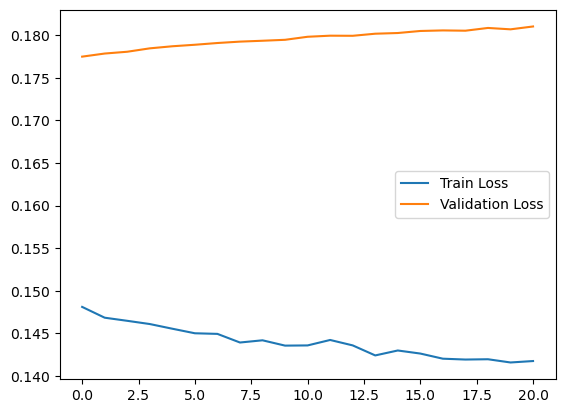

In [66]:
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

## 5.4 Ê®°ÂûãËØÑ‰º∞

### 0.Âä†ËΩΩÂéÜÂè≤Ê®°ÂûãËøõË°åËØÑ‰º∞

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# Âä†ËΩΩÊ®°Âûã
model_path = 'C:/Users/Administrator/Desktop/My research/2_ML_predict_product/model/Bi_LSTMWithMulAttention_input-1_hidden-32_layers-2_heads-2_lr-0.000100_loss-1.866484_batch-128_epoch-202_seq-4.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== ÂèÇÊï∞ËÆæÁΩÆ ======
input_size = 1       # ËæìÂÖ•ÁâπÂæÅÁª¥Â∫¶Ôºö[encoded_label, time]
hidden_size = 32
num_layers = 2
num_state_classes = len(state_encoder.classes_)  # Ëá™Âä®Ëé∑ÂèñÁ±ªÂà´Êï∞
num_heads = 2
# ====== ÂàùÂßãÂåñÊ®°Âûã ======
model = LSTMWithMulAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_state_classes=num_state_classes,
    dropout_rate=0.3,
    num_heads=num_heads
).to(device)


model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ÂàùÂßãÂåñËØÑ‰º∞ÊåáÊ†á
all_acc_scores = []
all_f1_scores = []
all_confusion_matrices = []
state_preds = []
state_targets = []

# Ëé∑ÂèñÊâÄÊúâÂèØËÉΩÁöÑÁ±ªÂà´Êï∞
num_state_classes = len(state_encoder.classes_)

with torch.no_grad():
    for x_val, y_state_val in train_loader:
        x_val = x_val.to(device).float()
        y_state_val = y_state_val.to(device).long()
        y_state_val = y_state_val.squeeze(-1)

        state_pred = model(x_val)
        state_preds.extend(torch.argmax(state_pred, dim=1).cpu().numpy())
        preds = torch.argmax(state_pred, dim=1).cpu().numpy()
        
        targets = y_state_val.cpu().numpy()
        state_targets.extend(y_state_val.cpu().numpy())

        # ËÆ°ÁÆóÂΩìÂâçÊâπÊ¨°ÁöÑËØÑ‰º∞ÊåáÊ†á
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds, average='weighted')
        
        # Á°Æ‰øùÊ∑∑Ê∑ÜÁü©ÈòµÂΩ¢Áä∂‰∏ÄËá¥ÔºåÊåáÂÆöÊâÄÊúâÂèØËÉΩÁöÑÁ±ªÂà´
        cm = confusion_matrix(targets, preds, labels=list(range(num_state_classes)))

        all_acc_scores.append(acc)
        all_f1_scores.append(f1)
        all_confusion_matrices.append(cm)

# ÂêàÂπ∂Ê∑∑Ê∑ÜÁü©Èòµ
final_cm = sum(all_confusion_matrices)
print("Final Confusion Matrix:\n", final_cm)

# ËÆ°ÁÆóÂπ≥ÂùáÂáÜÁ°ÆÁéáÂíå F1 ÂàÜÊï∞
avg_acc = np.mean(all_acc_scores)
avg_f1 = np.mean(all_f1_scores)
print("Average Accuracy:", avg_acc)
print("Average F1 Score:", avg_f1)

print("Accuracy:", accuracy_score(state_targets, state_preds))
print("F1 Score:", f1_score(state_targets, state_preds, average='weighted'))

# ÂèØËßÜÂåñÊ∑∑Ê∑ÜÁü©Èòµ
cm = confusion_matrix(state_targets, state_preds)
plt.figure(figsize=(25, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=state_encoder.classes_, yticklabels=state_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ‰øùÂ≠òÊ∑∑Ê∑ÜÁü©ÈòµÂà∞ CSV Êñá‰ª∂
df_cm = pd.DataFrame(cm, index=state_encoder.classes_, columns=state_encoder.classes_)
#df_cm.to_csv("confusion_matrix.csv")

### 1.3 ÂçïËæìÂá∫Ê®°ÂûãËØÑ‰º∞-ÂàÜÁ±ªÈóÆÈ¢ò

Final Confusion Matrix:
 [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [ 

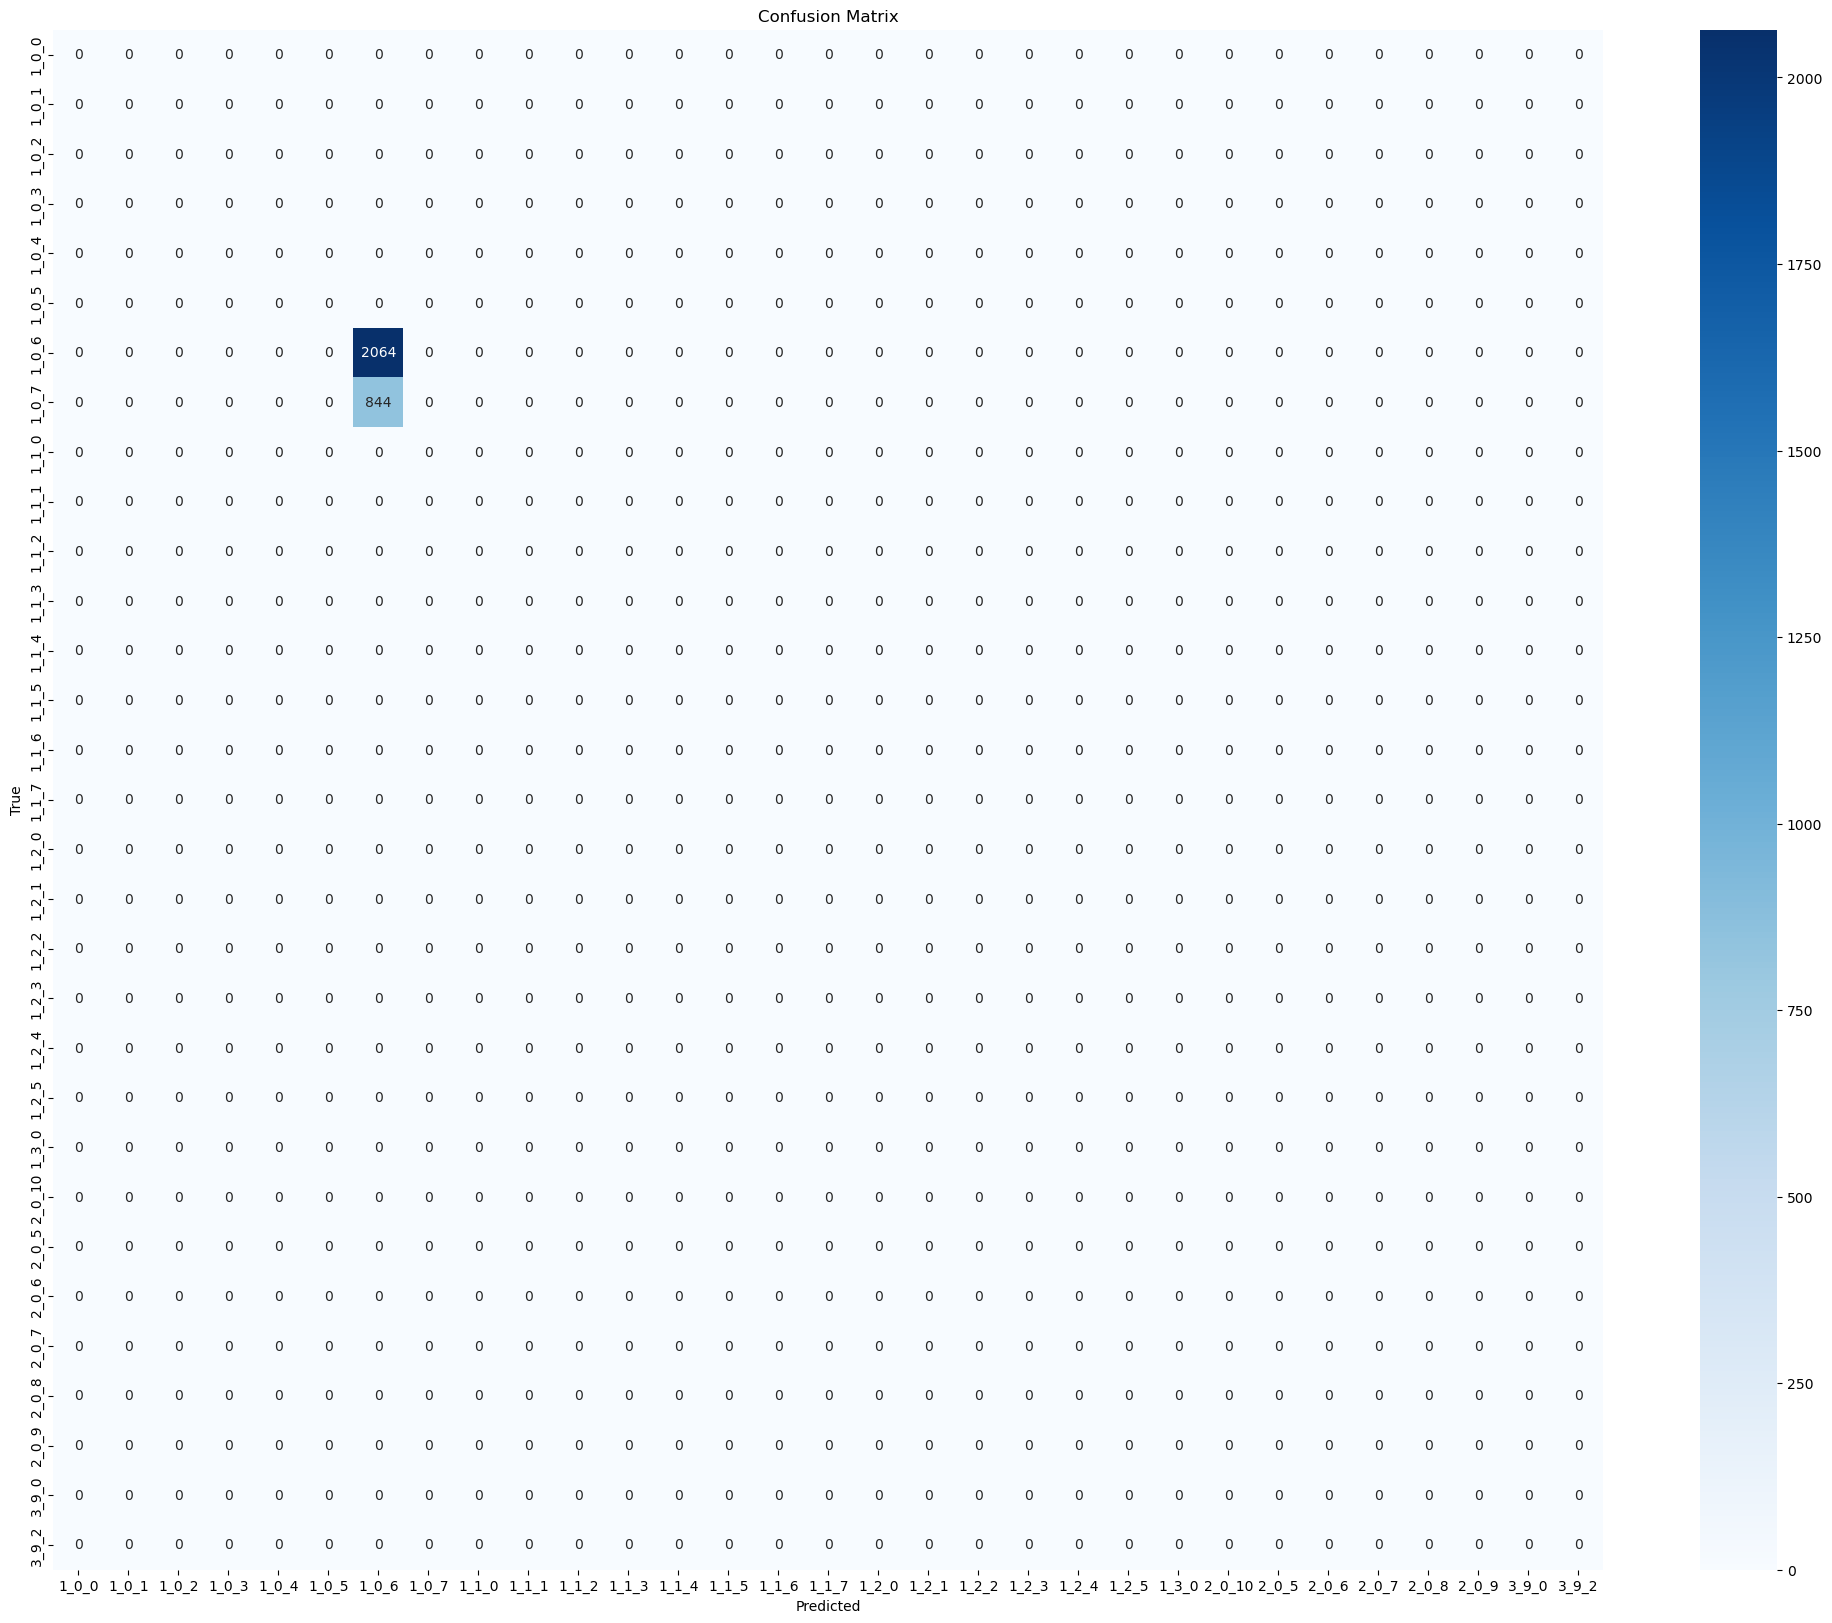

Á±ªÂà´Á¥¢ÂºïÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö
Á±ªÂà´ 0: 1_0_0
Á±ªÂà´ 1: 1_0_1
Á±ªÂà´ 2: 1_0_2
Á±ªÂà´ 3: 1_0_3
Á±ªÂà´ 4: 1_0_4
Á±ªÂà´ 5: 1_0_5
Á±ªÂà´ 6: 1_0_6
Á±ªÂà´ 7: 1_0_7
Á±ªÂà´ 8: 1_1_0
Á±ªÂà´ 9: 1_1_1
Á±ªÂà´ 10: 1_1_2
Á±ªÂà´ 11: 1_1_3
Á±ªÂà´ 12: 1_1_4
Á±ªÂà´ 13: 1_1_5
Á±ªÂà´ 14: 1_1_6
Á±ªÂà´ 15: 1_1_7
Á±ªÂà´ 16: 1_2_0
Á±ªÂà´ 17: 1_2_1
Á±ªÂà´ 18: 1_2_2
Á±ªÂà´ 19: 1_2_3
Á±ªÂà´ 20: 1_2_4
Á±ªÂà´ 21: 1_2_5
Á±ªÂà´ 22: 1_3_0
Á±ªÂà´ 23: 2_0_10
Á±ªÂà´ 24: 2_0_5
Á±ªÂà´ 25: 2_0_6
Á±ªÂà´ 26: 2_0_7
Á±ªÂà´ 27: 2_0_8
Á±ªÂà´ 28: 2_0_9
Á±ªÂà´ 29: 3_9_0
Á±ªÂà´ 30: 3_9_2


In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# ÂÅáËÆæ state_encoder Âíå model Â∑≤ÂÆö‰πâ
# state_encoder = ...
# model = ...

all_acc_scores = []
all_f1_scores = []
all_confusion_matrices = []
state_preds = []
state_targets = []

# Ëé∑ÂèñÊâÄÊúâÂèØËÉΩÁöÑÁ±ªÂà´Êï∞
num_state_classes = len(state_encoder.classes_)
class_labels = list(range(num_state_classes))  # Á°Æ‰øùÁ±ªÂà´Ê†áÁ≠æÈ°∫Â∫è‰∏é state_encoder.classes_ ‰∏ÄËá¥

with torch.no_grad():
    for x_val, y_state_val in test_loader:
        x_val = x_val.to(device).float()
        y_state_val = y_state_val.to(device).long()
        y_state_val = y_state_val.squeeze(-1)

        state_pred = model(x_val)
        preds = torch.argmax(state_pred, dim=1).cpu().numpy()
        
        targets = y_state_val.cpu().numpy()
        state_preds.extend(preds)
        state_targets.extend(targets)

        # ËÆ°ÁÆóÂΩìÂâçÊâπÊ¨°ÁöÑËØÑ‰º∞ÊåáÊ†á
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds, average='weighted')
        
        # Á°Æ‰øùÊ∑∑Ê∑ÜÁü©ÈòµÂΩ¢Áä∂‰∏ÄËá¥ÔºåÊåáÂÆöÊâÄÊúâÂèØËÉΩÁöÑÁ±ªÂà´
        cm = confusion_matrix(targets, preds, labels=class_labels)

        all_acc_scores.append(acc)
        all_f1_scores.append(f1)
        all_confusion_matrices.append(cm)

# ÂêàÂπ∂Ê∑∑Ê∑ÜÁü©Èòµ
final_cm = sum(all_confusion_matrices)
print("Final Confusion Matrix:\n", final_cm)

# ËÆ°ÁÆóÊï¥‰ΩìÂáÜÁ°ÆÁéáÂíå F1 ÂàÜÊï∞
overall_acc = accuracy_score(state_targets, state_preds)
overall_f1 = f1_score(state_targets, state_preds, average='weighted')
print("Overall Accuracy:", overall_acc)
print("Overall F1 Score:", overall_f1)

# ÁªòÂà∂Ê∑∑Ê∑ÜÁü©Èòµ
plt.figure(figsize=(25, 20))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=state_encoder.classes_, yticklabels=state_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ËæìÂá∫Á±ªÂà´ÂêçÁß∞ÂèäÂÖ∂ÂØπÂ∫îÁöÑÁ¥¢Âºï
print("Á±ªÂà´Á¥¢ÂºïÂØπÂ∫îÁöÑÁâ©ÁßçÂêçÁß∞Ôºö")
for idx, cls in enumerate(state_encoder.classes_):
    print(f"Á±ªÂà´ {idx}: {cls}")

Ê∑∑Ê∑ÜÁü©ÈòµÁªìÊûúÊèêÂèñ

In [23]:
import numpy as np
import pandas as pd

# ÂÅáËÆæ final_cm ÊòØÊúÄÁªàÁöÑÊ∑∑Ê∑ÜÁü©Èòµ
# final_cm = confusion_matrix(state_targets, state_preds)

# Ëé∑ÂèñÊâÄÊúâÂèØËÉΩÁöÑÁ±ªÂà´Êï∞ÂíåÁ±ªÂà´ÂêçÁß∞
num_state_classes = len(final_cm)
classes = state_encoder.classes_  # Áâ©ÁßçÂêçÁß∞ÂàóË°®

# ÂàùÂßãÂåñÁªüËÆ°Â≠óÂÖ∏
correct_rates = {}  # Â≠òÂÇ®ÊØè‰∏™Áâ©ÁßçÁöÑÊ≠£Á°ÆÁéá
correct_counts = {}  # Â≠òÂÇ®ÊØè‰∏™Áâ©ÁßçÁöÑÊ≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞
wrong_predictions = {}  # Â≠òÂÇ®ÊØè‰∏™Áâ©ÁßçÈ¢ÑÊµãÈîôËØØÁöÑÁõÆÊ†áÁâ©ÁßçÂèäÊ¨°Êï∞

# ÈÅçÂéÜÊ∑∑Ê∑ÜÁü©ÈòµÔºåËÆ°ÁÆóÊØè‰∏™Áâ©ÁßçÁöÑÊ≠£Á°ÆÁéá„ÄÅÊ≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞ÂíåÈîôËØØÈ¢ÑÊµãÂàÜÂ∏É
for i in range(num_state_classes):
    total_samples = np.sum(final_cm[i, :])  # Á¨¨ i Á±ªÂà´ÁöÑÊÄªÊ†∑Êú¨Êï∞
    correct_predictions = final_cm[i, i]  # Á¨¨ i Á±ªÂà´ÁöÑÊ≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞
    
    if total_samples > 0:
        correct_rates[i] = (correct_predictions / total_samples) * 100  # Ê≠£Á°ÆÁéá
    else:
        correct_rates[i] = 0  # Â¶ÇÊûúËØ•Á±ªÂà´Ê≤°ÊúâÊ†∑Êú¨ÔºåÂàôÊ≠£Á°ÆÁéá‰∏∫ 0
    
    # ËÆ∞ÂΩïÊ≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞
    correct_counts[i] = correct_predictions
    
    # ÁªüËÆ°ÈîôËØØÈ¢ÑÊµãÁöÑÁõÆÊ†áÁâ©ÁßçÂèäÊ¨°Êï∞
    wrong_pred = {}
    for j in range(num_state_classes):
        if i != j and final_cm[i, j] > 0:  # ÊéíÈô§ÂØπËßíÁ∫øÂÖÉÁ¥†ÔºàÊ≠£Á°ÆÈ¢ÑÊµãÔºâ
            wrong_pred[classes[j]] = final_cm[i, j]  # ‰ΩøÁî®Áâ©ÁßçÂêçÁß∞‰ª£ÊõøÁºñÂè∑
    
    # ÊåâÈîôËØØÊ¨°Êï∞ÈôçÂ∫èÊéíÂ∫èÔºåÂèñÂâç 3 ‰∏™
    wrong_predictions[i] = sorted(wrong_pred.items(), key=lambda x: x[1], reverse=True)[:3]

# ÂàõÂª∫ DataFrame Ë°®Ê†º
data = []
for species_idx in range(num_state_classes):
    species_name = classes[species_idx]  # ÂΩìÂâçÁâ©ÁßçÂêçÁß∞
    row = {
        "Áâ©Áßç": species_name,
        "Ê≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞": correct_counts[species_idx],
        "Ê≠£Á°ÆÁéá(%)": f"{correct_rates[species_idx]:.2f}"
    }
    for idx, (target_species_name, count) in enumerate(wrong_predictions[species_idx]):
        row[f"ÈîôËØØÈ¢ÑÊµã‰∏∫Áâ©Áßç {idx+1}"] = target_species_name  # ÈîôËØØÈ¢ÑÊµãÁöÑÁõÆÊ†áÁâ©ÁßçÂêçÁß∞
        row[f"ÈîôËØØÊ¨°Êï∞ {idx+1}"] = count
    data.append(row)

# ËΩ¨Êç¢‰∏∫ DataFrame
df = pd.DataFrame(data)

# Á°Æ‰øùÂàóÈ°∫Â∫èÊï¥ÈΩê
columns_order = ["Áâ©Áßç", "Ê≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞", "Ê≠£Á°ÆÁéá(%)"]  # Êñ∞Â¢ûÂàóÊèíÂÖ•Âà∞Á¨¨‰∫åÂàó
for i in range(3):  # ÊúÄÂ§öÊòæÁ§∫Ââç 3 ‰∏™ÈîôËØØÈ¢ÑÊµã
    columns_order.extend([f"ÈîôËØØÈ¢ÑÊµã‰∏∫Áâ©Áßç {i+1}", f"ÈîôËØØÊ¨°Êï∞ {i+1}"])
df = df[columns_order]

# ÊåâÁÖßÊ≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞ÈôçÂ∫èÊéíÂàó
df_sorted = df.sort_values(by="Ê≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞", ascending=False)

# ËæìÂá∫Ë°®Ê†º
print("ÊØè‰∏™Áâ©ÁßçÁöÑÈ¢ÑÊµãÁªüËÆ°ÁªìÊûúÔºö")
print(df_sorted.to_string(index=False))

# Â∞ÜÊéíÂ∫èÂêéÁöÑÊï∞ÊçÆ‰øùÂ≠òÂà∞ CSV Êñá‰ª∂
df_sorted.to_csv("species_prediction_stats_sorted.csv", index=False)

KeyError: "['ÈîôËØØÈ¢ÑÊµã‰∏∫Áâ©Áßç 2', 'ÈîôËØØÊ¨°Êï∞ 2', 'ÈîôËØØÈ¢ÑÊµã‰∏∫Áâ©Áßç 3', 'ÈîôËØØÊ¨°Êï∞ 3'] not in index"

### 1.4 ÂçïËæìÂá∫Ê®°ÂûãËØÑ‰º∞-ÂõûÂΩíÈóÆÈ¢òÔºàX4Áª¥Ôºåy3Áª¥Ôºâ

##### ËØÑ‰ª∑‰∏çÂÅöÊï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÁöÑXÂíåy

y_test Á±ªÂà´ÂàÜÂ∏É:
1_0_7: 1408
1_0_6: 1417


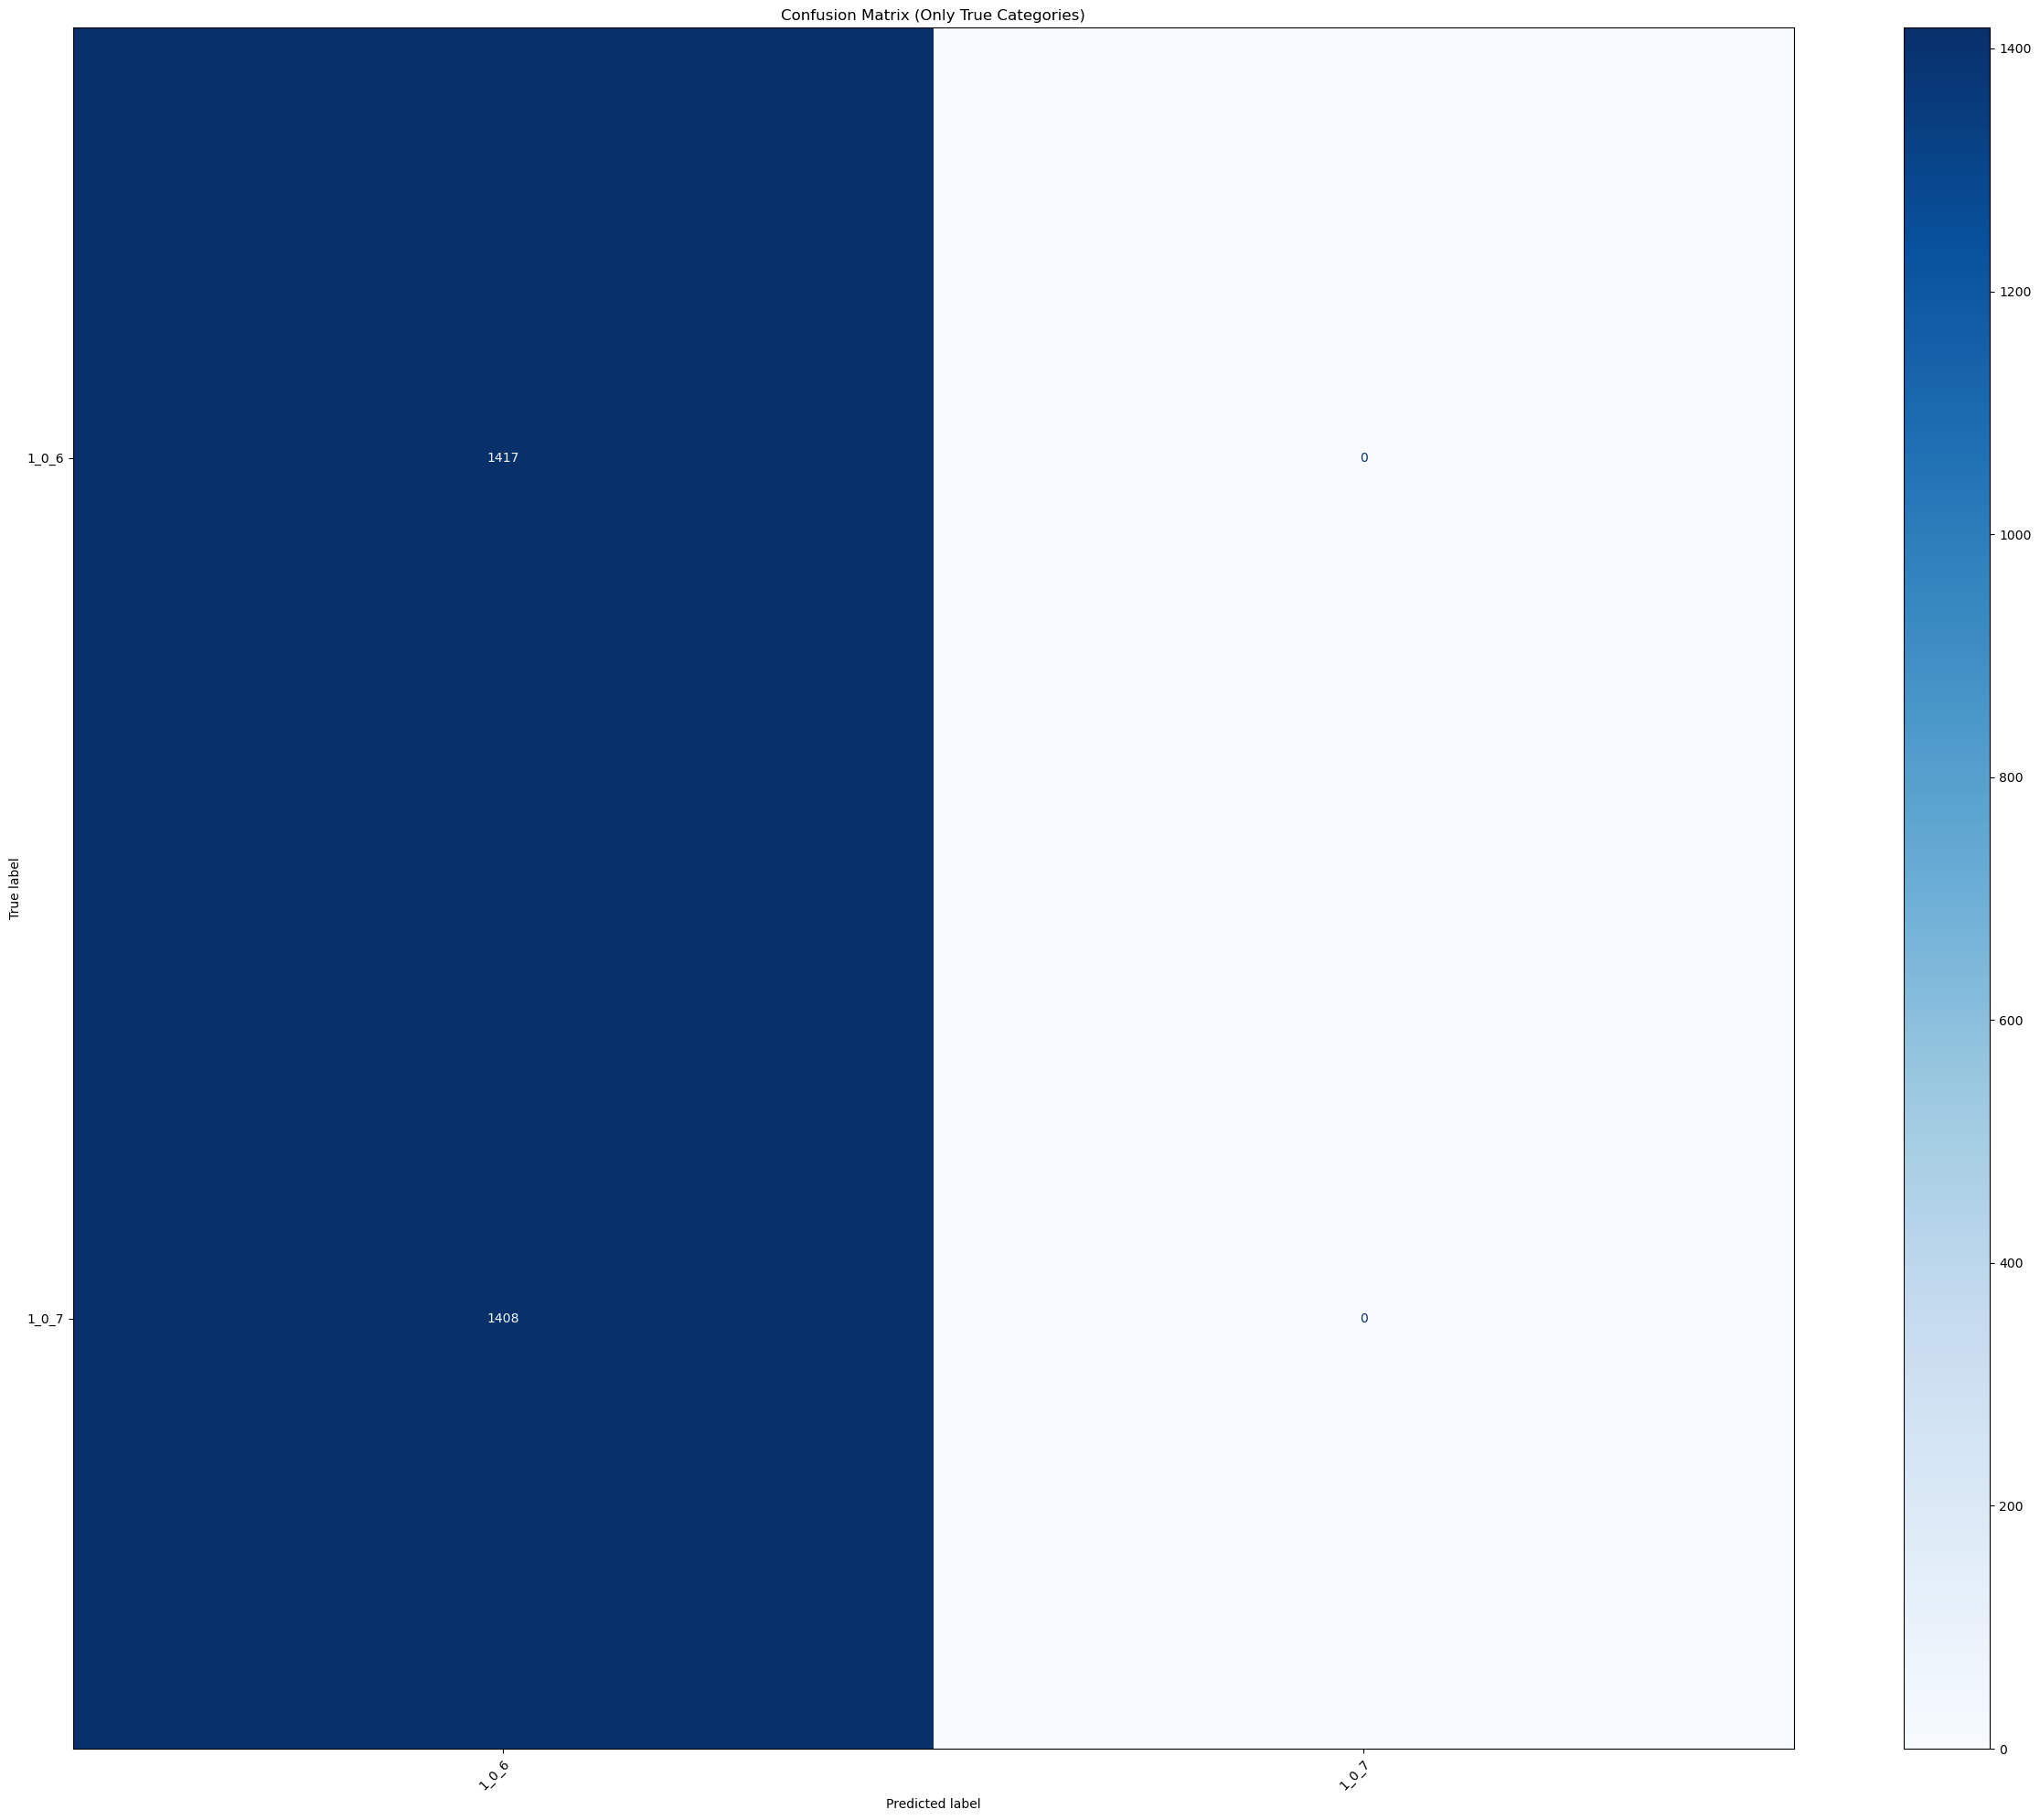

ÊØè‰∏™Á±ªÂà´ÁöÑÈ¢ÑÊµãÊ≠£Á°ÆÊ¨°Êï∞ÂíåÂè¨ÂõûÁéá:
1_0_6: Ê≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞ = 1417, Âè¨ÂõûÁéá = 1.0000
1_0_7: Ê≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞ = 0, Âè¨ÂõûÁéá = 0.0000

ÊØè‰∏™ÂÆûÈôÖÁâ©ÁßçÈ¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ªÁâ©ÁßçÁöÑÊ¨°Êï∞:
ÂÆûÈôÖÁ±ªÂà´ 1_0_6 Ê≤°ÊúâÈ¢ÑÊµãÈîôËØØÔºàÂú®ÁúüÂÆûÁ±ªÂà´‰∏≠Ôºâ„ÄÇ
ÂÆûÈôÖÁ±ªÂà´ 1_0_7 È¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ª:
  È¢ÑÊµã‰∏∫ 1_0_6: 1408 Ê¨°

Ê≤°ÊúâÈ¢ÑÊµãÂà∞ y_test ‰∏≠Êú™Âá∫Áé∞ÁöÑÁ±ªÂà´„ÄÇ

Âπ≥ÂùáÊµãËØïÊçüÂ§±: 0.0834
Á±ªÂà´ÂáÜÁ°ÆÁéáÔºà‰ªÖÁúüÂÆûÁ±ªÂà´Ôºâ: 0.5016
È¢ÑÊµãÂà∞Êú™Áü•Á±ªÂà´ÁöÑÊ†∑Êú¨Êï∞: 0


In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, recall_score, ConfusionMatrixDisplay
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, test_loader, device, criterion):
    model.eval()
    test_losses = []
    all_outputs_rounded = []
    all_y_true = []

    # Êï∞ÊçÆÊî∂ÈõÜÈò∂ÊÆµ
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            test_losses.append(loss.item())
            
            # Ëá™ÂÆö‰πâÂõõËàç‰∫îÂÖ•ÔºöÂ∞èÊï∞ÈÉ®ÂàÜ < 1/3 ËàçÔºåÂ§ß‰∫éÊàñÁ≠â‰∫é1/3Ëøõ‰Ωç
            x_floor = torch.floor(outputs)
            remainder = outputs - x_floor
            outputs_custom = torch.where(remainder < (0.5), x_floor, x_floor + 1)
            outputs_custom = outputs_custom.int().cpu().numpy()
            
            y_batch_int = y_batch.int().cpu().numpy()

            all_outputs_rounded.append(outputs_custom)
            all_y_true.append(y_batch_int)

    all_outputs_rounded = np.vstack(all_outputs_rounded)
    all_y_true = np.vstack(all_y_true)

    # Â∞ÜÂ§öÁª¥Ê†áÁ≠æËΩ¨Êç¢‰∏∫Â≠óÁ¨¶‰∏≤ÂΩ¢Âºè
    y_true_labels = ["_".join(map(str, y)) for y in all_y_true]
    y_pred_labels = ["_".join(map(str, y)) for y in all_outputs_rounded]

    # Ëé∑ÂèñÊµãËØïÈõÜ‰∏≠ÁúüÂÆûÂá∫Áé∞ÁöÑÂîØ‰∏ÄÁ±ªÂà´
    true_categories = list(set(y_true_labels))

    # ‰ΩøÁî® LabelEncoder Âè™ÂØπÁúüÂÆûÁ±ªÂà´ËøõË°å fit
    encoder = LabelEncoder()
    encoder.fit(true_categories)

    # ËΩ¨Êç¢ y_true_labels
    y_true_encoded = encoder.transform(y_true_labels)

    # Â§ÑÁêÜ y_pred_labelsÔºö‰∏çÂú®ÁúüÂÆûÁ±ªÂà´‰∏≠ÁöÑÈ¢ÑÊµãÊ†áÁ≠æÊ†áËÆ∞‰∏∫ -1ÔºàunknownÔºâ
    y_pred_encoded = []
    unknown_count = 0
    for label in y_pred_labels:
        if label in true_categories:
            y_pred_encoded.append(encoder.transform([label])[0])
        else:
            y_pred_encoded.append(-1)  # Ê†áËÆ∞‰∏∫ 'unknown'
            unknown_count += 1
    y_pred_encoded = np.array(y_pred_encoded)

    # **ÁªüËÆ° y_test ÁöÑÁ±ªÂà´ÂàÜÂ∏É**
    category_counts = Counter(y_true_labels)
    print("y_test Á±ªÂà´ÂàÜÂ∏É:")
    for category, count in category_counts.items():
        print(f"{category}: {count}")

    # **ËÆ°ÁÆóÂπ≥ÂùáÊµãËØïÊçüÂ§±**
    avg_test_loss = sum(test_losses) / len(test_losses)

    # **ËÆ°ÁÆóÁ±ªÂà´ÂáÜÁ°ÆÁéáÔºà‰ªÖËÄÉËôëÈ¢ÑÊµãÊ†áÁ≠æÂú®ÁúüÂÆûÁ±ªÂà´‰∏≠ÁöÑÊ†∑Êú¨Ôºâ**
    mask = y_pred_encoded != -1
    category_correct = (y_true_encoded[mask] == y_pred_encoded[mask]).sum()
    total_samples = mask.sum()
    category_acc = category_correct / total_samples if total_samples > 0 else 0

    # **ÁªòÂà∂Ê∑∑Ê∑ÜÁü©ÈòµÔºà‰ªÖÂåÖÂê´ÁúüÂÆûÁ±ªÂà´Ôºâ**
    cm = confusion_matrix(y_true_encoded, y_pred_encoded, labels=range(len(encoder.classes_)))
    fig, ax = plt.subplots(figsize=(25, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.title("Confusion Matrix (Only True Categories)")
    plt.tight_layout()
    plt.show()

    # **ËÆ°ÁÆóÊØè‰∏™Á±ªÂà´ÁöÑÈ¢ÑÊµãÊ≠£Á°ÆÊ¨°Êï∞ÂíåÂè¨ÂõûÁéá**
    recall_per_class = recall_score(y_true_encoded, y_pred_encoded, average=None, labels=range(len(encoder.classes_)), zero_division=0)
    print("ÊØè‰∏™Á±ªÂà´ÁöÑÈ¢ÑÊµãÊ≠£Á°ÆÊ¨°Êï∞ÂíåÂè¨ÂõûÁéá:")
    for i, category in enumerate(encoder.classes_):
        correct_count = cm[i, i]
        recall = recall_per_class[i]
        print(f"{category}: Ê≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞ = {correct_count}, Âè¨ÂõûÁéá = {recall:.4f}")

    # **ÁªüËÆ°ÊØè‰∏™ÂÆûÈôÖÁâ©ÁßçÈ¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ªÁâ©ÁßçÁöÑÊ¨°Êï∞Ôºà‰ªÖÂú®ÁúüÂÆûÁ±ªÂà´‰∏≠Ôºâ**
    print("\nÊØè‰∏™ÂÆûÈôÖÁâ©ÁßçÈ¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ªÁâ©ÁßçÁöÑÊ¨°Êï∞:")
    for i, category in enumerate(encoder.classes_):
        error_indices = np.where((y_true_encoded == i) & (y_pred_encoded != i) & (y_pred_encoded != -1))[0]
        if len(error_indices) > 0:
            error_preds = y_pred_encoded[error_indices]
            error_counts = Counter(error_preds)
            top3_errors = error_counts.most_common(3)
            print(f"ÂÆûÈôÖÁ±ªÂà´ {category} È¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ª:")
            for err_category, count in top3_errors:
                err_category_label = encoder.classes_[err_category]
                print(f"  È¢ÑÊµã‰∏∫ {err_category_label}: {count} Ê¨°")
        else:
            print(f"ÂÆûÈôÖÁ±ªÂà´ {category} Ê≤°ÊúâÈ¢ÑÊµãÈîôËØØÔºàÂú®ÁúüÂÆûÁ±ªÂà´‰∏≠Ôºâ„ÄÇ")

    # **ÁªüËÆ°È¢ÑÊµã‰∏≠Âá∫Áé∞ÁöÑÈ¢ùÂ§ñÁ±ªÂà´Ôºà‰∏çÂú®ÊµãËØïÈõÜ‰∏≠Ôºâ**
    extra_categories = set(y_pred_labels) - set(true_categories)
    if extra_categories:
        print("\nÈ¢ÑÊµã‰∏≠Âá∫Áé∞ÁöÑÈ¢ùÂ§ñÁ±ªÂà´Ôºà‰∏çÂú® y_test ‰∏≠ÔºâÔºö")
        for category in extra_categories:
            count = y_pred_labels.count(category)
            print(f"{category}: {count} Ê¨°")
    else:
        print("\nÊ≤°ÊúâÈ¢ÑÊµãÂà∞ y_test ‰∏≠Êú™Âá∫Áé∞ÁöÑÁ±ªÂà´„ÄÇ")

    # ËæìÂá∫ÁªìÊûú
    print(f"\nÂπ≥ÂùáÊµãËØïÊçüÂ§±: {avg_test_loss:.4f}")
    print(f"Á±ªÂà´ÂáÜÁ°ÆÁéáÔºà‰ªÖÁúüÂÆûÁ±ªÂà´Ôºâ: {category_acc:.4f}")
    print(f"È¢ÑÊµãÂà∞Êú™Áü•Á±ªÂà´ÁöÑÊ†∑Êú¨Êï∞: {unknown_count}")

    return avg_test_loss, category_acc

# ‰ΩøÁî®Á§∫‰æã
avg_test_loss, category_acc = evaluate_model(model, train_loader, device, criterion)

##### Ââç‰∏âÁª¥ÁâπÂæÅÁªèËøáÊ†áÂáÜÂåñÂ§ÑÁêÜÁöÑÊï∞ÊçÆÊ®°ÂûãËØÑ‰º∞

y_test Á±ªÂà´ÂàÜÂ∏É:
1_0_6: 400
1_0_7: 443


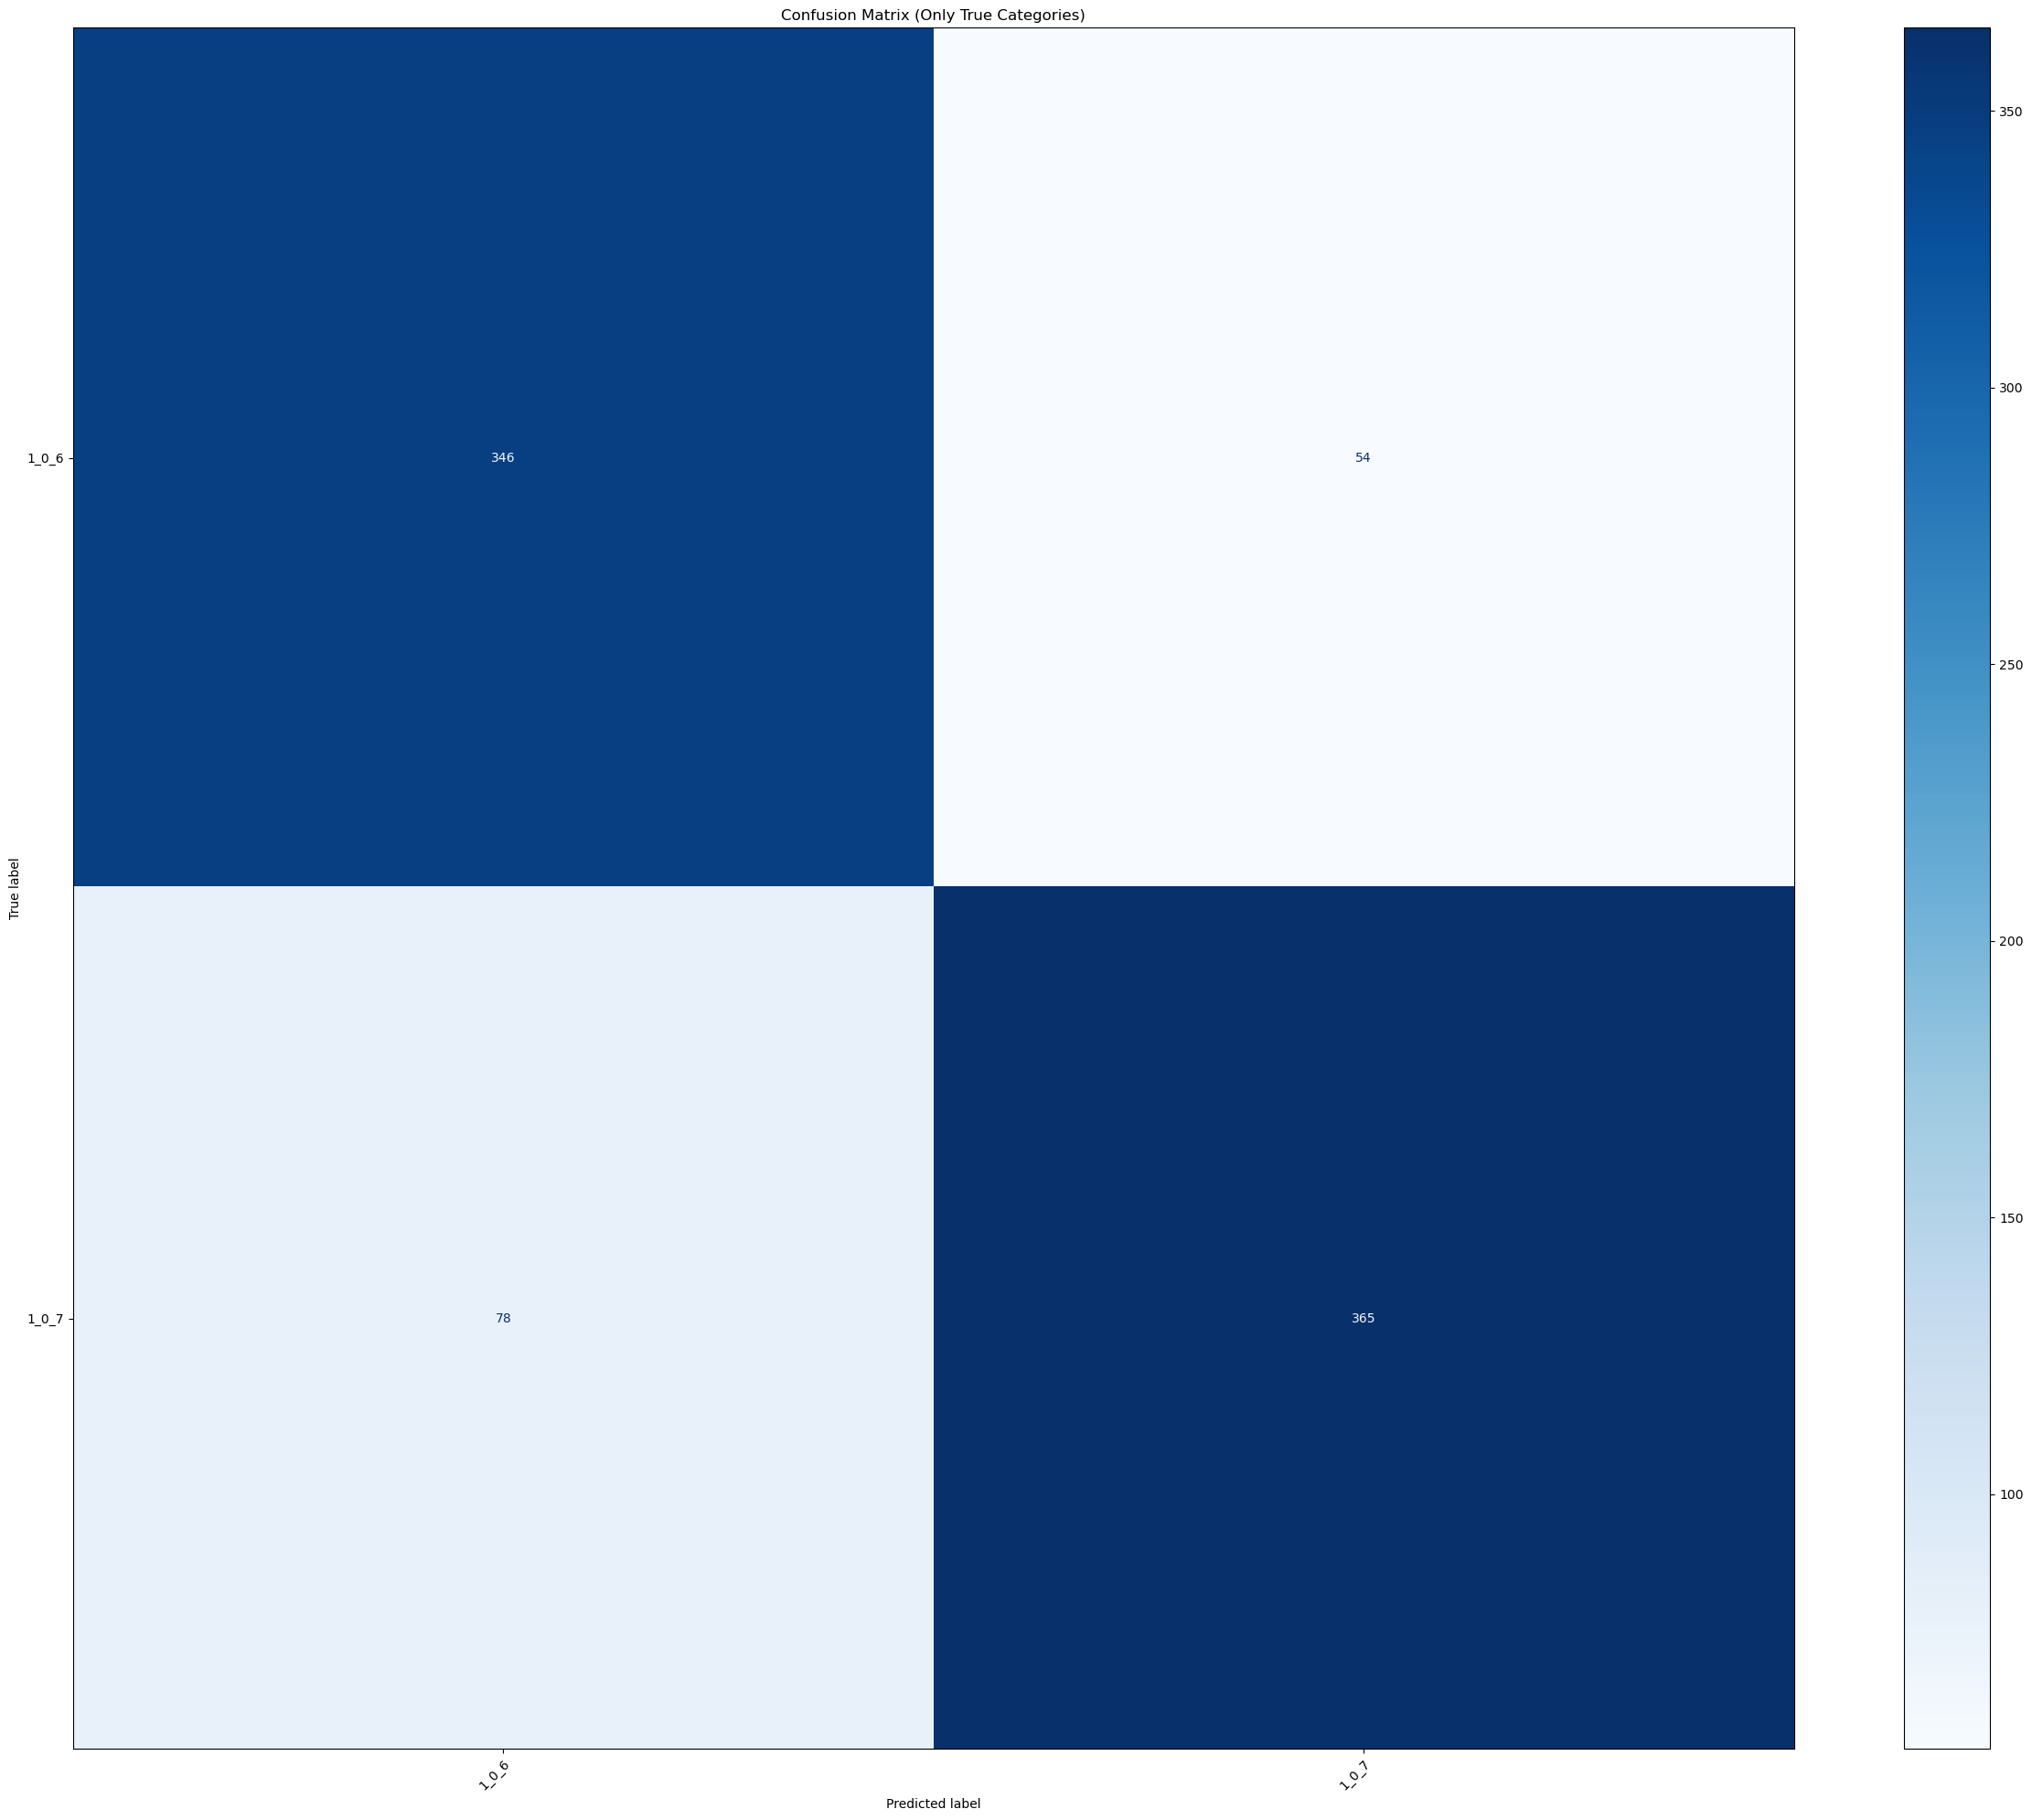

ÊØè‰∏™Á±ªÂà´ÁöÑÈ¢ÑÊµãÊ≠£Á°ÆÊ¨°Êï∞ÂíåÂè¨ÂõûÁéá:
1_0_6: Ê≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞ = 346, Âè¨ÂõûÁéá = 0.8650
1_0_7: Ê≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞ = 365, Âè¨ÂõûÁéá = 0.8239

ÊØè‰∏™ÂÆûÈôÖÁâ©ÁßçÈ¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ªÁâ©ÁßçÁöÑÊ¨°Êï∞:
ÂÆûÈôÖÁ±ªÂà´ 1_0_6 È¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ª:
  È¢ÑÊµã‰∏∫ 1_0_7: 54 Ê¨°
ÂÆûÈôÖÁ±ªÂà´ 1_0_7 È¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ª:
  È¢ÑÊµã‰∏∫ 1_0_6: 78 Ê¨°

Ê≤°ÊúâÈ¢ÑÊµãÂà∞ y_test ‰∏≠Êú™Âá∫Áé∞ÁöÑÁ±ªÂà´„ÄÇ

Âπ≥ÂùáÊµãËØïÊçüÂ§±: 0.1775
Á±ªÂà´ÂáÜÁ°ÆÁéáÔºà‰ªÖÁúüÂÆûÁ±ªÂà´Ôºâ: 0.8434
È¢ÑÊµãÂà∞Êú™Áü•Á±ªÂà´ÁöÑÊ†∑Êú¨Êï∞: 0


In [67]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, recall_score, ConfusionMatrixDisplay
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, test_loader, device, criterion, y_scaler):
    """
    model: ËÆ≠ÁªÉÂ•ΩÁöÑÊ®°Âûã
    test_loader: ÊµãËØïÊï∞ÊçÆ DataLoader
    device: ËÆæÂ§á (CPU Êàñ GPU)
    criterion: ÊçüÂ§±ÂáΩÊï∞ (‰æãÂ¶Ç MSELoss, ÊàñÂÖ∂‰ªñ)
    y_scaler: ÈíàÂØπ y ÁöÑ StandardScalerÔºåÁî®‰∫éÊÅ¢Â§çÊ†áÂáÜÂåñÂâçÁöÑÊï∞ÂÄº
    """
    model.eval()
    test_losses = []
    all_outputs_rounded = []
    all_y_true = []

    # Êï∞ÊçÆÊî∂ÈõÜÈò∂ÊÆµ
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            # È¢ÑÊµã (‰ªçÁÑ∂ÊòØÊ†áÂáÜÂåñÁ©∫Èó¥‰∏ãÁöÑÂÄº)
            outputs = model(x_batch)

            # ËÆ°ÁÆóÊçüÂ§± (Ê≠§Êó∂ outputs ‰∏é y_batch ÈÉΩÊòØÊ†áÂáÜÂåñËøáÁöÑ)
            loss = criterion(outputs, y_batch)
            test_losses.append(loss.item())

            # ---- 1) ËΩ¨Âõû CPUÔºåÂπ∂‰ªéÊ†áÂáÜÂåñÂÄºÊÅ¢Â§çÂà∞ÂéüÂßãÊï∞ÂÄº ----
            # outputs_std.shape = [batch_size, 3] (Ê†áÂáÜÂåñÂêéÁöÑÈ¢ÑÊµã)
            outputs_std = outputs.cpu().numpy()
            # y_batch_std.shape = [batch_size, 3] (Ê†áÂáÜÂåñÂêéÁöÑÁúüÂÆûÊ†áÁ≠æ)
            y_batch_std = y_batch.cpu().numpy()

            # Áî® y_scaler ÊÅ¢Â§çÊ†áÂáÜÂåñÔºö  -> ÂéüÂßãÂÄº
            outputs_original = y_scaler.inverse_transform(outputs_std)
            y_batch_original = y_scaler.inverse_transform(y_batch_std)

            # ---- 2) Ëá™ÂÆö‰πâËàçÂÖ•ÈÄªËæëÔºàÂú®ÂéüÂßãÂÄºÁ©∫Èó¥‰∏≠Êìç‰ΩúÔºâ----
            # ËøôÈáåÁöÑÈÄªËæëÁ§∫‰æãÔºöËã•Â∞èÊï∞ < 0.5 Â∞±‰∏ãÂèñÊï¥ÔºåÂê¶Âàô‰∏äÂèñÊï¥
            # ‰πüÂèØ‰ª•‰øÆÊîπ‰∏∫ < 1/3 ËàçÔºåÂê¶ÂàôËøõ‰ΩçÔºåÁ±ª‰ººÔºö
            # remainder < 1/3 -> floor, remainder >= 1/3 -> floor + 1
            x_floor = np.floor(outputs_original)
            remainder = outputs_original - x_floor
            outputs_custom = np.where(remainder < 0.5, x_floor, x_floor + 1).astype(int)
            
            y_batch_int = y_batch_original.astype(int)  # Â∞ÜÁúüÂÆûÂÄº‰πüÂèñÊï¥ÔºàËã•ÂéüÊú¨Â∞±ÊòØÊï¥Êï∞ÔºåÂèØÁõ¥Êé• .astype(int))

            # ---- 3) Á¥ØÁßØÈ¢ÑÊµã‰∏éÁúüÂÆûÊ†áÁ≠æÔºå‰ª•‰æøÂêéÁª≠ËØÑ‰º∞ ----
            all_outputs_rounded.append(outputs_custom)
            all_y_true.append(y_batch_int)

    # ---- Â∞ÜÊâÄÊúâÊâπÊ¨°ÊãºÊé•Âú®‰∏ÄËµ∑ ----
    all_outputs_rounded = np.vstack(all_outputs_rounded)  # shape = [N, 3]
    all_y_true = np.vstack(all_y_true)                    # shape = [N, 3]

    # ---- ÂêéÁª≠ËØÑ‰º∞ÔºöÊ∑∑Ê∑ÜÁü©Èòµ„ÄÅÂè¨ÂõûÁéá„ÄÅÂáÜÁ°ÆÁéáÁ≠â ----
    y_true_labels = ["_".join(map(str, y)) for y in all_y_true]
    y_pred_labels = ["_".join(map(str, y)) for y in all_outputs_rounded]

    # 1) Ëé∑ÂèñÊµãËØïÈõÜ‰∏≠ÁúüÂÆûÂá∫Áé∞ÁöÑÂîØ‰∏ÄÁ±ªÂà´
    true_categories = list(set(y_true_labels))

    # 2) ‰ΩøÁî® LabelEncoder Âè™ÂØπÁúüÂÆûÁ±ªÂà´ËøõË°å fit
    encoder = LabelEncoder()
    encoder.fit(true_categories)

    # 3) ËΩ¨Êç¢ y_true_labels
    y_true_encoded = encoder.transform(y_true_labels)

    # 4) Â§ÑÁêÜ y_pred_labelsÔºö‰∏çÂú®ÁúüÂÆûÁ±ªÂà´‰∏≠ÁöÑÈ¢ÑÊµãÊ†áÁ≠æÊ†áËÆ∞‰∏∫ -1ÔºàunknownÔºâ
    y_pred_encoded = []
    unknown_count = 0
    for label in y_pred_labels:
        if label in true_categories:
            y_pred_encoded.append(encoder.transform([label])[0])
        else:
            y_pred_encoded.append(-1)  # Ê†áËÆ∞‰∏∫ 'unknown'
            unknown_count += 1
    y_pred_encoded = np.array(y_pred_encoded)

    # 5) ÁªüËÆ° y_test ÁöÑÁ±ªÂà´ÂàÜÂ∏É
    category_counts = Counter(y_true_labels)
    print("y_test Á±ªÂà´ÂàÜÂ∏É:")
    for category, count in category_counts.items():
        print(f"{category}: {count}")

    # 6) ËÆ°ÁÆóÂπ≥ÂùáÊµãËØïÊçüÂ§±
    avg_test_loss = sum(test_losses) / len(test_losses)

    # 7) ËÆ°ÁÆóÁ±ªÂà´ÂáÜÁ°ÆÁéáÔºà‰ªÖËÄÉËôëÈ¢ÑÊµãÊ†áÁ≠æÂú®ÁúüÂÆûÁ±ªÂà´‰∏≠ÁöÑÊ†∑Êú¨Ôºâ
    mask = (y_pred_encoded != -1)
    category_correct = (y_true_encoded[mask] == y_pred_encoded[mask]).sum()
    total_samples = mask.sum()
    category_acc = category_correct / total_samples if total_samples > 0 else 0

    # 8) ÁªòÂà∂Ê∑∑Ê∑ÜÁü©ÈòµÔºà‰ªÖÂåÖÂê´ÁúüÂÆûÁ±ªÂà´Ôºâ
    cm = confusion_matrix(y_true_encoded, y_pred_encoded, labels=range(len(encoder.classes_)))
    fig, ax = plt.subplots(figsize=(25, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.title("Confusion Matrix (Only True Categories)")
    plt.tight_layout()
    plt.show()

    # 9) ËÆ°ÁÆóÊØè‰∏™Á±ªÂà´ÁöÑÈ¢ÑÊµãÊ≠£Á°ÆÊ¨°Êï∞ÂíåÂè¨ÂõûÁéá
    recall_per_class = recall_score(y_true_encoded, y_pred_encoded,
                                    average=None, labels=range(len(encoder.classes_)), zero_division=0)
    print("ÊØè‰∏™Á±ªÂà´ÁöÑÈ¢ÑÊµãÊ≠£Á°ÆÊ¨°Êï∞ÂíåÂè¨ÂõûÁéá:")
    for i, category in enumerate(encoder.classes_):
        correct_count = cm[i, i]
        recall = recall_per_class[i]
        print(f"{category}: Ê≠£Á°ÆÈ¢ÑÊµãÊ¨°Êï∞ = {correct_count}, Âè¨ÂõûÁéá = {recall:.4f}")

    # 10) ÁªüËÆ°ÊØè‰∏™ÂÆûÈôÖÁâ©ÁßçÈ¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ªÁâ©ÁßçÁöÑÊ¨°Êï∞Ôºà‰ªÖÂú®ÁúüÂÆûÁ±ªÂà´‰∏≠Ôºâ
    print("\nÊØè‰∏™ÂÆûÈôÖÁâ©ÁßçÈ¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ªÁâ©ÁßçÁöÑÊ¨°Êï∞:")
    for i, category in enumerate(encoder.classes_):
        error_indices = np.where((y_true_encoded == i) & (y_pred_encoded != i) & (y_pred_encoded != -1))[0]
        if len(error_indices) > 0:
            error_preds = y_pred_encoded[error_indices]
            error_counts = Counter(error_preds)
            top3_errors = error_counts.most_common(3)
            print(f"ÂÆûÈôÖÁ±ªÂà´ {category} È¢ÑÊµãÈîôËØØÁöÑÂâç‰∏âÁ±ª:")
            for err_category, count in top3_errors:
                err_category_label = encoder.classes_[err_category]
                print(f"  È¢ÑÊµã‰∏∫ {err_category_label}: {count} Ê¨°")
        else:
            print(f"ÂÆûÈôÖÁ±ªÂà´ {category} Ê≤°ÊúâÈ¢ÑÊµãÈîôËØØÔºàÂú®ÁúüÂÆûÁ±ªÂà´‰∏≠Ôºâ„ÄÇ")

    # 11) ÁªüËÆ°È¢ÑÊµã‰∏≠Âá∫Áé∞ÁöÑÈ¢ùÂ§ñÁ±ªÂà´Ôºà‰∏çÂú®ÊµãËØïÈõÜ‰∏≠Ôºâ
    extra_categories = set(y_pred_labels) - set(true_categories)
    if extra_categories:
        print("\nÈ¢ÑÊµã‰∏≠Âá∫Áé∞ÁöÑÈ¢ùÂ§ñÁ±ªÂà´Ôºà‰∏çÂú® y_test ‰∏≠ÔºâÔºö")
        for category in extra_categories:
            count = y_pred_labels.count(category)
            print(f"{category}: {count} Ê¨°")
    else:
        print("\nÊ≤°ÊúâÈ¢ÑÊµãÂà∞ y_test ‰∏≠Êú™Âá∫Áé∞ÁöÑÁ±ªÂà´„ÄÇ")

    # 12) ËæìÂá∫ÁªìÊûú
    print(f"\nÂπ≥ÂùáÊµãËØïÊçüÂ§±: {avg_test_loss:.4f}")
    print(f"Á±ªÂà´ÂáÜÁ°ÆÁéáÔºà‰ªÖÁúüÂÆûÁ±ªÂà´Ôºâ: {category_acc:.4f}")
    print(f"È¢ÑÊµãÂà∞Êú™Áü•Á±ªÂà´ÁöÑÊ†∑Êú¨Êï∞: {unknown_count}")

    return avg_test_loss, category_acc

# ‰ΩøÁî®Á§∫‰æãÔºàÂÅáËÆæ‰Ω†Â∑≤ÁªèÊúâ y_scalerÔºâ
avg_test_loss, category_acc = evaluate_model(model, test_loader, device, criterion, y_scaler)


### 2. Â§öËæìÂá∫Ê®°ÂûãËØÑ‰º∞ - ËØÑ‰º∞ÂàÜÁ±ªÂíåÂõûÂΩí‰ªªÂä°


===== Áä∂ÊÄÅÂàÜÁ±ªËØÑ‰º∞ =====
ÂáÜÁ°ÆÁéá: 0.5370129321274617

===== Êó∂Èó¥È¢ÑÊµãËØÑ‰º∞ =====
RMSE: 849.34
MAE: 386.94


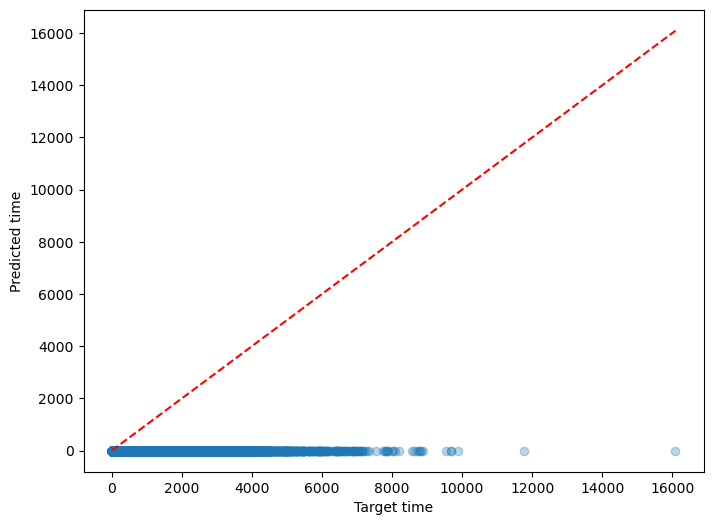

state_accuracy: 0.5370129321274617
time_rmse: 849.336216149921
time_mae: 386.9372283037189


In [38]:
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ÂàùÂßãÂåñÂ≠òÂÇ®ÂÆπÂô®
state_preds = []
time_preds = []
state_targets = []
time_targets = []
model.eval()

with torch.no_grad():
    for x_batch, y_state, y_time in test_loader:
        x_batch = x_batch.to(device).float()

        # ÂâçÂêë‰º†Êí≠
        state_pred, time_pred = model(x_batch)

        # Êî∂ÈõÜÈ¢ÑÊµãÁªìÊûú
        state_preds.extend(torch.argmax(state_pred, dim=1).cpu().numpy())  # ÂèñÁ±ªÂà´Á¥¢Âºï
        time_preds.extend(time_pred.cpu().numpy())

        # Êî∂ÈõÜÁúüÂÆûÊ†áÁ≠æ
        state_targets.extend(y_state.cpu().numpy())
        time_targets.extend(y_time.cpu().numpy())

# ====== ÂàÜÁ±ª‰ªªÂä°ËØÑ‰º∞ ======
print("\n===== Áä∂ÊÄÅÂàÜÁ±ªËØÑ‰º∞ =====")
print("ÂáÜÁ°ÆÁéá:", accuracy_score(state_targets, state_preds))
# print(classification_report(
#     state_targets, 
#     state_preds,
#     target_names=state_encoder.classes_  # ‰ΩøÁî®‰πãÂâç‰øùÂ≠òÁöÑÁºñÁ†ÅÂô®Á±ªÂà´Âêç
# ))


# ====== Êó∂Èó¥ÂõûÂΩíËØÑ‰º∞ ======
print("\n===== Êó∂Èó¥È¢ÑÊµãËØÑ‰º∞ =====")
rmse = np.sqrt(mean_squared_error(time_targets, time_preds))
mae = mean_absolute_error(time_targets, time_preds)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Êó∂Èó¥È¢ÑÊµãÊï£ÁÇπÂõæ
plt.figure(figsize=(8, 6))
plt.scatter(time_targets, time_preds, alpha=0.3)
plt.plot([min(time_targets), max(time_targets)], 
         [min(time_targets), max(time_targets)], 'r--')
plt.xlabel("Target time")
plt.ylabel("Predicted time")
plt.show()


print("state_accuracy:", accuracy_score(state_targets, state_preds))
print("time_rmse:", rmse)
print("time_mae:", mae)




# ÂÖ≠. Ê®°ÂûãÊ∑±Â∫¶Ë∞É‰ºòËÆ≠ÁªÉ

## 6.1.Á±ªÊùÉÈáçÊ≥ï

### 1. ËÆ°ÁÆóÁ±ªÊùÉÈáçÁü©Èòµ 

#### 1.1 wi = min(1.0 / (n_i * recall_i),w_max)

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_class_weights(confusion_matrix, epsilon=1e-5, w_max=100.0):
    """
    Ê†πÊçÆÊ∑∑Ê∑ÜÁü©ÈòµËÆ°ÁÆóÁ±ªÊùÉÈáç„ÄÇ
    
    ÂèÇÊï∞Ôºö
    - confusion_matrix: Ê∑∑Ê∑ÜÁü©ÈòµÔºåshape=(num_classes, num_classes)
    - epsilon: Âπ≥ÊªëÂèÇÊï∞ÔºåÈò≤Ê≠¢Èô§Èõ∂ÔºåÈªòËÆ§ÂÄº‰∏∫ 1e-5
    - w_max: ÊùÉÈáç‰∏äÈôêÔºåÈªòËÆ§ÂÄº‰∏∫ 100.0
    
    ËøîÂõûÔºö
    - weights: ÊØè‰∏™Á±ªÂà´ÁöÑÊùÉÈáçÔºåshape=(num_classes,)
    """
    num_classes = confusion_matrix.shape[0]
    weights = np.zeros(num_classes)
    
    for i in range(num_classes):
        # ÁúüÈò≥ÊÄß (TP)
        TP = confusion_matrix[i, i]
        # ÂÅáÈò¥ÊÄß (FN)ÔºåÂç≥ÁúüÂÆû‰∏∫ i ‰ΩÜÈ¢ÑÊµã‰∏∫ÂÖ∂‰ªñÁ±ªÂà´ÁöÑÊï∞Èáè
        FN = np.sum(confusion_matrix[i, :]) - TP
        # Á±ªÂà´ i ÁöÑÊÄªÊ†∑Êú¨Êï∞
        n_i = TP + FN
        
        if n_i == 0:
            # Â¶ÇÊûúÁ±ªÂà´ i Âú®ÊµãËØïÈõÜ‰∏≠Ê≤°ÊúâÊ†∑Êú¨ÔºåËÆæÁΩÆÈªòËÆ§ÊùÉÈáç
            weights[i] = 1.0
        else:
            # Âπ≥ÊªëÂè¨ÂõûÁéá
            recall_i = (TP + epsilon) / (TP + FN + epsilon)
            # ËÆ°ÁÆóÊùÉÈáç
            weights[i] = 1.0 / (n_i * recall_i)
            # ÈôêÂà∂ÊùÉÈáç‰∏äÈôê
            weights[i] = min(weights[i], w_max)
    
    # ÂΩí‰∏ÄÂåñÊùÉÈáçÔºå‰ΩøÂÖ∂ÊÄªÂíåÁ≠â‰∫éÁ±ªÂà´Êï∞ÔºàÂèØÈÄâÔºâ
    weights = weights / np.sum(weights) * num_classes
    
    return weights

# ‰ΩøÁî®‰Ω†ÁöÑÊ∑∑Ê∑ÜÁü©ÈòµËÆ°ÁÆóÊùÉÈáç
class_weights = calculate_class_weights(final_cm)
print("Class Weights:", class_weights)

Class Weights: [1.52685859e-04 1.07132179e-05 1.18317457e-05 8.71165937e-06
 1.22906094e-05 1.31663895e-05 5.45088527e-02 5.45088527e-02
 5.45088527e+00 5.45088527e+00 1.32270936e-05 4.61548284e-05
 1.52814277e-05 2.29510958e-05 3.52351988e-05 2.95280892e-05
 4.82806489e-05 1.09017495e-02 2.19528202e-05 1.02653205e-04
 1.80492885e-04 2.40127101e-04 4.12945836e-04 5.54515286e-05
 5.45088527e+00 2.32943809e-04 5.45083855e-02 7.07907098e-04
 5.45088527e+00 5.45088527e+00 1.81695584e-02 1.26764746e-03
 8.65219753e-04 3.65831204e-04 3.04518716e-04 4.69903868e-04
 2.72542998e-02 5.45088527e+00 5.45083209e-02 5.45083192e-02
 3.89348695e-03 5.45088527e+00 5.45088527e+00 5.45083531e-02]


#### 1.2 wi ÊâãÂä®ËÆæÂÆö

In [44]:
import numpy as np

# ÂÅáËÆæ final_cm ÊòØÂêàÂπ∂ÂêéÁöÑÊ∑∑Ê∑ÜÁü©Èòµ
# final_cm = ...

# ÊâæÂá∫ÂØπËßíÁ∫ø‰∏ä‰∏∫Èõ∂ÁöÑÁ±ªÂà´Á¥¢Âºï
zero_recall_classes = np.where(np.diag(final_cm) == 0)[0]
print("Classes with zero recall:", zero_recall_classes)

Classes with zero recall: [ 8  9 24 28 29 37 41 42]


In [53]:
# ËÆæÁΩÆÂ§ßÊùÉÈáçÂÄº
large_weight = 1000000000000000000

# ÂàùÂßãÂåñÁ±ªÂà´ÊùÉÈáçÊï∞ÁªÑÔºåÊâÄÊúâÁ±ªÂà´ÊùÉÈáçÂàùÂßã‰∏∫1
num_state_classes = len(state_encoder.classes_)
class_weights = np.ones(num_state_classes)

class_weights[6] = large_weight

# ‰∏∫Èõ∂Âè¨ÂõûÁéáÁöÑÁ±ªÂà´ËÆæÁΩÆÂ§ßÊùÉÈáç
# for cls in zero_recall_classes:
#     class_weights[cls] = large_weight

# ËΩ¨Êç¢‰∏∫ PyTorch Âº†Èáè
#class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)

Class weights: [1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+18 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00]


### 2.Âä†ÊùÉÊçüÂ§±ÂáΩÊï∞‰ª£Á†Å

In [54]:
import torch
import torch.nn as nn

# Â∞ÜÊùÉÈáçËΩ¨Êç¢‰∏∫ tensorÔºåÂπ∂ÁßªÂä®Âà∞‰∏éÊ®°ÂûãÁõ∏ÂêåÁöÑËÆæÂ§á
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# ÂÆö‰πâÂä†ÊùÉ‰∫§ÂèâÁÜµÊçüÂ§±ÂáΩÊï∞
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor,reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

ËøîÂõûÁªßÁª≠ÊâßË°å‰∏äËø∞ÁöÑËÆ≠ÁªÉÊ®°Âûã‰ª£Á†Å